In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torch.nn.functional as F
from simulations import sim_randomised, sim_constrained, sim_automated
import random
import matplotlib.pyplot as plt
from torch.distributions import Categorical

#GNN related imports
import torch_geometric.nn as geom_nn

from torch_geometric.nn import MessagePassing
from torch_geometric.nn import global_mean_pool as gap, global_max_pool as gmp
from torch_geometric.data import Data
from torch_geometric.data import Batch

import torch.optim as optim


import math


In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
class ActorCritic(nn.Module):
    def __init__(self, n_states, n_actions, hidden_dim=128):
        super(ActorCritic, self).__init__()
        
        self.n_actions = n_actions
        
        self.actor = nn.Sequential(
            nn.Linear(n_states, hidden_dim),
            nn.PReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.LeakyReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.LeakyReLU(),
            nn.Linear(hidden_dim, n_actions),
        )
        self.critic = nn.Sequential(
            nn.Linear(n_states, hidden_dim),
            nn.PReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.LeakyReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.LeakyReLU(),
            nn.Linear(hidden_dim, 1),
        )

    def forward(self, state,action_mask,temperature=1.0):
        logits = self.actor(state) / temperature
        #print(logits, "direct logits")
        logits += action_mask
        #print(logits)
        
        action_probs = F.softmax(logits, dim=-1)
        state_value = self.critic(state)
        return action_probs, state_value

In [4]:
class PPO:
    def __init__(self, 
                 n_states, 
                 n_actions,
                 lr_actor,
                 lr_critic,
                 gamma,
                 K_epochs,
                 eps_clip,
                 gae_lambda):
        
        self.gamma = gamma
        self.eps_clip = eps_clip
        self.K_epochs = K_epochs
        self.gae_lambda = gae_lambda

        self.policy = ActorCritic(n_states, n_actions)
        self.optimizer = optim.Adam([
            {'params': self.policy.actor.parameters(), 'lr': lr_actor},
            {'params': self.policy.critic.parameters(), 'lr': lr_critic}
        ])
        
        self.scheduler = torch.optim.lr_scheduler.ExponentialLR(self.optimizer, gamma=0.9998)

        self.policy_old = ActorCritic(n_states, n_actions)
        self.policy_old.load_state_dict(self.policy.state_dict())

        self.MseLoss = nn.MSELoss()

    def select_action(self, state_data, memory,action_mask, temperature=1.0):
        
        # Not sure if I need it
        state_data = torch.FloatTensor(state_data.reshape(1, -1))
        
        
        with torch.no_grad():
            masked_action_probs, _ = self.policy_old(state_data, action_mask, temperature)
        
        dist = Categorical(masked_action_probs)
        action = dist.sample()
        
        
        memory.states.append(state_data)
        memory.actions.append(action)
        memory.masks.append(torch.tensor(action_mask))
        memory.logprobs.append(dist.log_prob(action))

        return action

    def update(self, memory):
        gae, targets = self.calculate_gae_and_targets(memory)


        old_states = torch.squeeze(torch.stack(memory.states))        
        old_actions = torch.squeeze(torch.stack(memory.actions)).detach()
        old_masks = torch.squeeze(torch.stack(memory.masks)).detach()
        old_logprobs = torch.squeeze(torch.stack(memory.logprobs)).detach()
        losses = []
        
        # Normalizing the rewards
        gae = torch.tensor(gae)
        gae = (gae - gae.mean()) / (gae.std() + 1e-7)

        for _ in range(self.K_epochs):
            # Evaluate old actions and values
            logprobs, state_values = self.policy(old_states,old_masks)
            state_values = torch.squeeze(state_values)
            dist_entropy = -torch.sum(logprobs * torch.exp(logprobs), dim=1)
            new_logprobs = logprobs.gather(1, old_actions.view(-1, 1)).squeeze()
            
            # Find the ratio (pi_theta / pi_theta__old)
            ratios = torch.exp(new_logprobs - old_logprobs)
            
            # Calculate surrogate losses
            surr1 = ratios * gae
            surr2 = torch.clamp(ratios, 1-self.eps_clip, 1+self.eps_clip) * gae
            
            # Final loss
            loss = -torch.min(surr1, surr2) + 0.5*self.MseLoss(state_values, targets) - 0.01*dist_entropy
            
            # Take gradient step
            self.optimizer.zero_grad()
            loss.mean().backward()
            self.optimizer.step()
            
            losses.append(loss.mean().detach().cpu().numpy())
        
        # Copy new weights into old policy
        self.policy_old.load_state_dict(self.policy.state_dict())
        return losses
        
    def calculate_gae_and_targets(self, memory):
        gae = 0
        targets = []
        gae_values = []
        values = memory.values + [0]
    
        for i in reversed(range(len(memory.rewards))):
            delta = memory.rewards[i] + self.gamma * values[i+1] * (1 - memory.is_terminals[i]) - values[i]
            gae = delta + self.gamma * self.gae_lambda * gae * (1 - memory.is_terminals[i])
            gae_values.insert(0, gae)
            targets.insert(0, gae + values[i])

        gae_values = torch.tensor(gae_values, dtype=torch.float32)
        targets = torch.tensor(targets, dtype=torch.float32)

        return gae_values, targets


In [5]:
class Memory:
    def __init__(self):
        self.actions = []
        self.masks = []
        self.states = []
        self.rewards = []
        self.is_terminals = []
        self.logprobs = []
        self.values = []


    def clear_memory(self):
        del self.actions[:]
        del self.masks[:]
        del self.states[:]
        del self.rewards[:]
        del self.is_terminals[:]
        del self.logprobs[:]
        del self.values[:]


In [6]:
def show(losses, success_rates):
    figure, axis = plt.subplots(2, 1,figsize=(20, 15) )

    x = range(len(losses))
    a, b = np.polyfit(x,losses , 1)

    axis[0].plot(x, losses)

    x = range(len(success_rates))
    # Creating the plot

    a, b = np.polyfit(x,success_rates , 1)

    axis[1].scatter(x, success_rates)

    axis[1].plot(x, a*x+b,color='red',linewidth=4.5)

    plt.show()   

230


/var/folders/tp/g5d5jn1j0x3d60w7kqpbj6wm0000gn/T/ipykernel_75577/2845807382.py:61: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



episode  25  is done!


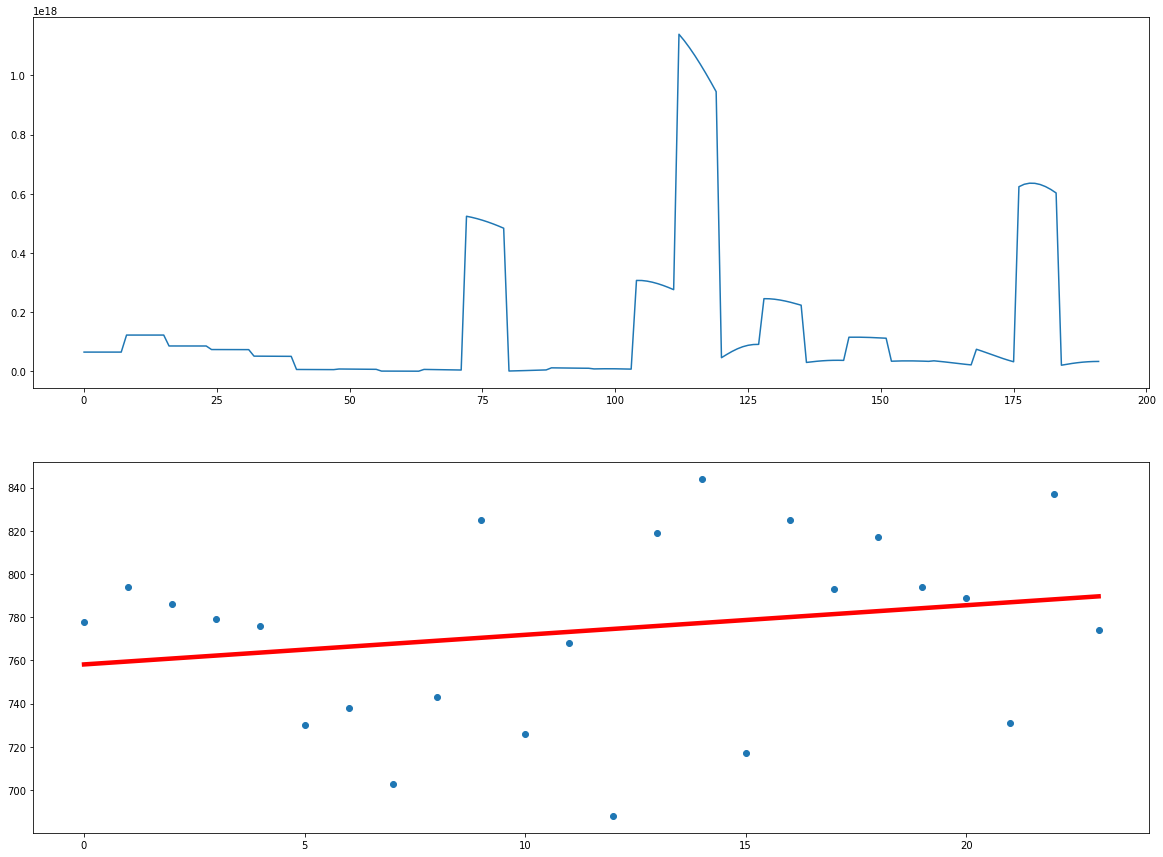

1.908
Epoch 25: Current Learning Rate: [0.0006966477166774919, 0.004976055119124942], Current Success Rate: 774


/var/folders/tp/g5d5jn1j0x3d60w7kqpbj6wm0000gn/T/ipykernel_75577/2845807382.py:61: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



episode  50  is done!


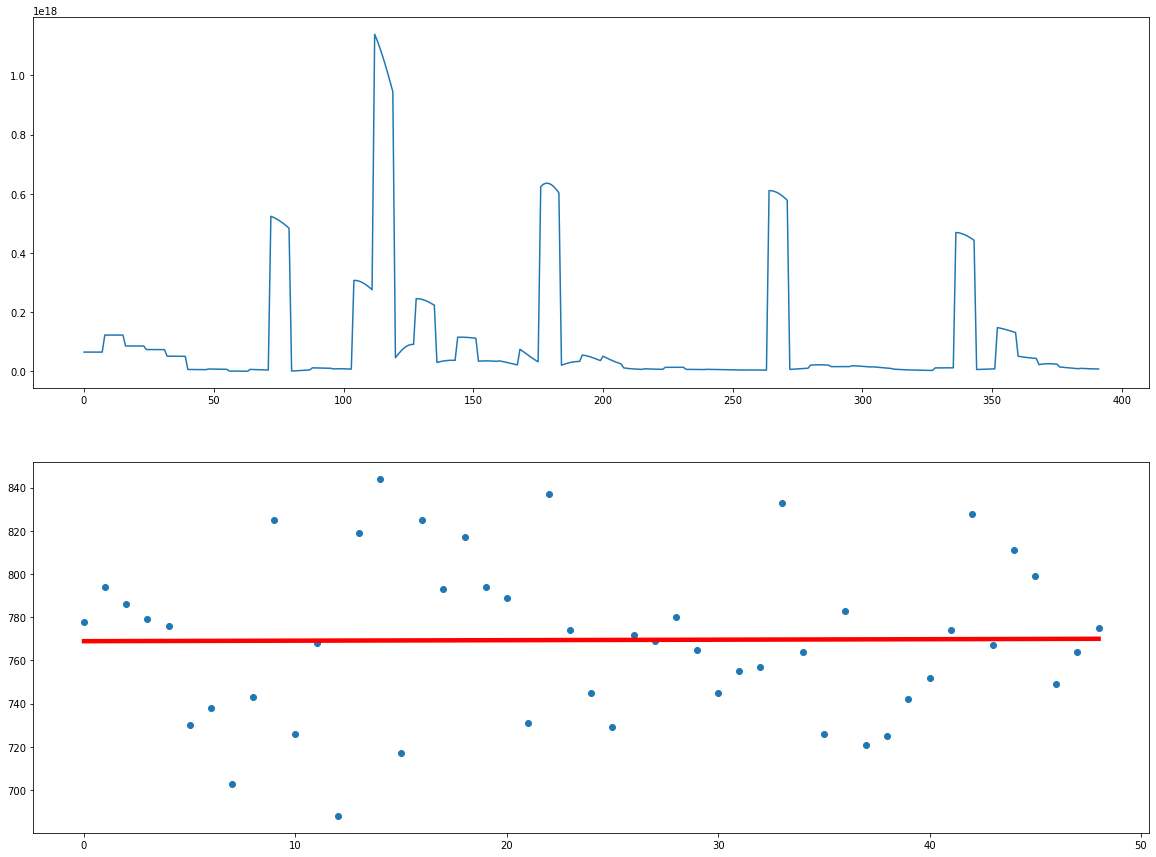

1.808
Epoch 50: Current Learning Rate: [0.0006931728250624754, 0.004951234464731965], Current Success Rate: 775


/var/folders/tp/g5d5jn1j0x3d60w7kqpbj6wm0000gn/T/ipykernel_75577/2845807382.py:61: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



episode  75  is done!


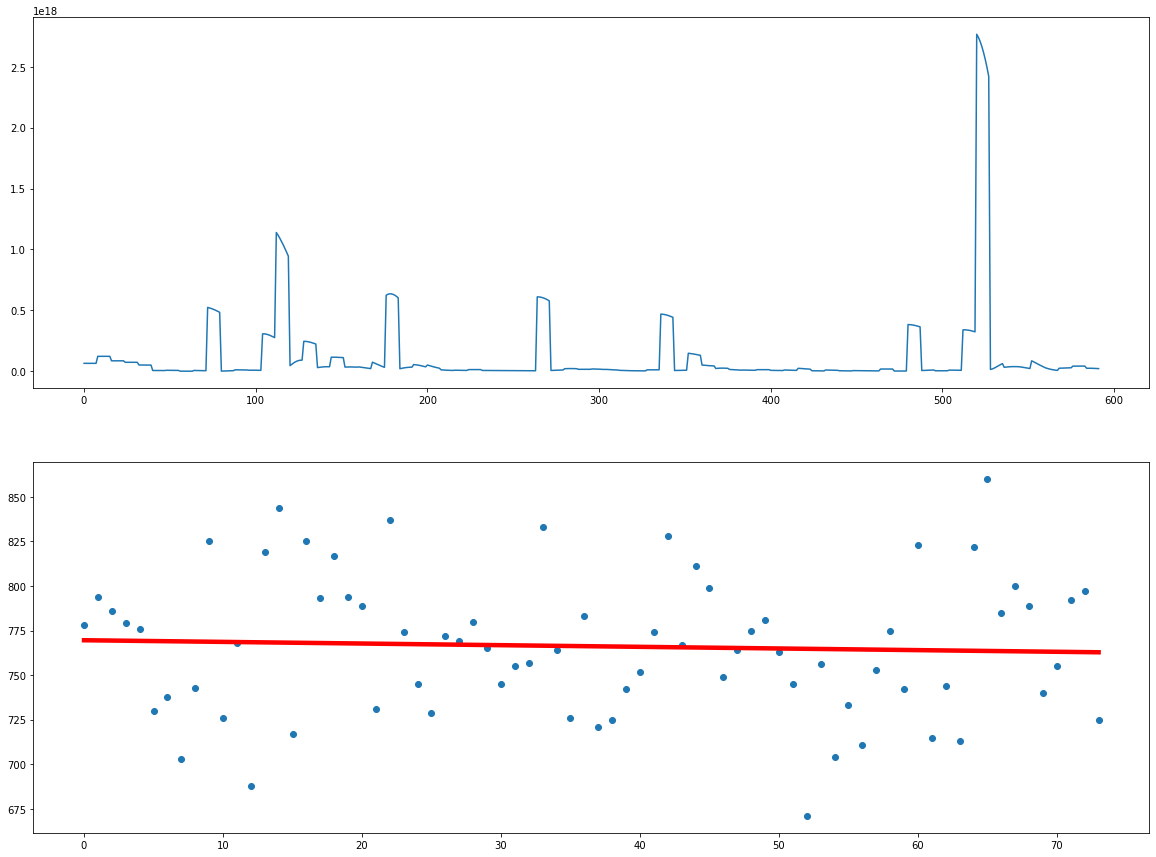

1.708
Epoch 75: Current Learning Rate: [0.0006897152662707019, 0.004926537616219299], Current Success Rate: 725


/var/folders/tp/g5d5jn1j0x3d60w7kqpbj6wm0000gn/T/ipykernel_75577/2845807382.py:61: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



episode  100  is done!


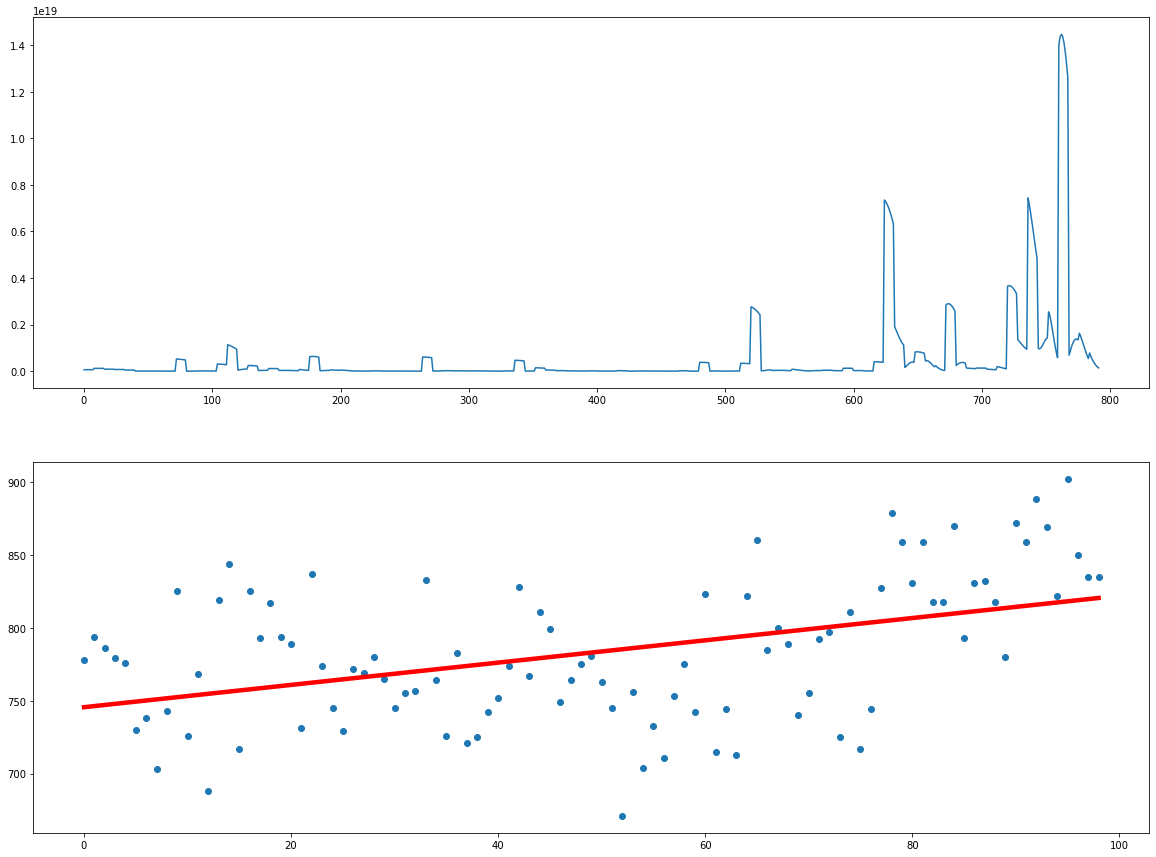

1.608
Epoch 100: Current Learning Rate: [0.0006862749538457313, 0.004901963956040937], Current Success Rate: 835


/var/folders/tp/g5d5jn1j0x3d60w7kqpbj6wm0000gn/T/ipykernel_75577/2845807382.py:61: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



episode  125  is done!


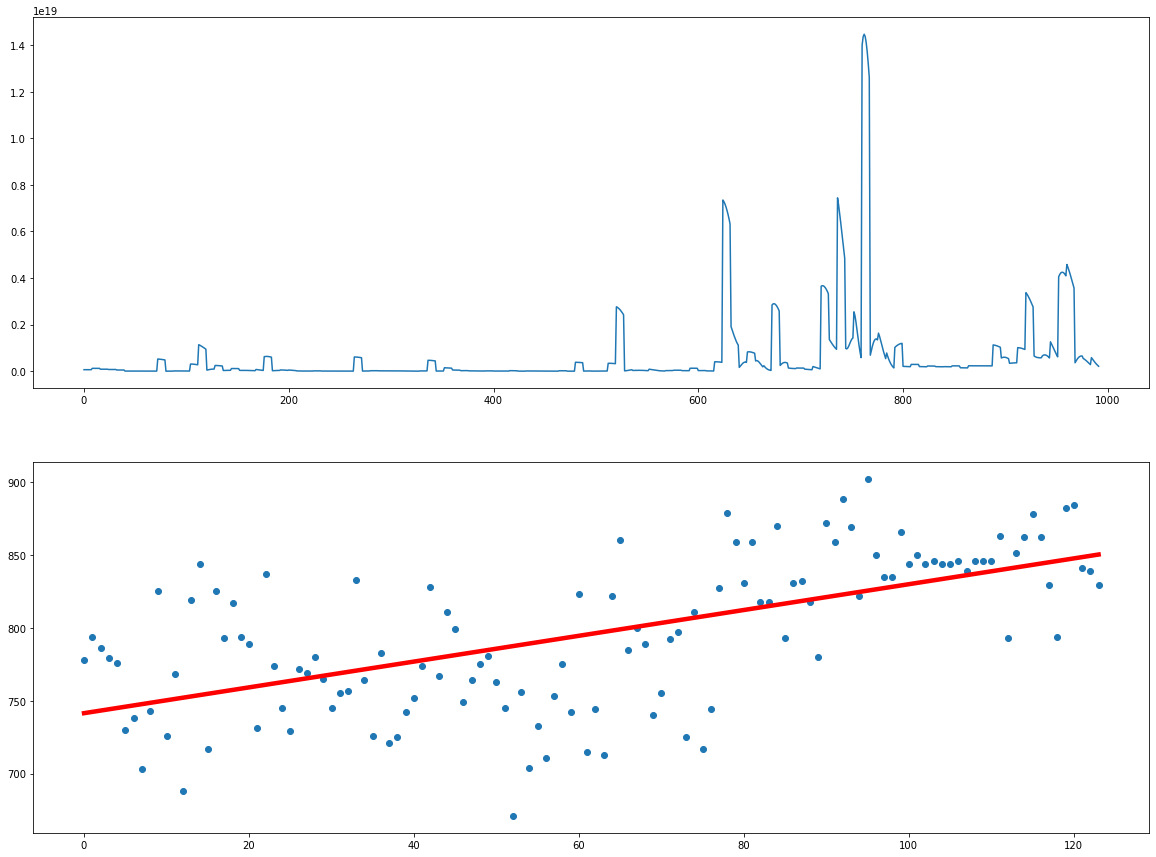

1.508
Epoch 125: Current Learning Rate: [0.0006828518017623686, 0.004877512869731203], Current Success Rate: 829


/var/folders/tp/g5d5jn1j0x3d60w7kqpbj6wm0000gn/T/ipykernel_75577/2845807382.py:61: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



episode  150  is done!


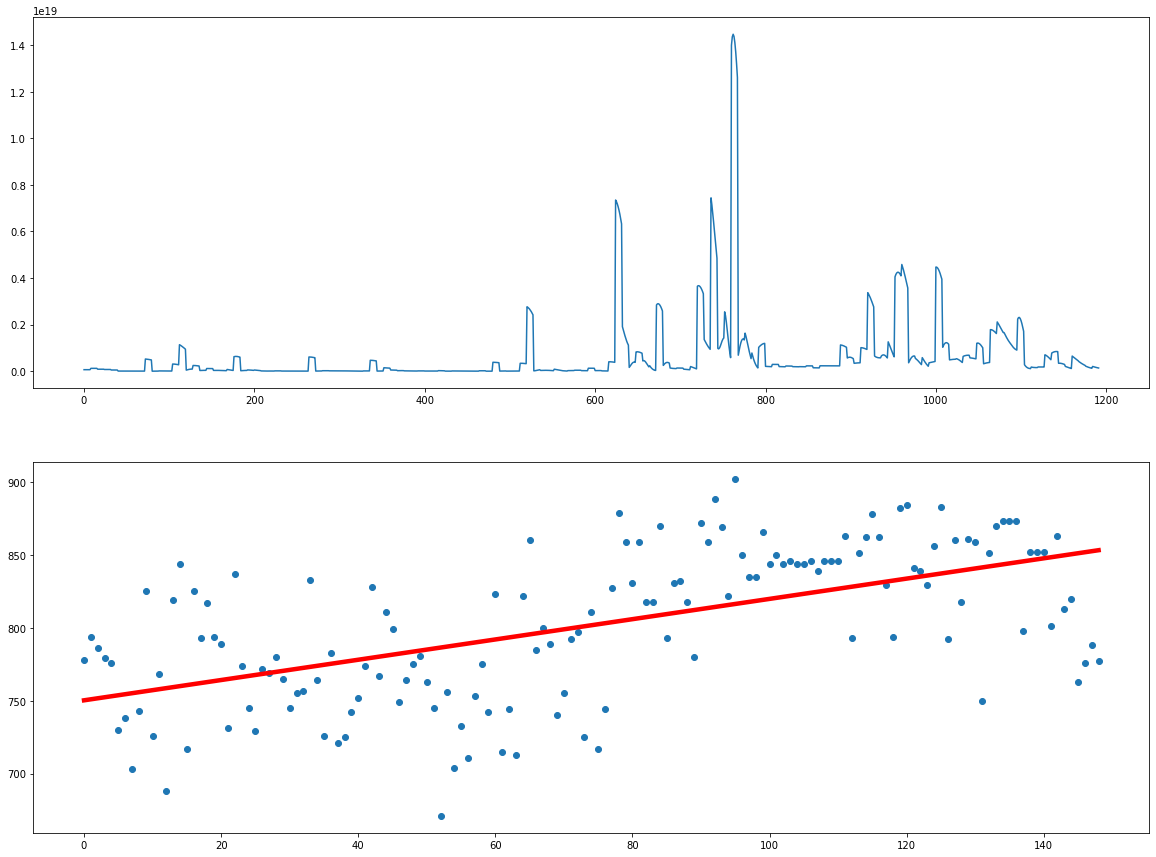

1.408
Epoch 150: Current Learning Rate: [0.0006794457244245145, 0.004853183745889388], Current Success Rate: 777


/var/folders/tp/g5d5jn1j0x3d60w7kqpbj6wm0000gn/T/ipykernel_75577/2845807382.py:61: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



episode  175  is done!


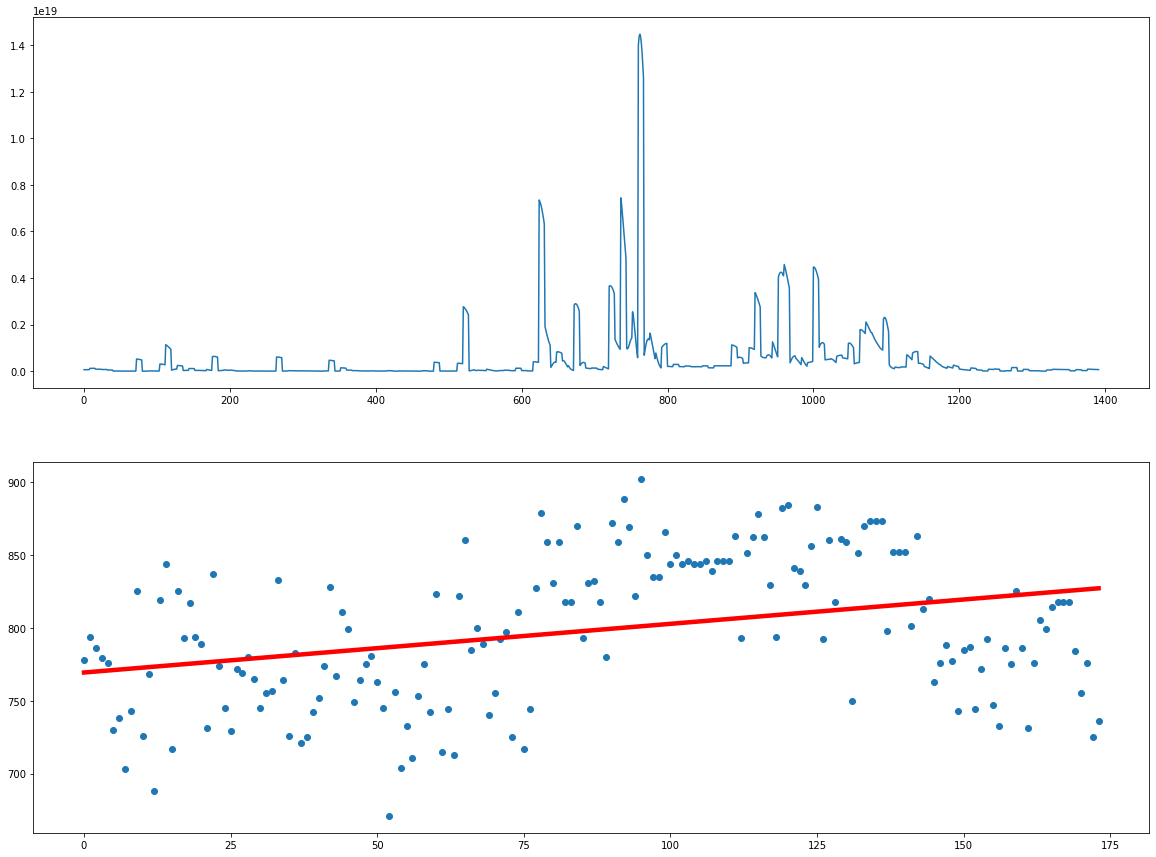

1.3079999999999998
Epoch 175: Current Learning Rate: [0.000676056636663024, 0.004828975976164459], Current Success Rate: 736


/var/folders/tp/g5d5jn1j0x3d60w7kqpbj6wm0000gn/T/ipykernel_75577/2845807382.py:61: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



episode  200  is done!


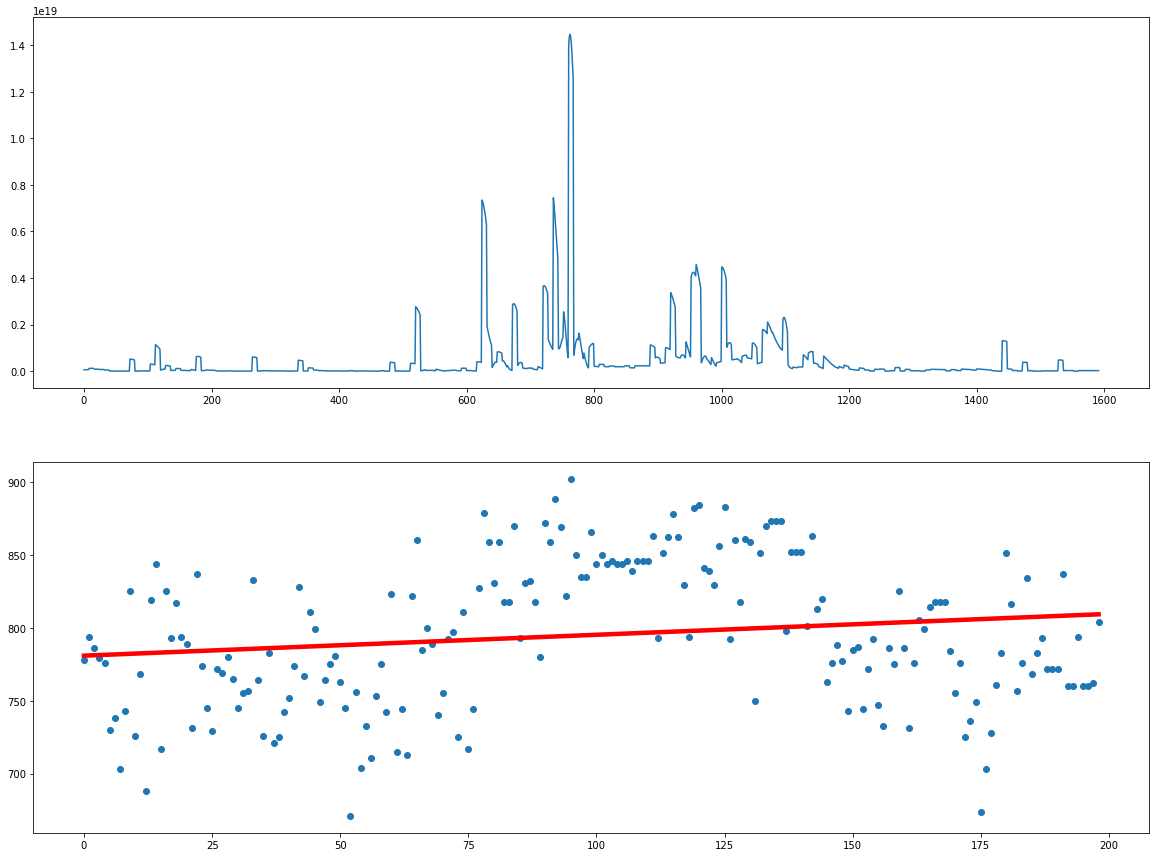

1.208
Epoch 200: Current Learning Rate: [0.0006726844537335791, 0.004804888955239854], Current Success Rate: 804


/var/folders/tp/g5d5jn1j0x3d60w7kqpbj6wm0000gn/T/ipykernel_75577/2845807382.py:61: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



episode  225  is done!


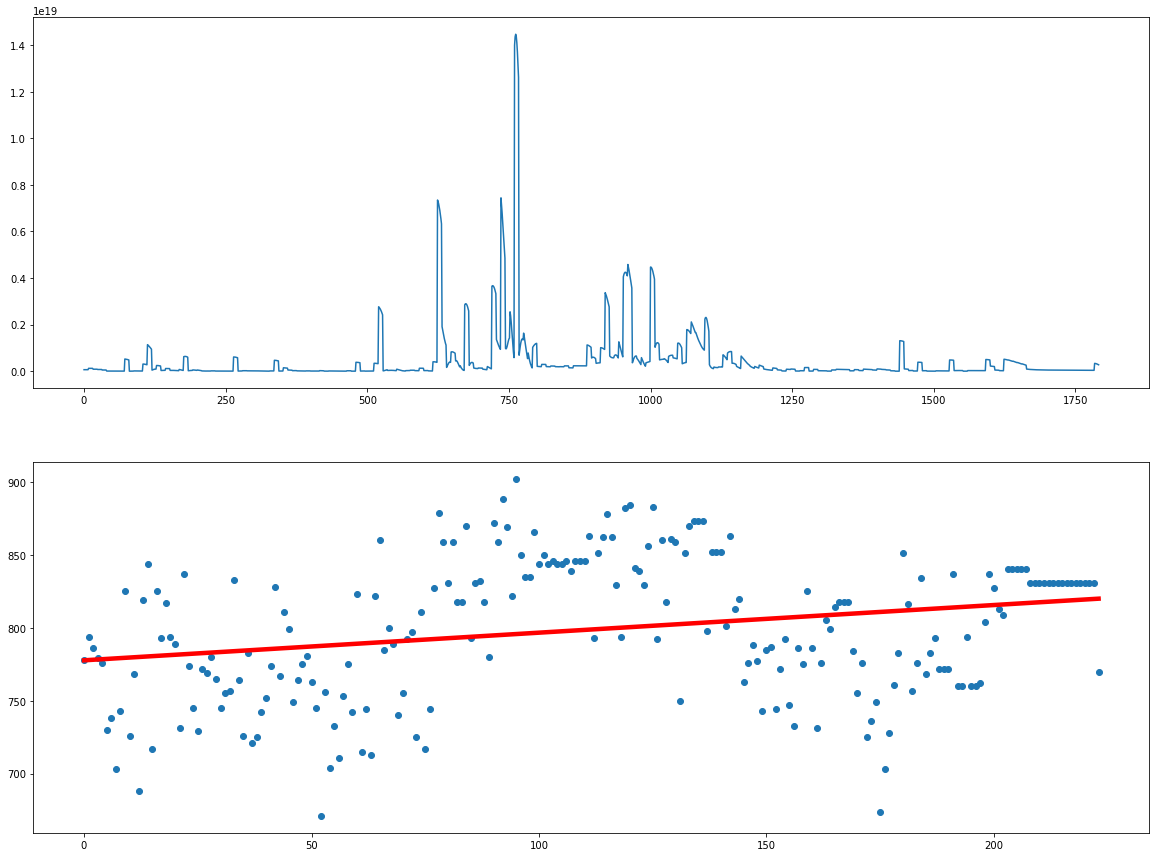

1.108
Epoch 225: Current Learning Rate: [0.0006693290913145663, 0.004780922080818334], Current Success Rate: 770


/var/folders/tp/g5d5jn1j0x3d60w7kqpbj6wm0000gn/T/ipykernel_75577/2845807382.py:61: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



episode  250  is done!


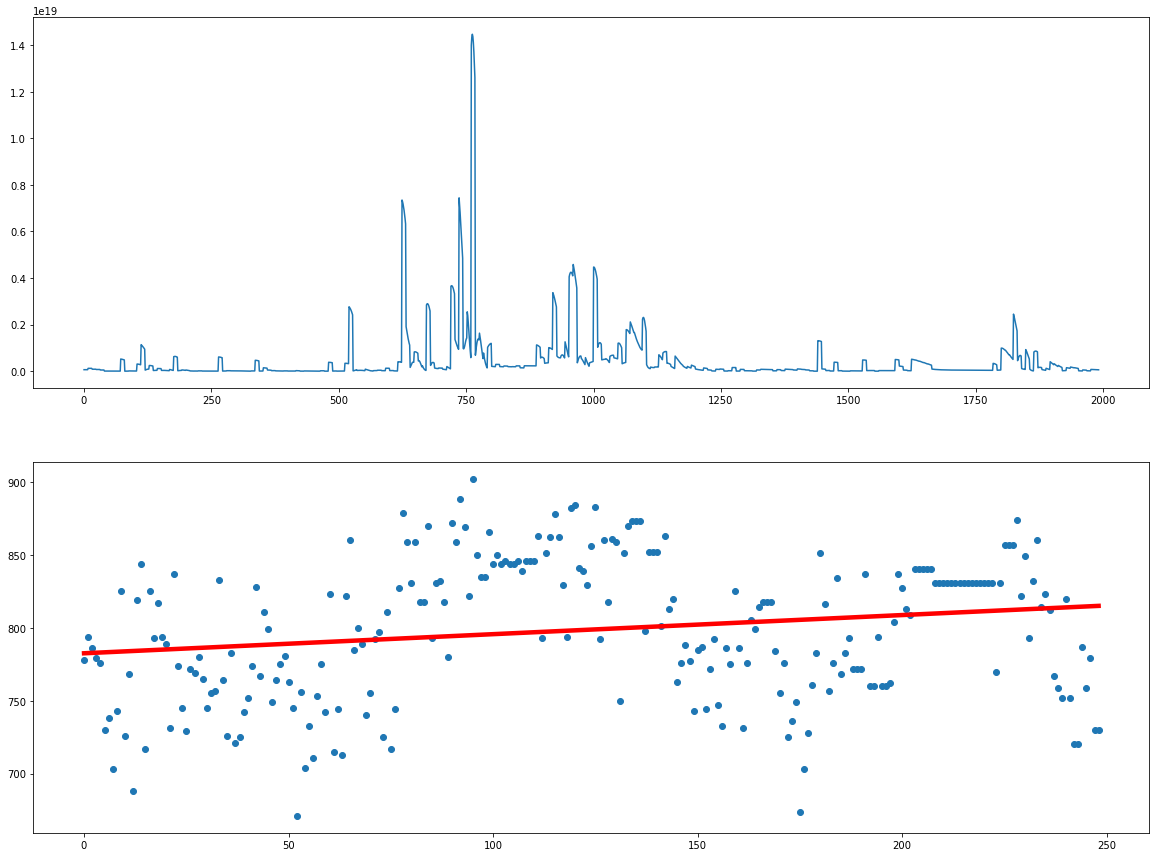

1.008
Epoch 250: Current Learning Rate: [0.0006659904655049701, 0.004757074753606934], Current Success Rate: 730


/var/folders/tp/g5d5jn1j0x3d60w7kqpbj6wm0000gn/T/ipykernel_75577/2845807382.py:61: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



episode  275  is done!


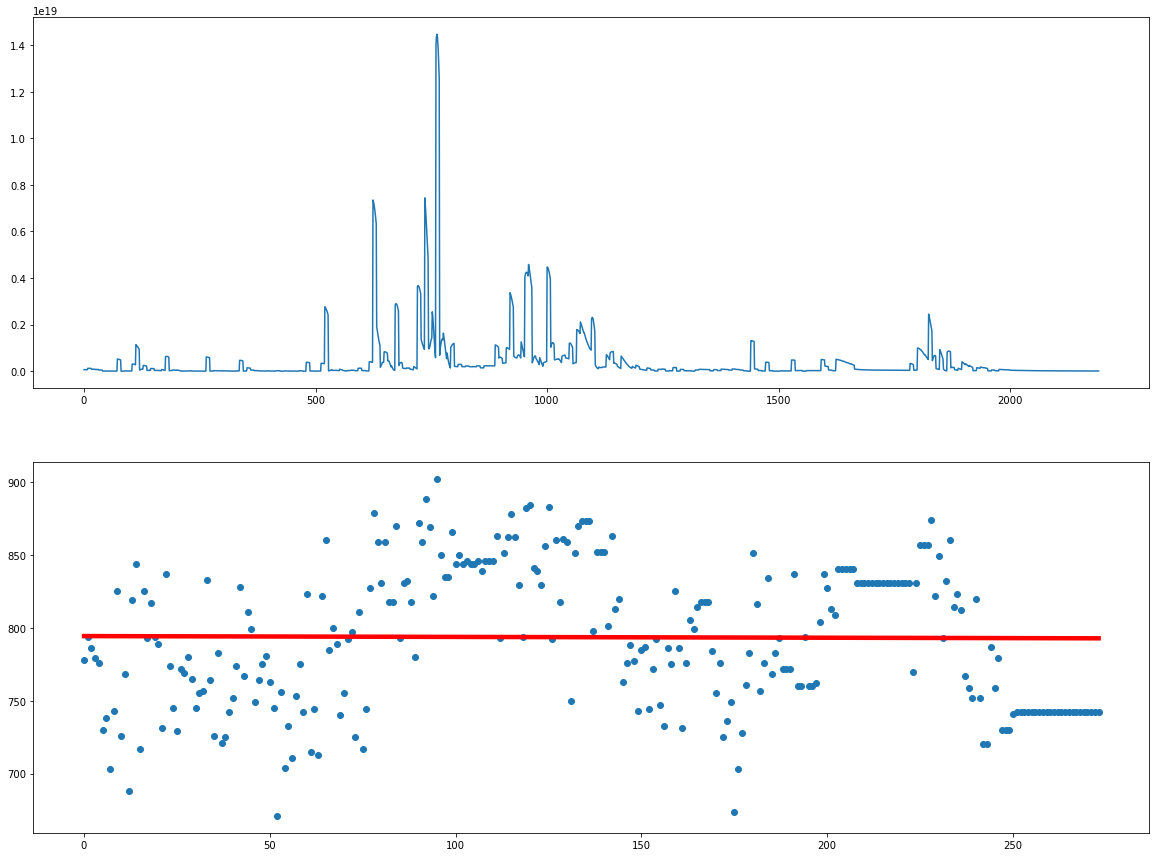

1
Epoch 275: Current Learning Rate: [0.0006626684928222755, 0.00473334637730197], Current Success Rate: 742


/var/folders/tp/g5d5jn1j0x3d60w7kqpbj6wm0000gn/T/ipykernel_75577/2845807382.py:61: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



episode  300  is done!


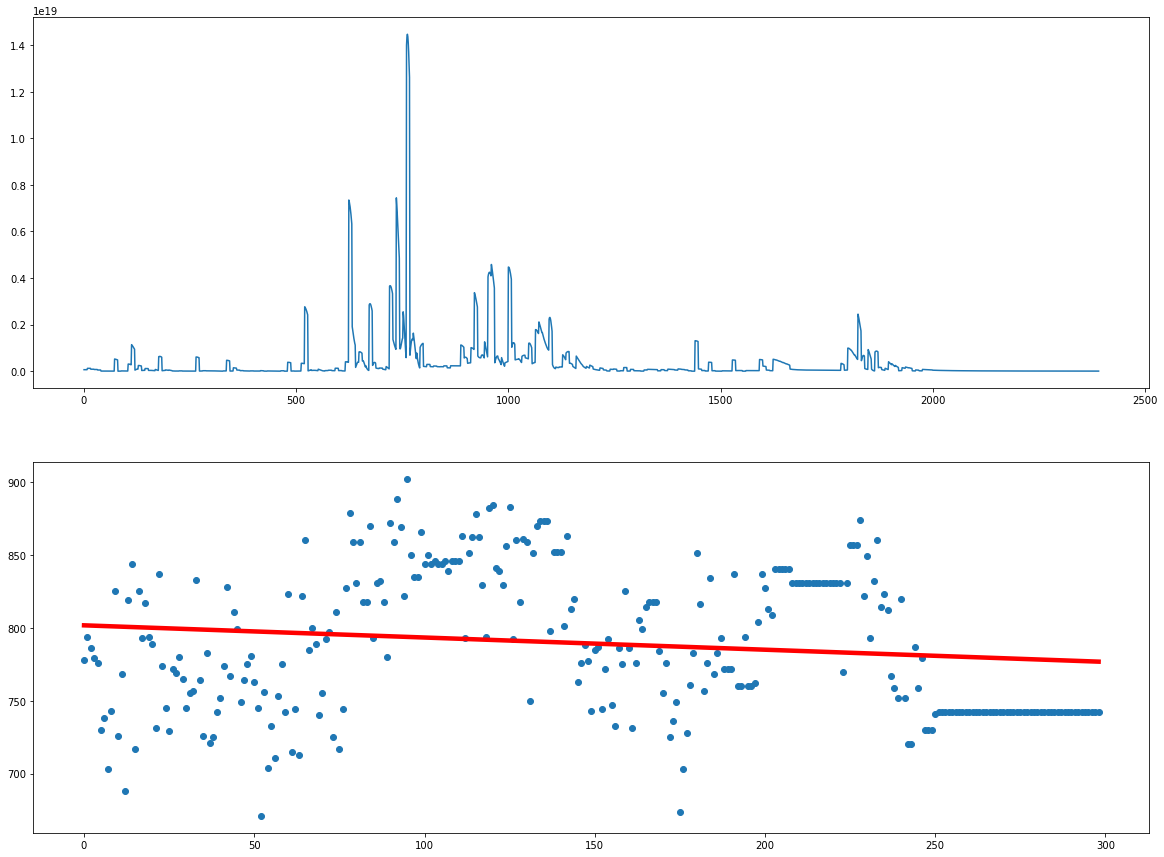

1
Epoch 300: Current Learning Rate: [0.0006593630902003797, 0.004709736358574139], Current Success Rate: 742


/var/folders/tp/g5d5jn1j0x3d60w7kqpbj6wm0000gn/T/ipykernel_75577/2845807382.py:61: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



episode  325  is done!


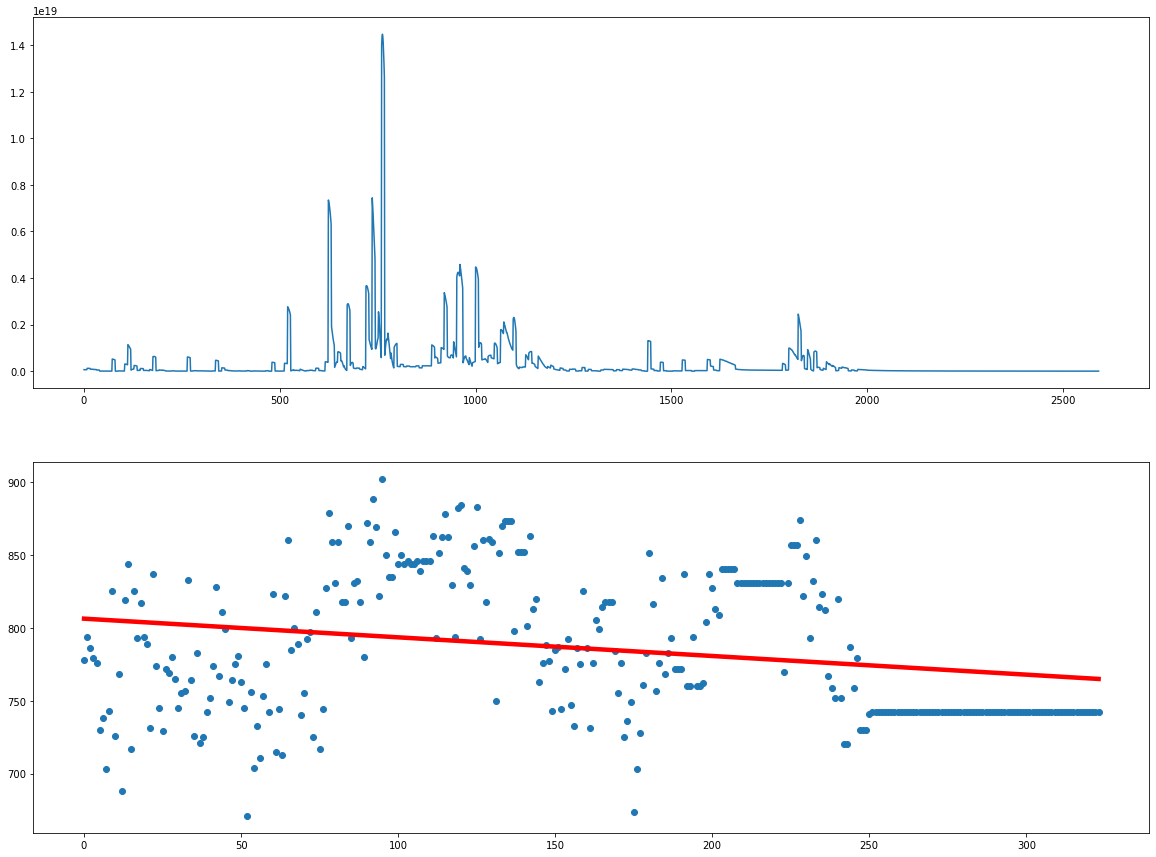

1
Epoch 325: Current Learning Rate: [0.000656074174987514, 0.00468624410705367], Current Success Rate: 742


/var/folders/tp/g5d5jn1j0x3d60w7kqpbj6wm0000gn/T/ipykernel_75577/2845807382.py:61: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



episode  350  is done!


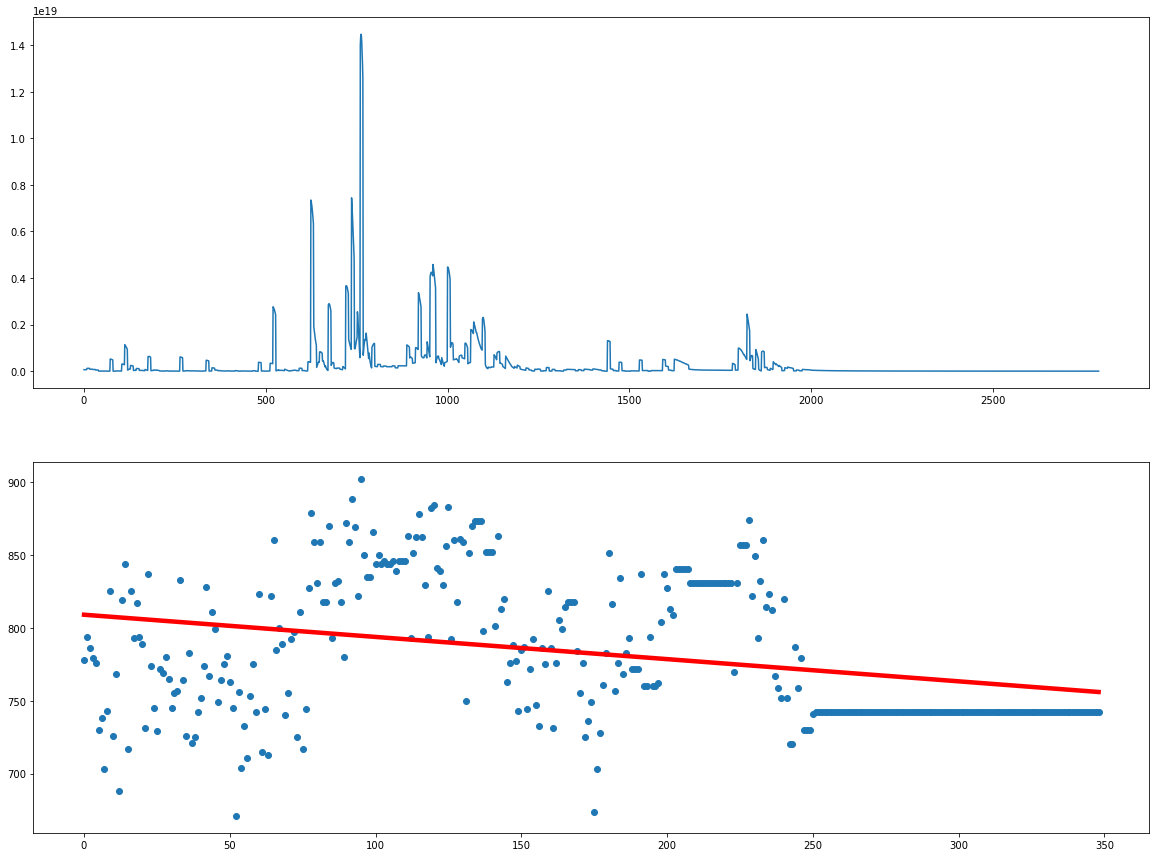

1
Epoch 350: Current Learning Rate: [0.0006528016649441794, 0.004662869035315567], Current Success Rate: 742


/var/folders/tp/g5d5jn1j0x3d60w7kqpbj6wm0000gn/T/ipykernel_75577/2845807382.py:61: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



episode  375  is done!


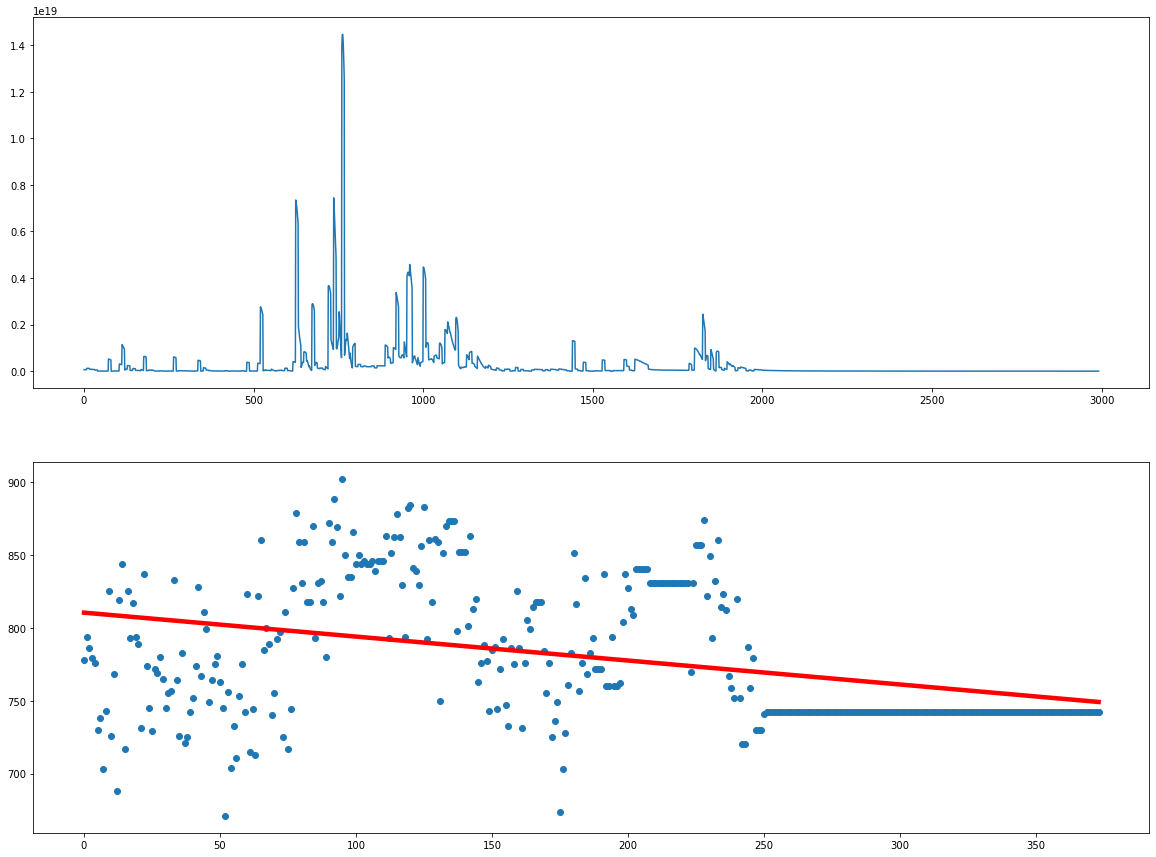

1
Epoch 375: Current Learning Rate: [0.0006495454782410892, 0.004639610558864922], Current Success Rate: 742


/var/folders/tp/g5d5jn1j0x3d60w7kqpbj6wm0000gn/T/ipykernel_75577/2845807382.py:61: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



episode  400  is done!


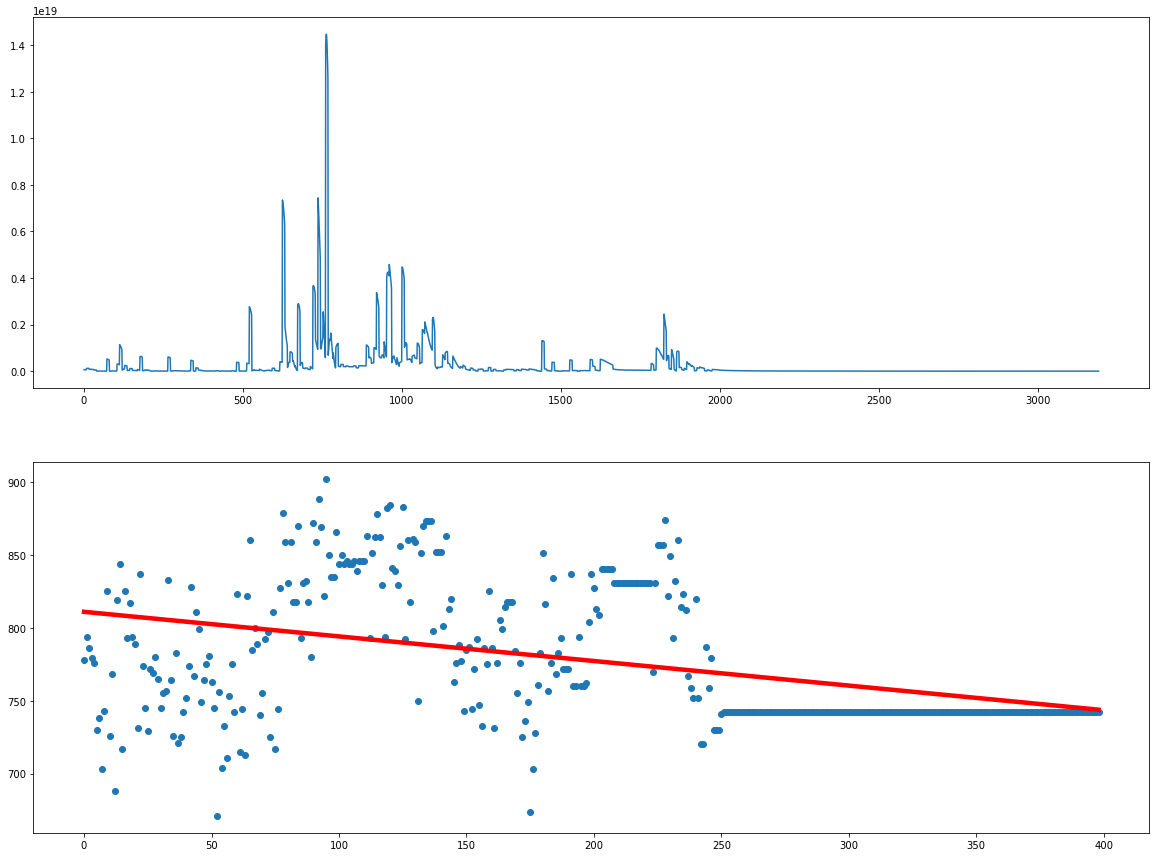

1
Epoch 400: Current Learning Rate: [0.000646305533457122, 0.0046164680961223], Current Success Rate: 742


/var/folders/tp/g5d5jn1j0x3d60w7kqpbj6wm0000gn/T/ipykernel_75577/2845807382.py:61: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



episode  425  is done!


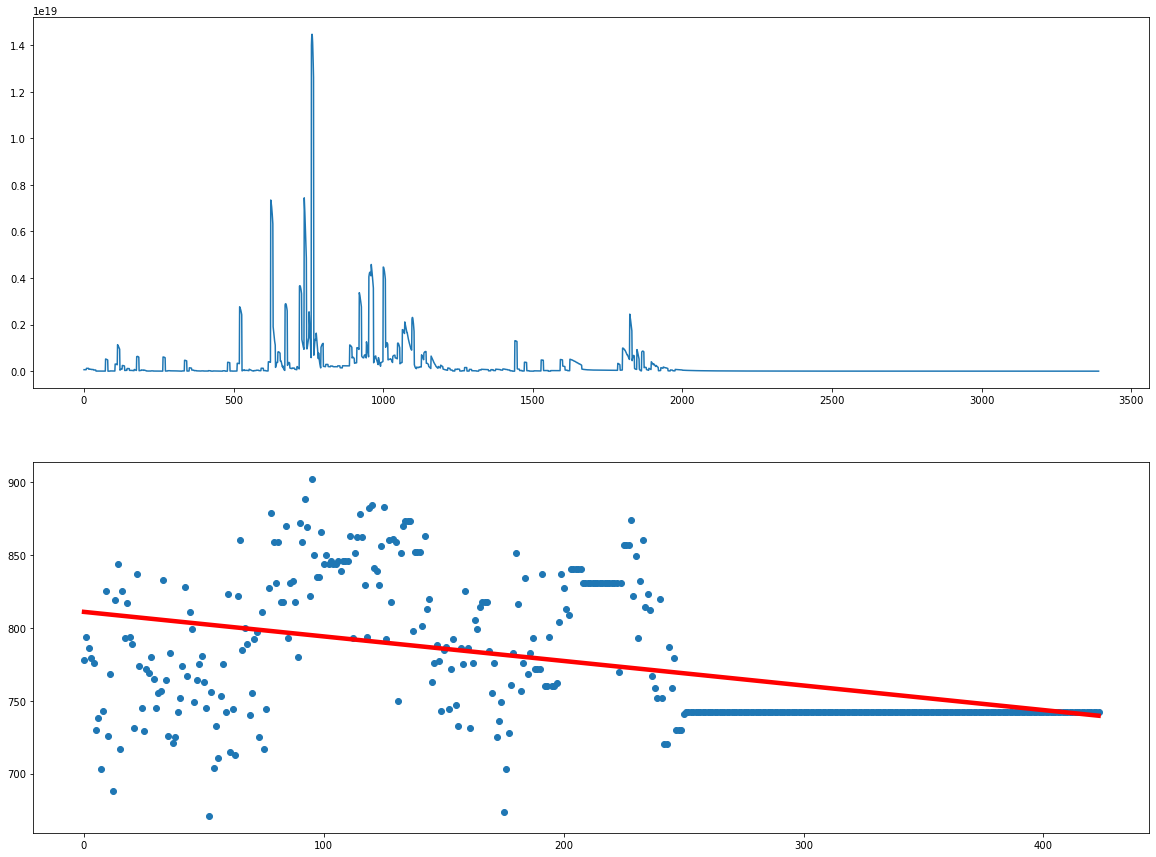

1
Epoch 425: Current Learning Rate: [0.0006430817495772868, 0.004593441068409189], Current Success Rate: 742


/var/folders/tp/g5d5jn1j0x3d60w7kqpbj6wm0000gn/T/ipykernel_75577/2845807382.py:61: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



episode  450  is done!


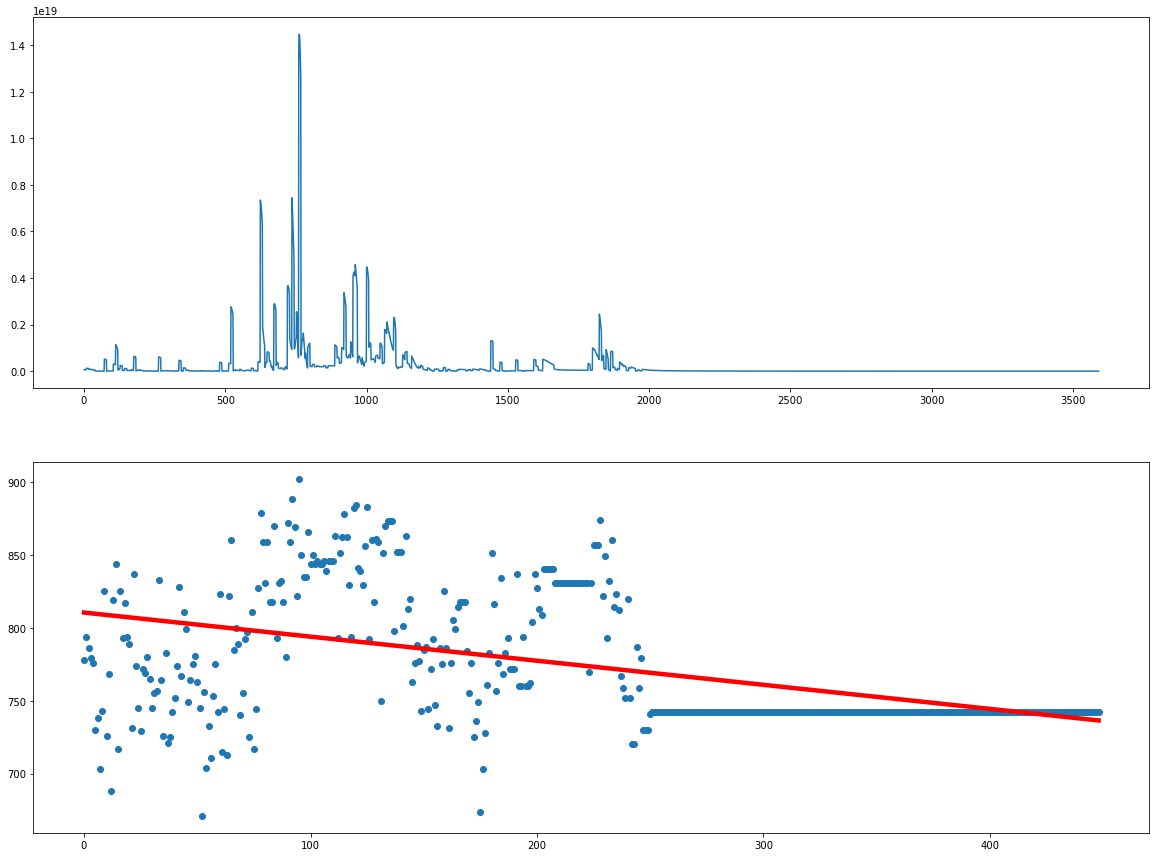

1
Epoch 450: Current Learning Rate: [0.0006398740459906967, 0.004570528899933543], Current Success Rate: 742


/var/folders/tp/g5d5jn1j0x3d60w7kqpbj6wm0000gn/T/ipykernel_75577/2845807382.py:61: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



episode  475  is done!


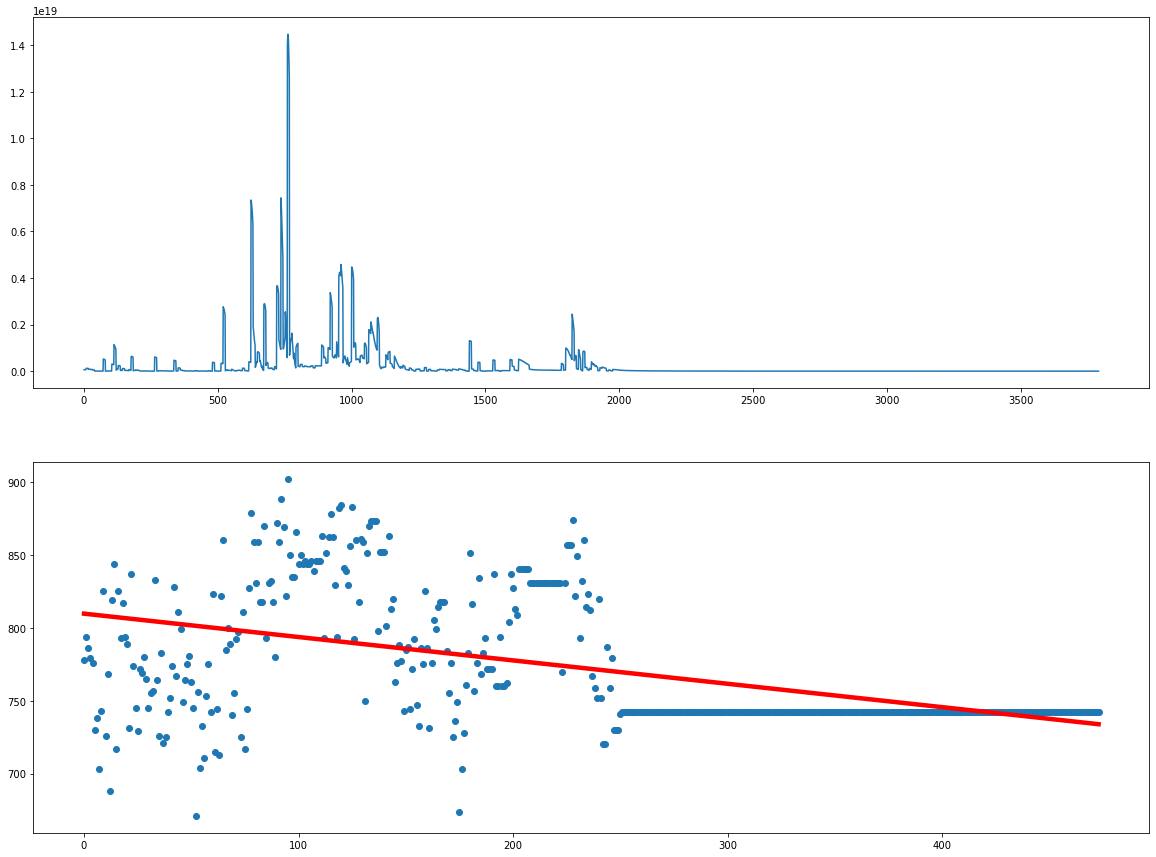

1
Epoch 475: Current Learning Rate: [0.0006366823424885533, 0.004547731017775376], Current Success Rate: 742


/var/folders/tp/g5d5jn1j0x3d60w7kqpbj6wm0000gn/T/ipykernel_75577/2845807382.py:61: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



episode  500  is done!


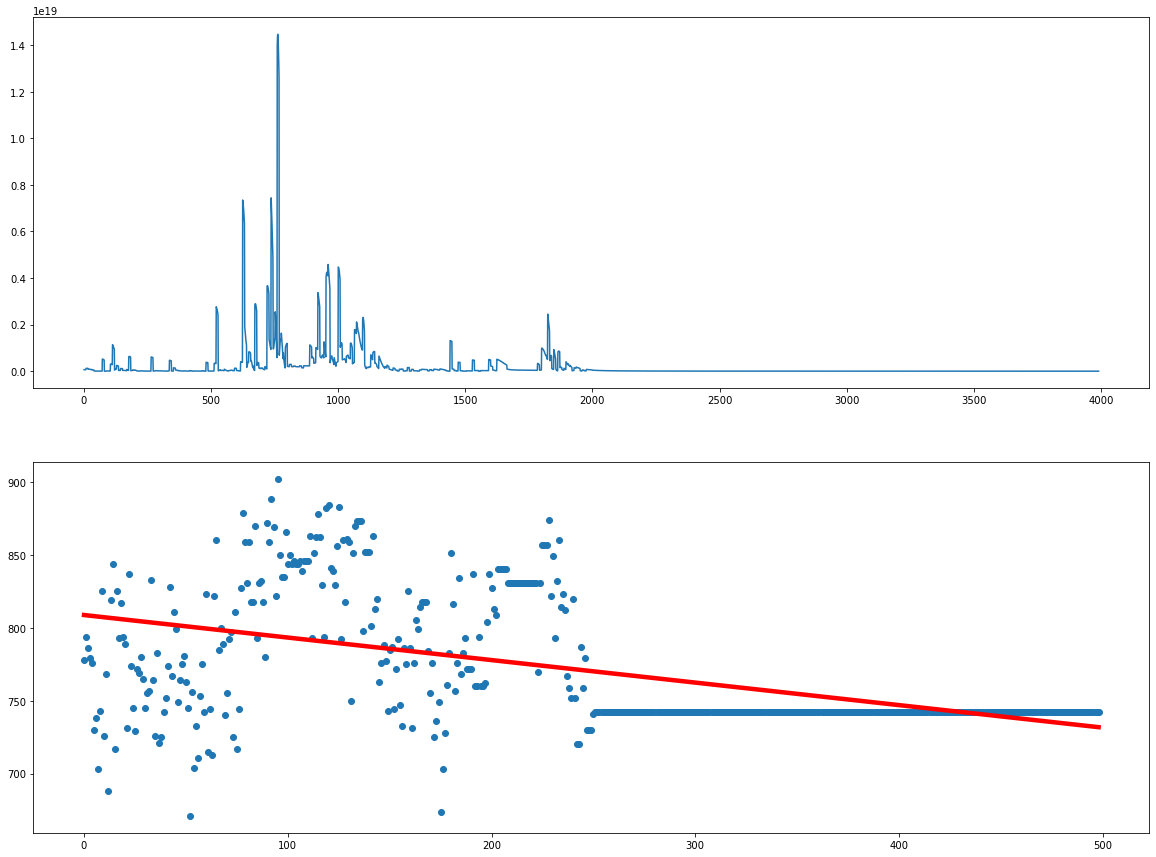

1
Epoch 500: Current Learning Rate: [0.0006335065592621415, 0.004525046851872433], Current Success Rate: 742


/var/folders/tp/g5d5jn1j0x3d60w7kqpbj6wm0000gn/T/ipykernel_75577/2845807382.py:61: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



episode  525  is done!


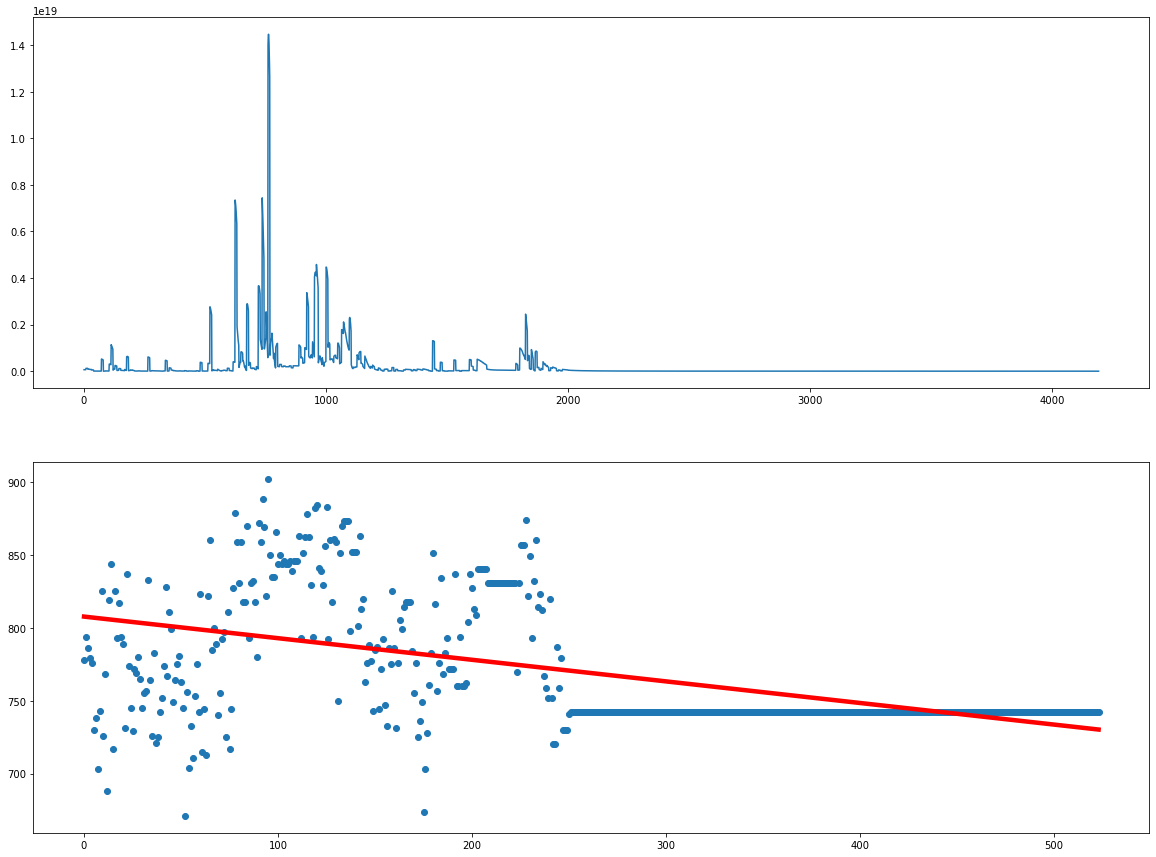

1
Epoch 525: Current Learning Rate: [0.0006303466169008331, 0.004502475835005945], Current Success Rate: 742


/var/folders/tp/g5d5jn1j0x3d60w7kqpbj6wm0000gn/T/ipykernel_75577/2845807382.py:61: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



episode  550  is done!


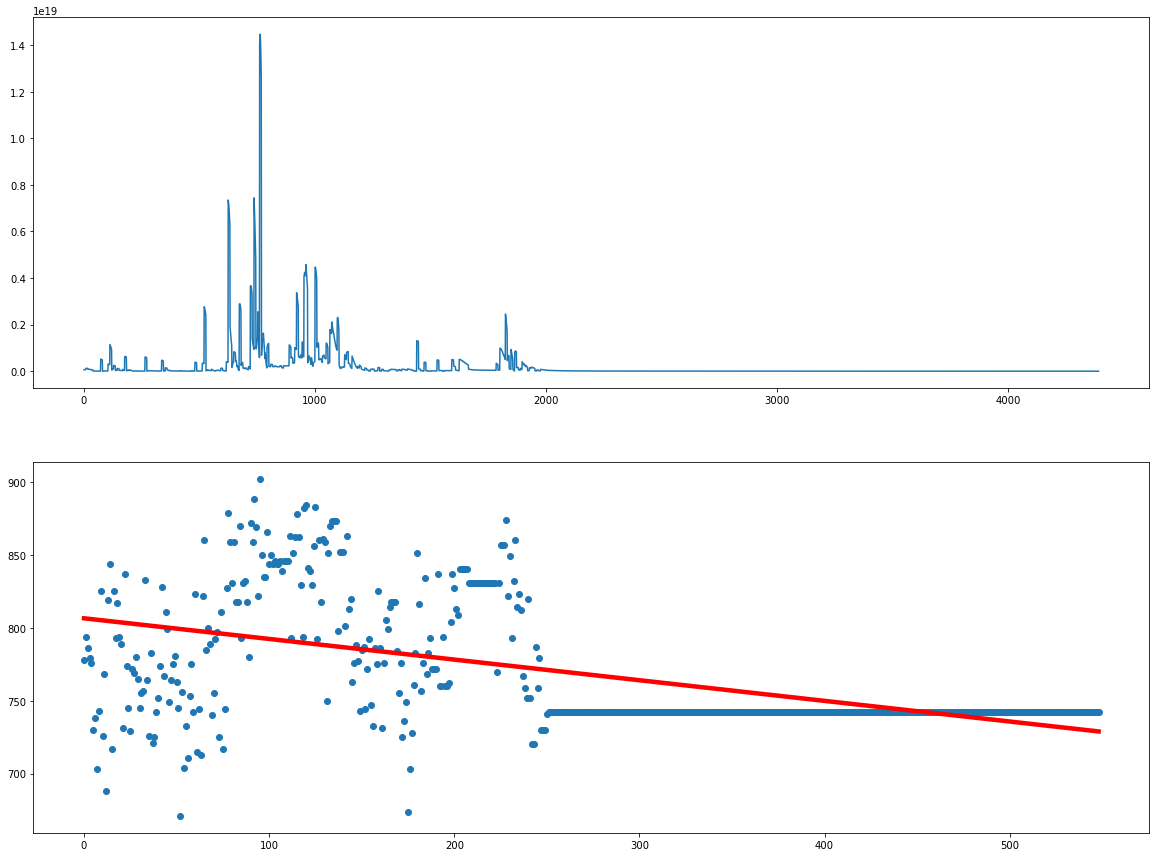

1
Epoch 550: Current Learning Rate: [0.0006272024363901019, 0.0044800174027864355], Current Success Rate: 742


/var/folders/tp/g5d5jn1j0x3d60w7kqpbj6wm0000gn/T/ipykernel_75577/2845807382.py:61: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



episode  575  is done!


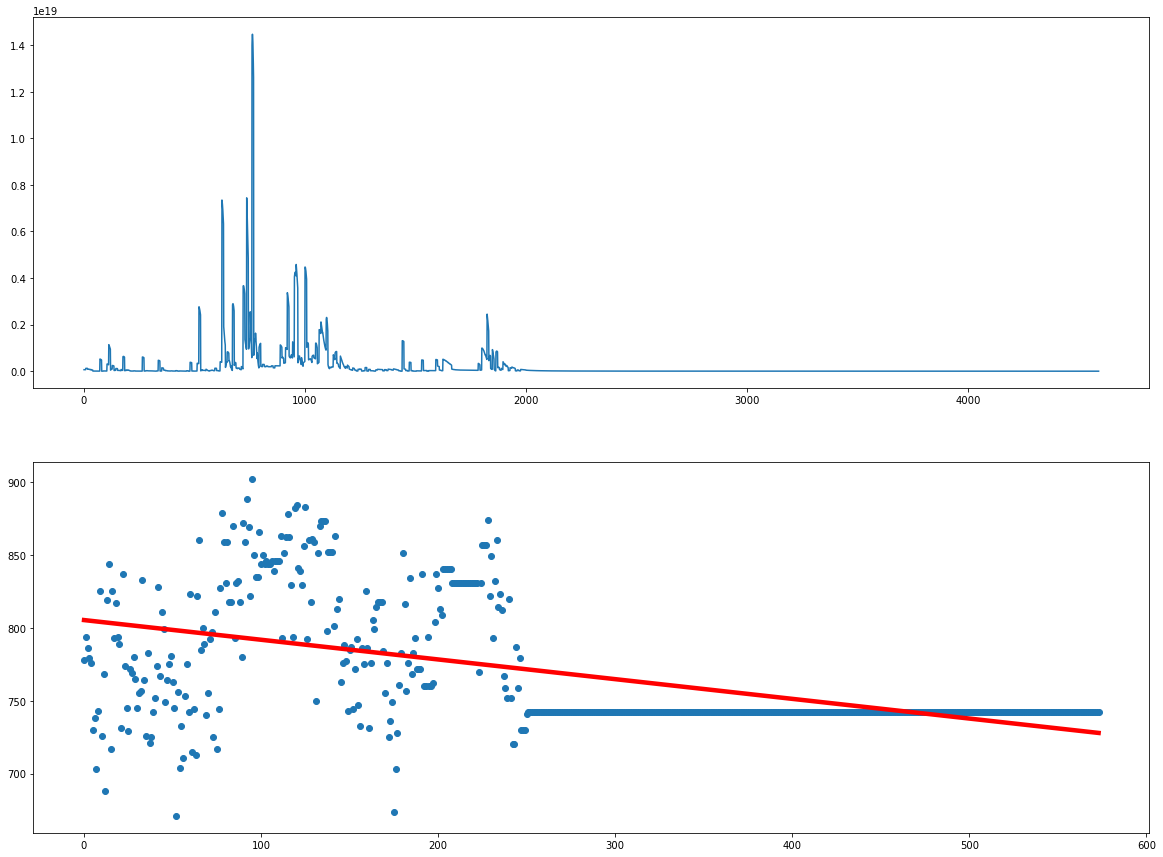

1
Epoch 575: Current Learning Rate: [0.0006240739391095475, 0.004457670993639616], Current Success Rate: 742


/var/folders/tp/g5d5jn1j0x3d60w7kqpbj6wm0000gn/T/ipykernel_75577/2845807382.py:61: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



episode  600  is done!


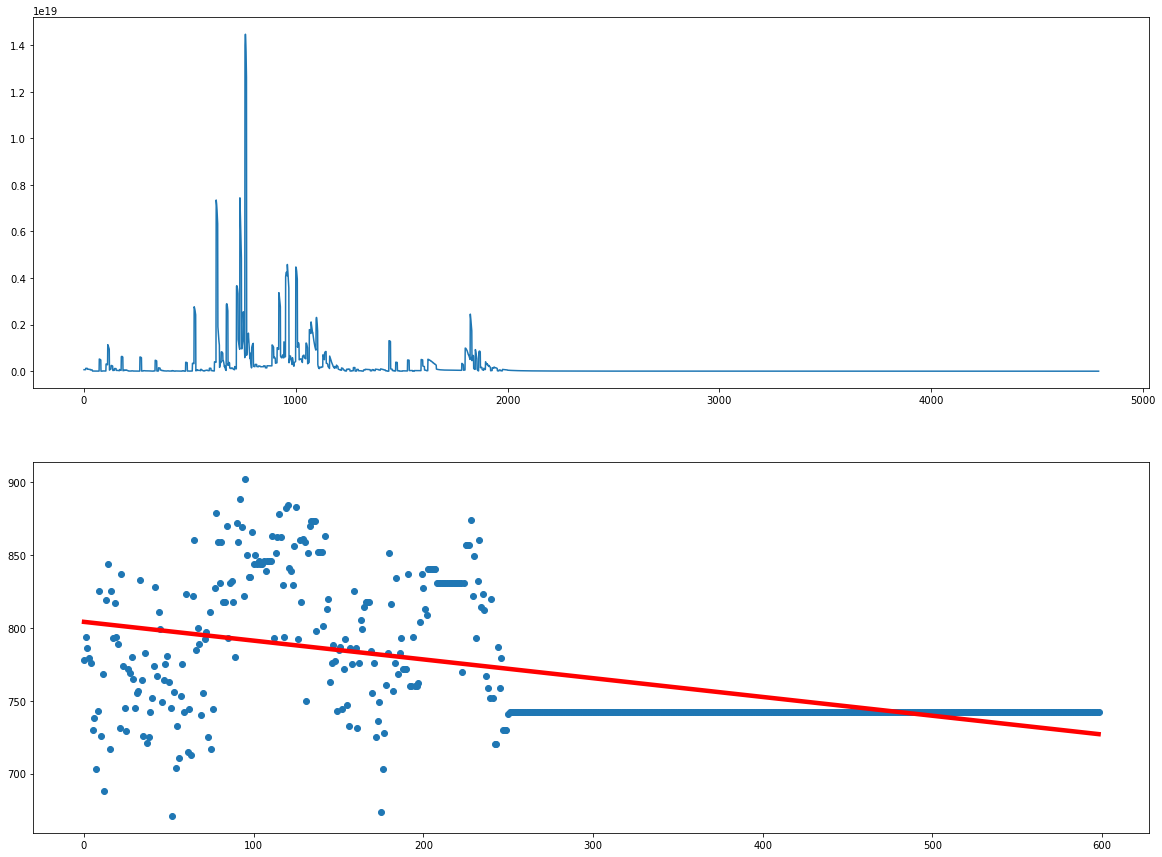

1
Epoch 600: Current Learning Rate: [0.0006209610468309296, 0.004435436048792344], Current Success Rate: 742


/var/folders/tp/g5d5jn1j0x3d60w7kqpbj6wm0000gn/T/ipykernel_75577/2845807382.py:61: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



episode  625  is done!


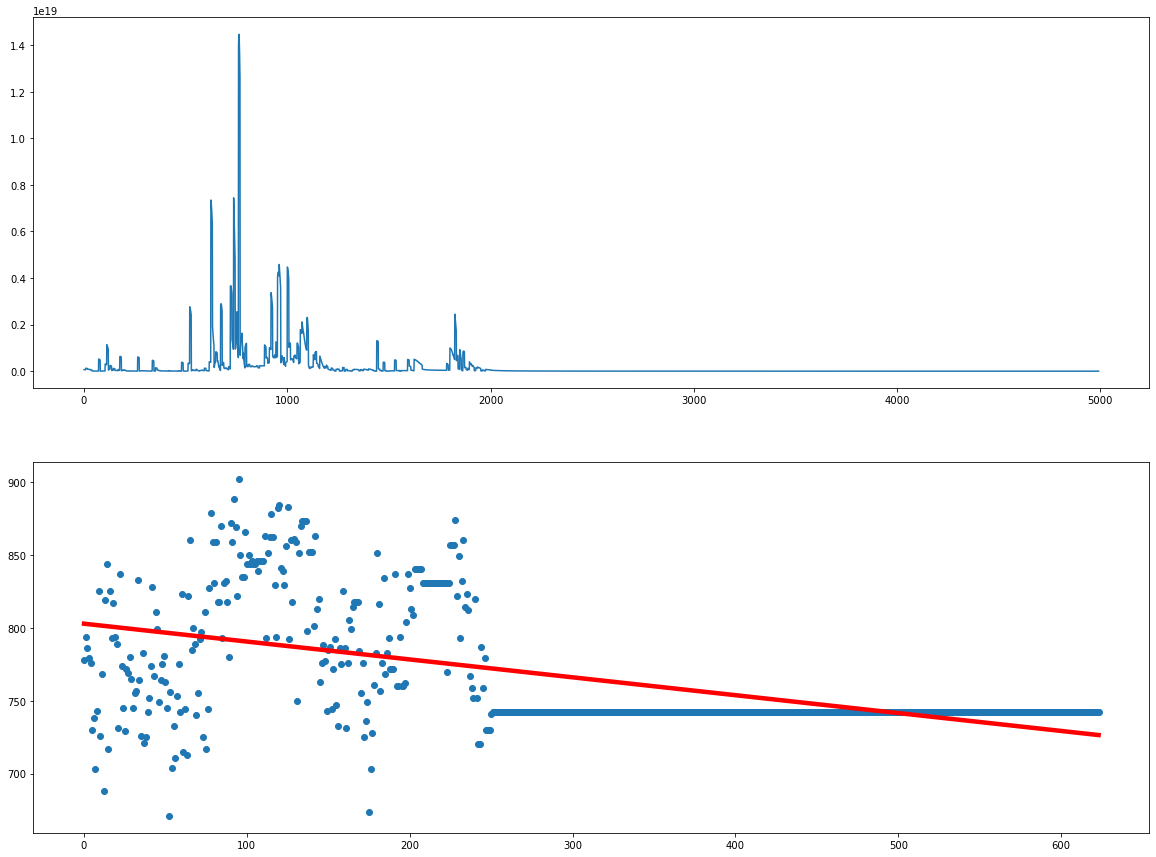

1
Epoch 625: Current Learning Rate: [0.0006178636817162115, 0.004413312012258644], Current Success Rate: 742


/var/folders/tp/g5d5jn1j0x3d60w7kqpbj6wm0000gn/T/ipykernel_75577/2845807382.py:61: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



episode  650  is done!


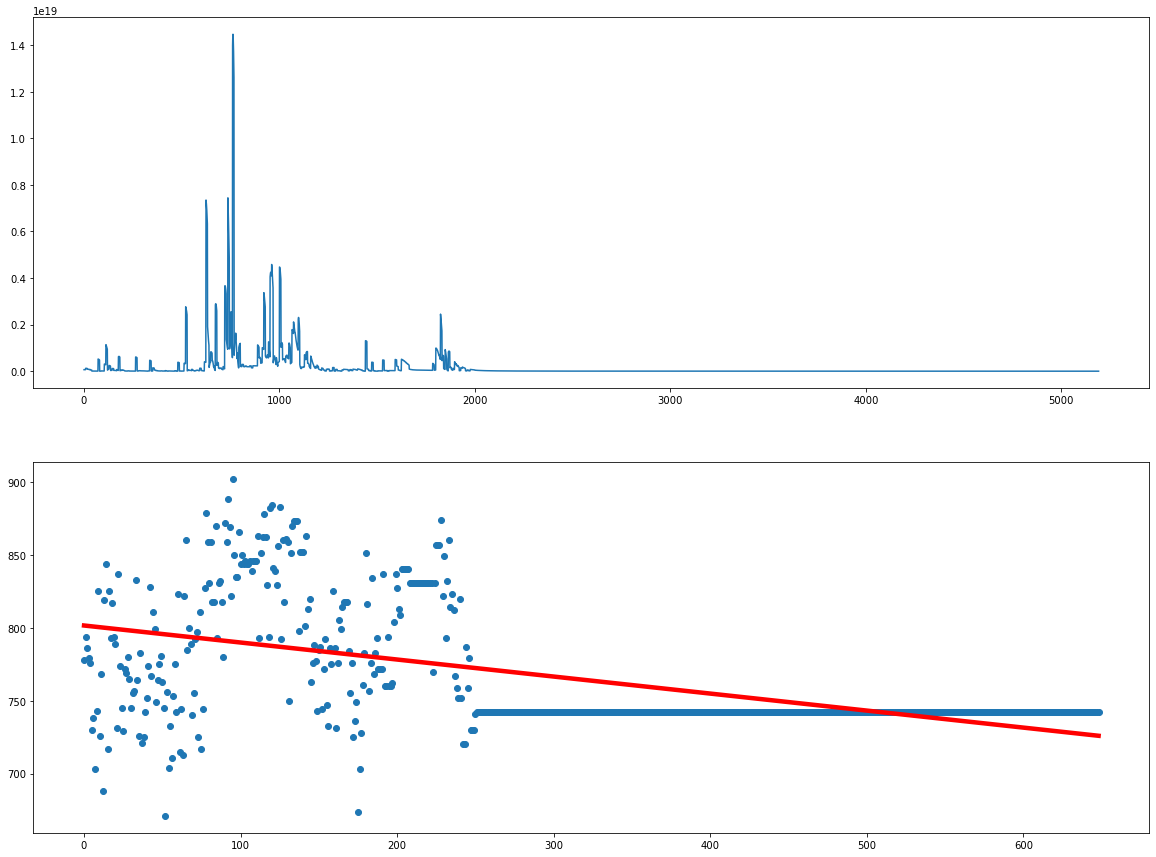

1
Epoch 650: Current Learning Rate: [0.0006147817663156144, 0.004391298330825811], Current Success Rate: 742


/var/folders/tp/g5d5jn1j0x3d60w7kqpbj6wm0000gn/T/ipykernel_75577/2845807382.py:61: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



episode  675  is done!


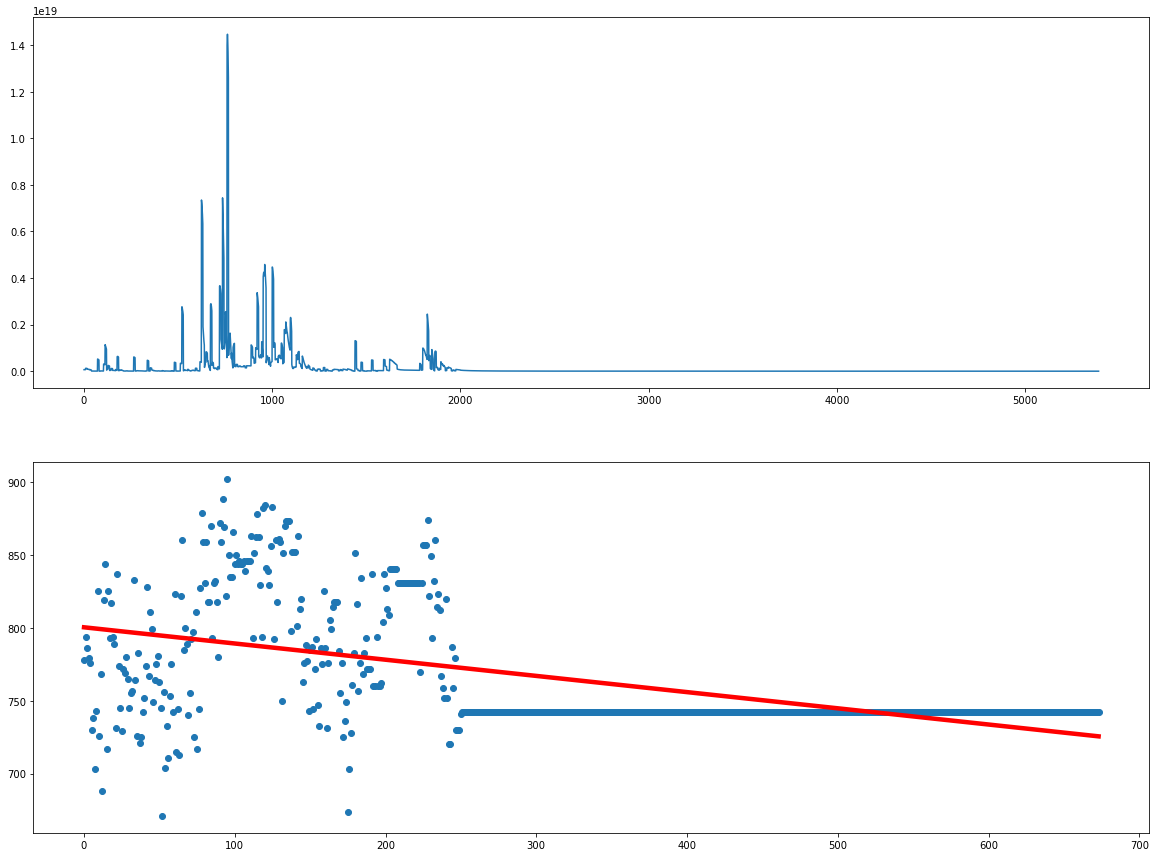

1
Epoch 675: Current Learning Rate: [0.0006117152235656807, 0.00436939445404057], Current Success Rate: 742


/var/folders/tp/g5d5jn1j0x3d60w7kqpbj6wm0000gn/T/ipykernel_75577/2845807382.py:61: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



episode  700  is done!


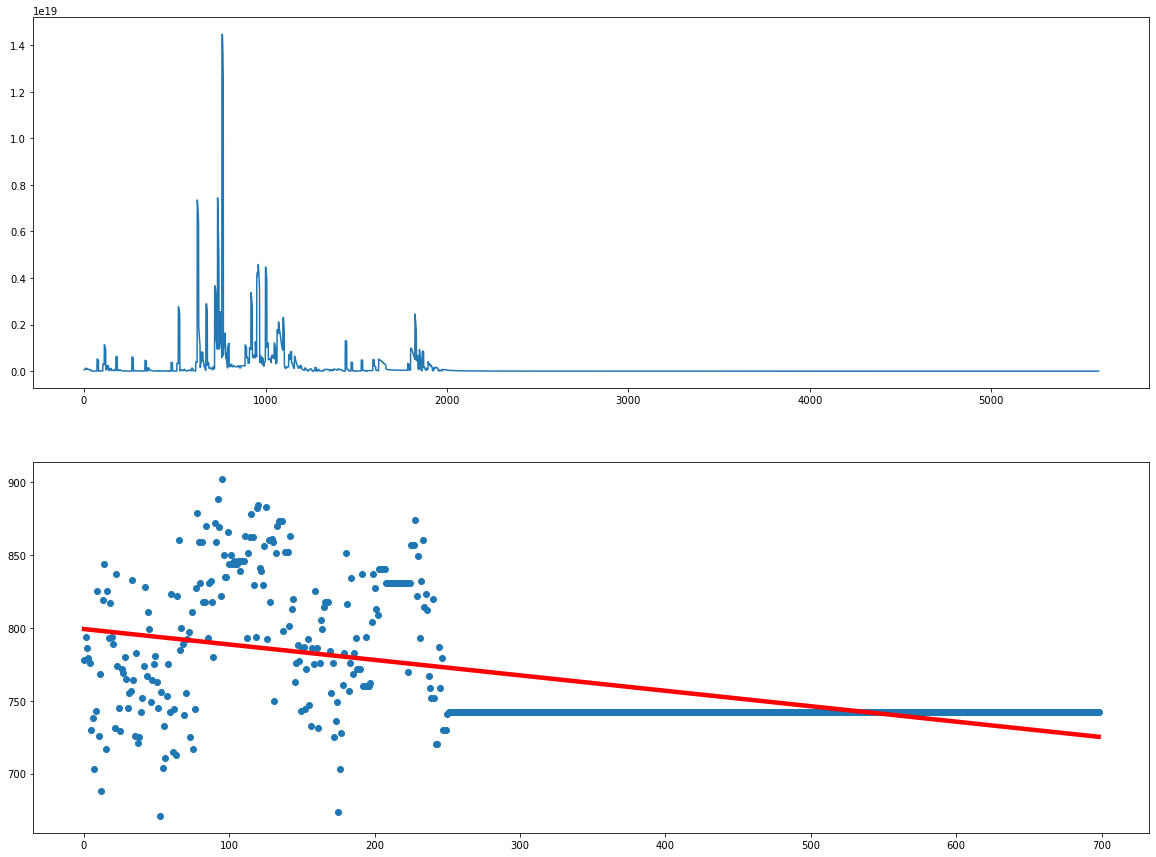

1
Epoch 700: Current Learning Rate: [0.0006086639767873461, 0.004347599834195323], Current Success Rate: 742


/var/folders/tp/g5d5jn1j0x3d60w7kqpbj6wm0000gn/T/ipykernel_75577/2845807382.py:61: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



episode  725  is done!


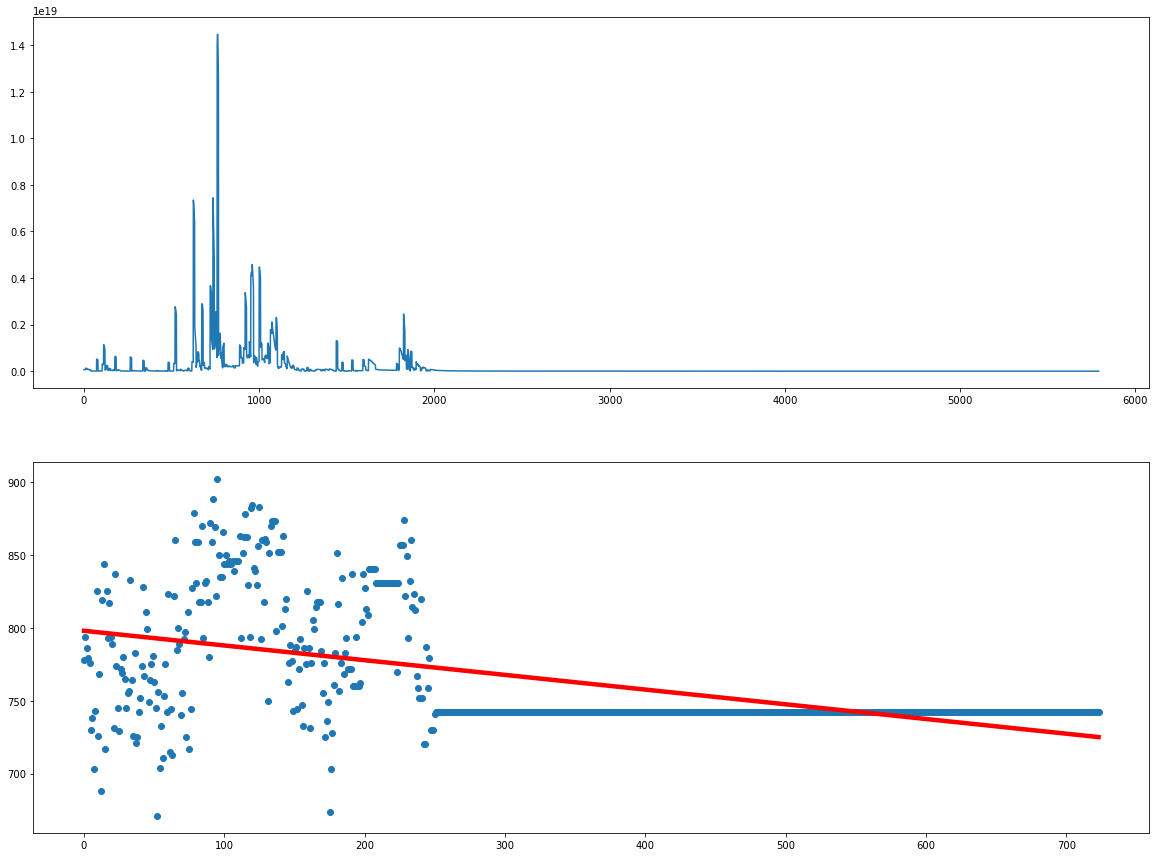

1
Epoch 725: Current Learning Rate: [0.000605627949684023, 0.004325913926314443], Current Success Rate: 742


/var/folders/tp/g5d5jn1j0x3d60w7kqpbj6wm0000gn/T/ipykernel_75577/2845807382.py:61: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



episode  750  is done!


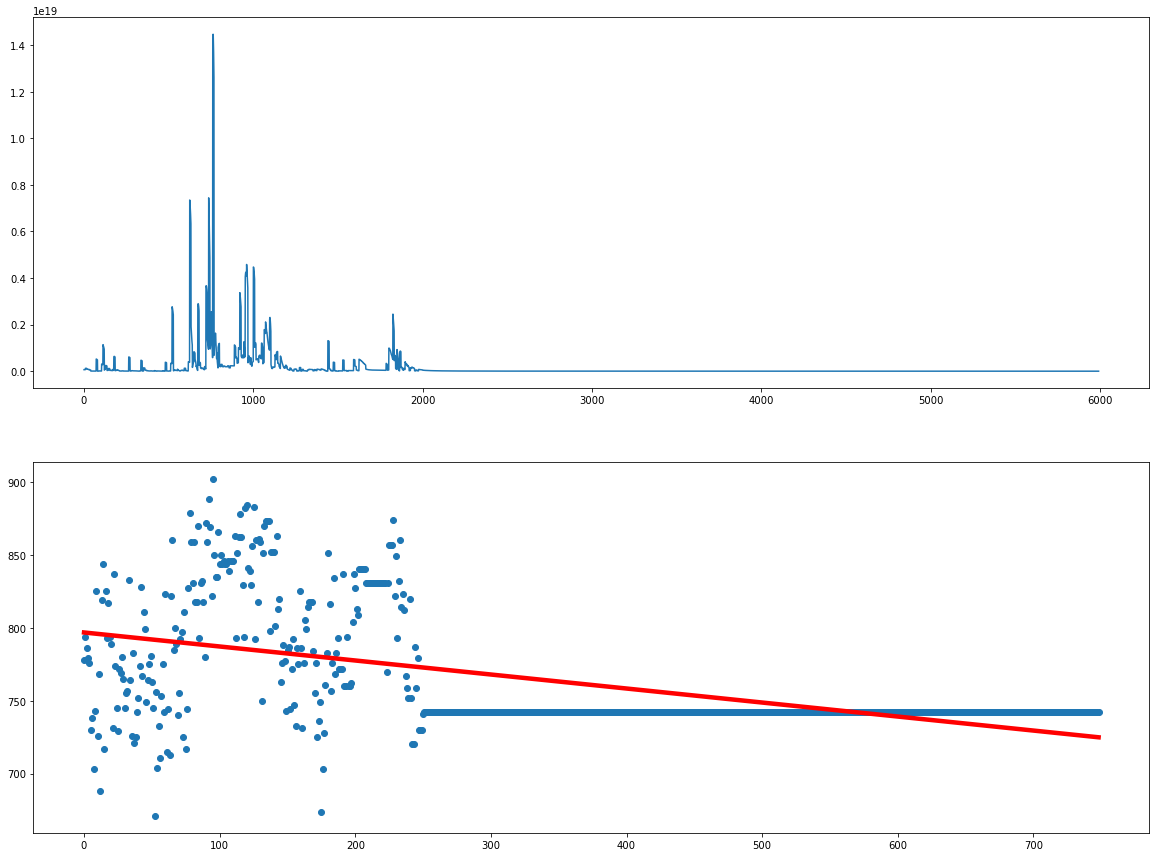

1
Epoch 750: Current Learning Rate: [0.0006026070663396926, 0.004304336188140657], Current Success Rate: 742


/var/folders/tp/g5d5jn1j0x3d60w7kqpbj6wm0000gn/T/ipykernel_75577/2845807382.py:61: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



episode  775  is done!


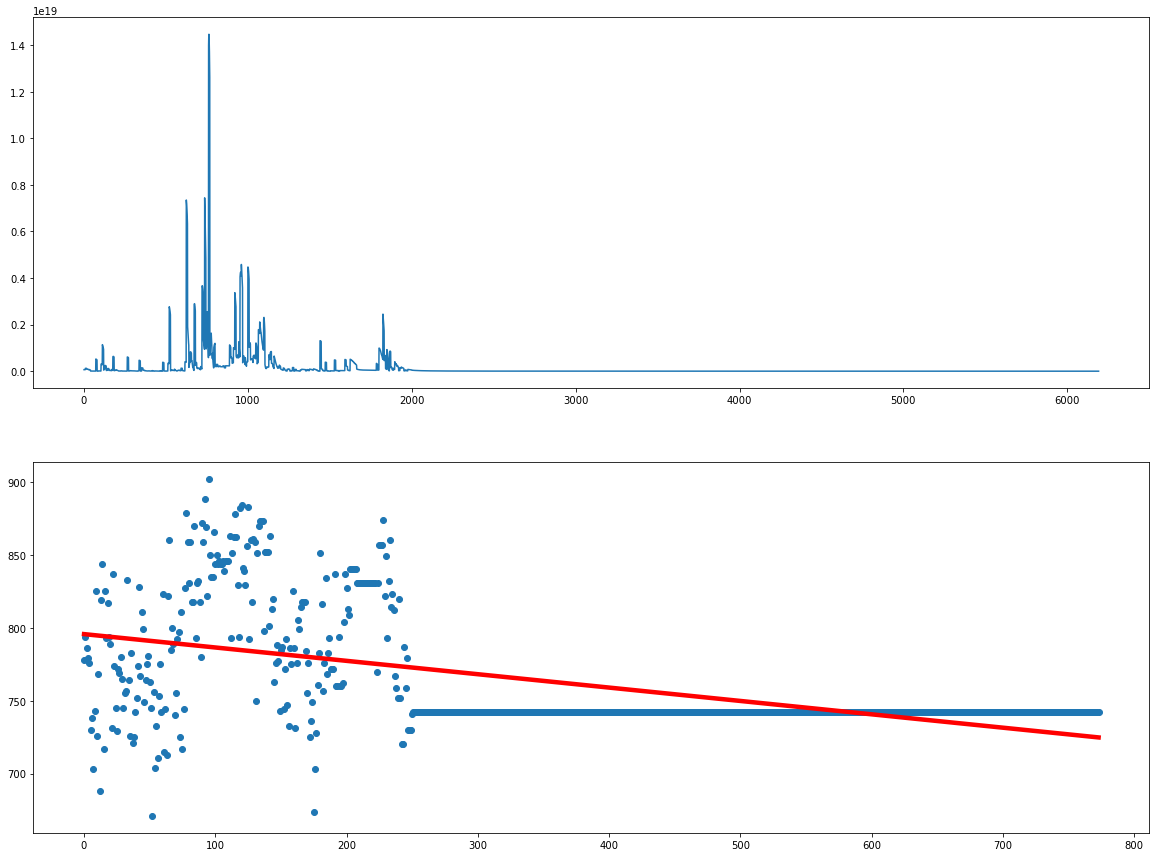

1
Epoch 775: Current Learning Rate: [0.0005996012512170071, 0.004282866080121474], Current Success Rate: 742


/var/folders/tp/g5d5jn1j0x3d60w7kqpbj6wm0000gn/T/ipykernel_75577/2845807382.py:61: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



episode  800  is done!


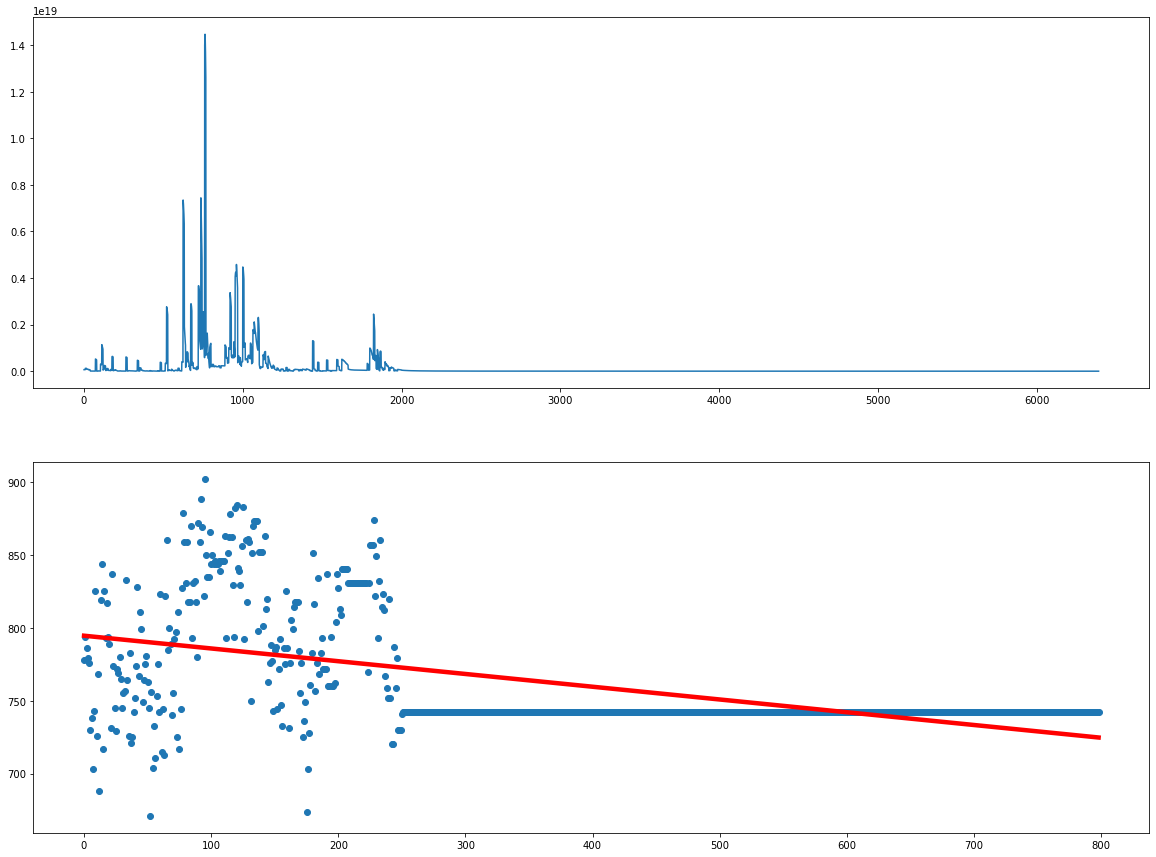

1
Epoch 800: Current Learning Rate: [0.0005966104291554, 0.004261503065395708], Current Success Rate: 742


/var/folders/tp/g5d5jn1j0x3d60w7kqpbj6wm0000gn/T/ipykernel_75577/2845807382.py:61: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



episode  825  is done!


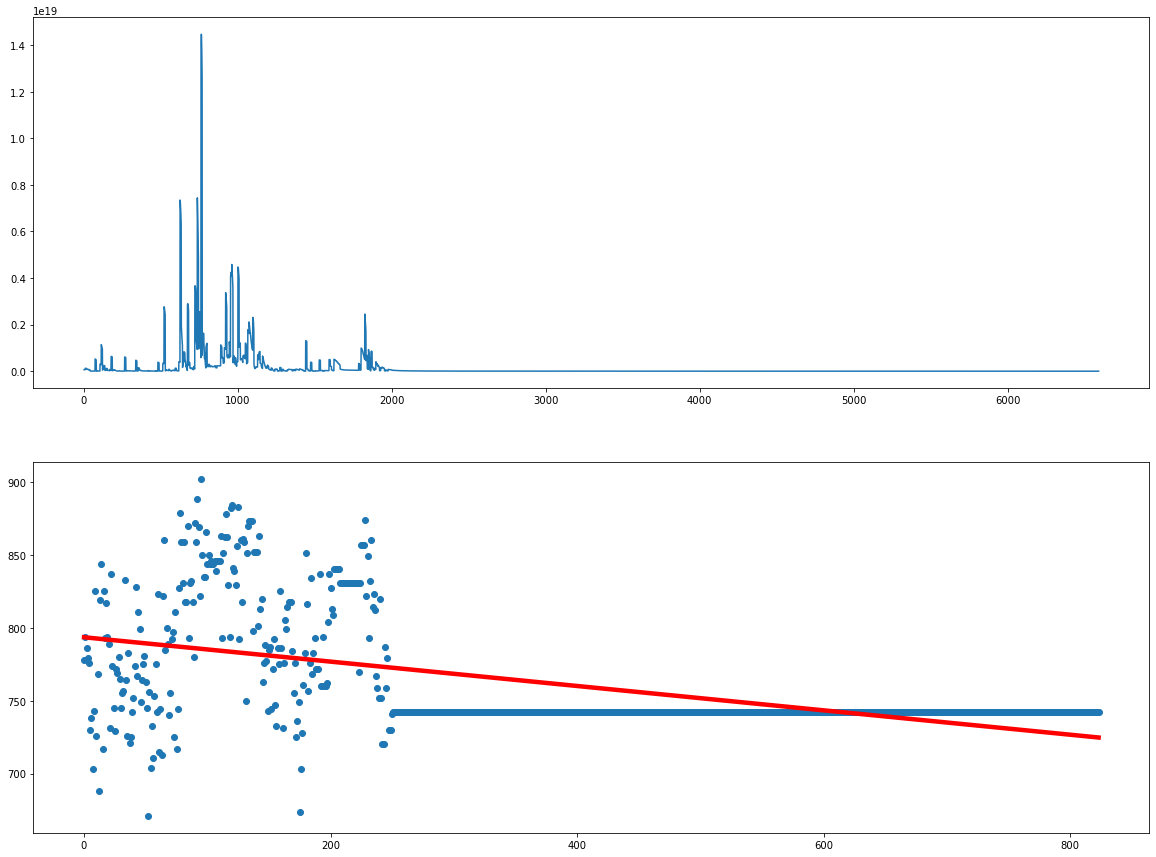

1
Epoch 825: Current Learning Rate: [0.0005936345253692067, 0.004240246609780041], Current Success Rate: 742


/var/folders/tp/g5d5jn1j0x3d60w7kqpbj6wm0000gn/T/ipykernel_75577/2845807382.py:61: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



episode  850  is done!


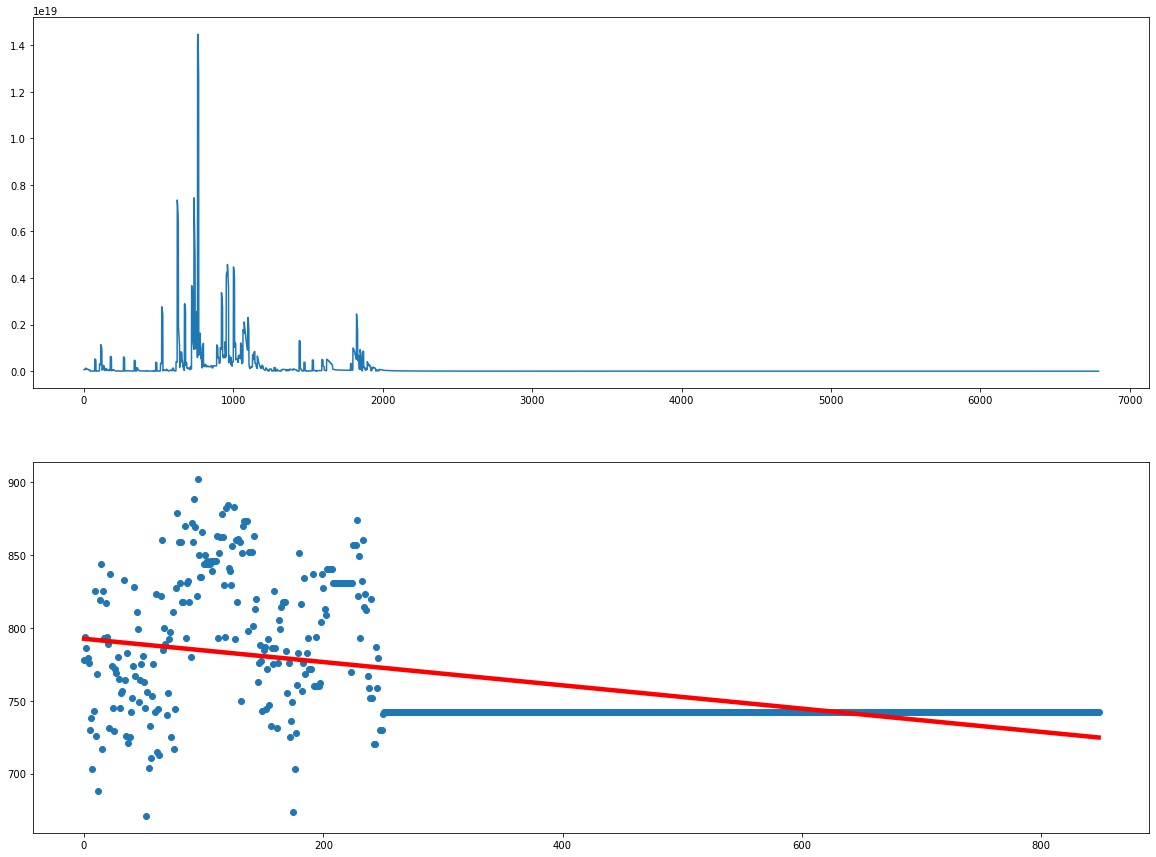

1
Epoch 850: Current Learning Rate: [0.0005906734654457954, 0.0042190961817556724], Current Success Rate: 742


/var/folders/tp/g5d5jn1j0x3d60w7kqpbj6wm0000gn/T/ipykernel_75577/2845807382.py:61: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



episode  875  is done!


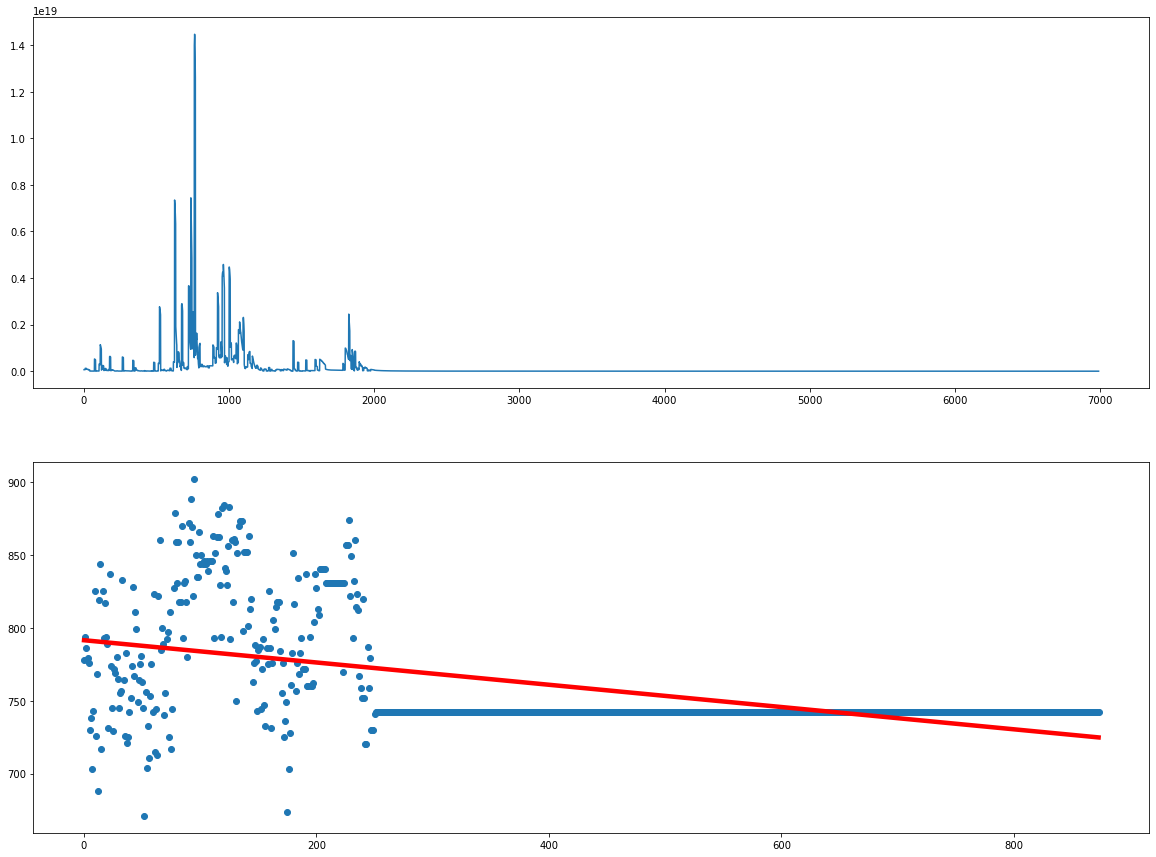

1
Epoch 875: Current Learning Rate: [0.0005877271753437055, 0.0041980512524550295], Current Success Rate: 742


/var/folders/tp/g5d5jn1j0x3d60w7kqpbj6wm0000gn/T/ipykernel_75577/2845807382.py:61: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



episode  900  is done!


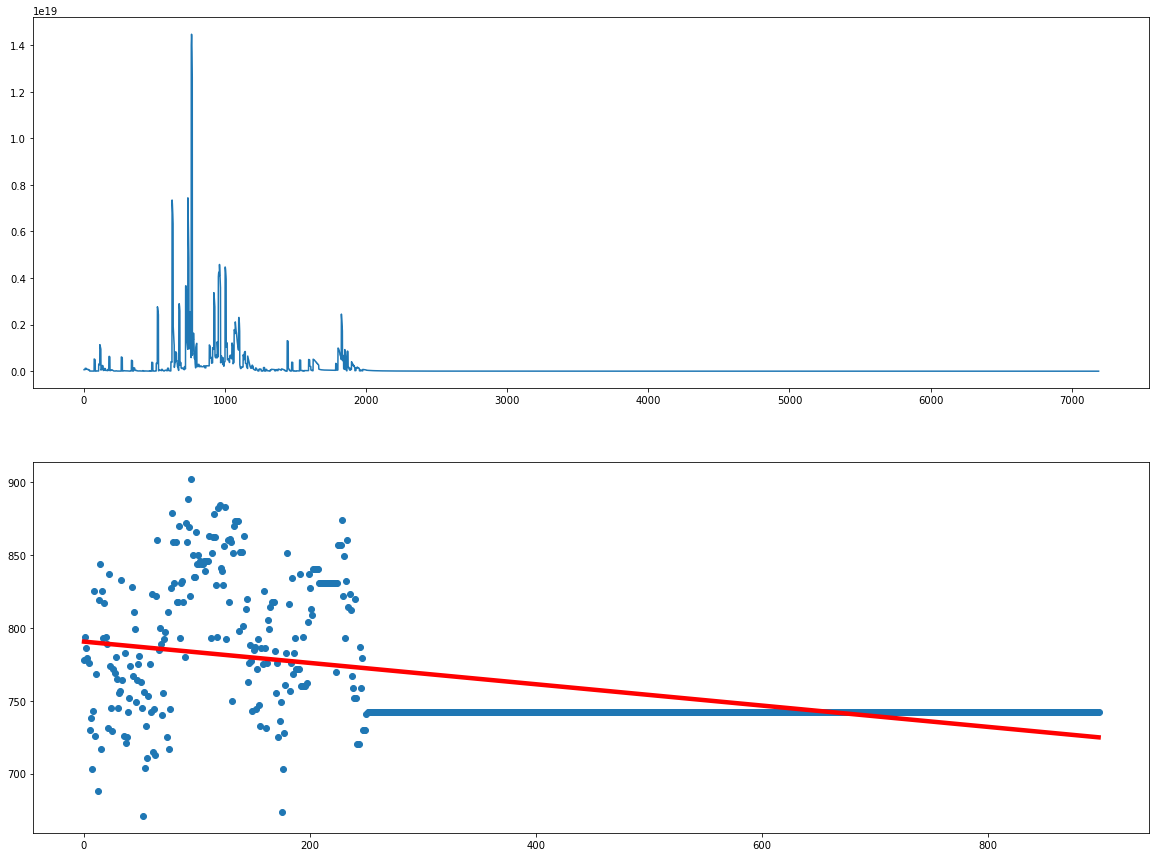

1
Epoch 900: Current Learning Rate: [0.0005847955813907969, 0.00417711129564854], Current Success Rate: 742


/var/folders/tp/g5d5jn1j0x3d60w7kqpbj6wm0000gn/T/ipykernel_75577/2845807382.py:61: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



episode  925  is done!


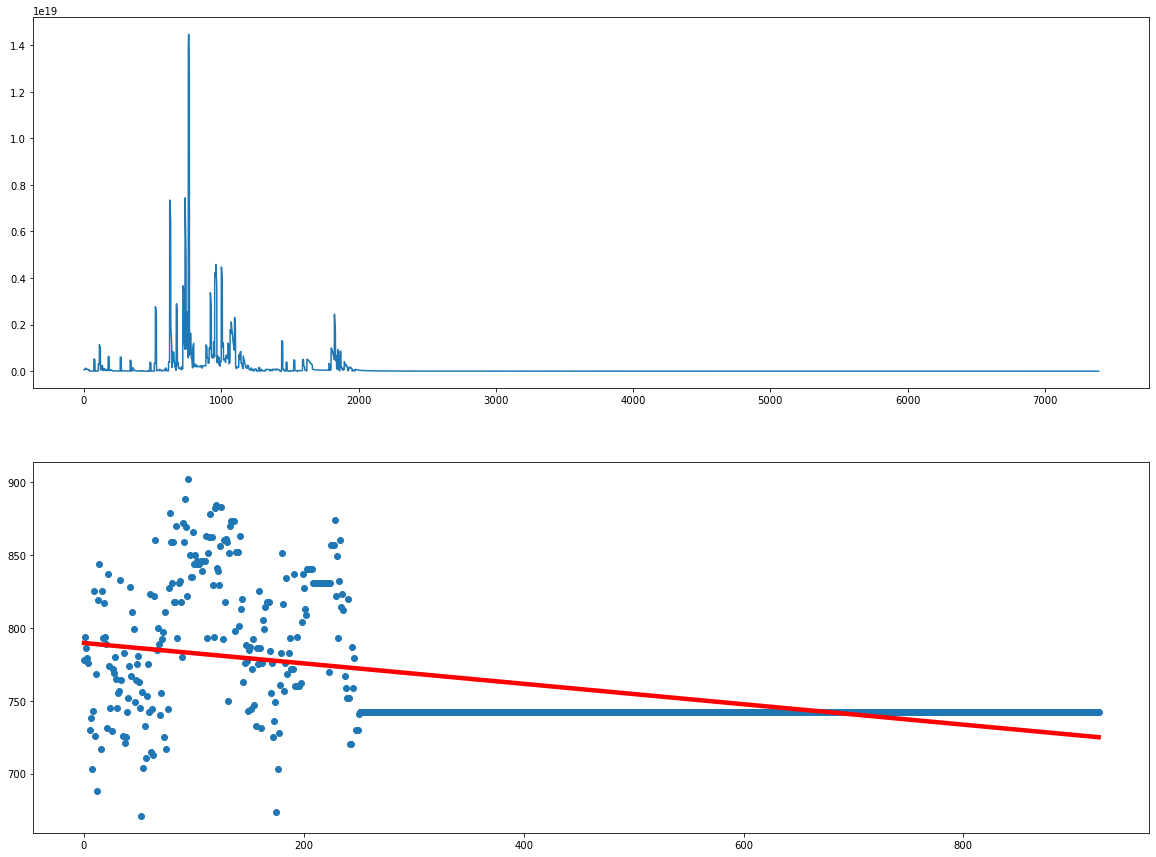

1
Epoch 925: Current Learning Rate: [0.0005818786102824075, 0.004156275787731474], Current Success Rate: 742


/var/folders/tp/g5d5jn1j0x3d60w7kqpbj6wm0000gn/T/ipykernel_75577/2845807382.py:61: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



episode  950  is done!


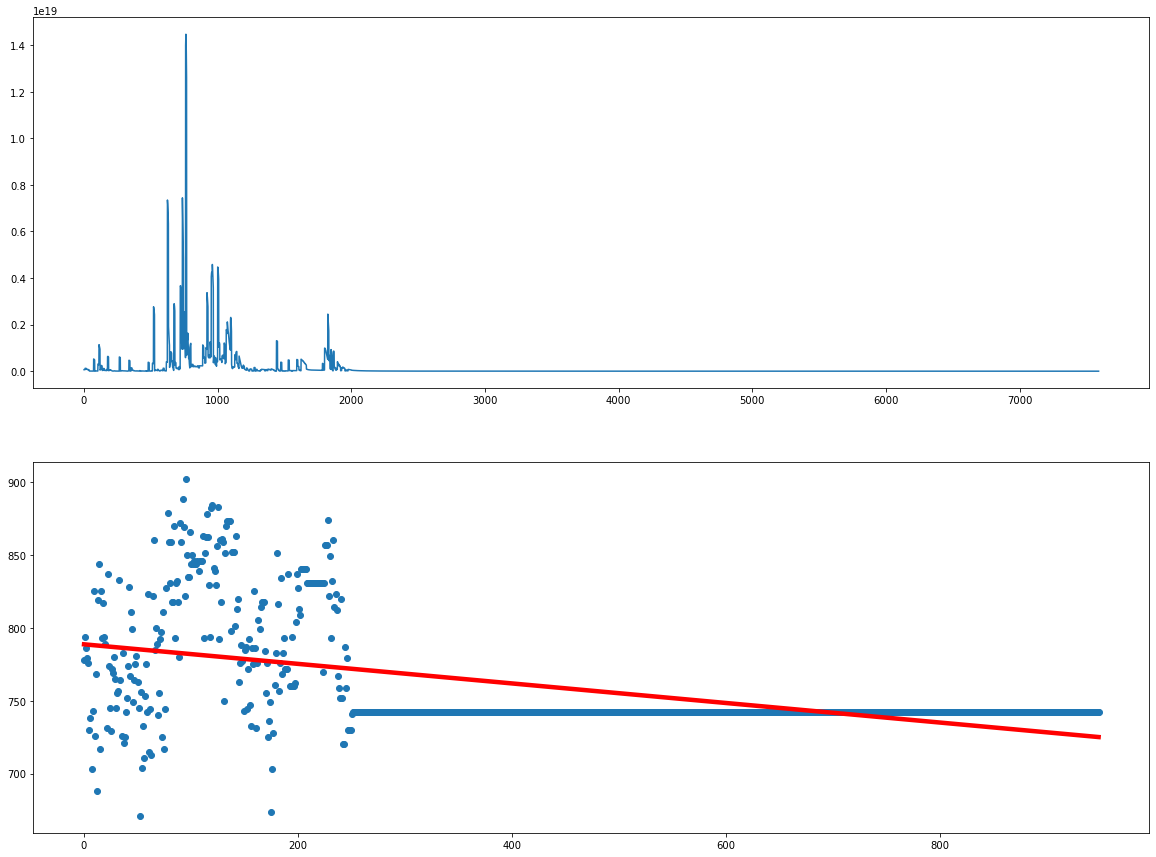

1
Epoch 950: Current Learning Rate: [0.0005789761890795201, 0.004135544207710848], Current Success Rate: 742


/var/folders/tp/g5d5jn1j0x3d60w7kqpbj6wm0000gn/T/ipykernel_75577/2845807382.py:61: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



episode  975  is done!


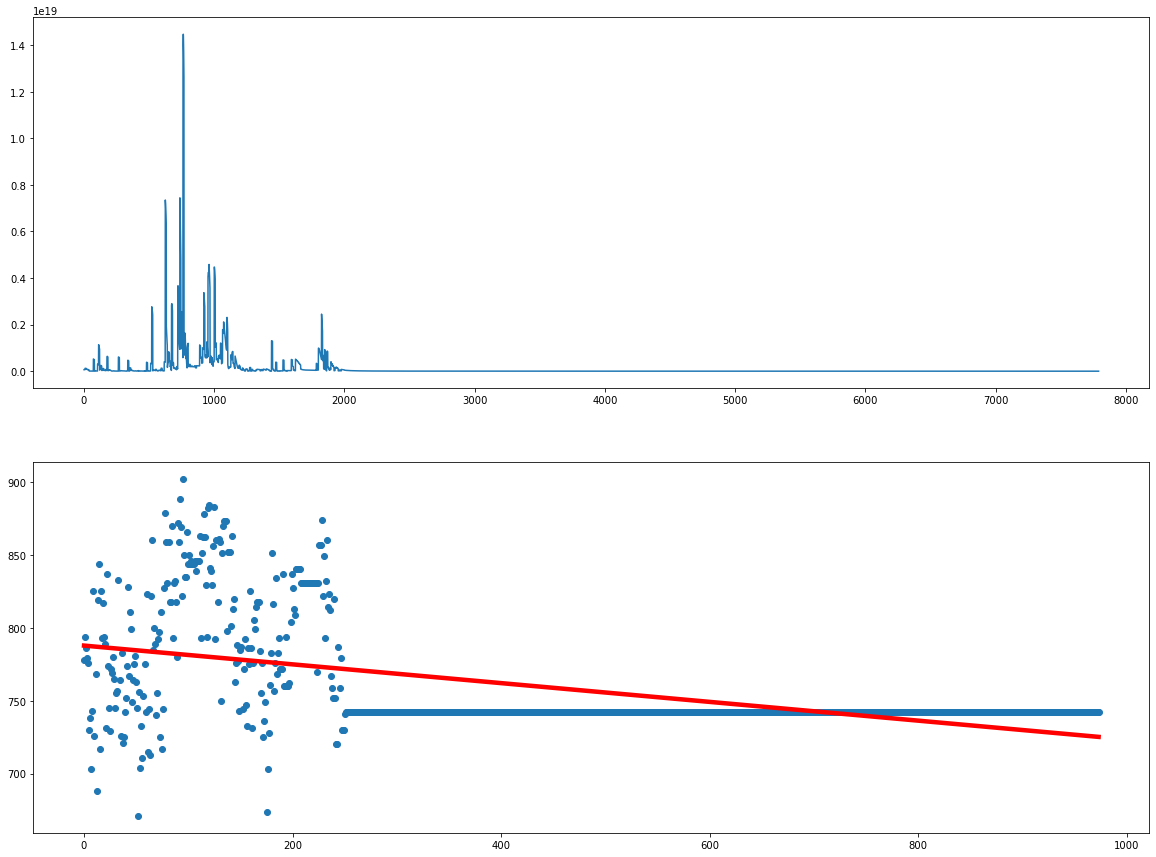

1
Epoch 975: Current Learning Rate: [0.0005760882452069384, 0.004114916037192409], Current Success Rate: 742


/var/folders/tp/g5d5jn1j0x3d60w7kqpbj6wm0000gn/T/ipykernel_75577/2845807382.py:61: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



episode  1000  is done!


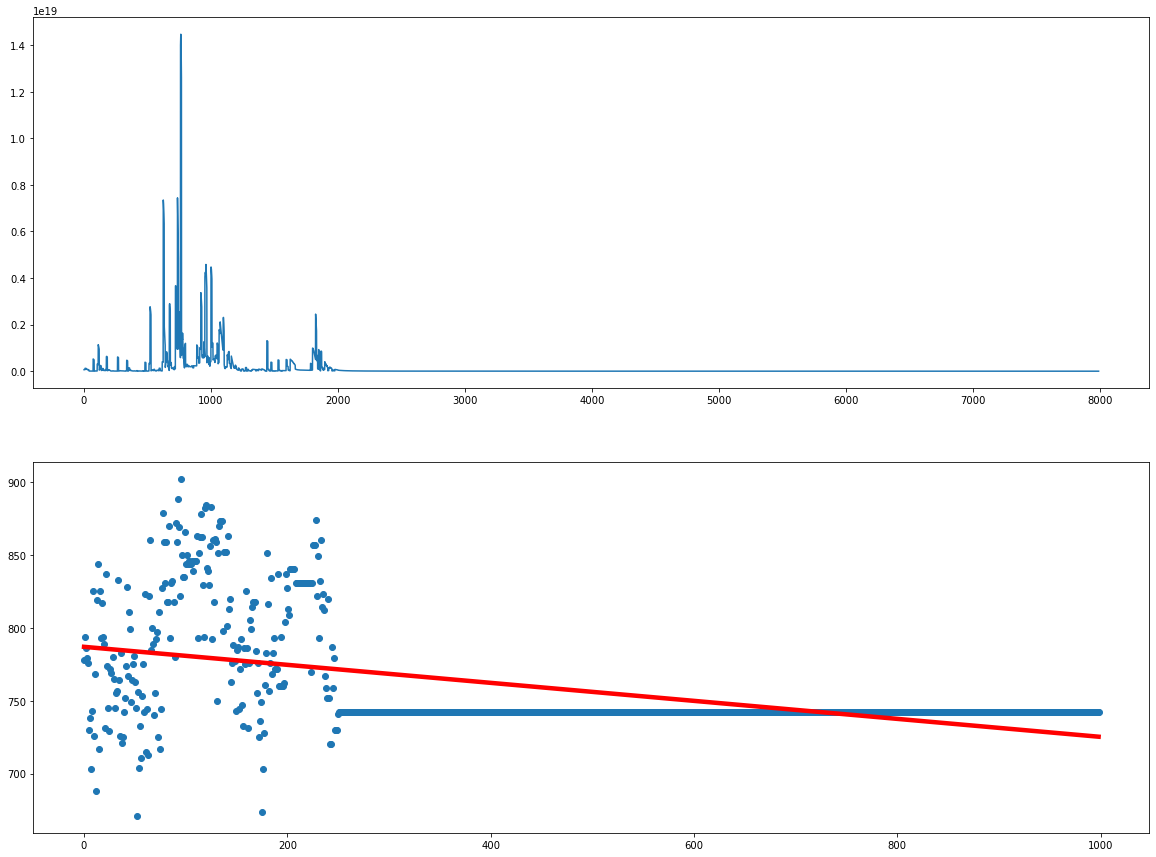

1
Epoch 1000: Current Learning Rate: [0.000573214706451473, 0.0040943907603676576], Current Success Rate: 742


/var/folders/tp/g5d5jn1j0x3d60w7kqpbj6wm0000gn/T/ipykernel_75577/2845807382.py:61: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



episode  1025  is done!


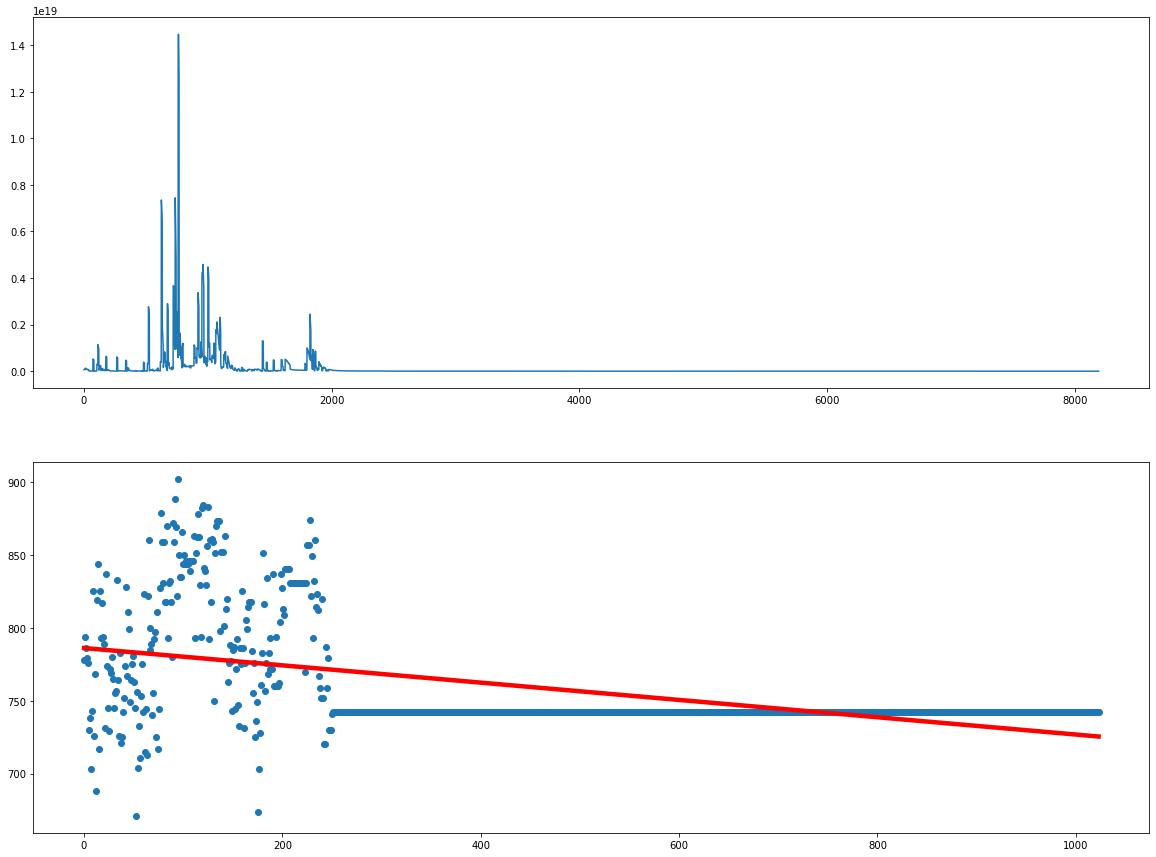

1
Epoch 1025: Current Learning Rate: [0.0005703555009601348, 0.004073967864000957], Current Success Rate: 742


/var/folders/tp/g5d5jn1j0x3d60w7kqpbj6wm0000gn/T/ipykernel_75577/2845807382.py:61: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



episode  1050  is done!


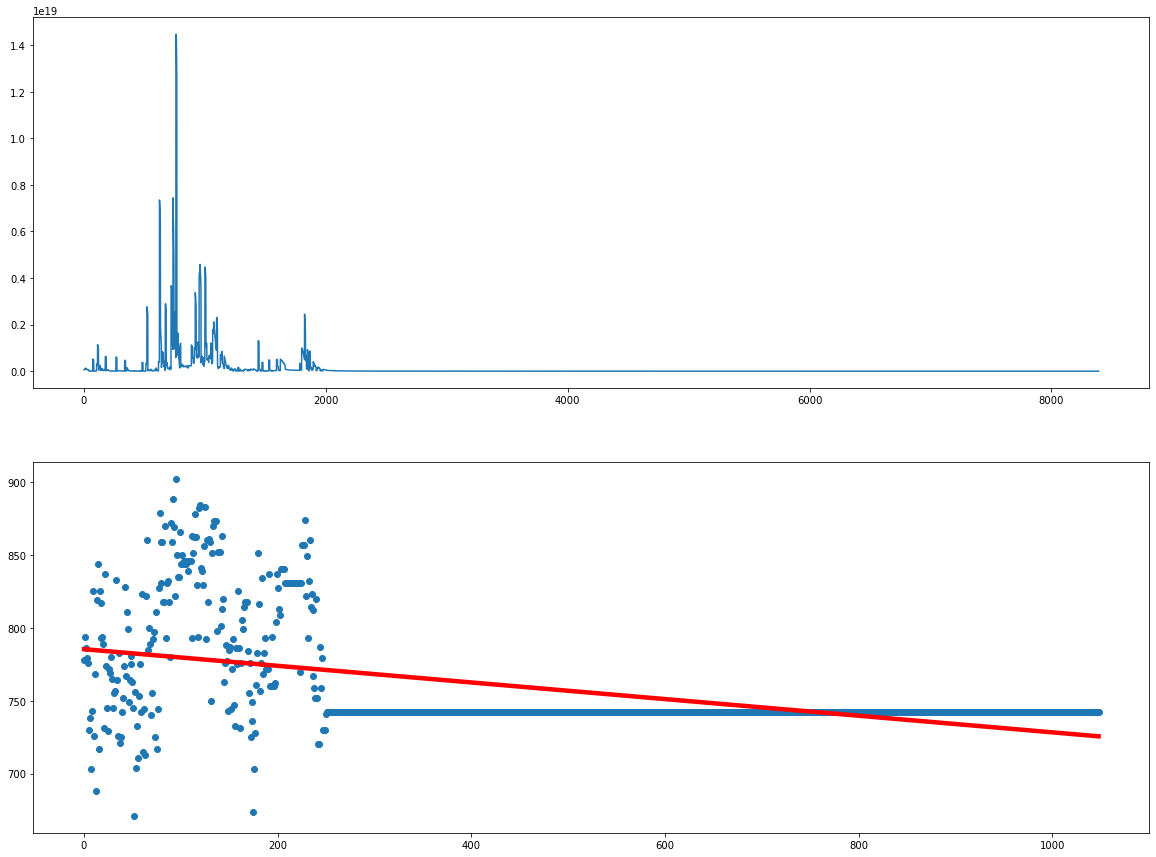

1
Epoch 1050: Current Learning Rate: [0.000567510557238339, 0.004053646837416703], Current Success Rate: 742


/var/folders/tp/g5d5jn1j0x3d60w7kqpbj6wm0000gn/T/ipykernel_75577/2845807382.py:61: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



episode  1075  is done!


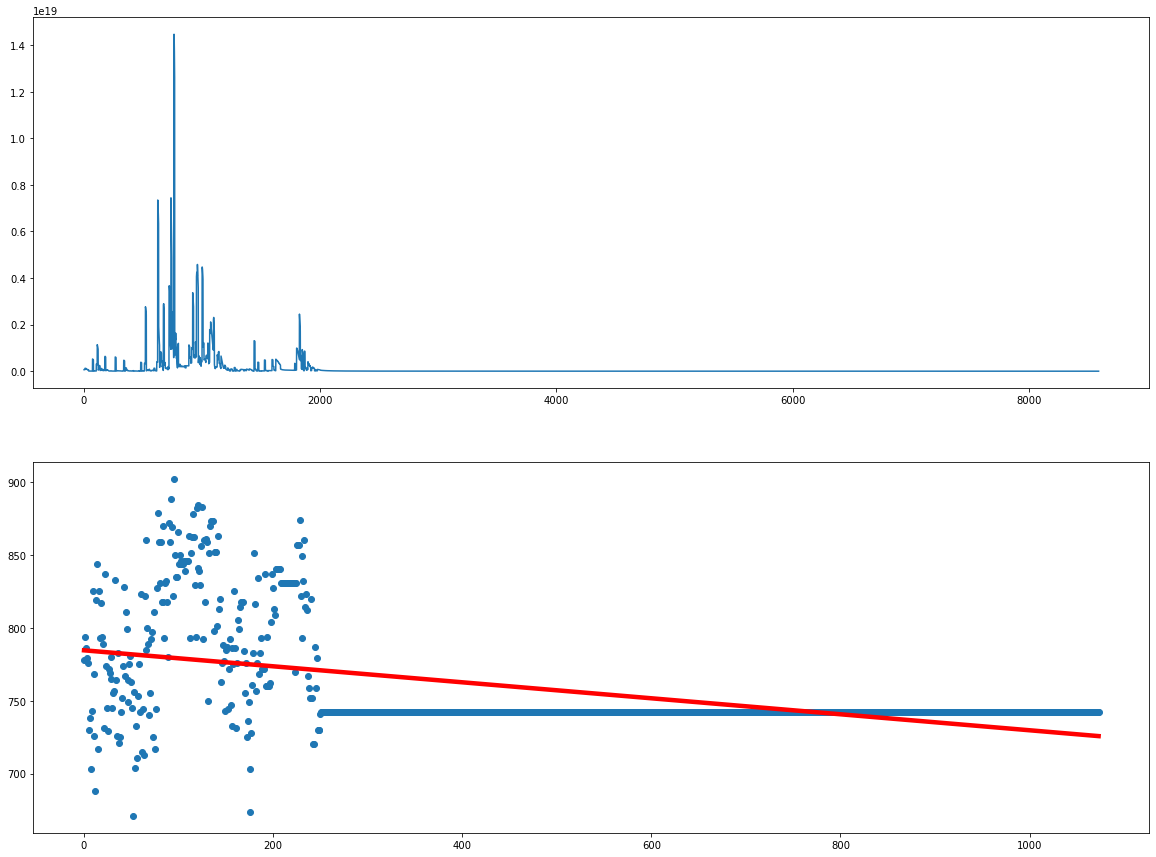

1
Epoch 1075: Current Learning Rate: [0.0005646798041481172, 0.004033427172486547], Current Success Rate: 742


/var/folders/tp/g5d5jn1j0x3d60w7kqpbj6wm0000gn/T/ipykernel_75577/2845807382.py:61: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



episode  1100  is done!


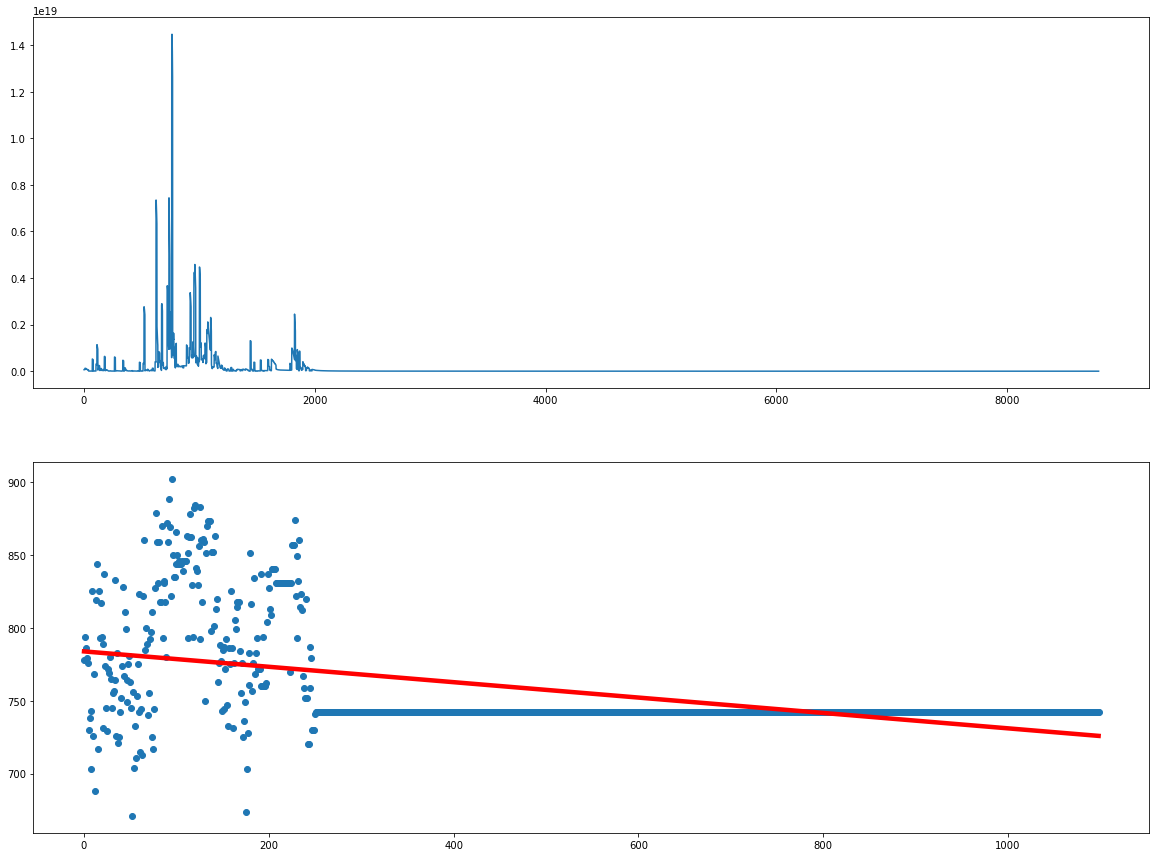

1
Epoch 1100: Current Learning Rate: [0.0005618631709063379, 0.0040133083636166925], Current Success Rate: 742


/var/folders/tp/g5d5jn1j0x3d60w7kqpbj6wm0000gn/T/ipykernel_75577/2845807382.py:61: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



episode  1125  is done!


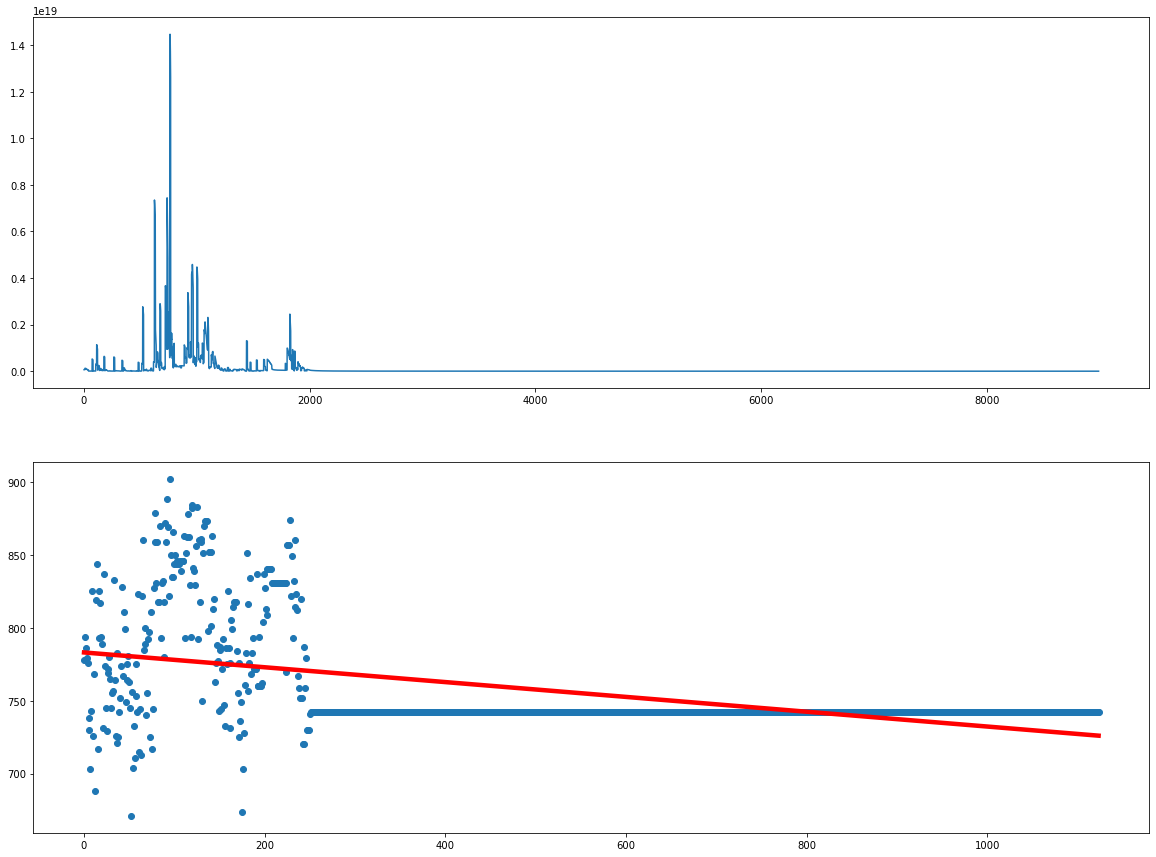

1
Epoch 1125: Current Learning Rate: [0.0005590605870829374, 0.003993289907735262], Current Success Rate: 742


/var/folders/tp/g5d5jn1j0x3d60w7kqpbj6wm0000gn/T/ipykernel_75577/2845807382.py:61: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



episode  1150  is done!


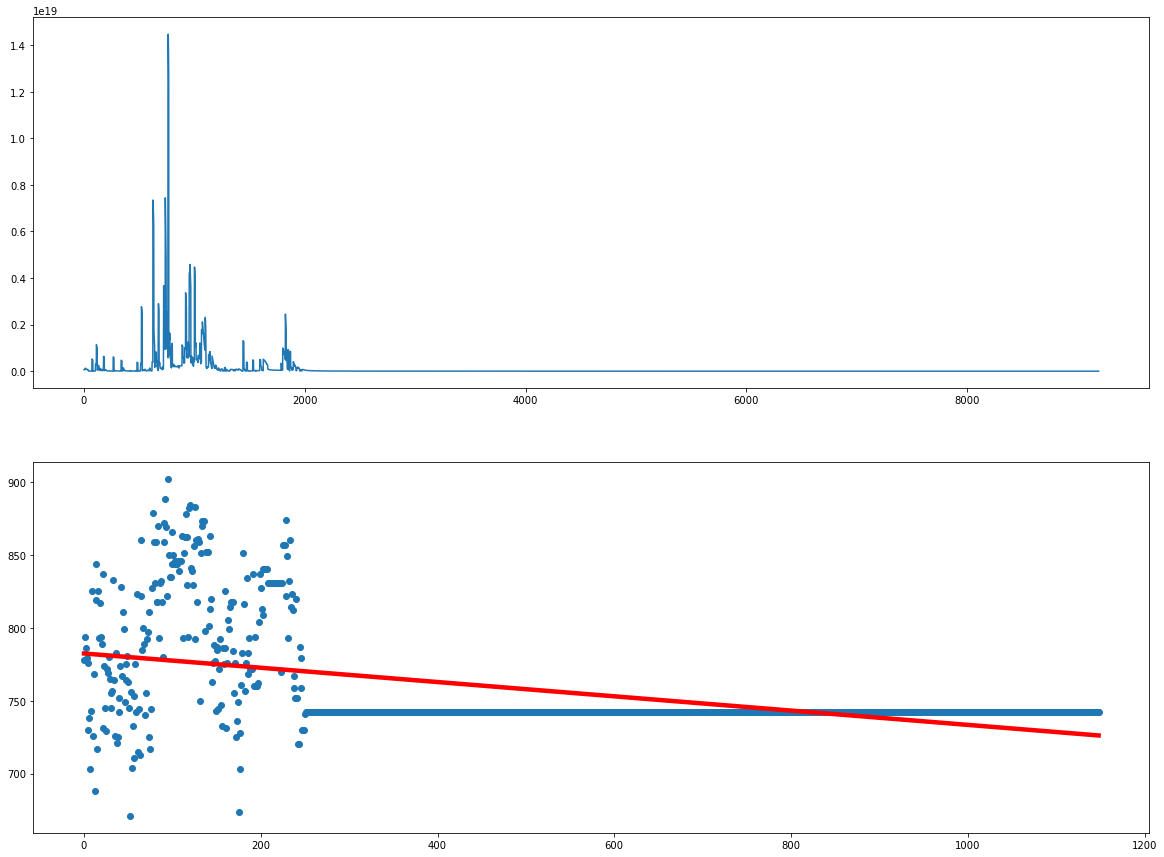

1
Epoch 1150: Current Learning Rate: [0.000556271982599159, 0.003973371304279703], Current Success Rate: 742


/var/folders/tp/g5d5jn1j0x3d60w7kqpbj6wm0000gn/T/ipykernel_75577/2845807382.py:61: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



episode  1175  is done!


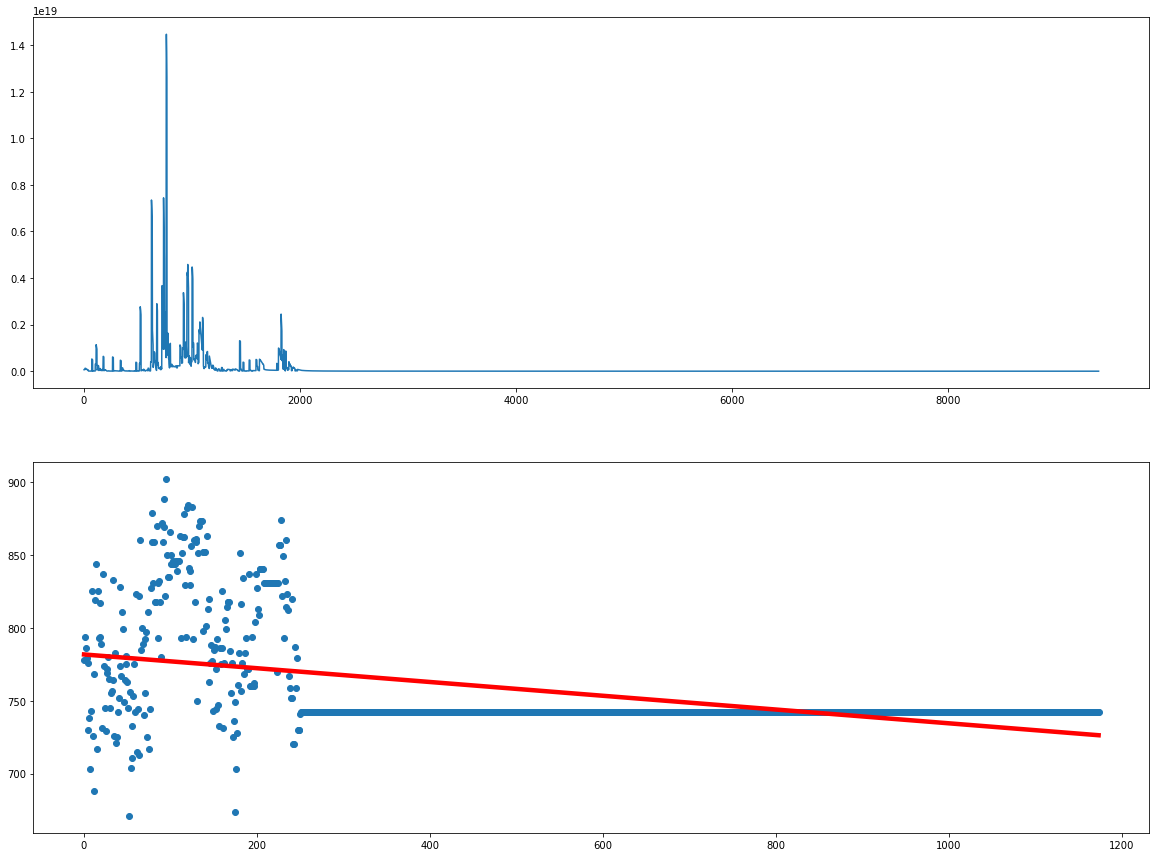

1
Epoch 1175: Current Learning Rate: [0.0005534972877257996, 0.003953552055184281], Current Success Rate: 742


/var/folders/tp/g5d5jn1j0x3d60w7kqpbj6wm0000gn/T/ipykernel_75577/2845807382.py:61: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



episode  1200  is done!


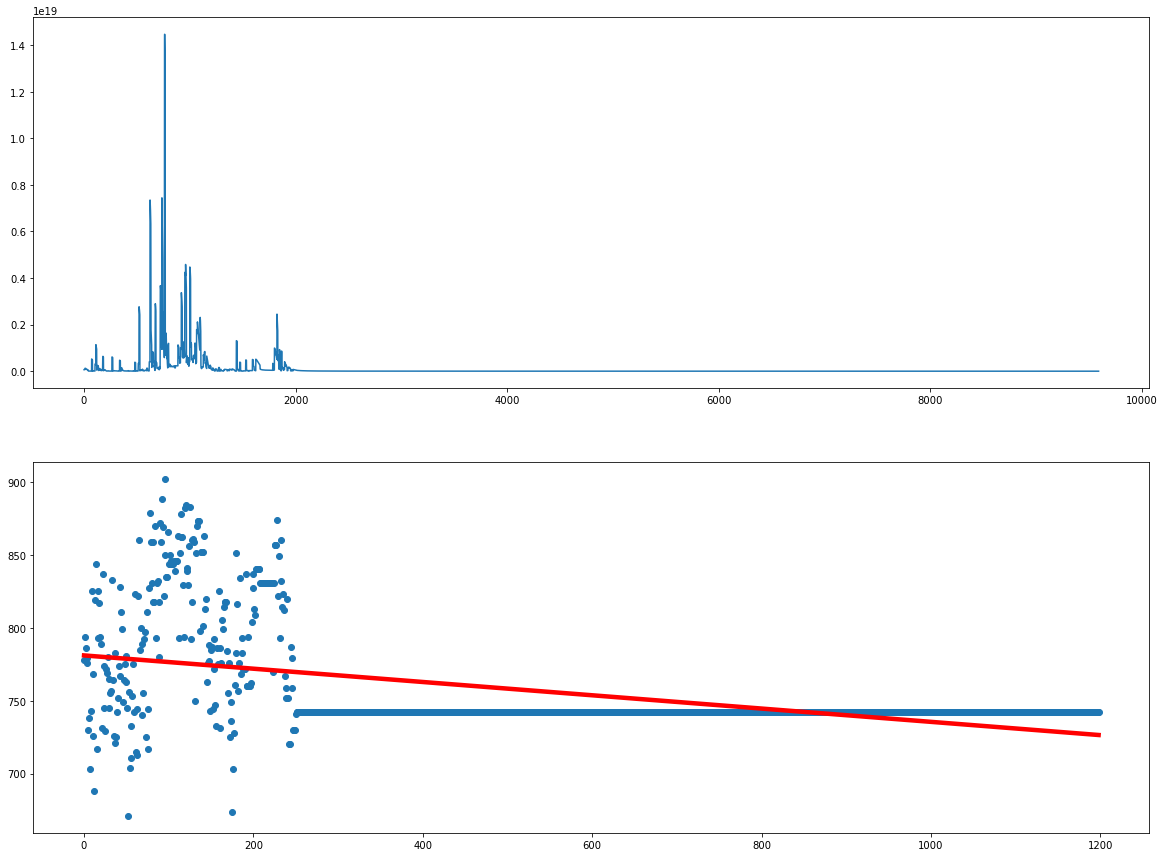

1
Epoch 1200: Current Learning Rate: [0.0005507364330814667, 0.003933831664867619], Current Success Rate: 742


/var/folders/tp/g5d5jn1j0x3d60w7kqpbj6wm0000gn/T/ipykernel_75577/2845807382.py:61: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



episode  1225  is done!


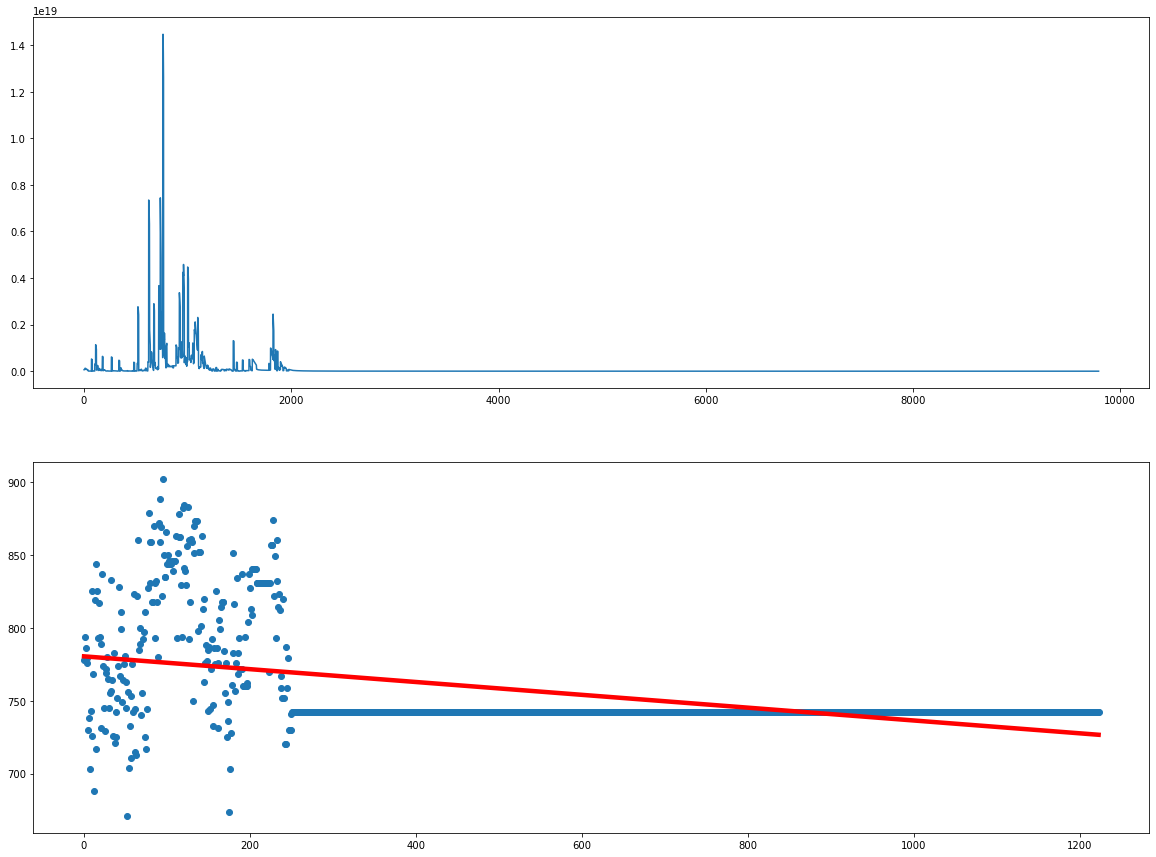

1
Epoch 1225: Current Learning Rate: [0.0005479893496308439, 0.0039142096402203135], Current Success Rate: 742


/var/folders/tp/g5d5jn1j0x3d60w7kqpbj6wm0000gn/T/ipykernel_75577/2845807382.py:61: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



episode  1250  is done!


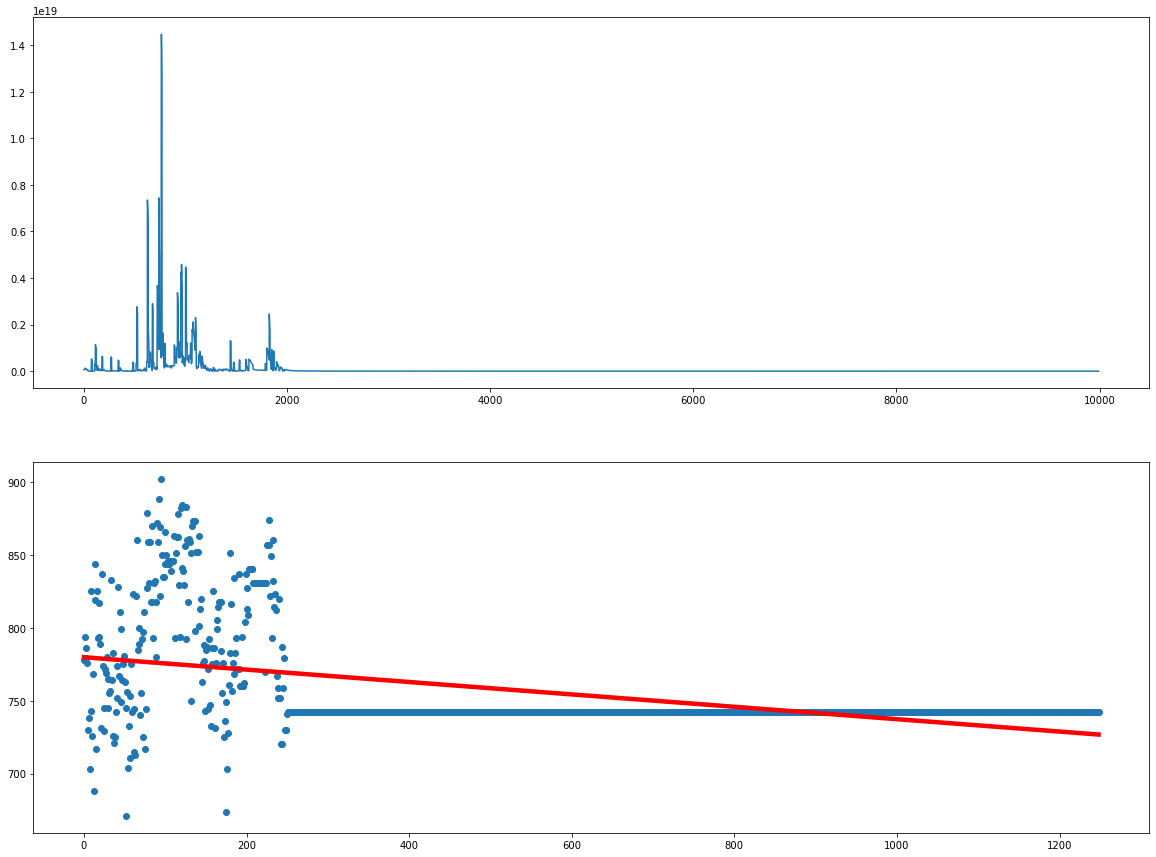

1
Epoch 1250: Current Learning Rate: [0.0005452559686829634, 0.003894685490592596], Current Success Rate: 742


/var/folders/tp/g5d5jn1j0x3d60w7kqpbj6wm0000gn/T/ipykernel_75577/2845807382.py:61: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



episode  1275  is done!


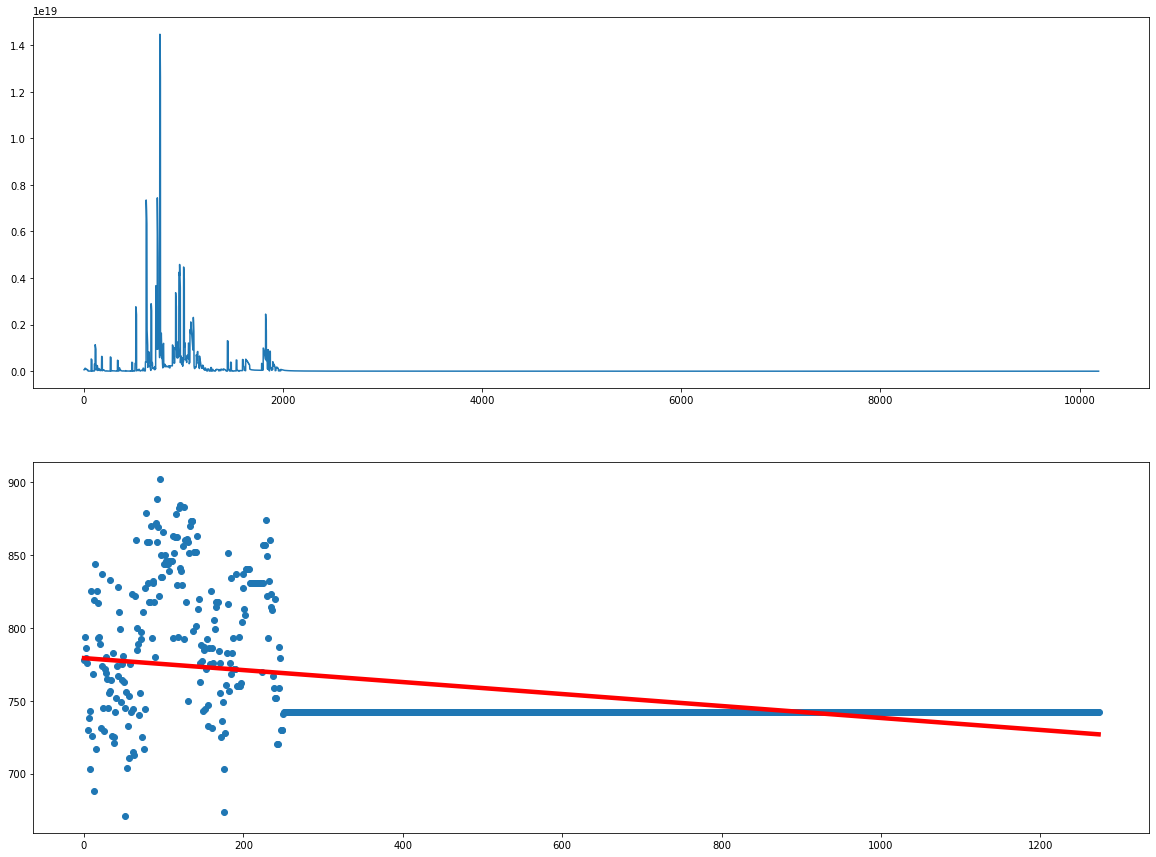

1
Epoch 1275: Current Learning Rate: [0.0005425362218894901, 0.0038752587277820715], Current Success Rate: 742


/var/folders/tp/g5d5jn1j0x3d60w7kqpbj6wm0000gn/T/ipykernel_75577/2845807382.py:61: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



episode  1300  is done!


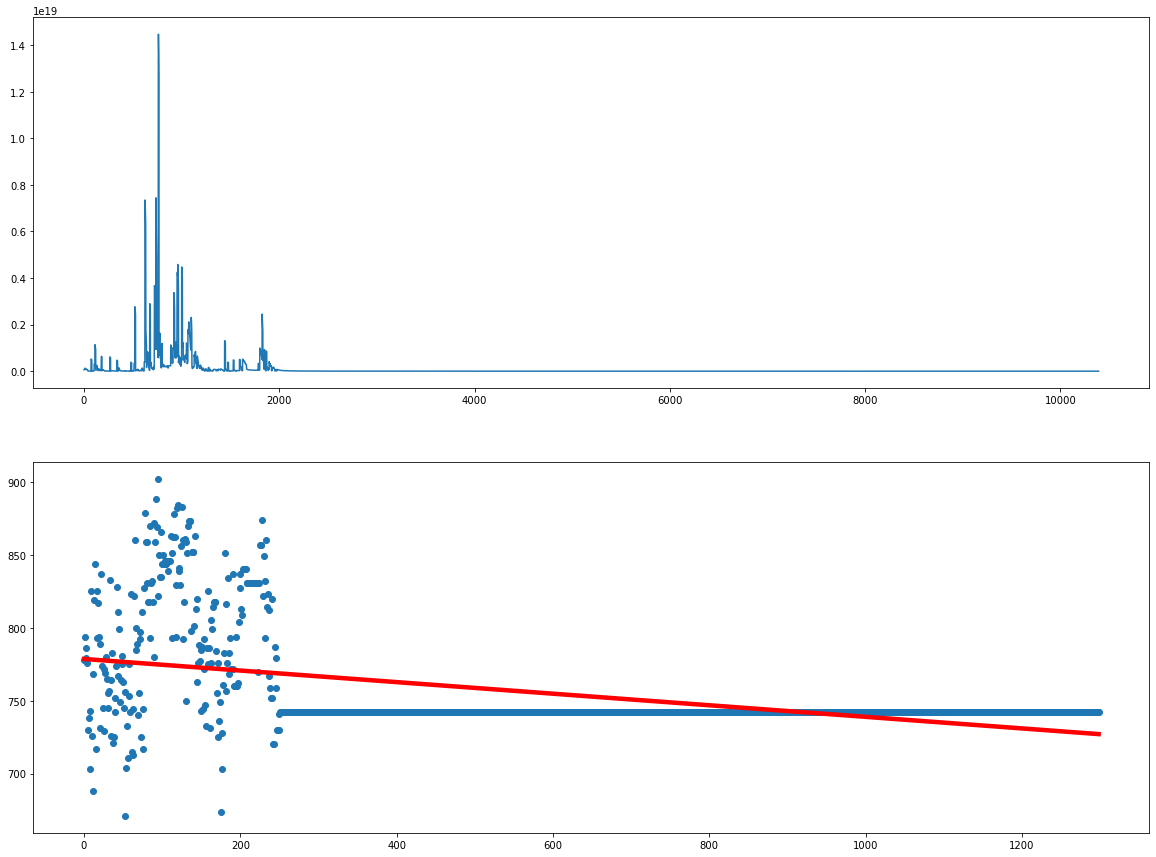

1
Epoch 1300: Current Learning Rate: [0.0005398300412430108, 0.0038559288660215056], Current Success Rate: 742


/var/folders/tp/g5d5jn1j0x3d60w7kqpbj6wm0000gn/T/ipykernel_75577/2845807382.py:61: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



episode  1325  is done!


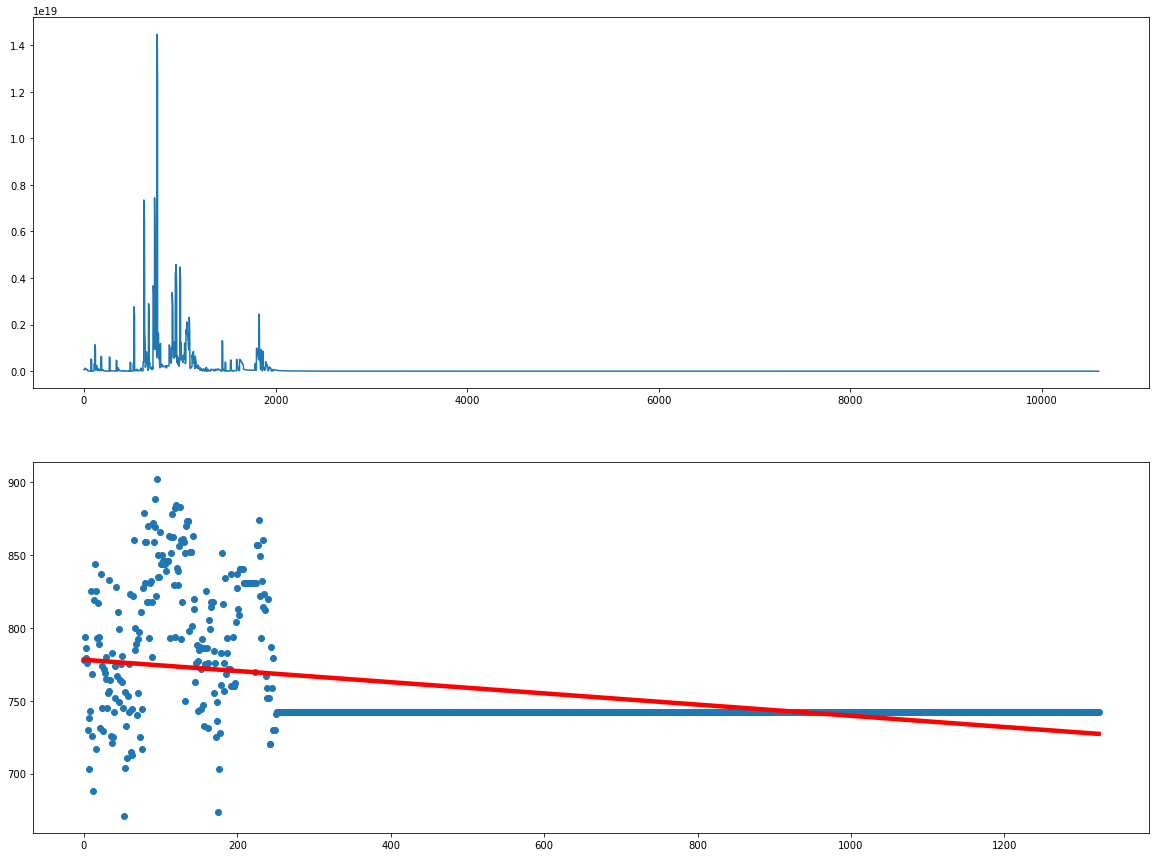

1
Epoch 1325: Current Learning Rate: [0.000537137359075335, 0.0038366954219666797], Current Success Rate: 742


/var/folders/tp/g5d5jn1j0x3d60w7kqpbj6wm0000gn/T/ipykernel_75577/2845807382.py:61: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



episode  1350  is done!


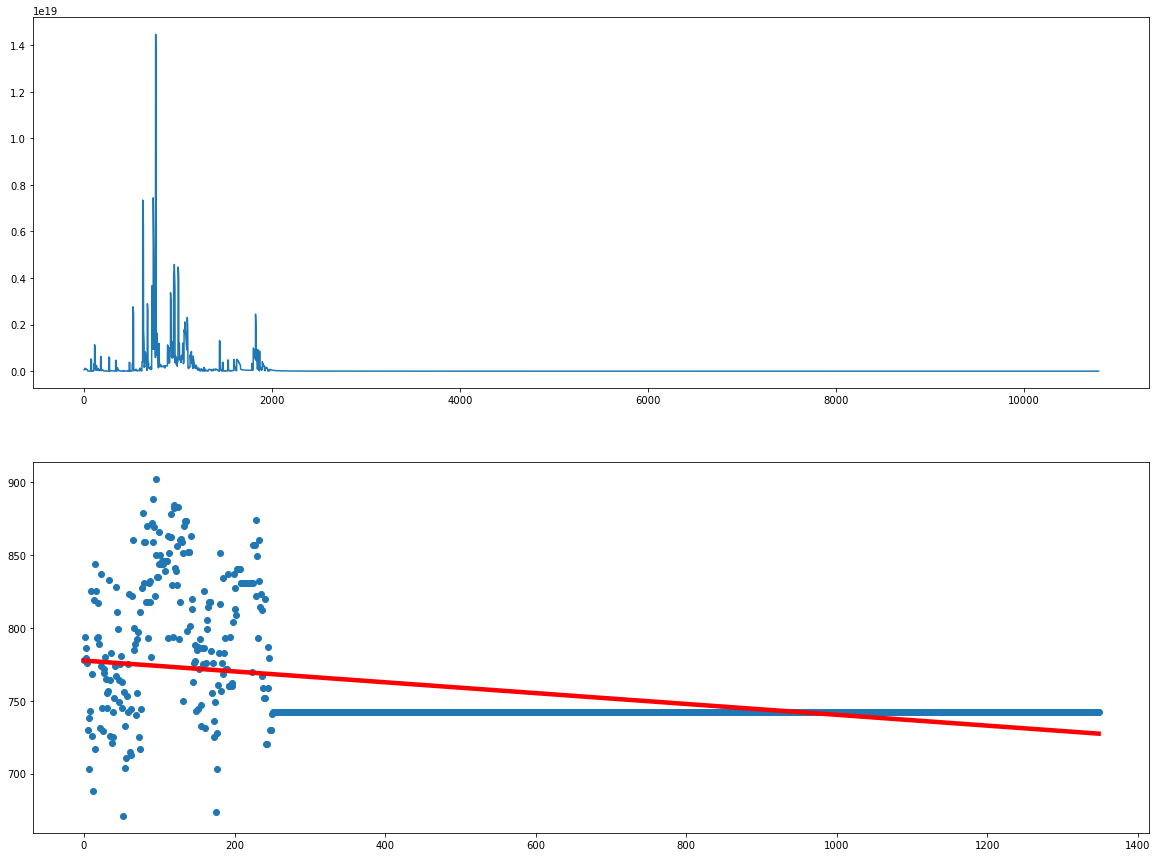

1
Epoch 1350: Current Learning Rate: [0.0005344581080558025, 0.003817557914684306], Current Success Rate: 742


/var/folders/tp/g5d5jn1j0x3d60w7kqpbj6wm0000gn/T/ipykernel_75577/2845807382.py:61: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



episode  1375  is done!


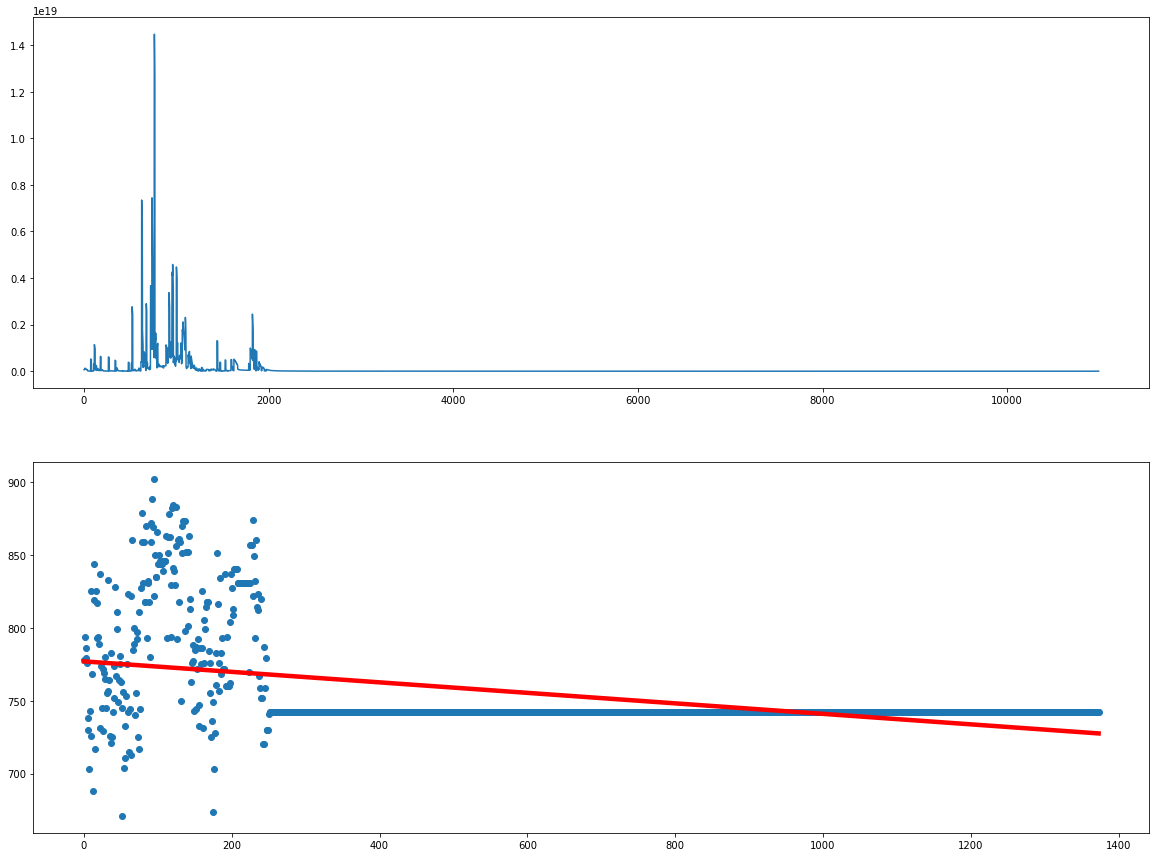

1
Epoch 1375: Current Learning Rate: [0.0005317922211895994, 0.0037985158656399995], Current Success Rate: 742


/var/folders/tp/g5d5jn1j0x3d60w7kqpbj6wm0000gn/T/ipykernel_75577/2845807382.py:61: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



episode  1400  is done!


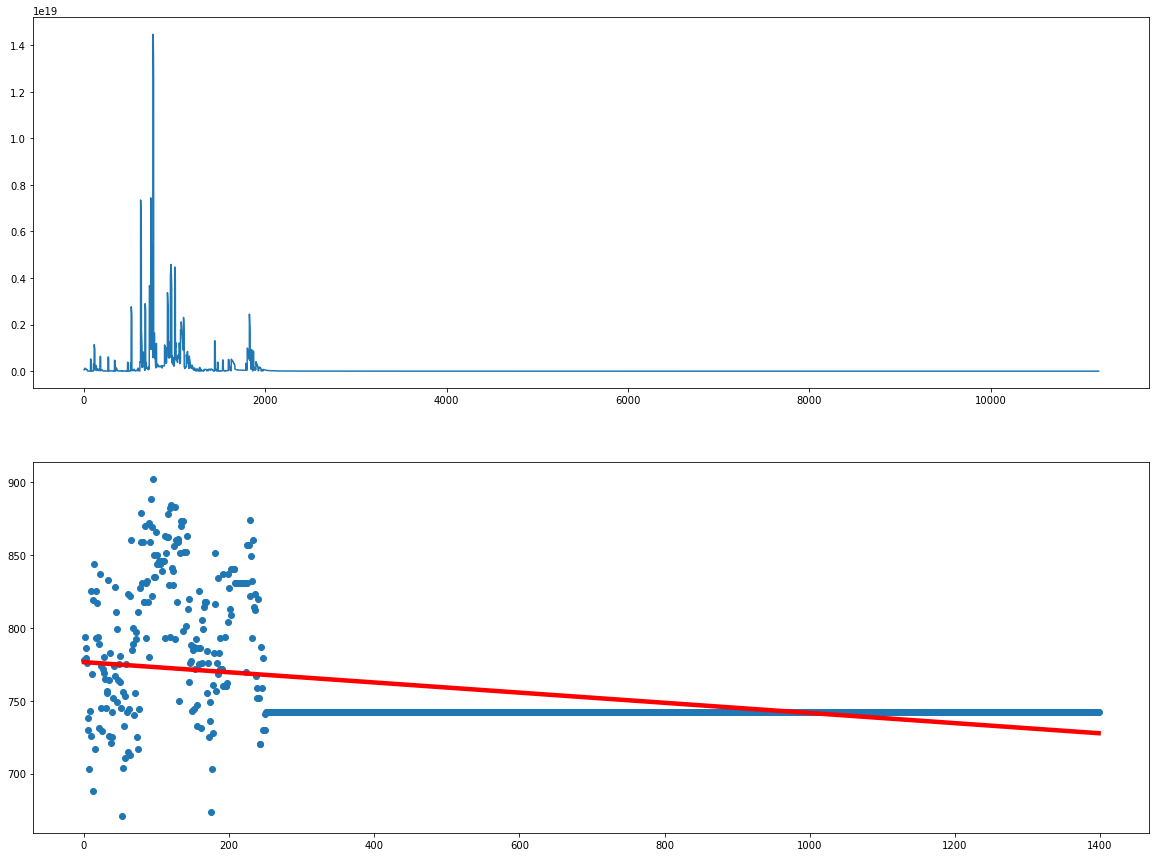

1
Epoch 1400: Current Learning Rate: [0.0005291396318160836, 0.0037795687986863146], Current Success Rate: 742


/var/folders/tp/g5d5jn1j0x3d60w7kqpbj6wm0000gn/T/ipykernel_75577/2845807382.py:61: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



episode  1425  is done!


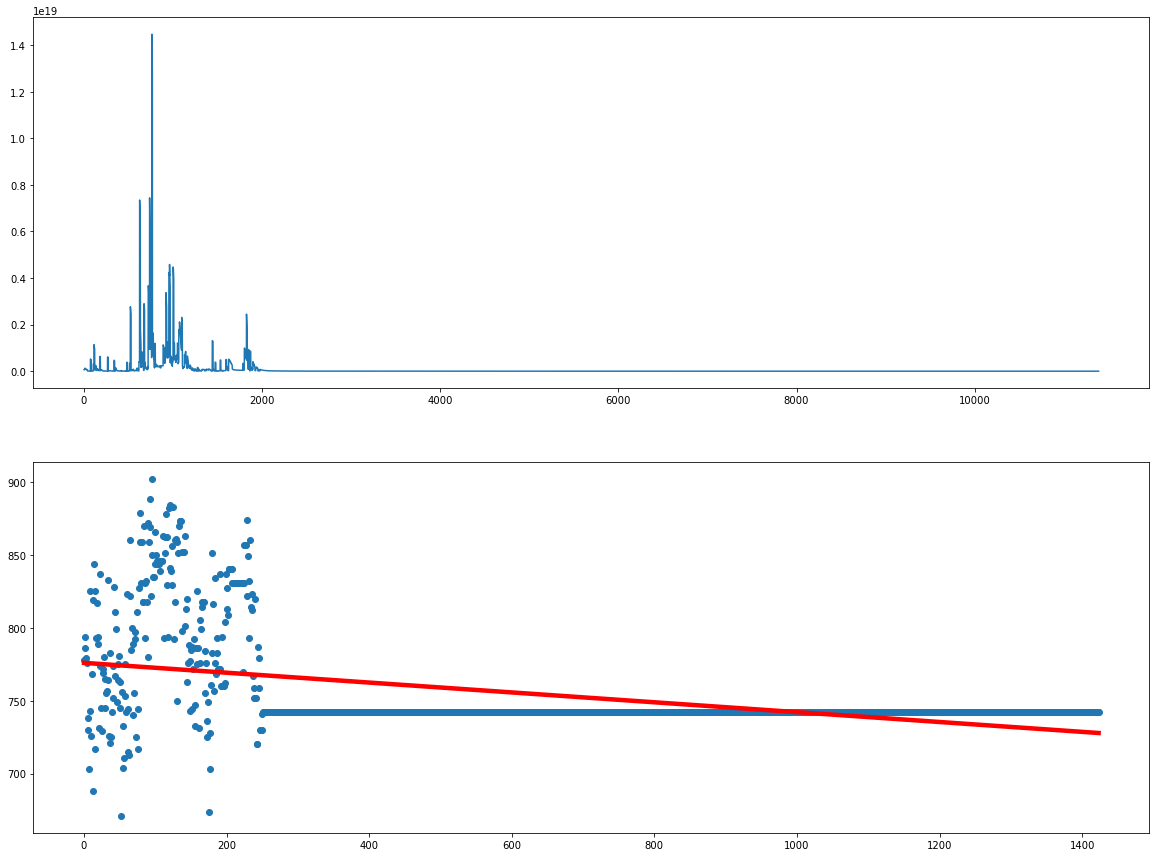

1
Epoch 1425: Current Learning Rate: [0.0005265002736071166, 0.0037607162400508376], Current Success Rate: 742


/var/folders/tp/g5d5jn1j0x3d60w7kqpbj6wm0000gn/T/ipykernel_75577/2845807382.py:61: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



episode  1450  is done!


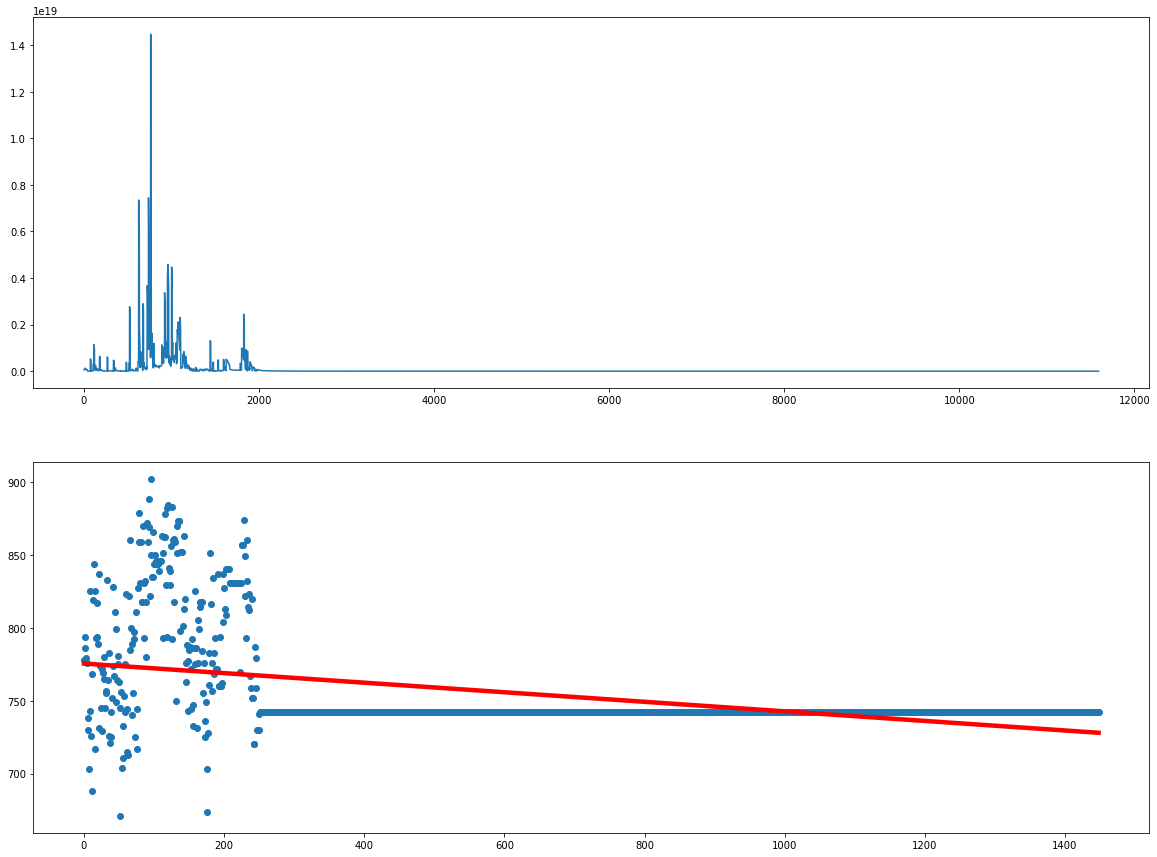

1
Epoch 1450: Current Learning Rate: [0.0005238740805654067, 0.0037419577183243403], Current Success Rate: 742


/var/folders/tp/g5d5jn1j0x3d60w7kqpbj6wm0000gn/T/ipykernel_75577/2845807382.py:61: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



episode  1475  is done!


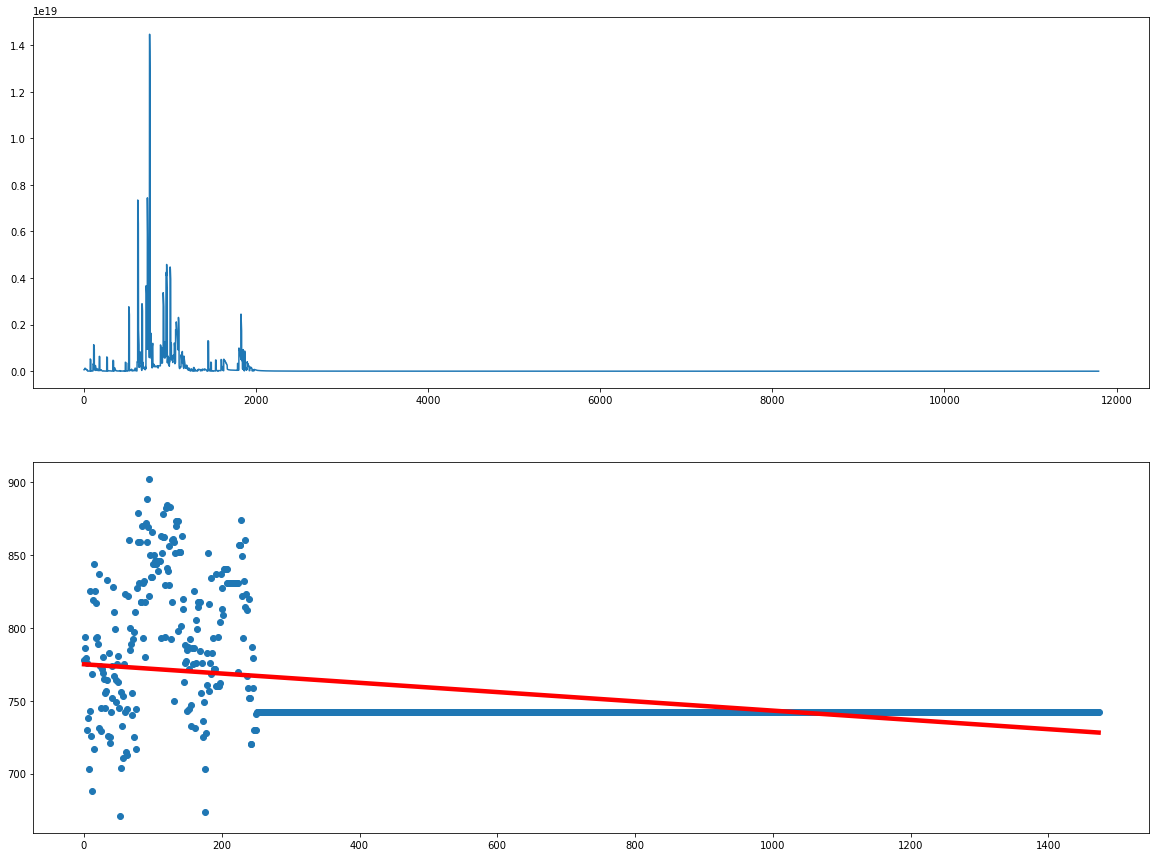

1
Epoch 1475: Current Learning Rate: [0.0005212609870228581, 0.003723292764448993], Current Success Rate: 742


/var/folders/tp/g5d5jn1j0x3d60w7kqpbj6wm0000gn/T/ipykernel_75577/2845807382.py:61: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



episode  1500  is done!


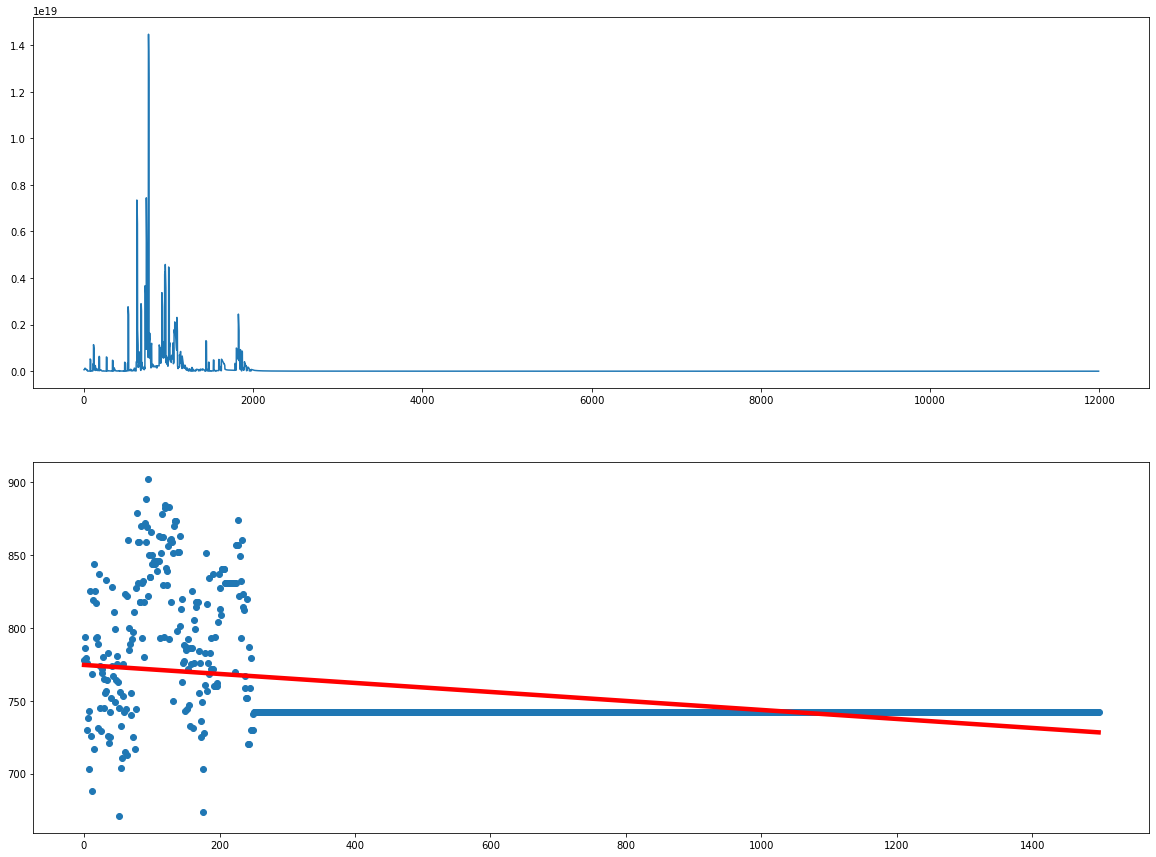

1
Epoch 1500: Current Learning Rate: [0.0005186609276389276, 0.0037047209117066337], Current Success Rate: 742


/var/folders/tp/g5d5jn1j0x3d60w7kqpbj6wm0000gn/T/ipykernel_75577/2845807382.py:61: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



episode  1525  is done!


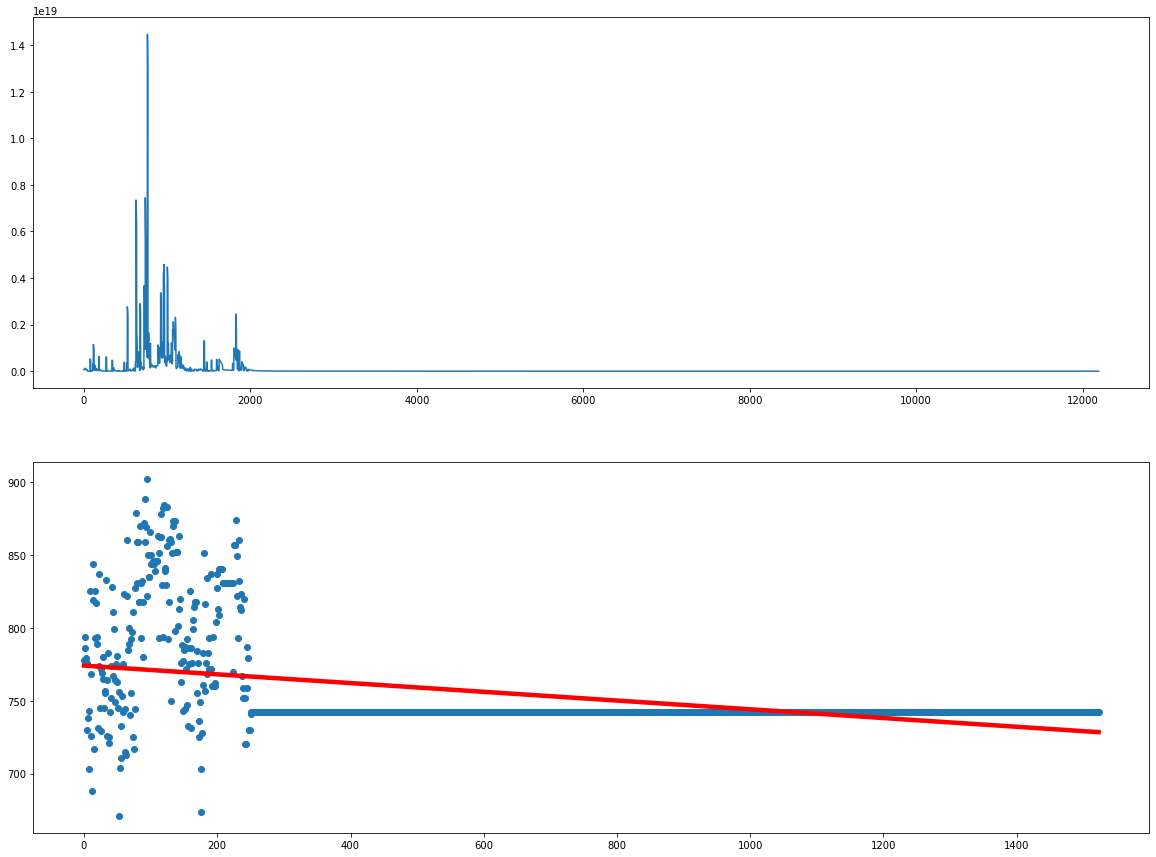

1
Epoch 1525: Current Learning Rate: [0.0005160738373989927, 0.0036862416957070985], Current Success Rate: 742


/var/folders/tp/g5d5jn1j0x3d60w7kqpbj6wm0000gn/T/ipykernel_75577/2845807382.py:61: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



episode  1550  is done!


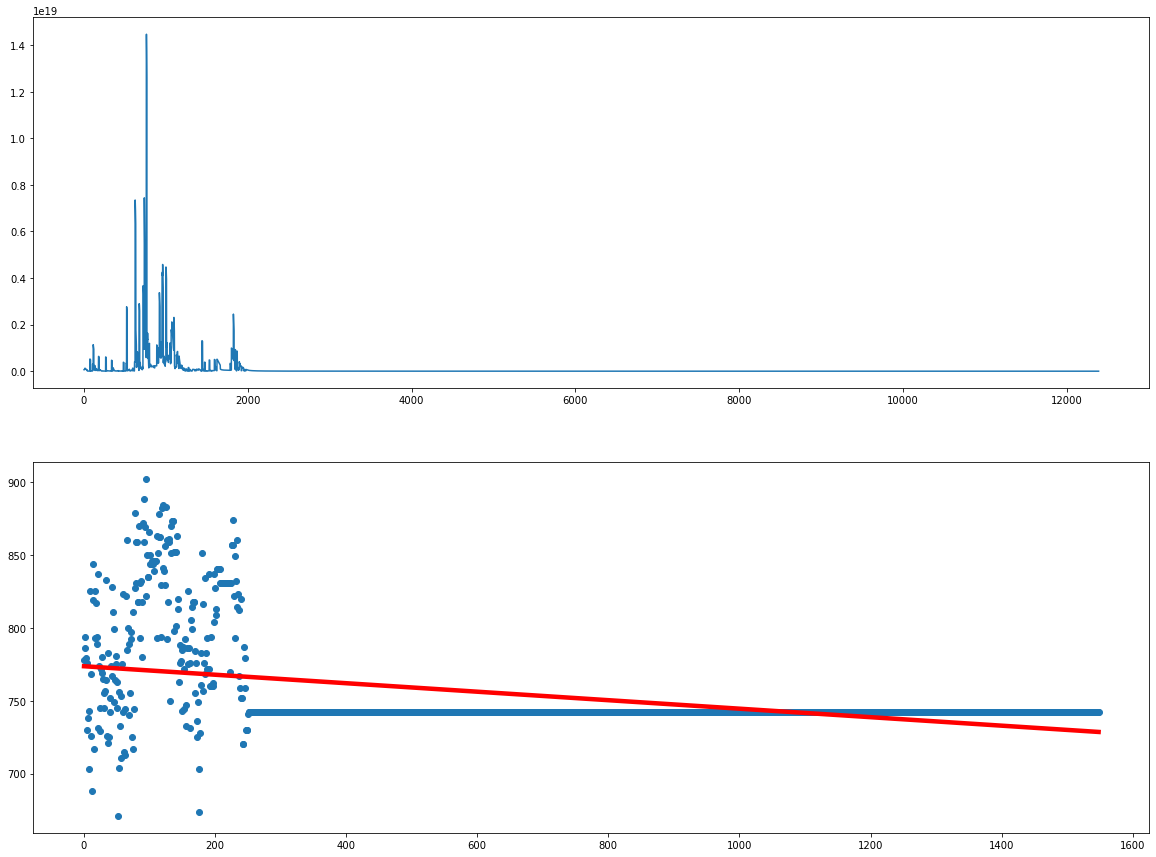

1
Epoch 1550: Current Learning Rate: [0.0005134996516127249, 0.0036678546543766144], Current Success Rate: 742


/var/folders/tp/g5d5jn1j0x3d60w7kqpbj6wm0000gn/T/ipykernel_75577/2845807382.py:61: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



episode  1575  is done!


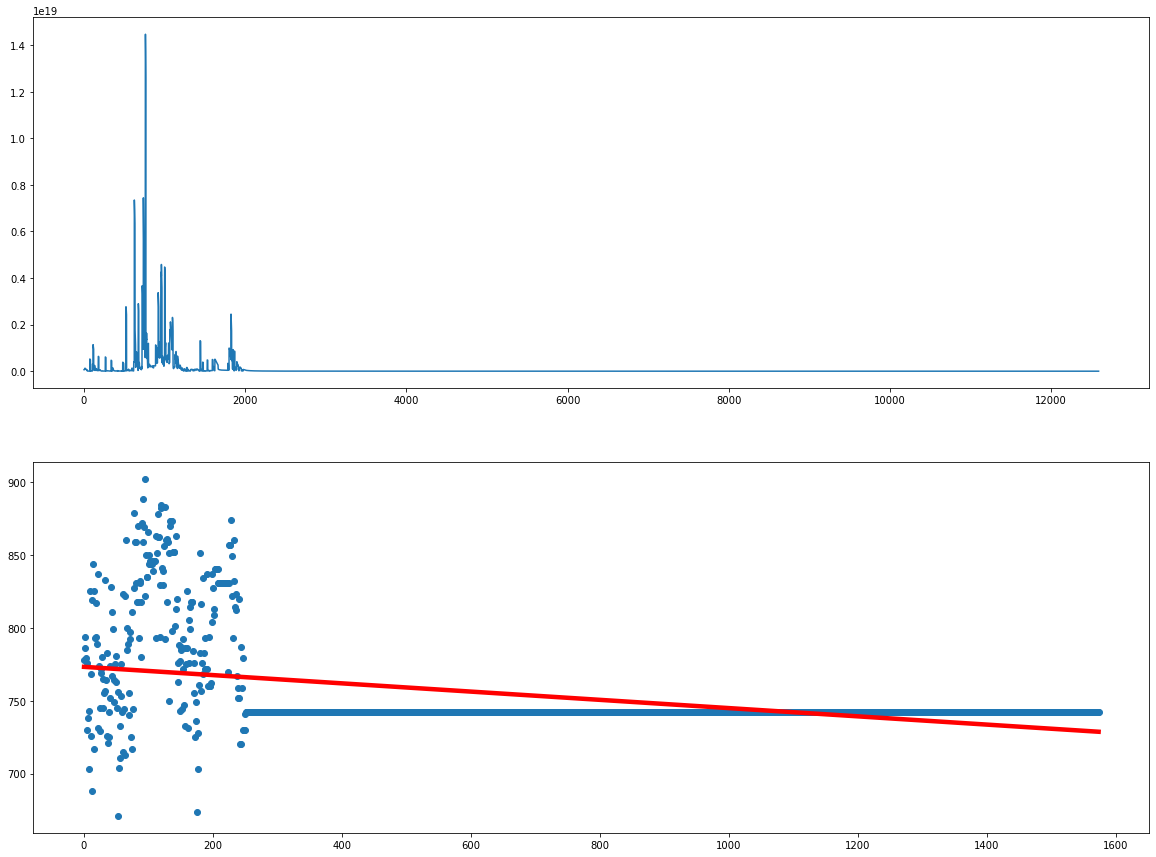

1
Epoch 1575: Current Learning Rate: [0.0005109383059124716, 0.003649559327946236], Current Success Rate: 742


/var/folders/tp/g5d5jn1j0x3d60w7kqpbj6wm0000gn/T/ipykernel_75577/2845807382.py:61: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



episode  1600  is done!


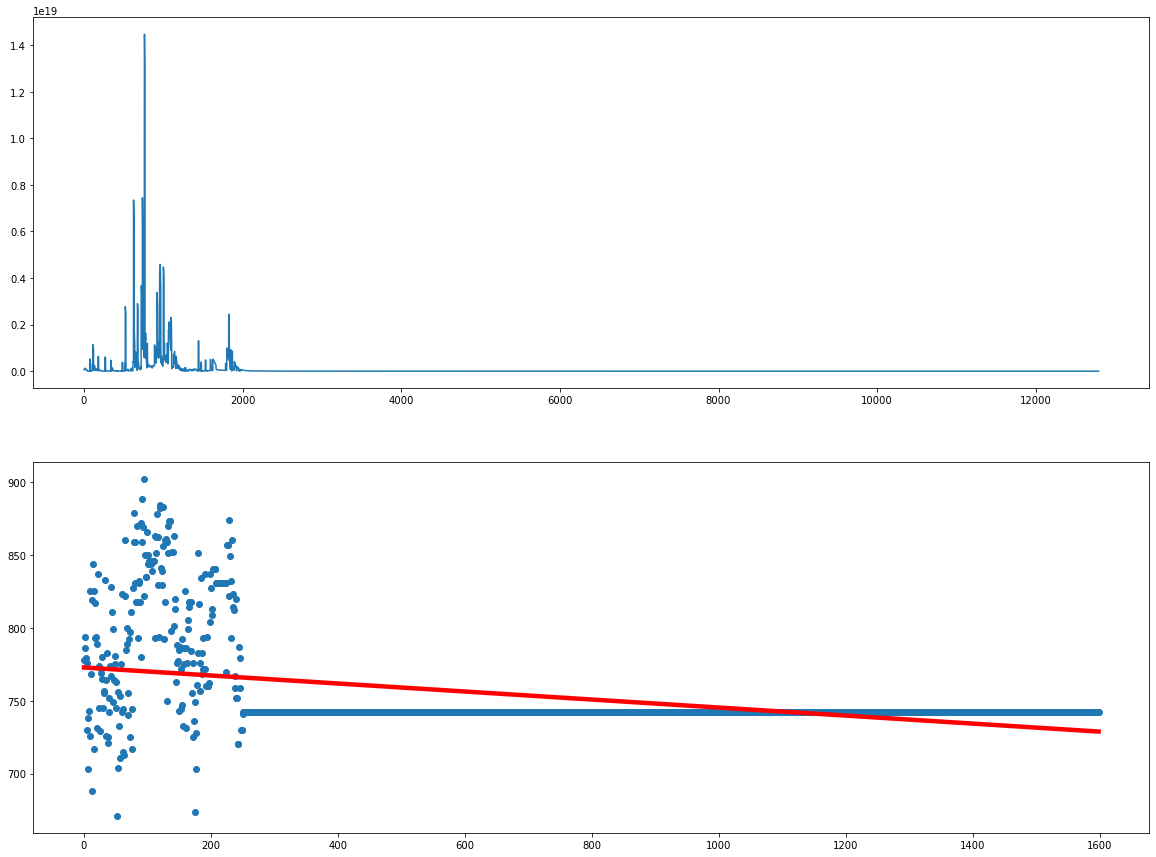

1
Epoch 1600: Current Learning Rate: [0.0005083897362516484, 0.0036313552589403554], Current Success Rate: 742


/var/folders/tp/g5d5jn1j0x3d60w7kqpbj6wm0000gn/T/ipykernel_75577/2845807382.py:61: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



episode  1625  is done!


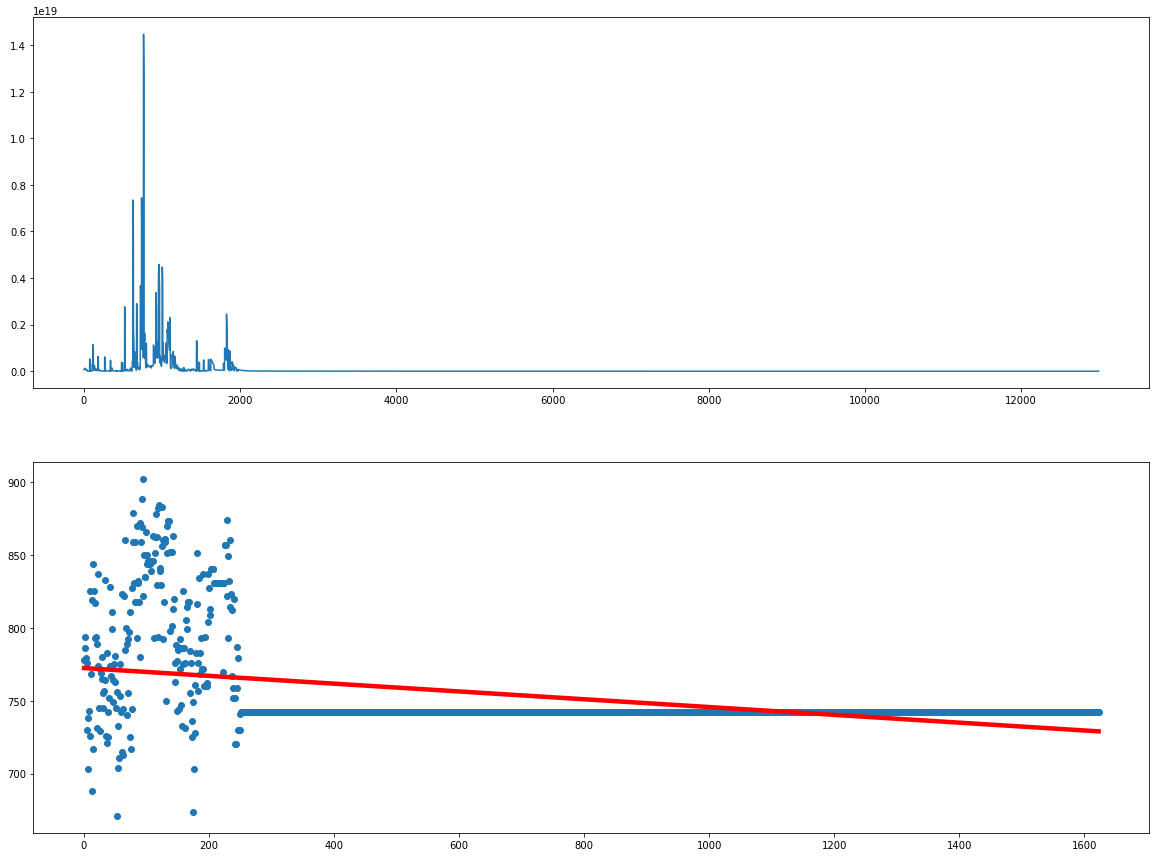

1
Epoch 1625: Current Learning Rate: [0.0005058538789031356, 0.003613241992165263], Current Success Rate: 742


/var/folders/tp/g5d5jn1j0x3d60w7kqpbj6wm0000gn/T/ipykernel_75577/2845807382.py:61: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



episode  1650  is done!


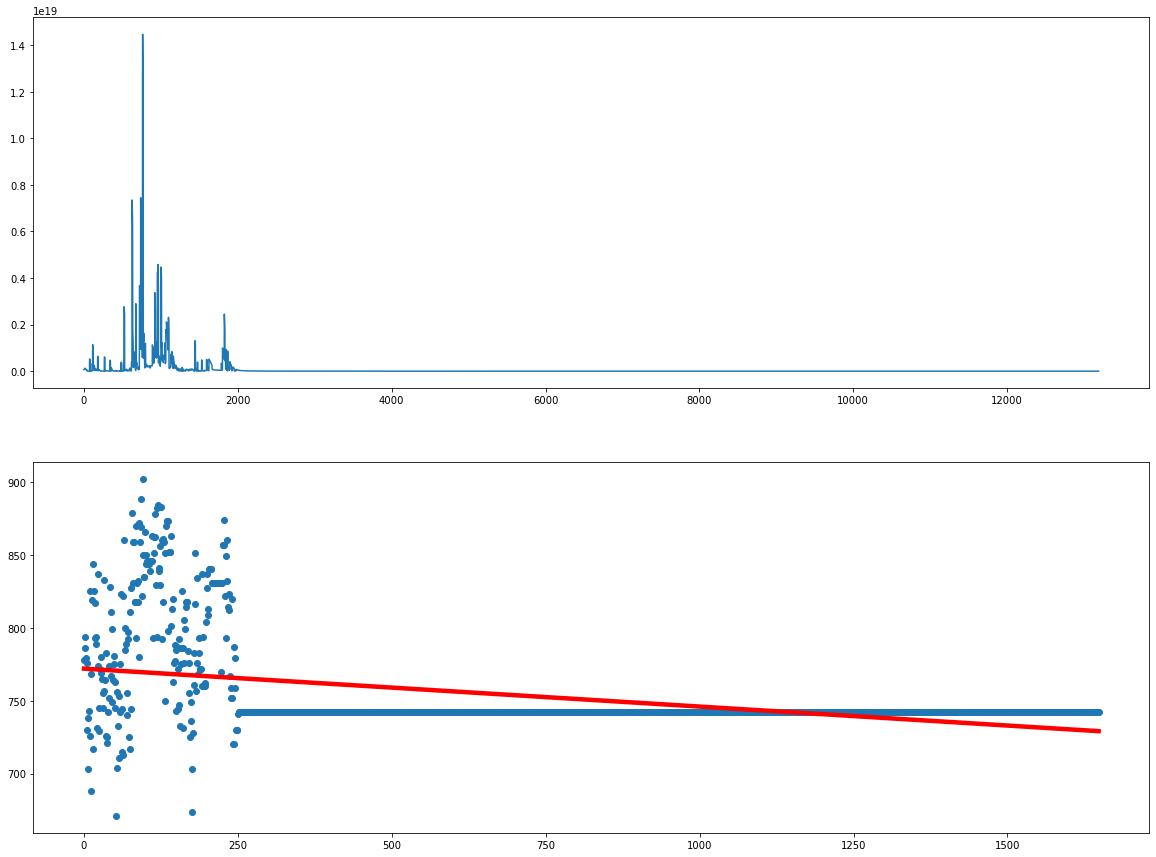

1
Epoch 1650: Current Learning Rate: [0.0005033306704576854, 0.0035952190746977616], Current Success Rate: 742


/var/folders/tp/g5d5jn1j0x3d60w7kqpbj6wm0000gn/T/ipykernel_75577/2845807382.py:61: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



episode  1675  is done!


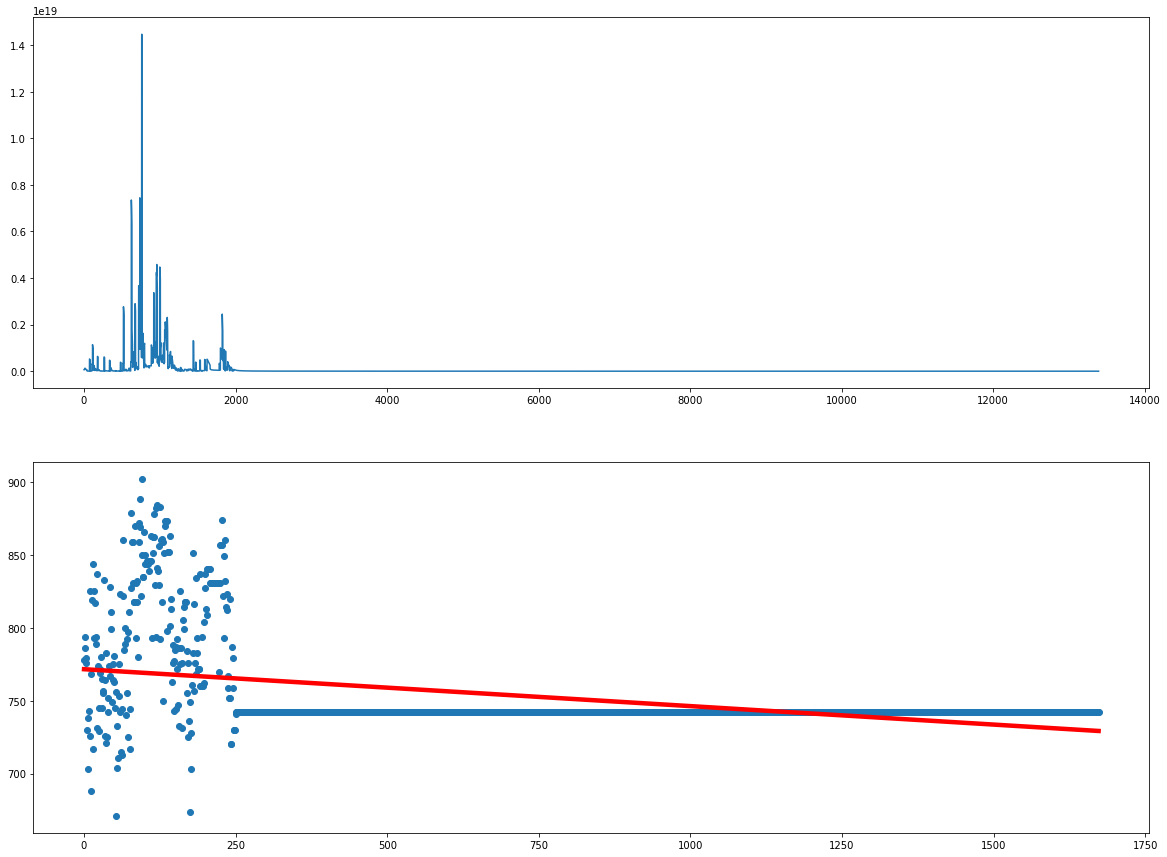

1
Epoch 1675: Current Learning Rate: [0.000500820047822337, 0.003577286055873845], Current Success Rate: 742


/var/folders/tp/g5d5jn1j0x3d60w7kqpbj6wm0000gn/T/ipykernel_75577/2845807382.py:61: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



episode  1700  is done!


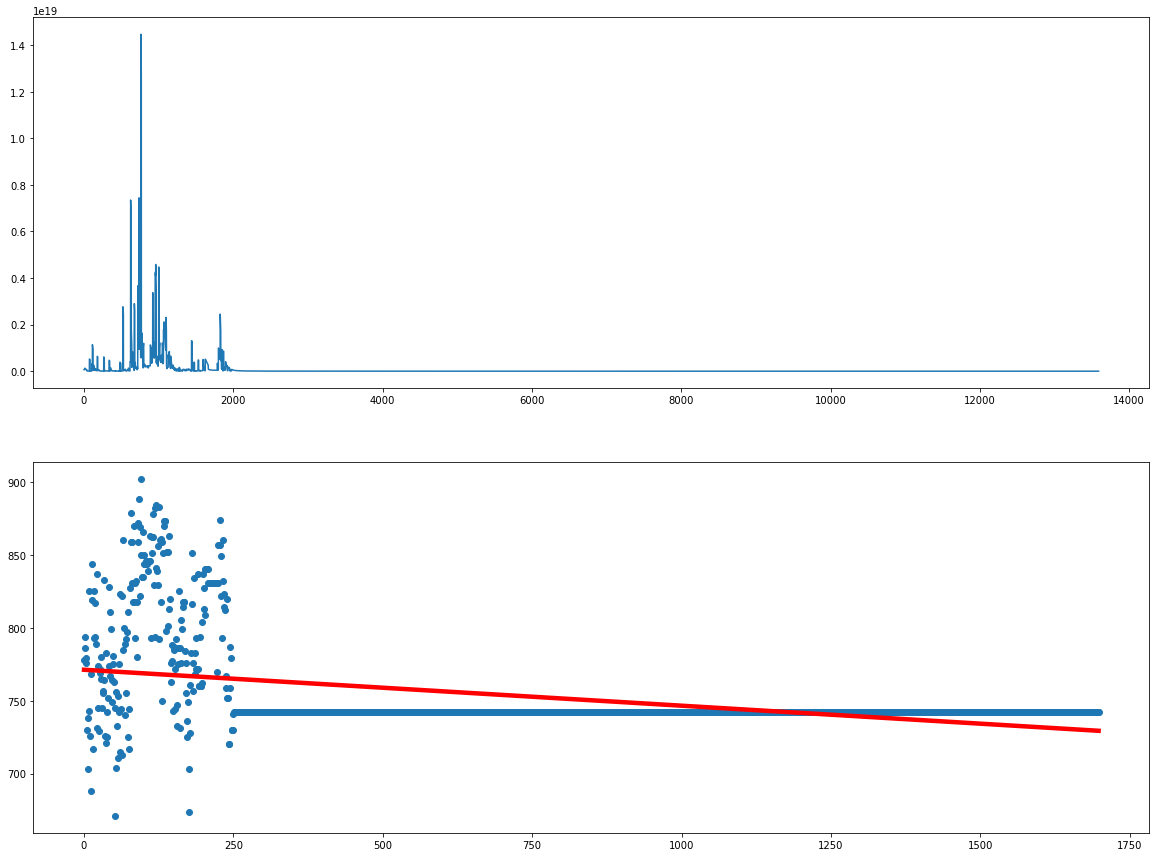

1
Epoch 1700: Current Learning Rate: [0.0004983219482188388, 0.0035594424872774284], Current Success Rate: 742


/var/folders/tp/g5d5jn1j0x3d60w7kqpbj6wm0000gn/T/ipykernel_75577/2845807382.py:61: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



episode  1725  is done!


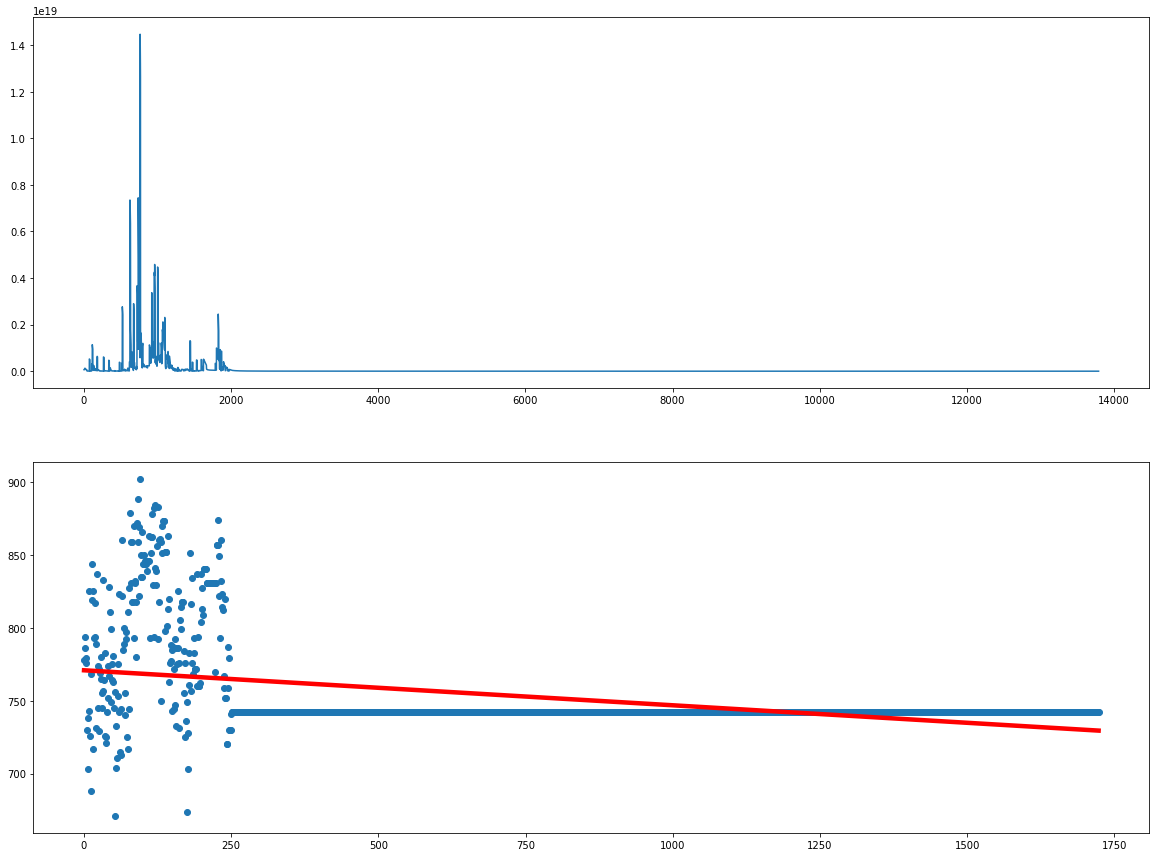

1
Epoch 1725: Current Learning Rate: [0.0004958363091820774, 0.0035416879227291318], Current Success Rate: 742


/var/folders/tp/g5d5jn1j0x3d60w7kqpbj6wm0000gn/T/ipykernel_75577/2845807382.py:61: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



episode  1750  is done!


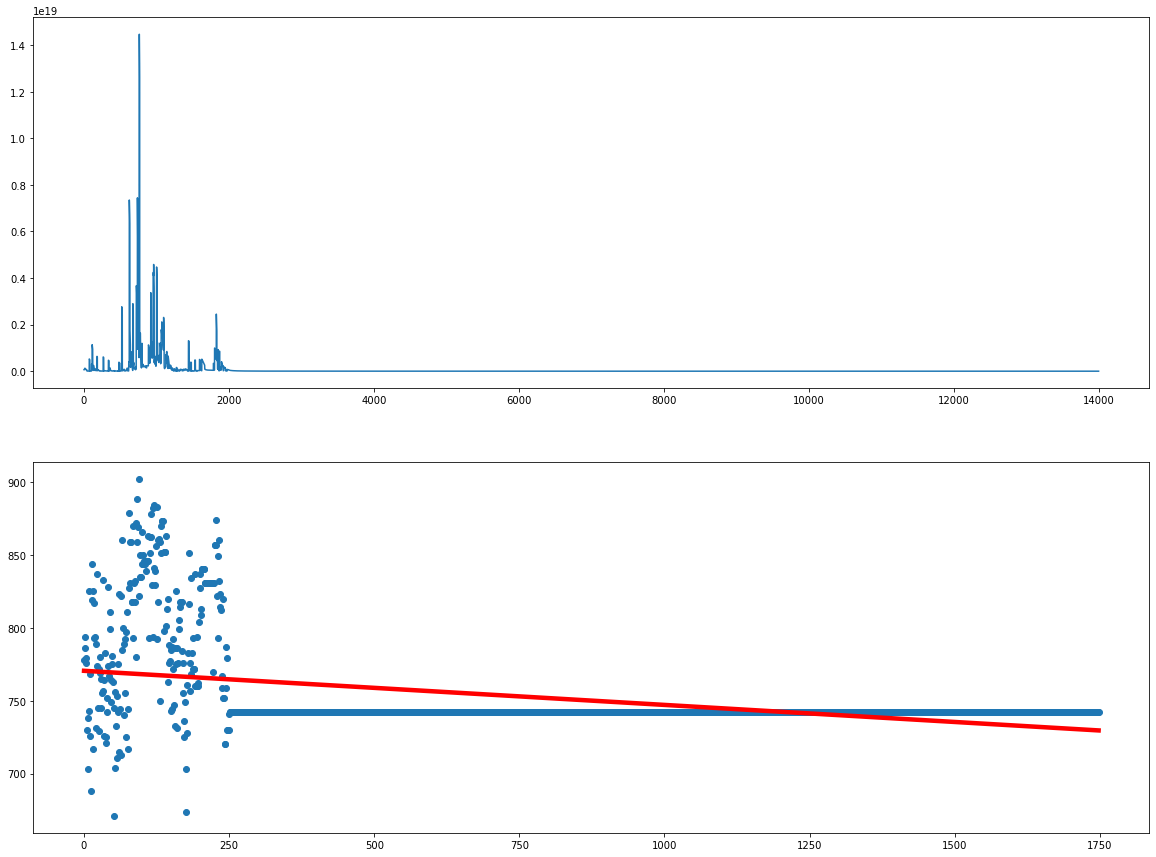

1
Epoch 1750: Current Learning Rate: [0.0004933630685585169, 0.0035240219182751265], Current Success Rate: 742


/var/folders/tp/g5d5jn1j0x3d60w7kqpbj6wm0000gn/T/ipykernel_75577/2845807382.py:61: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



episode  1775  is done!


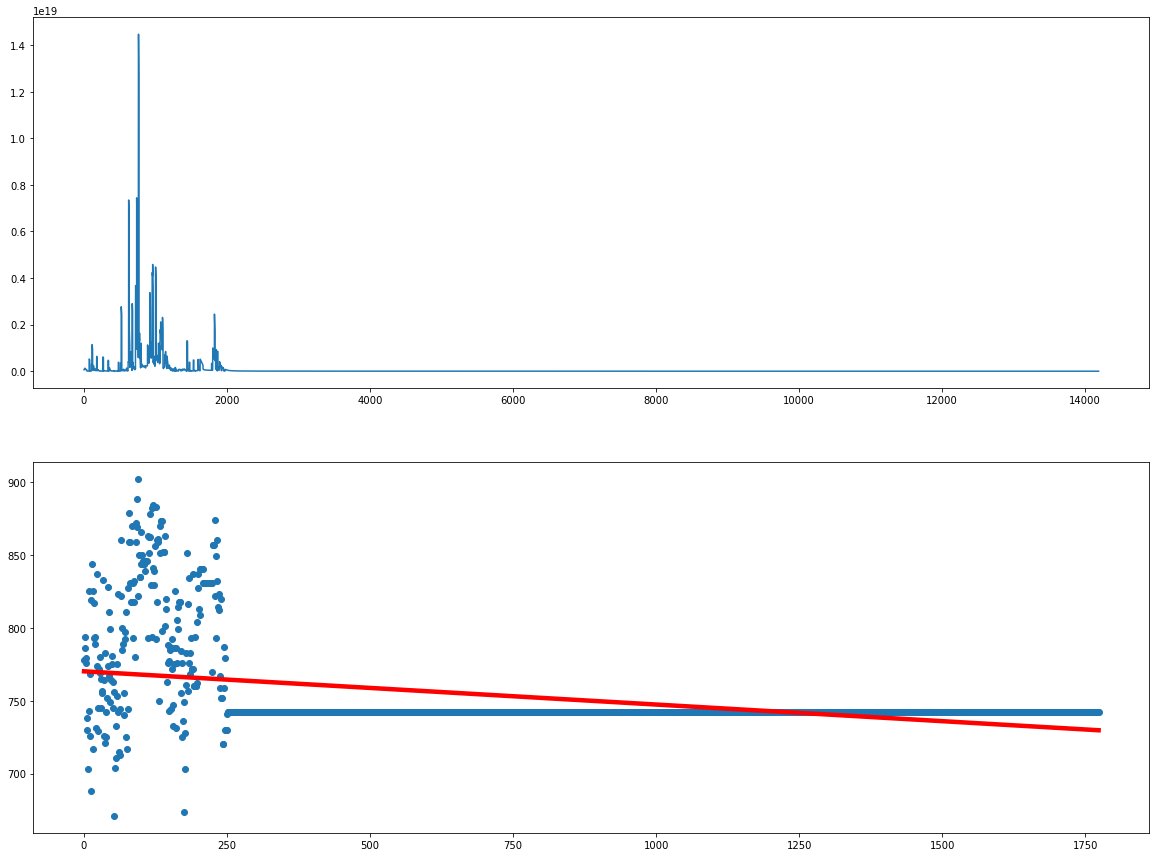

1
Epoch 1775: Current Learning Rate: [0.0004909021645046439, 0.003506444032176035], Current Success Rate: 742


/var/folders/tp/g5d5jn1j0x3d60w7kqpbj6wm0000gn/T/ipykernel_75577/2845807382.py:61: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



episode  1800  is done!


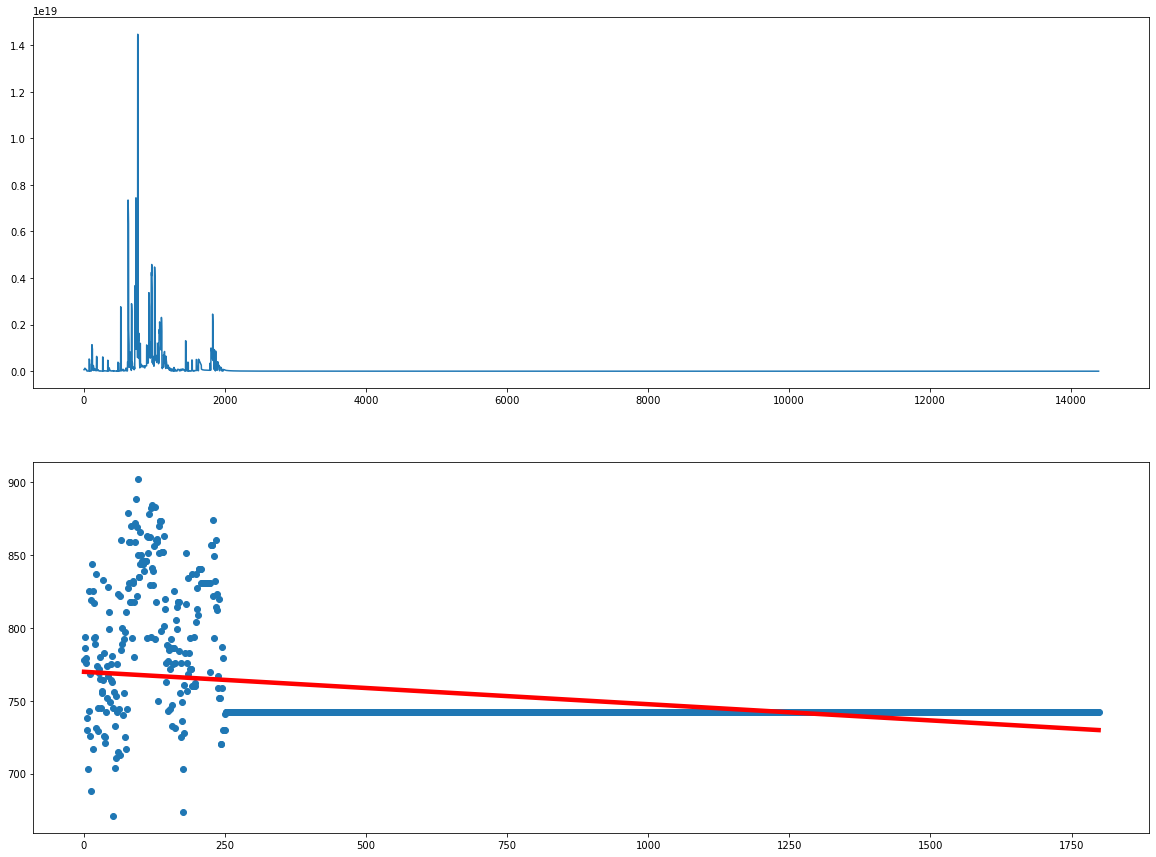

1
Epoch 1800: Current Learning Rate: [0.0004884535354854226, 0.0034889538248958833], Current Success Rate: 742


/var/folders/tp/g5d5jn1j0x3d60w7kqpbj6wm0000gn/T/ipykernel_75577/2845807382.py:61: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



episode  1825  is done!


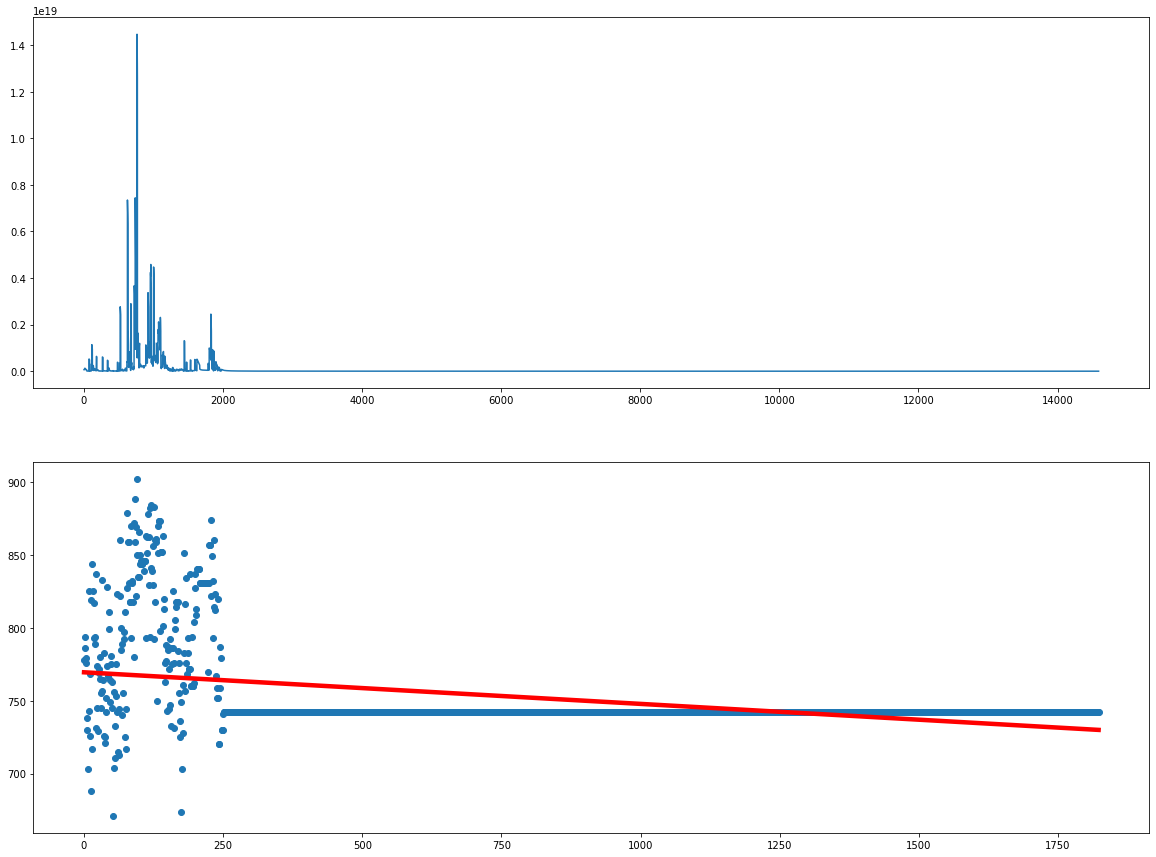

1
Epoch 1825: Current Learning Rate: [0.0004860171202727545, 0.003471550859091112], Current Success Rate: 742


/var/folders/tp/g5d5jn1j0x3d60w7kqpbj6wm0000gn/T/ipykernel_75577/2845807382.py:61: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



episode  1850  is done!


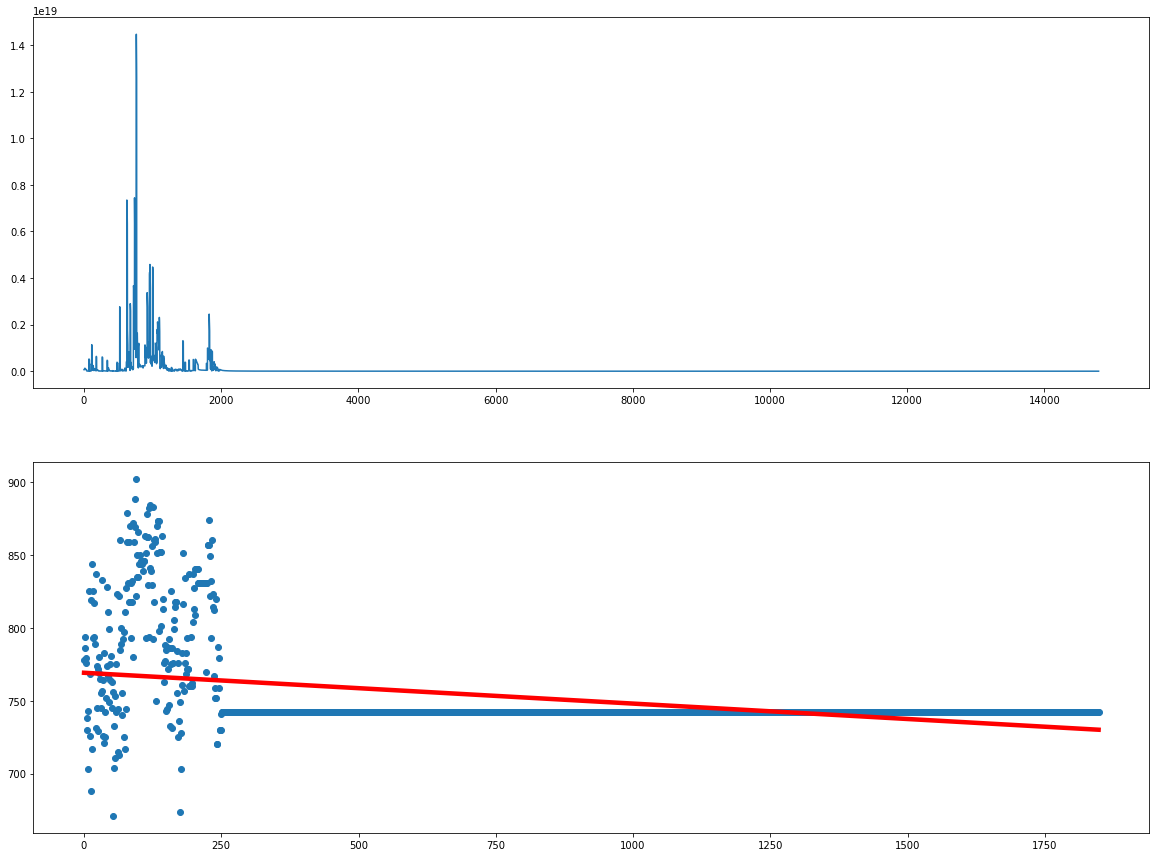

1
Epoch 1850: Current Learning Rate: [0.000483592857943948, 0.0034542346995996365], Current Success Rate: 742


/var/folders/tp/g5d5jn1j0x3d60w7kqpbj6wm0000gn/T/ipykernel_75577/2845807382.py:61: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



episode  1875  is done!


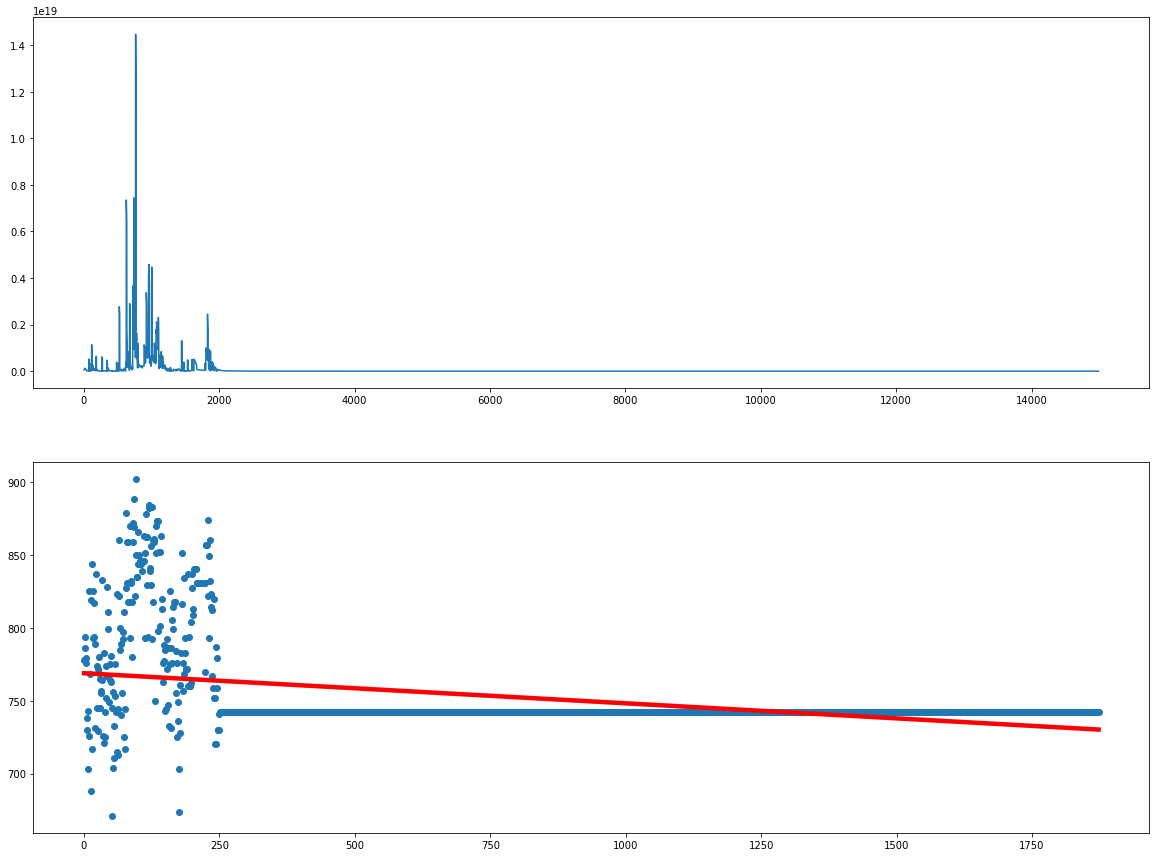

1
Epoch 1875: Current Learning Rate: [0.000481180687880195, 0.003437004913429972], Current Success Rate: 742


/var/folders/tp/g5d5jn1j0x3d60w7kqpbj6wm0000gn/T/ipykernel_75577/2845807382.py:61: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



episode  1900  is done!


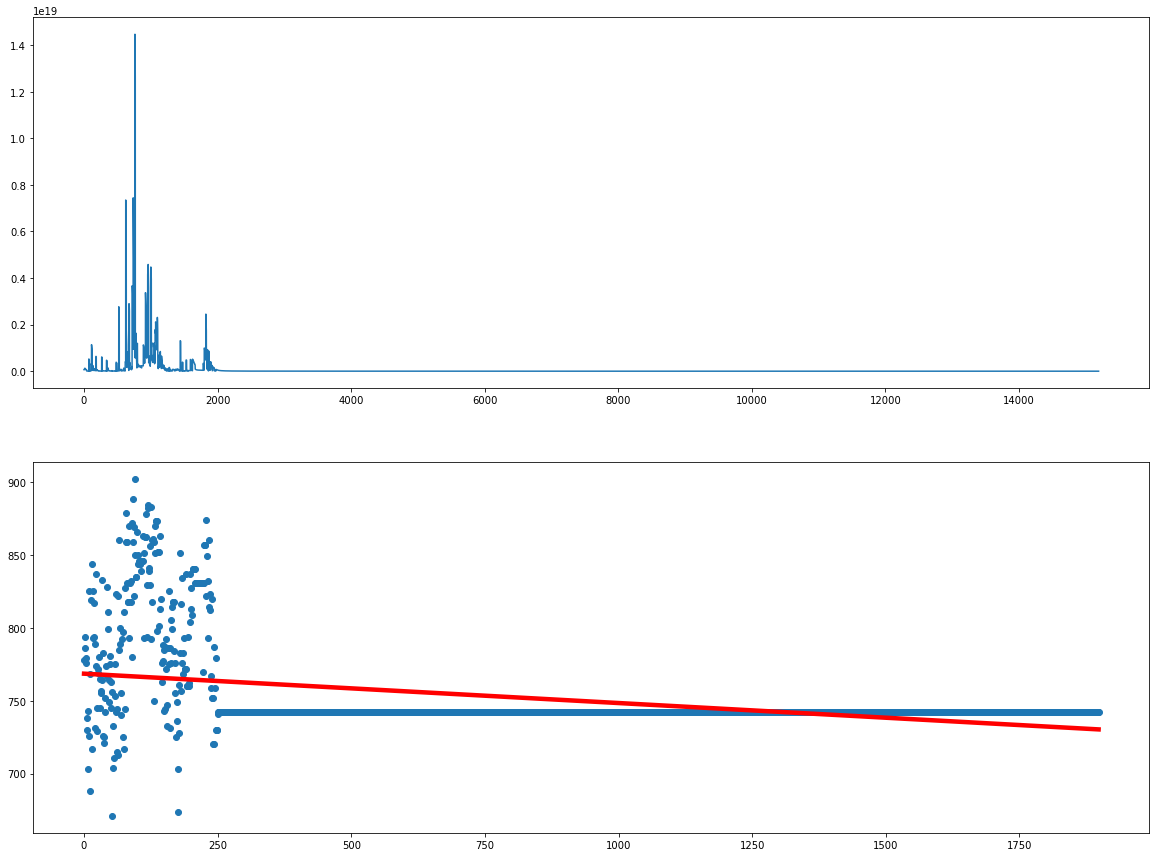

1
Epoch 1900: Current Learning Rate: [0.0004787805497650551, 0.0034198610697504005], Current Success Rate: 742


/var/folders/tp/g5d5jn1j0x3d60w7kqpbj6wm0000gn/T/ipykernel_75577/2845807382.py:61: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



episode  1925  is done!


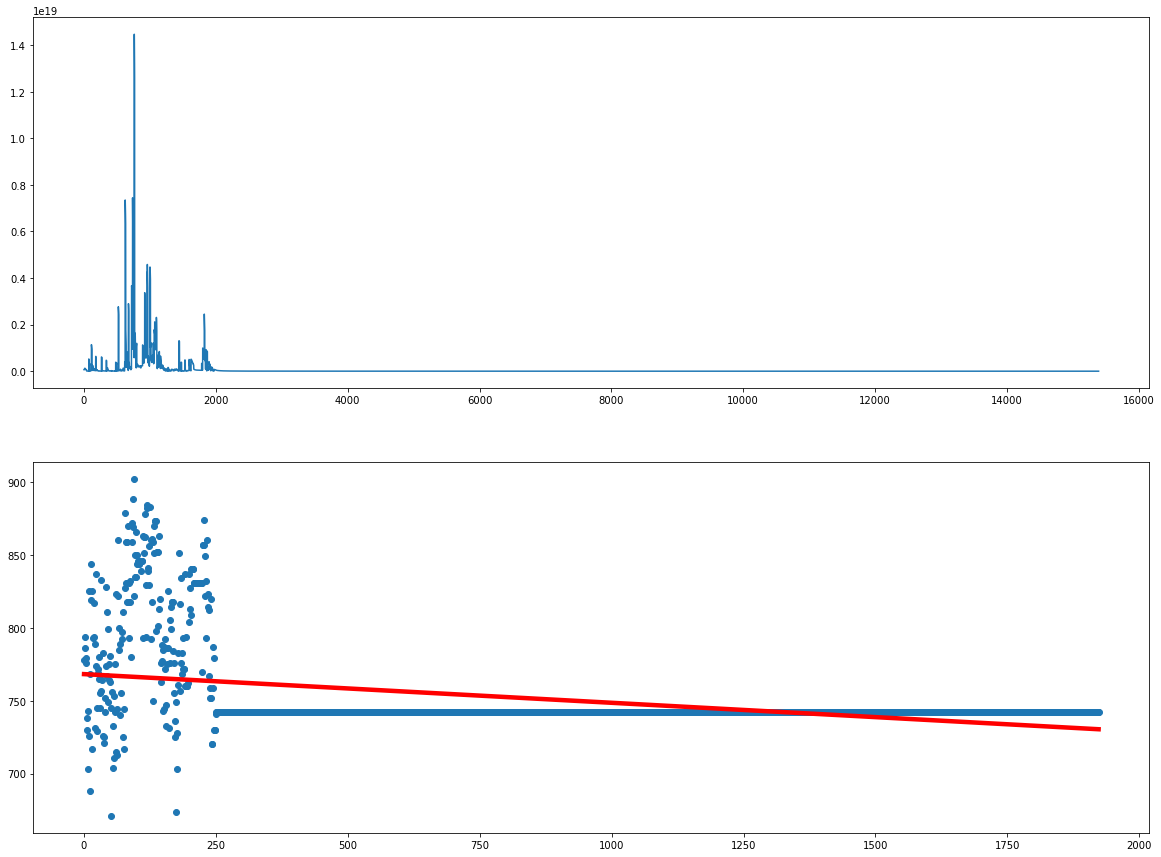

1
Epoch 1925: Current Learning Rate: [0.00047639238358294765, 0.003402802739878203], Current Success Rate: 742


/var/folders/tp/g5d5jn1j0x3d60w7kqpbj6wm0000gn/T/ipykernel_75577/2845807382.py:61: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



episode  1950  is done!


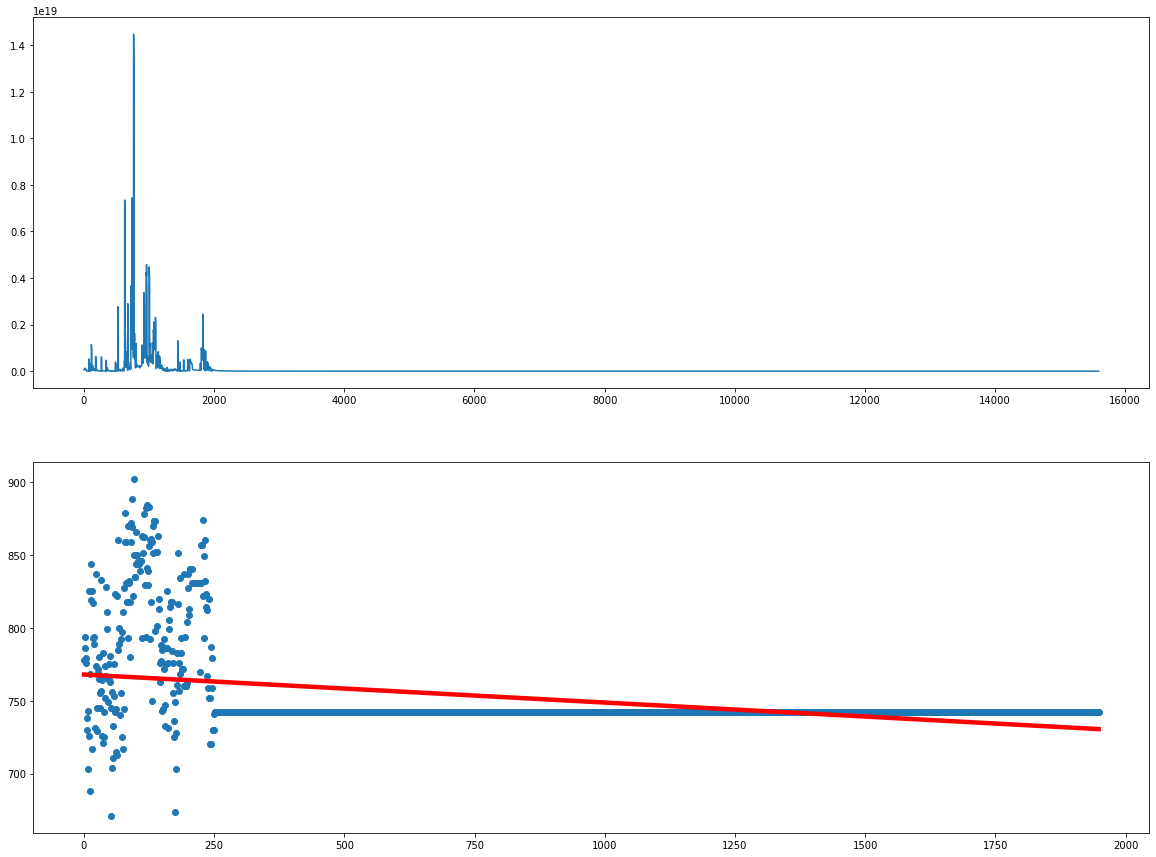

1
Epoch 1950: Current Learning Rate: [0.00047401612961765055, 0.0033858294972689365], Current Success Rate: 742


/var/folders/tp/g5d5jn1j0x3d60w7kqpbj6wm0000gn/T/ipykernel_75577/2845807382.py:61: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



episode  1975  is done!


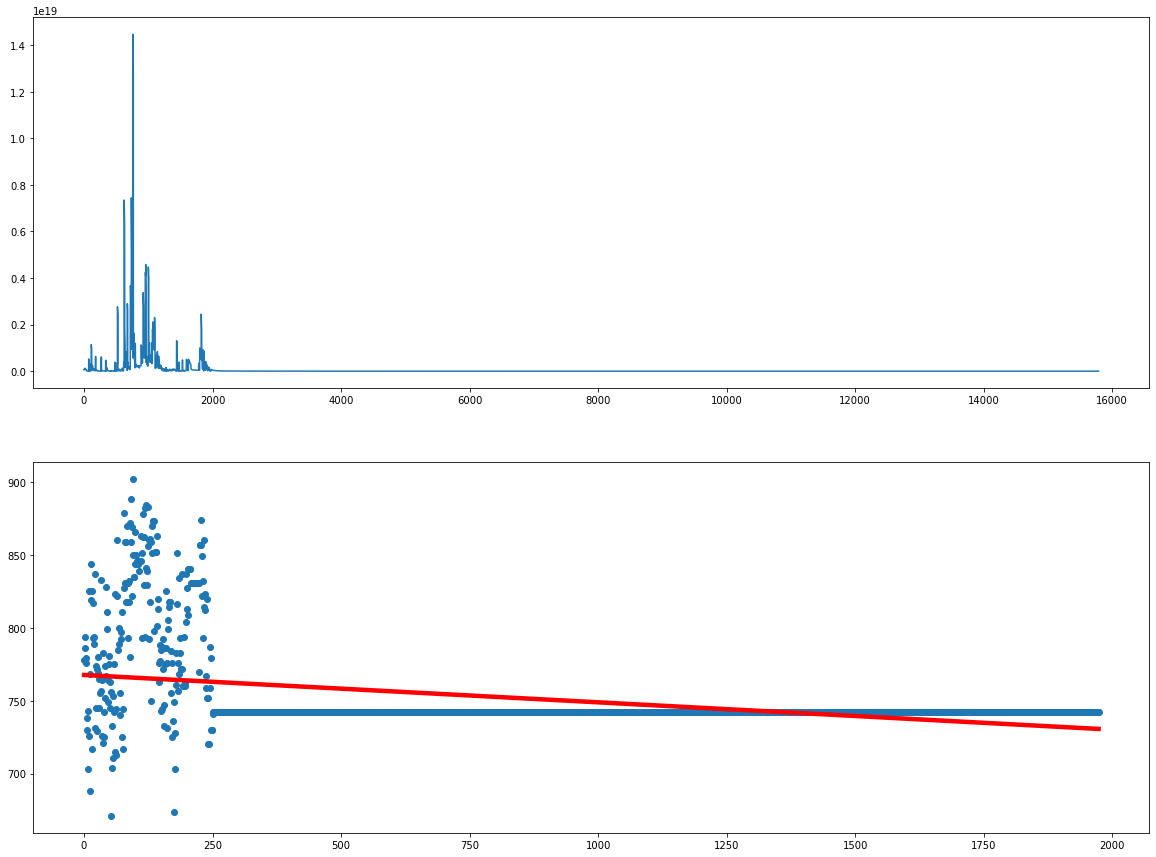

1
Epoch 1975: Current Learning Rate: [0.0004716517284508073, 0.0033689409175057697], Current Success Rate: 742


/var/folders/tp/g5d5jn1j0x3d60w7kqpbj6wm0000gn/T/ipykernel_75577/2845807382.py:61: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



episode  2000  is done!


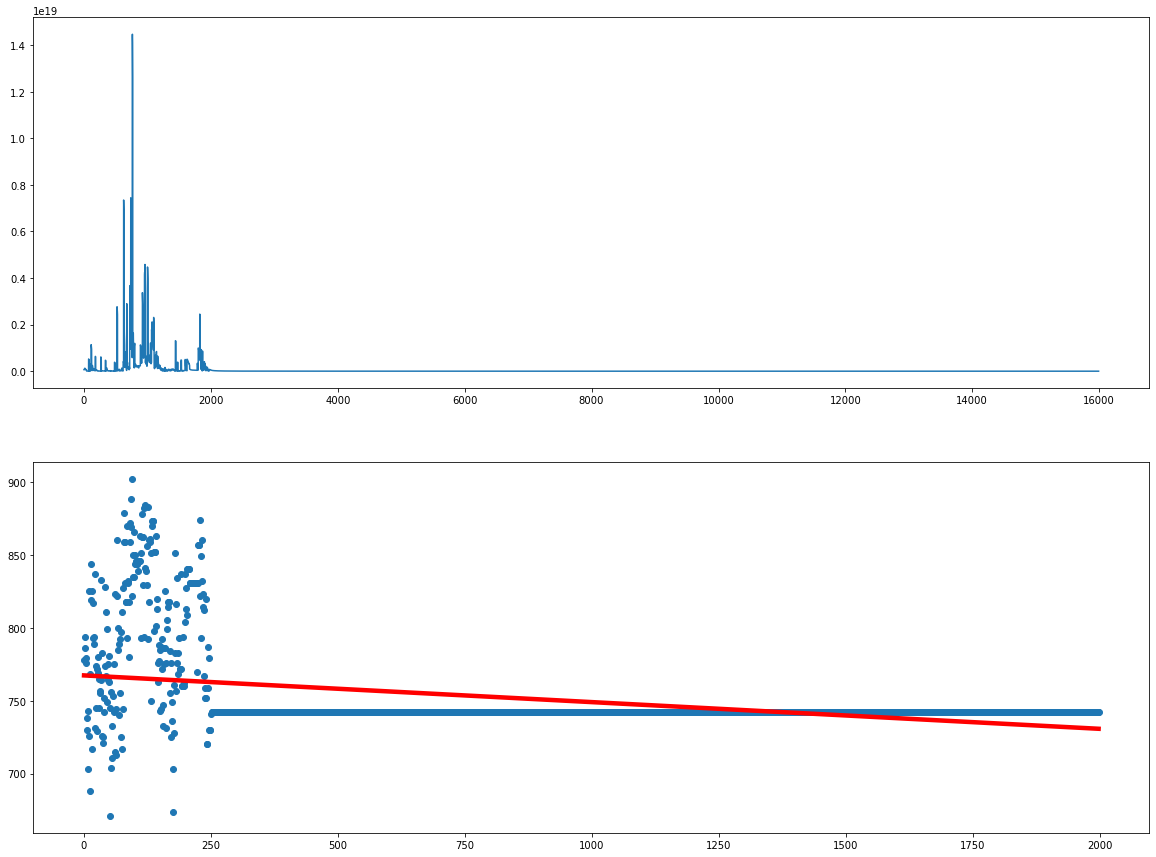

1
Epoch 2000: Current Learning Rate: [0.0004692991209604413, 0.0033521365782888703], Current Success Rate: 742


/var/folders/tp/g5d5jn1j0x3d60w7kqpbj6wm0000gn/T/ipykernel_75577/2845807382.py:61: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



episode  2025  is done!


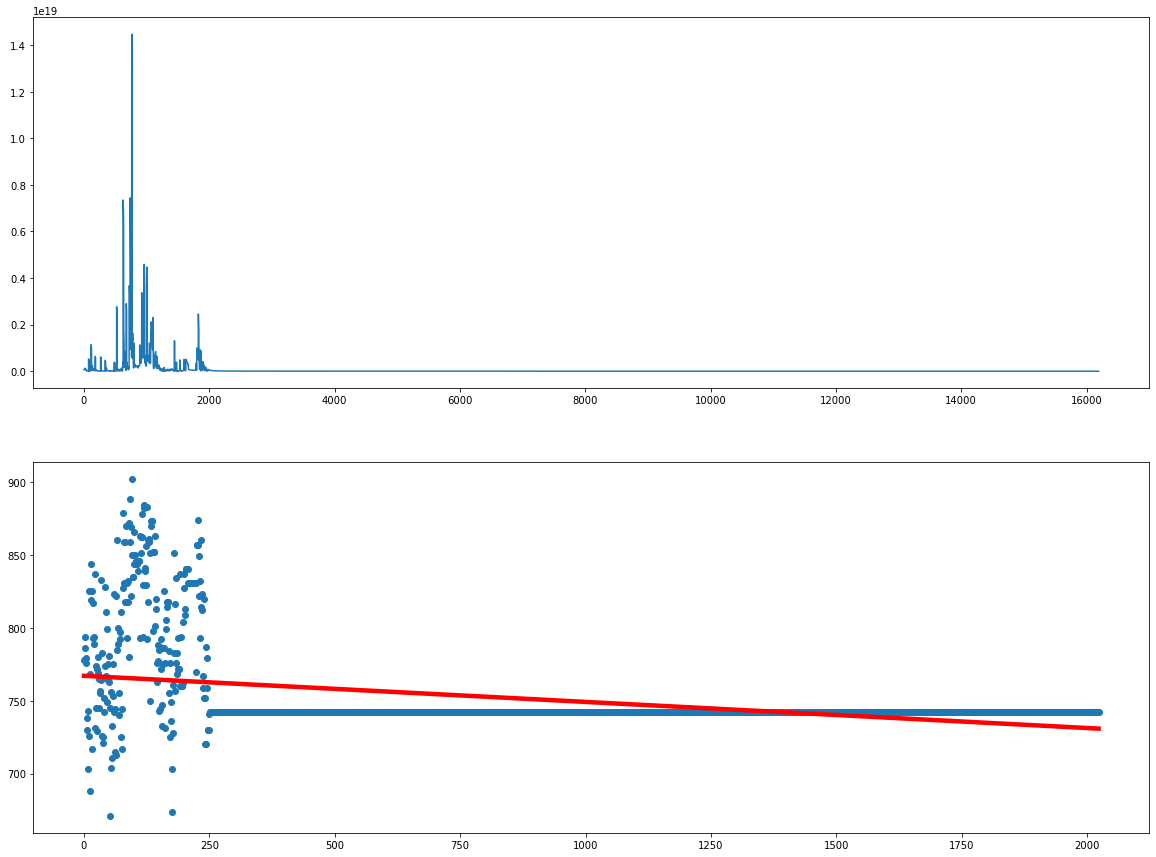

1
Epoch 2025: Current Learning Rate: [0.0004669582483194777, 0.0033354160594248434], Current Success Rate: 742


/var/folders/tp/g5d5jn1j0x3d60w7kqpbj6wm0000gn/T/ipykernel_75577/2845807382.py:61: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



episode  2050  is done!


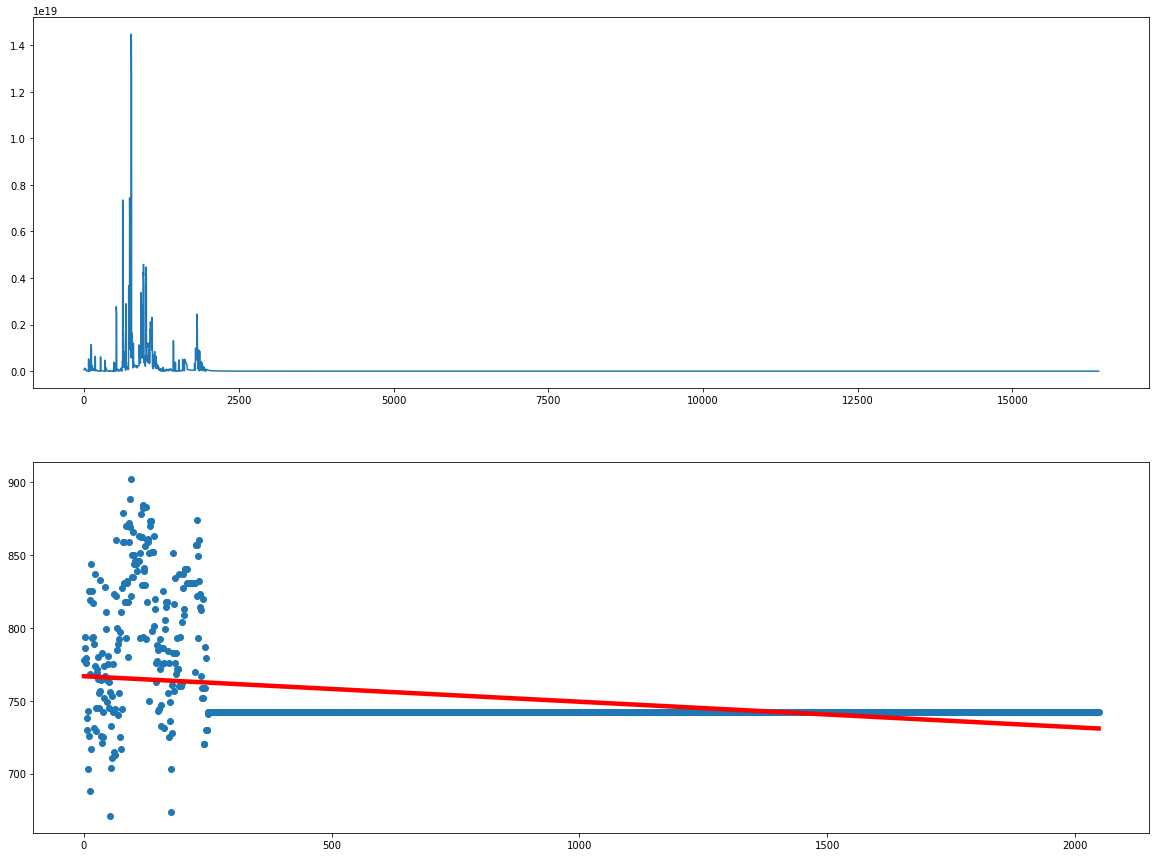

1
Epoch 2050: Current Learning Rate: [0.00046462905199427205, 0.003318778942816232], Current Success Rate: 742


/var/folders/tp/g5d5jn1j0x3d60w7kqpbj6wm0000gn/T/ipykernel_75577/2845807382.py:61: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



episode  2075  is done!


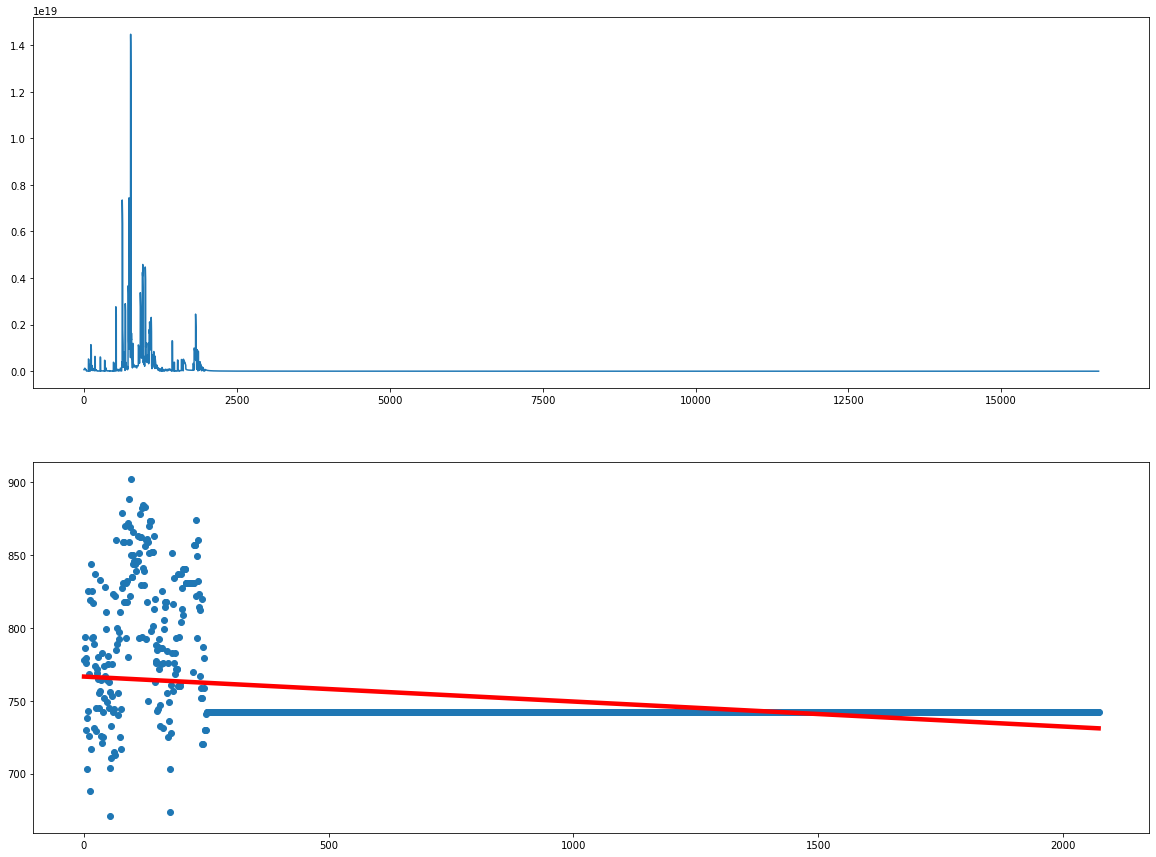

1
Epoch 2075: Current Learning Rate: [0.0004623114737431464, 0.0033022248124510486], Current Success Rate: 742


/var/folders/tp/g5d5jn1j0x3d60w7kqpbj6wm0000gn/T/ipykernel_75577/2845807382.py:61: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



episode  2100  is done!


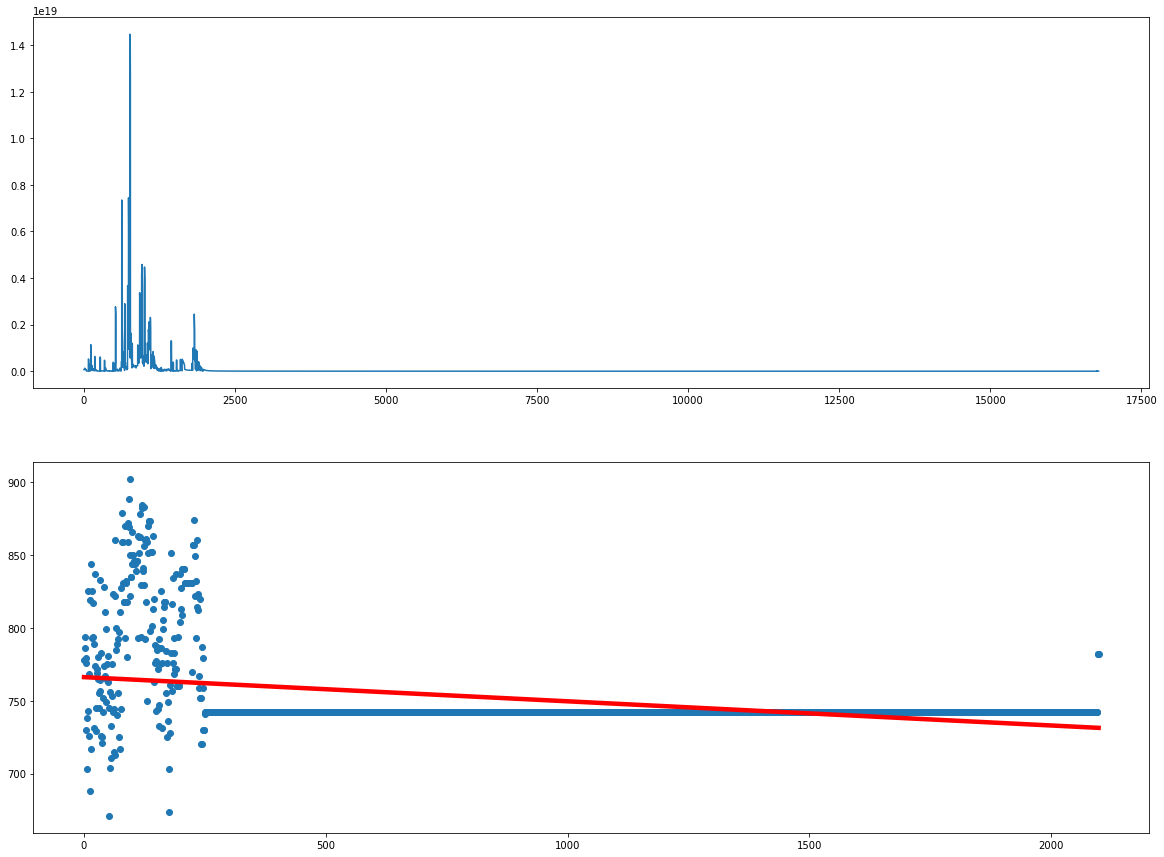

1
Epoch 2100: Current Learning Rate: [0.0004600054556149341, 0.003285753254392388], Current Success Rate: 782


/var/folders/tp/g5d5jn1j0x3d60w7kqpbj6wm0000gn/T/ipykernel_75577/2845807382.py:61: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



episode  2125  is done!


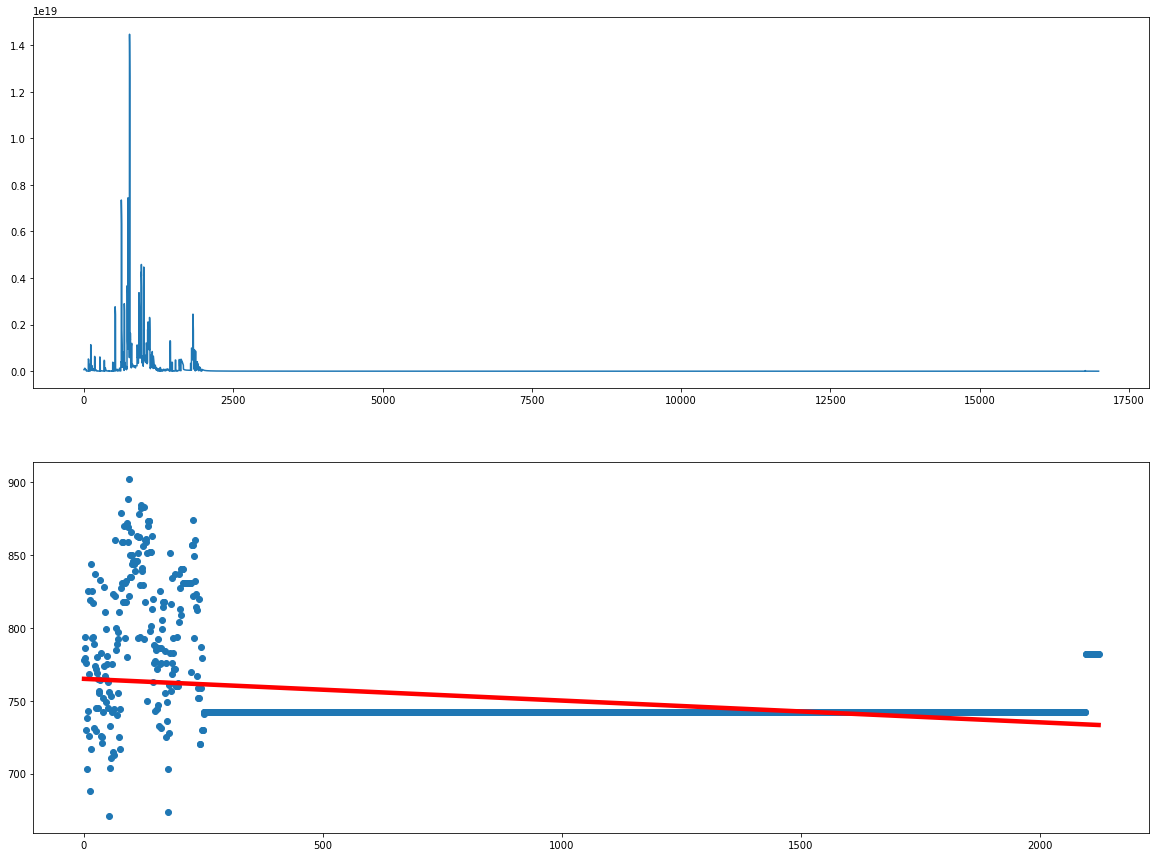

1
Epoch 2125: Current Learning Rate: [0.0004577109399475295, 0.0032693638567680688], Current Success Rate: 782


/var/folders/tp/g5d5jn1j0x3d60w7kqpbj6wm0000gn/T/ipykernel_75577/2845807382.py:61: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



episode  2150  is done!


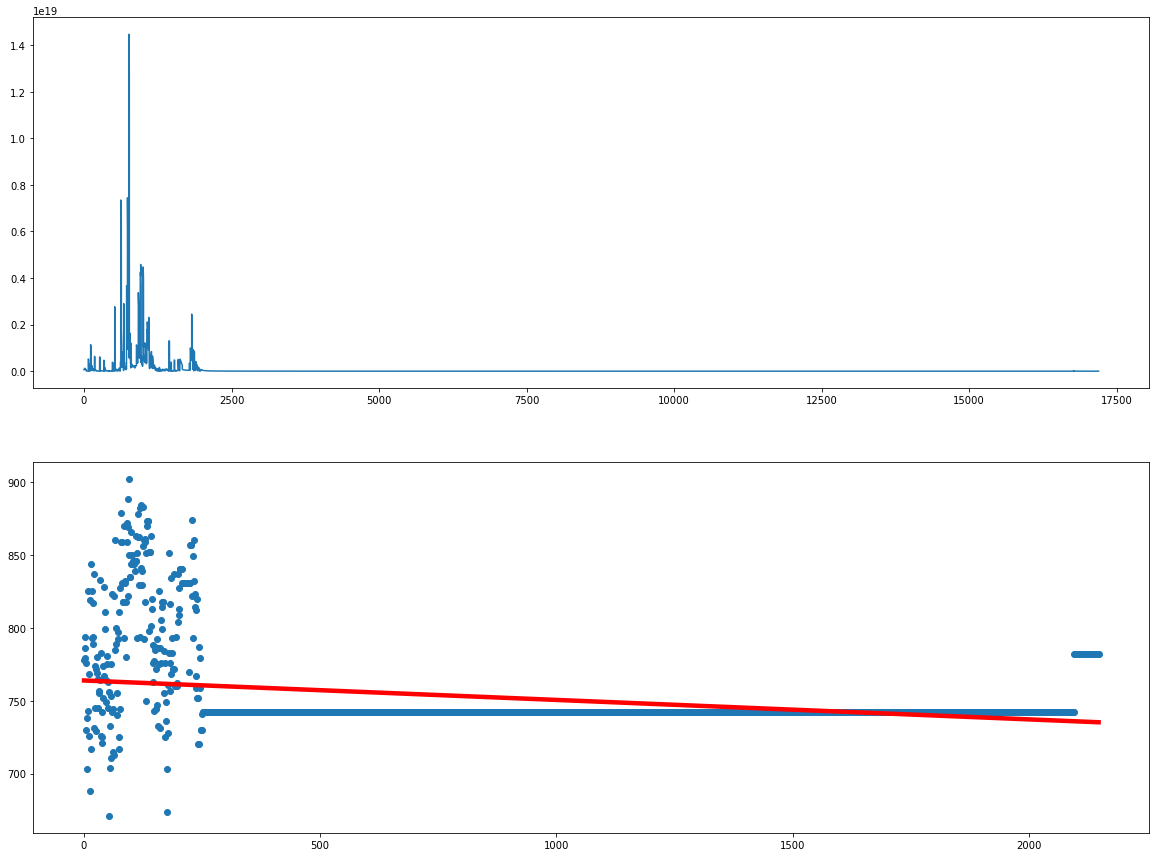

1
Epoch 2150: Current Learning Rate: [0.0004554278693664464, 0.003253056209760333], Current Success Rate: 782


/var/folders/tp/g5d5jn1j0x3d60w7kqpbj6wm0000gn/T/ipykernel_75577/2845807382.py:61: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



episode  2175  is done!


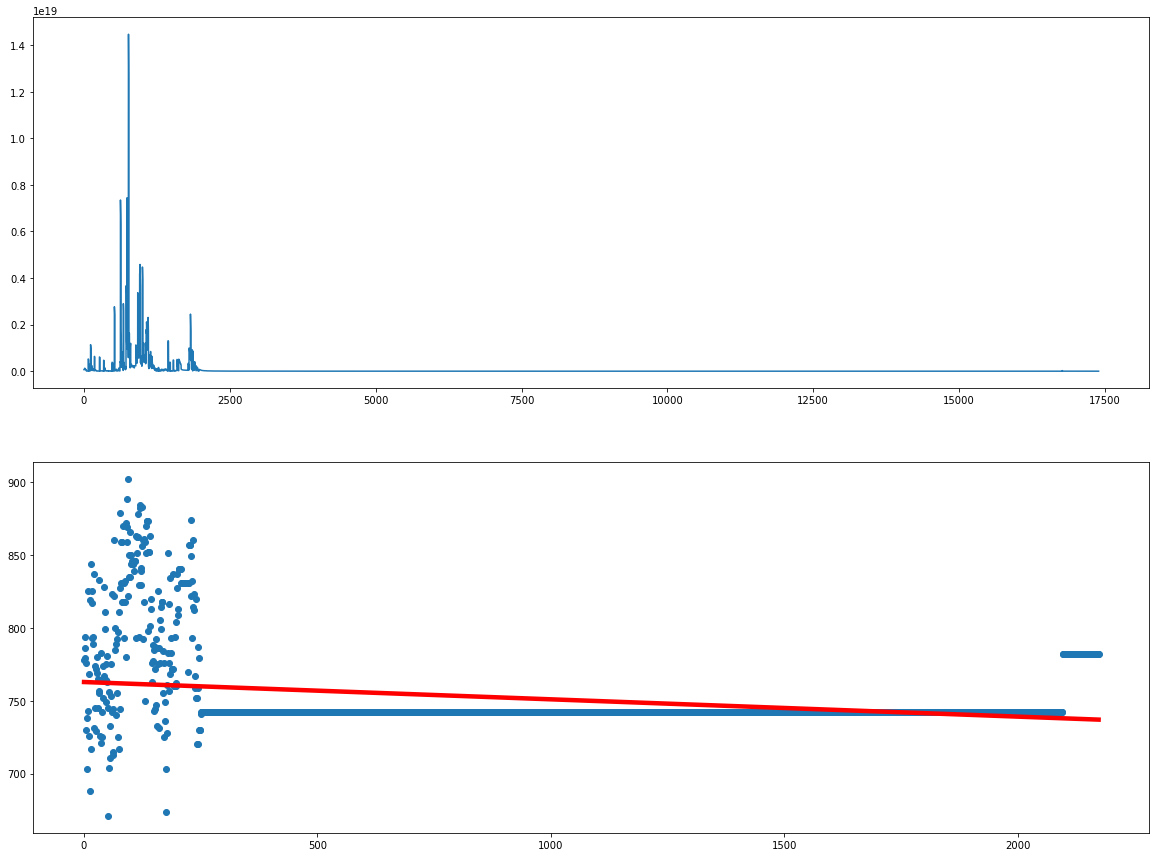

1
Epoch 2175: Current Learning Rate: [0.00045315618678338403, 0.003236829905595602], Current Success Rate: 782


/var/folders/tp/g5d5jn1j0x3d60w7kqpbj6wm0000gn/T/ipykernel_75577/2845807382.py:61: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



episode  2200  is done!


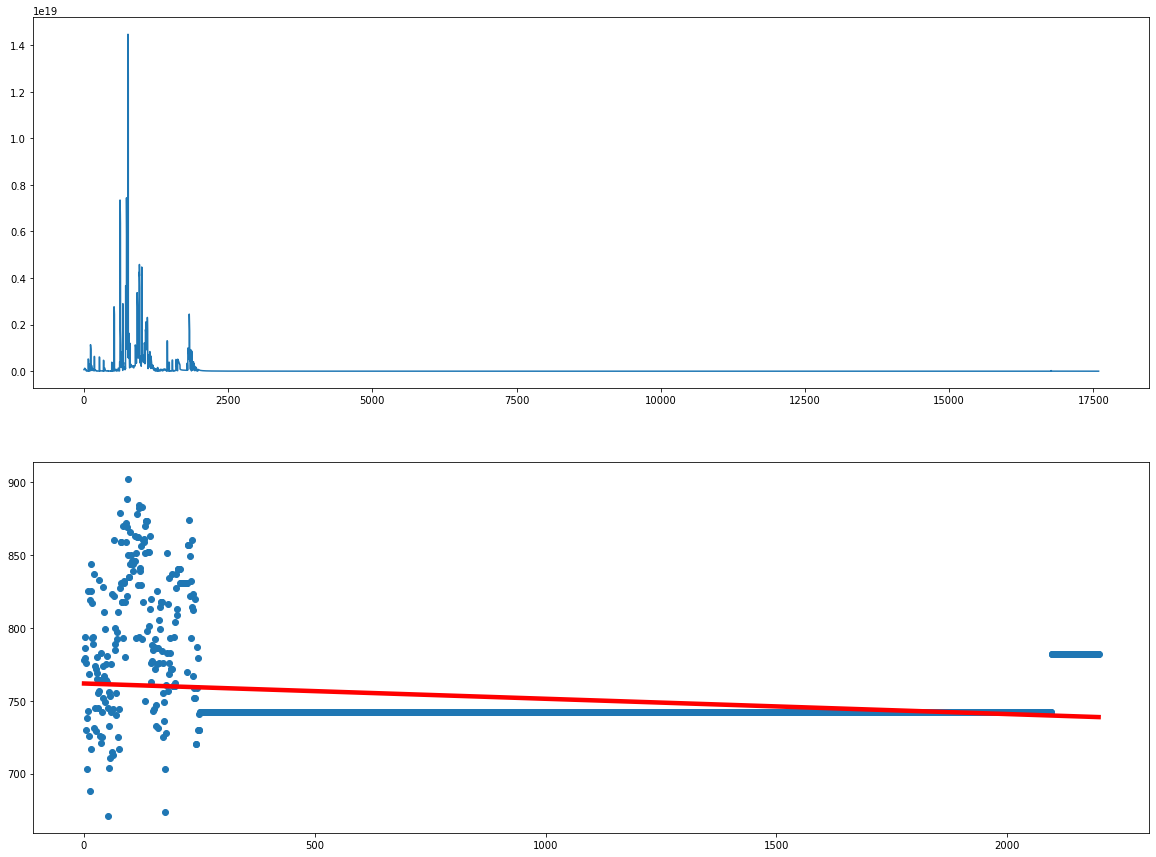

1
Epoch 2200: Current Learning Rate: [0.00045089583539479906, 0.0032206845385342807], Current Success Rate: 782


/var/folders/tp/g5d5jn1j0x3d60w7kqpbj6wm0000gn/T/ipykernel_75577/2845807382.py:61: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



episode  2225  is done!


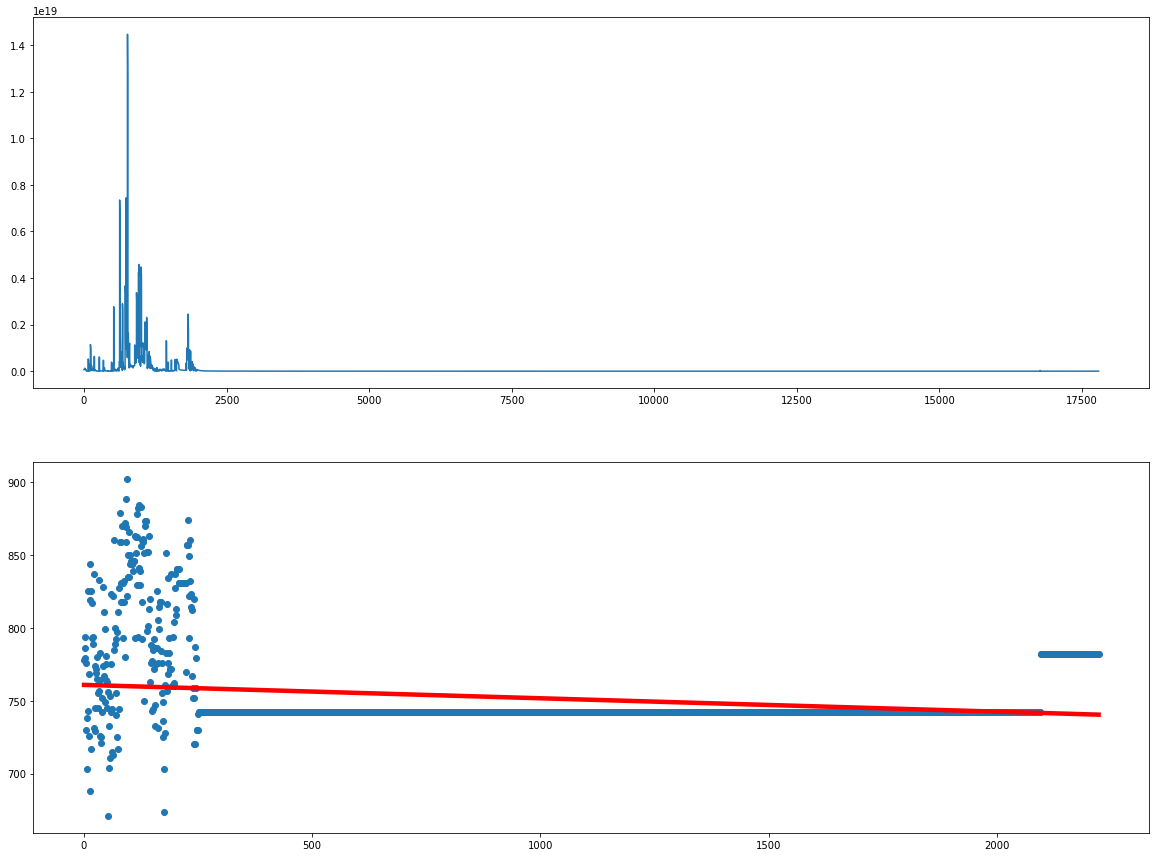

1
Epoch 2225: Current Learning Rate: [0.000448646758680485, 0.003204619704860611], Current Success Rate: 782


/var/folders/tp/g5d5jn1j0x3d60w7kqpbj6wm0000gn/T/ipykernel_75577/2845807382.py:61: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



episode  2250  is done!


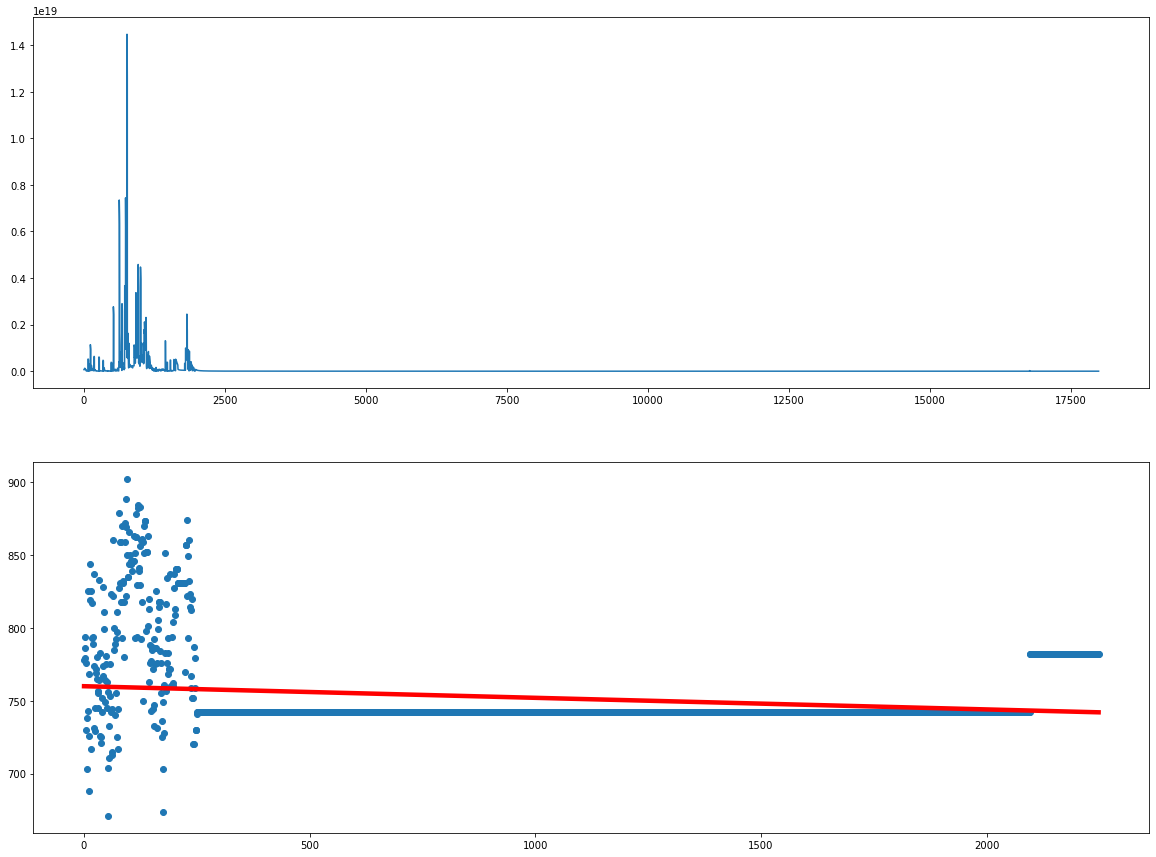

1
Epoch 2250: Current Learning Rate: [0.00044640890040215965, 0.0031886350028725733], Current Success Rate: 782


/var/folders/tp/g5d5jn1j0x3d60w7kqpbj6wm0000gn/T/ipykernel_75577/2845807382.py:61: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



episode  2275  is done!


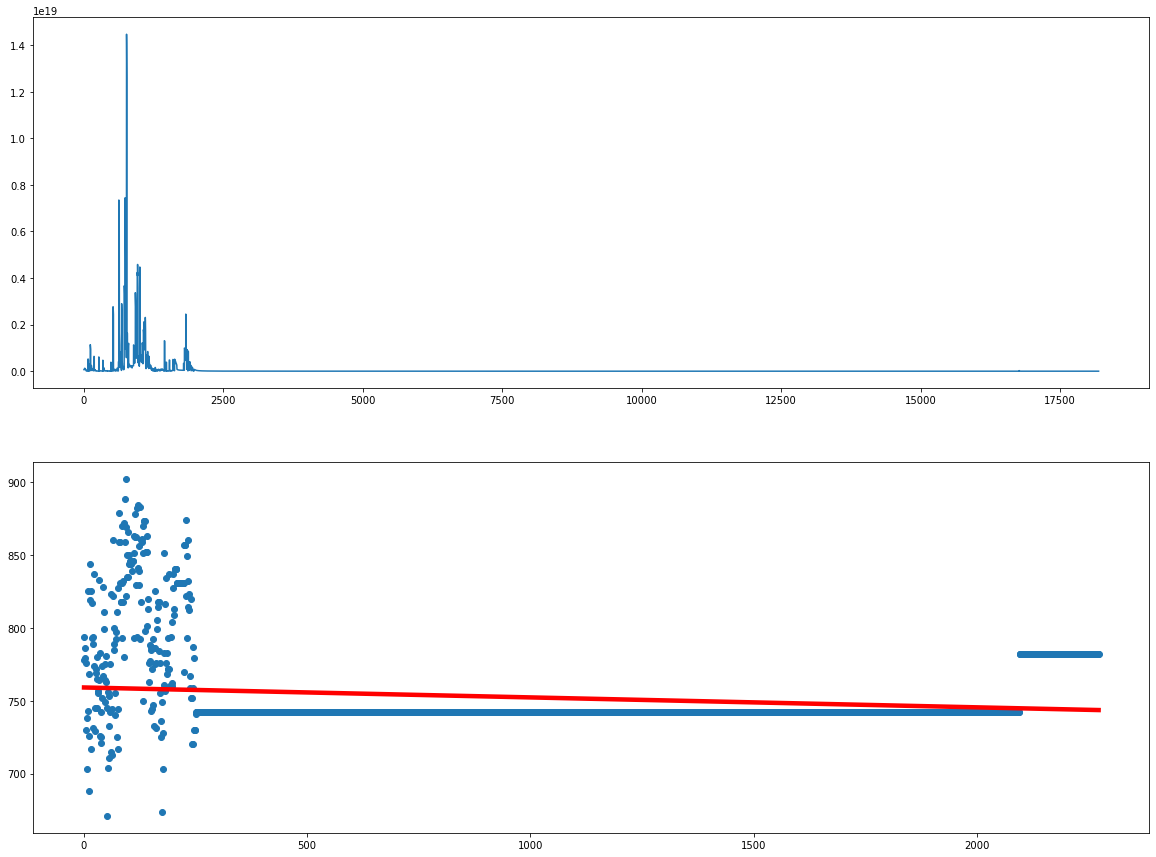

1
Epoch 2275: Current Learning Rate: [0.00044418220460205784, 0.0031727300328718458], Current Success Rate: 782


/var/folders/tp/g5d5jn1j0x3d60w7kqpbj6wm0000gn/T/ipykernel_75577/2845807382.py:61: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



episode  2300  is done!


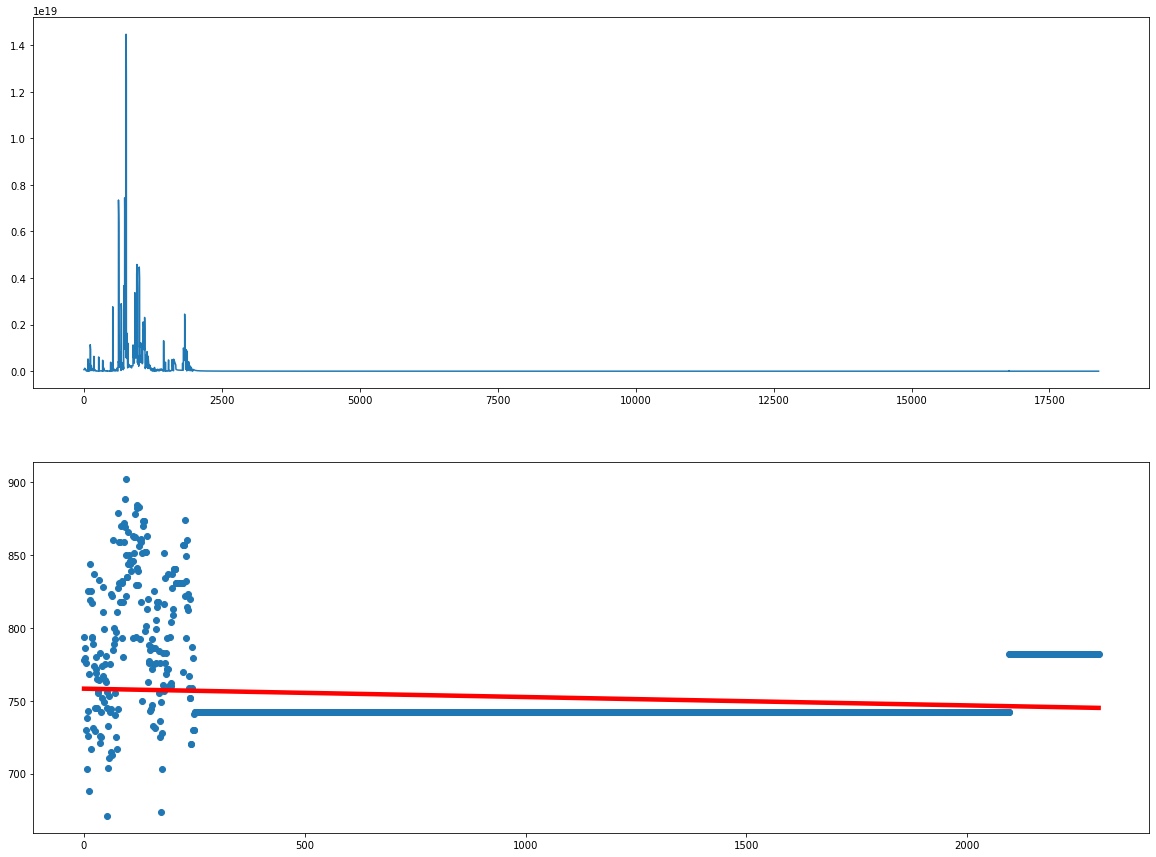

1
Epoch 2300: Current Learning Rate: [0.00044196661560153304, 0.0031569043971538127], Current Success Rate: 782


/var/folders/tp/g5d5jn1j0x3d60w7kqpbj6wm0000gn/T/ipykernel_75577/2845807382.py:61: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



episode  2325  is done!


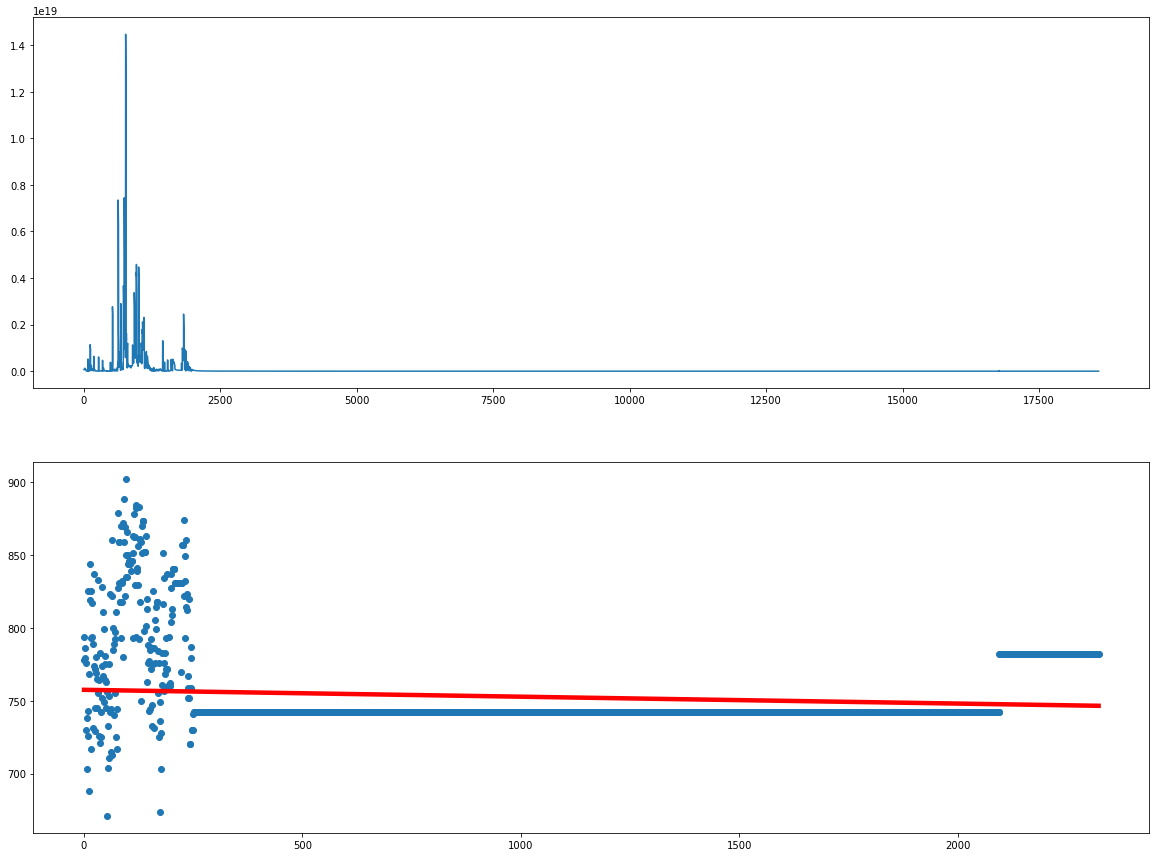

1
Epoch 2325: Current Learning Rate: [0.000439762077999665, 0.0031411576999976127], Current Success Rate: 782


/var/folders/tp/g5d5jn1j0x3d60w7kqpbj6wm0000gn/T/ipykernel_75577/2845807382.py:61: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



episode  2350  is done!


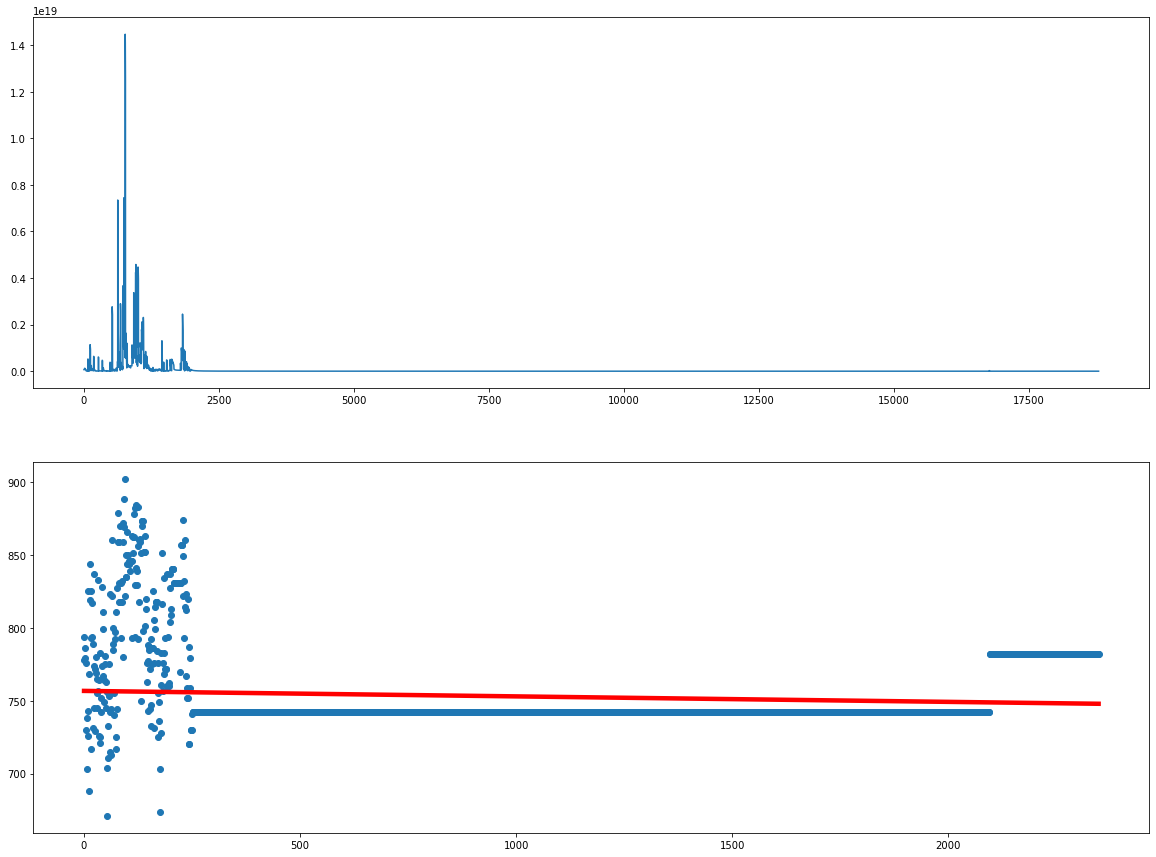

1
Epoch 2350: Current Learning Rate: [0.00043756853667187404, 0.003125489547656249], Current Success Rate: 782


/var/folders/tp/g5d5jn1j0x3d60w7kqpbj6wm0000gn/T/ipykernel_75577/2845807382.py:61: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



episode  2375  is done!


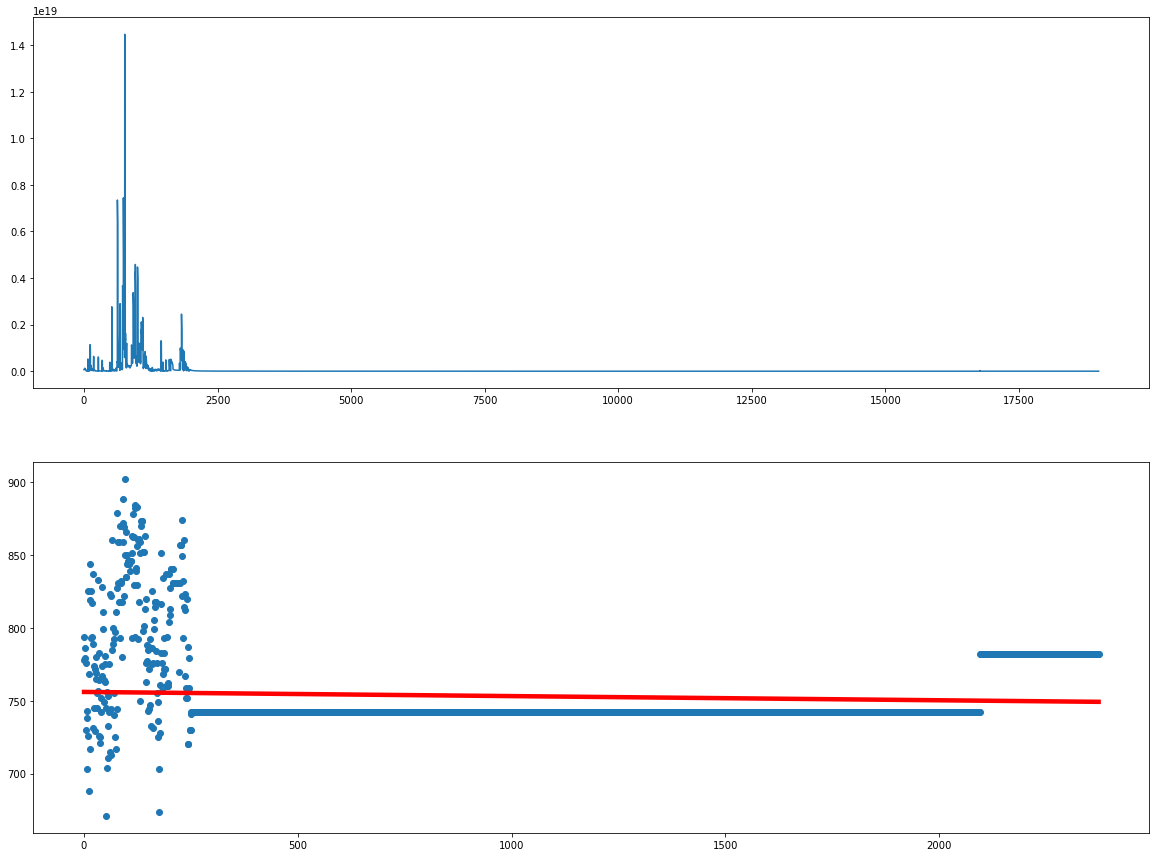

1
Epoch 2375: Current Learning Rate: [0.00043538593676854294, 0.0031098995483467406], Current Success Rate: 782


/var/folders/tp/g5d5jn1j0x3d60w7kqpbj6wm0000gn/T/ipykernel_75577/2845807382.py:61: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



episode  2400  is done!


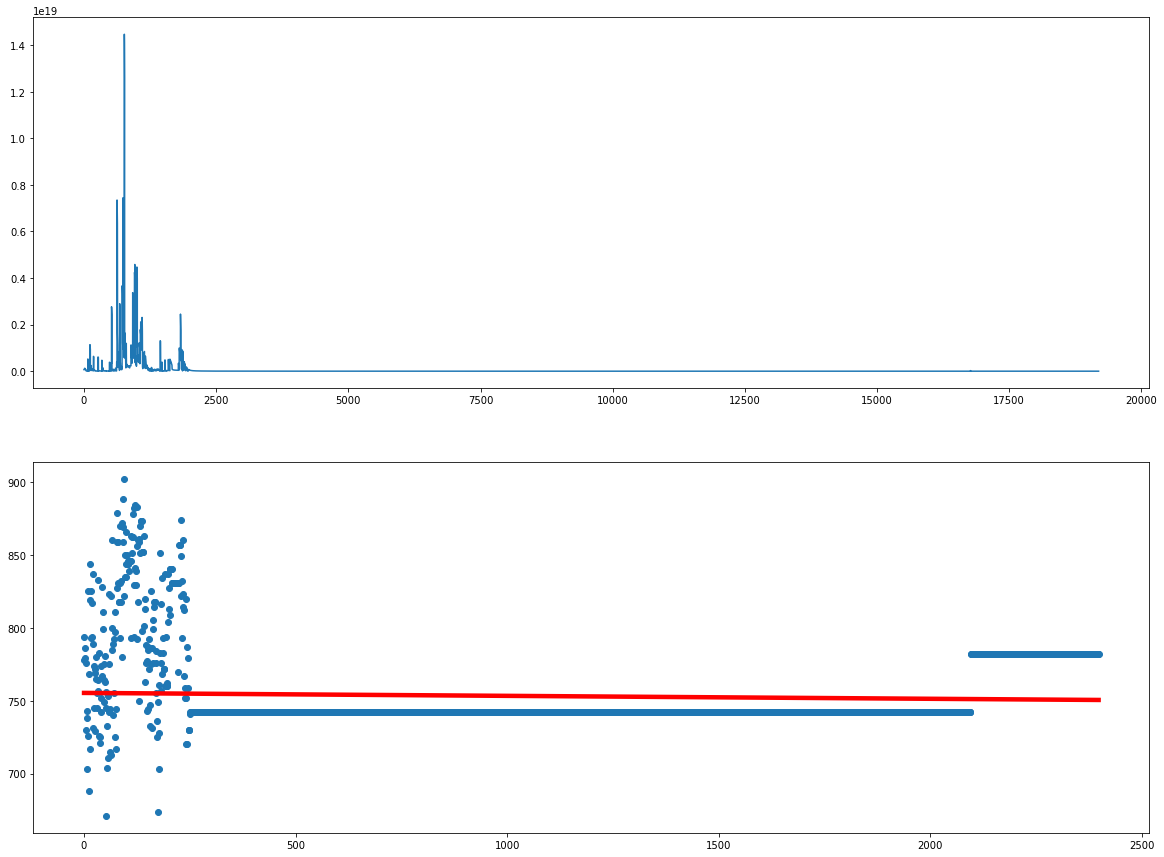

1
Epoch 2400: Current Learning Rate: [0.00043321422371364523, 0.003094387312240329], Current Success Rate: 782


/var/folders/tp/g5d5jn1j0x3d60w7kqpbj6wm0000gn/T/ipykernel_75577/2845807382.py:61: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



episode  2425  is done!


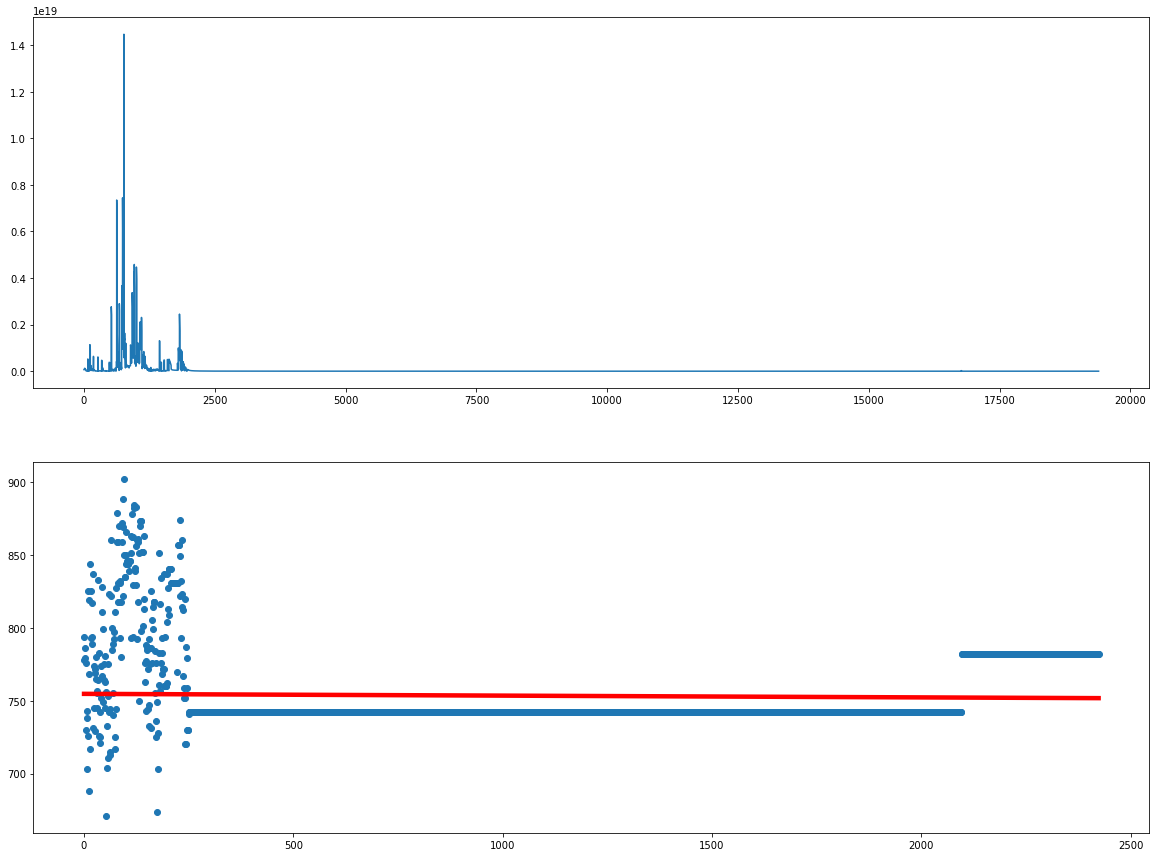

1
Epoch 2425: Current Learning Rate: [0.00043105334320338084, 0.0030789524514527283], Current Success Rate: 782


/var/folders/tp/g5d5jn1j0x3d60w7kqpbj6wm0000gn/T/ipykernel_75577/2845807382.py:61: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



episode  2450  is done!


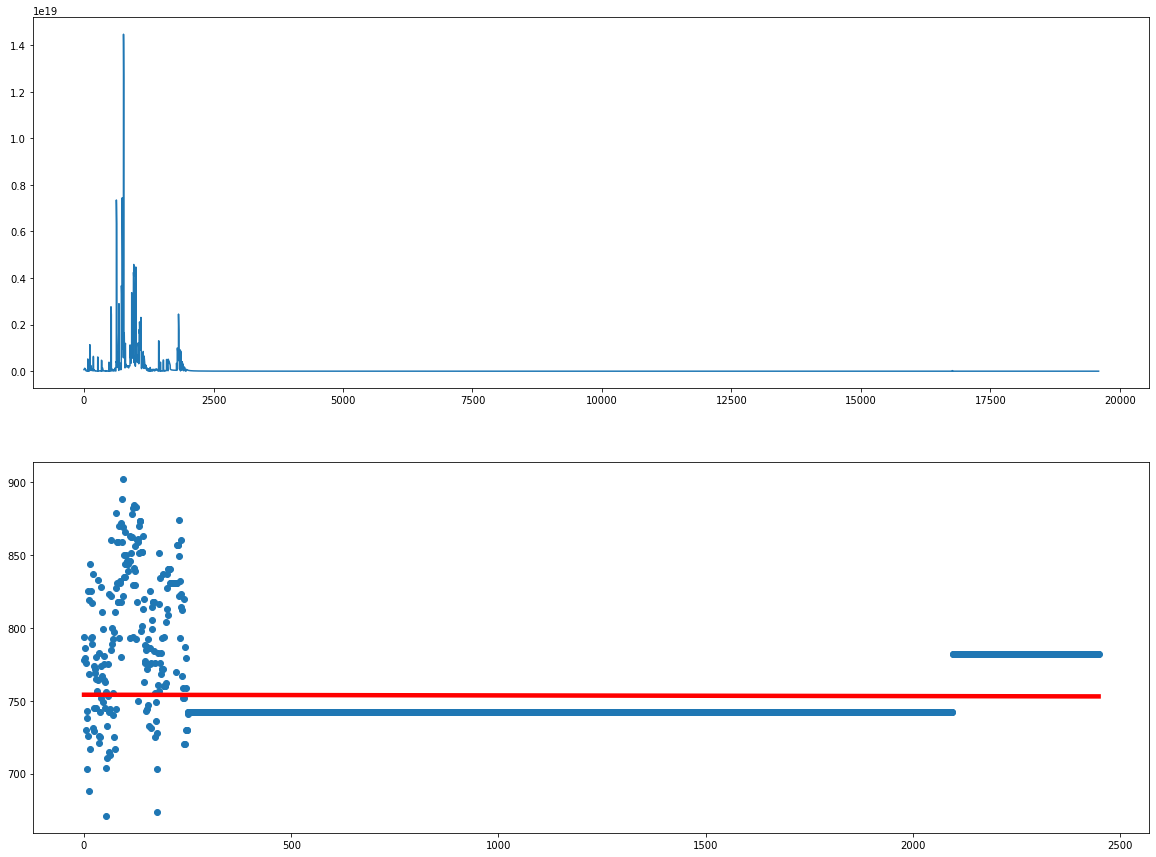

1
Epoch 2450: Current Learning Rate: [0.00042890324120481823, 0.0030635945800344244], Current Success Rate: 782


/var/folders/tp/g5d5jn1j0x3d60w7kqpbj6wm0000gn/T/ipykernel_75577/2845807382.py:61: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



episode  2475  is done!


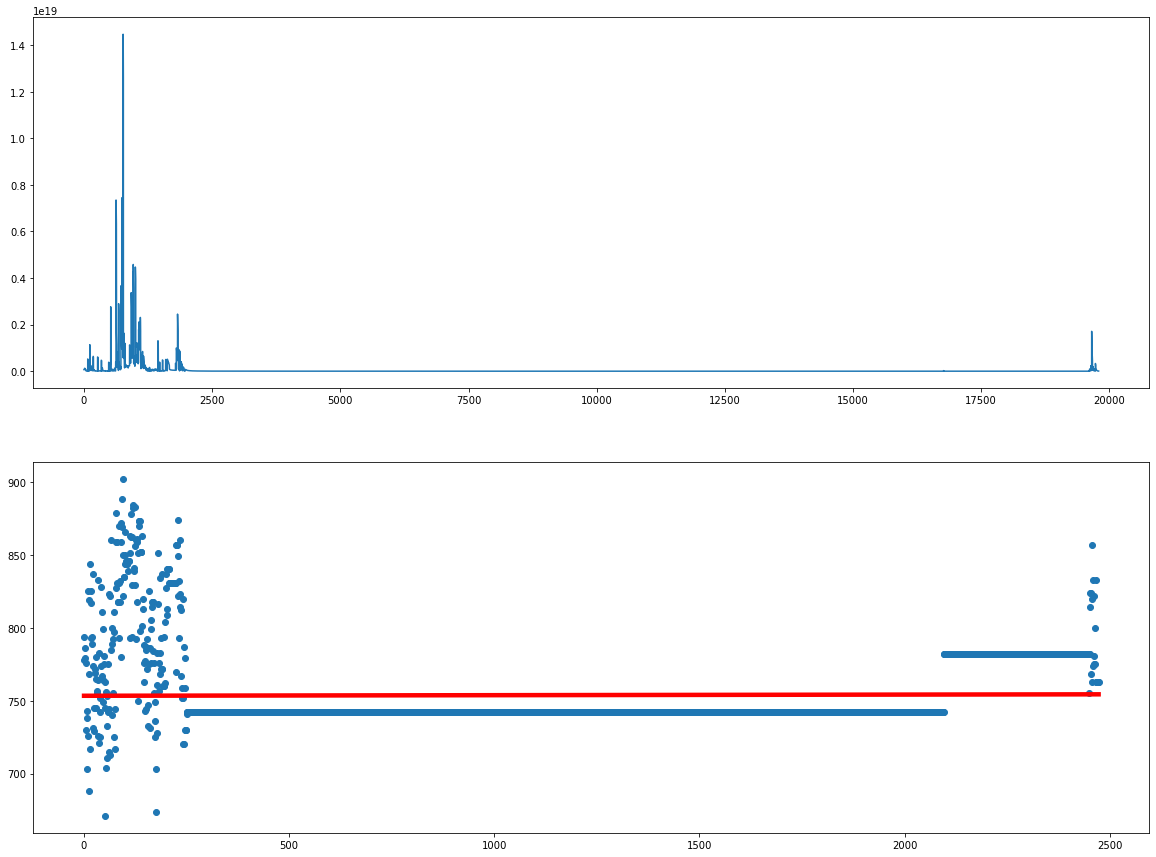

1
Epoch 2475: Current Learning Rate: [0.00042676386395454287, 0.0030483133139610295], Current Success Rate: 763


/var/folders/tp/g5d5jn1j0x3d60w7kqpbj6wm0000gn/T/ipykernel_75577/2845807382.py:61: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



episode  2500  is done!


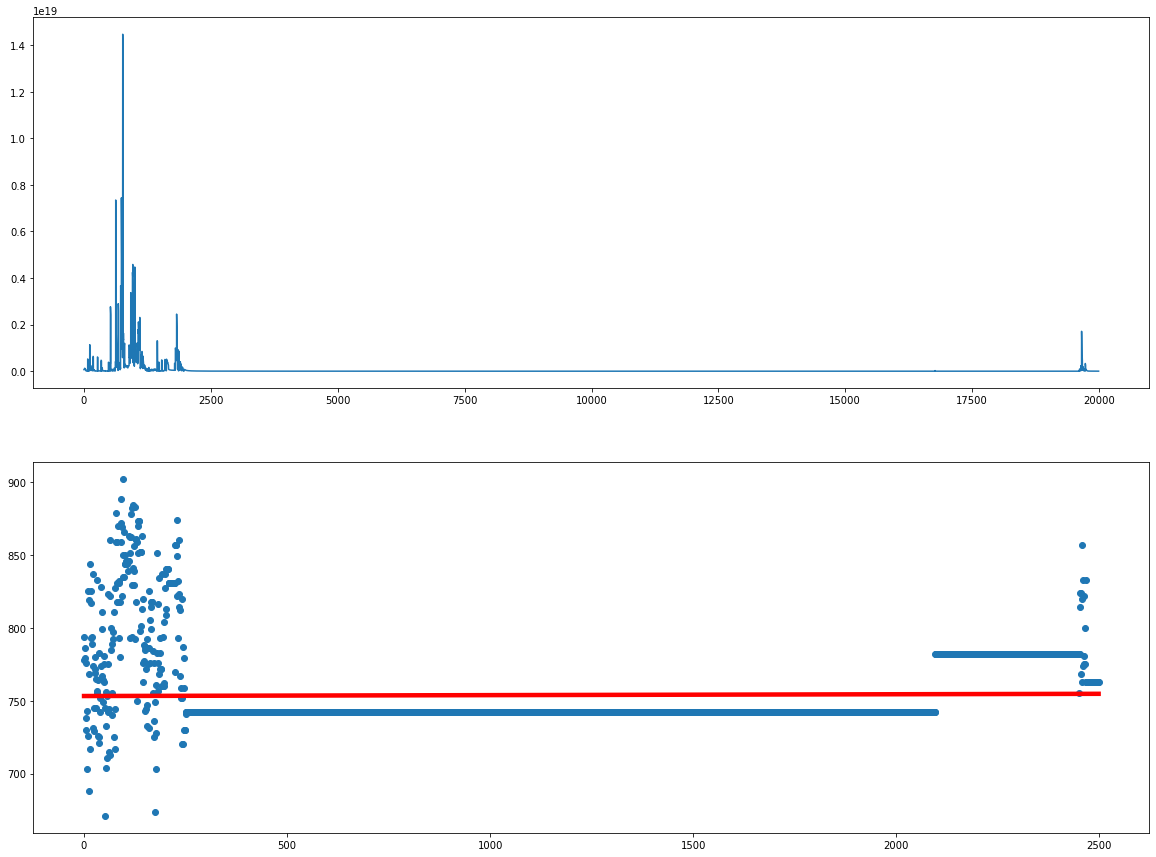

1
Epoch 2500: Current Learning Rate: [0.0004246351579573133, 0.003033108271123674], Current Success Rate: 763


/var/folders/tp/g5d5jn1j0x3d60w7kqpbj6wm0000gn/T/ipykernel_75577/2845807382.py:61: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



episode  2525  is done!


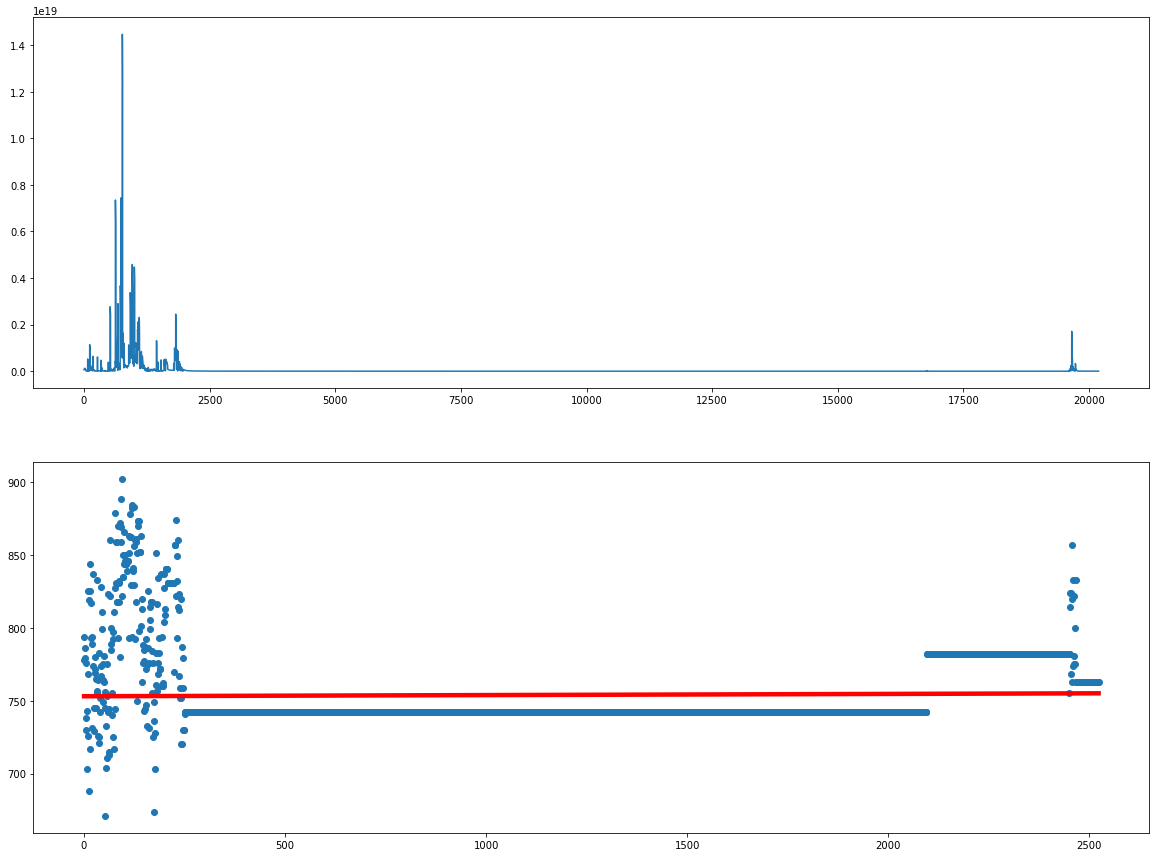

1
Epoch 2525: Current Learning Rate: [0.00042251706998472306, 0.003017979071319456], Current Success Rate: 763


/var/folders/tp/g5d5jn1j0x3d60w7kqpbj6wm0000gn/T/ipykernel_75577/2845807382.py:61: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



episode  2550  is done!


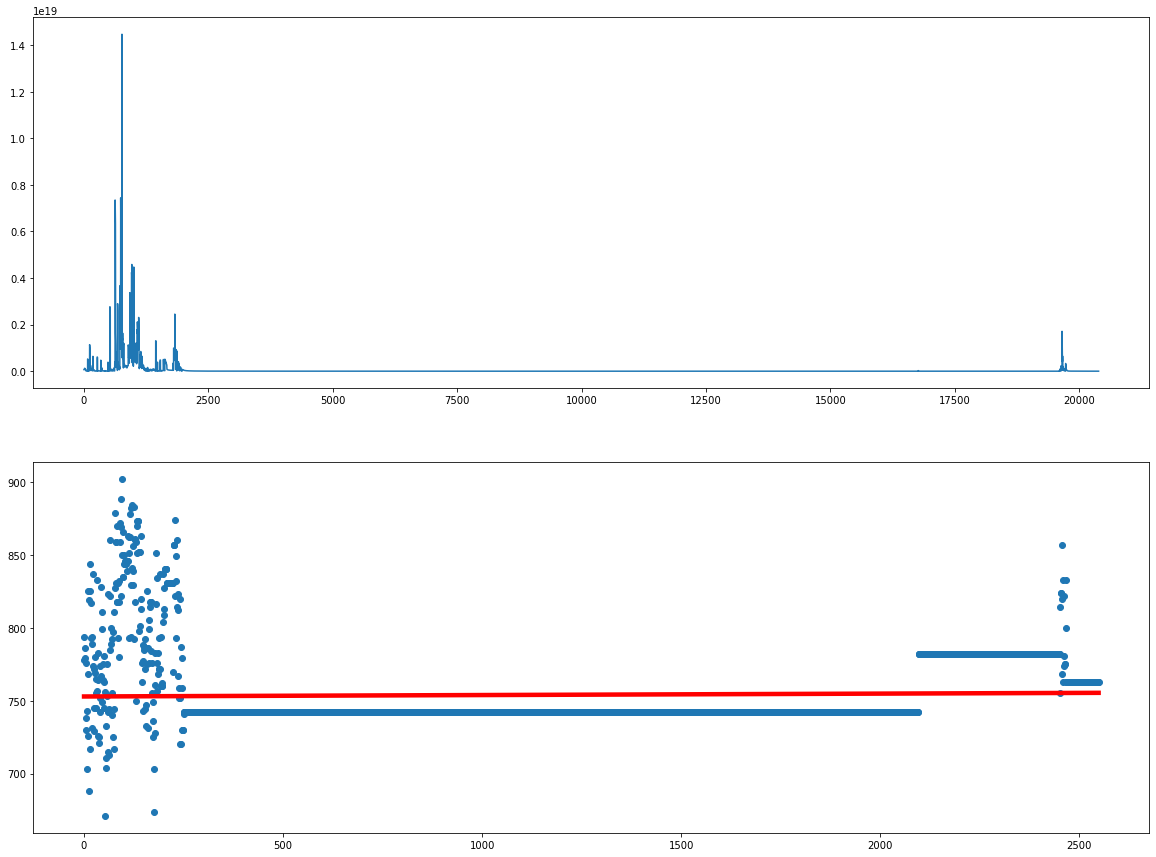

1
Epoch 2550: Current Learning Rate: [0.00042040954707386994, 0.003002925336241934], Current Success Rate: 763


/var/folders/tp/g5d5jn1j0x3d60w7kqpbj6wm0000gn/T/ipykernel_75577/2845807382.py:61: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



episode  2575  is done!


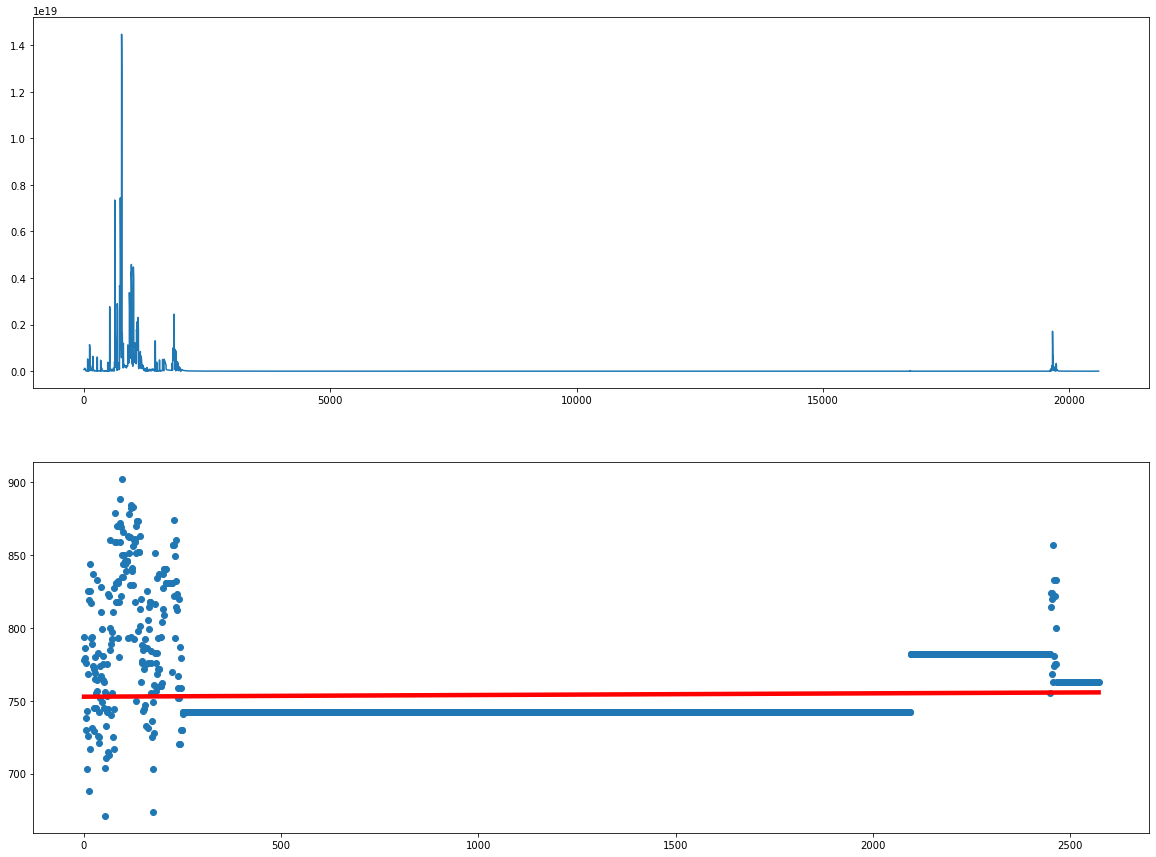

1
Epoch 2575: Current Learning Rate: [0.000418312536526032, 0.002987946689471663], Current Success Rate: 763


/var/folders/tp/g5d5jn1j0x3d60w7kqpbj6wm0000gn/T/ipykernel_75577/2845807382.py:61: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



episode  2600  is done!


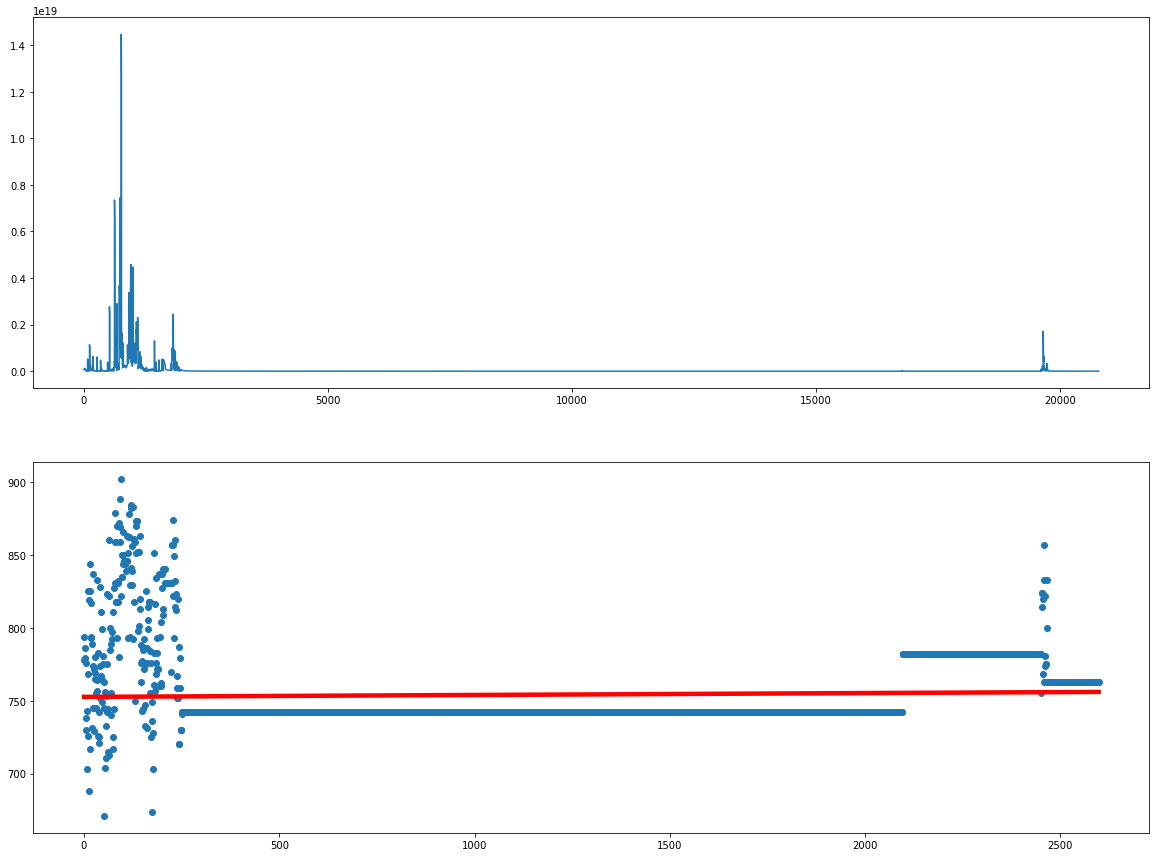

1
Epoch 2600: Current Learning Rate: [0.0004162259859053492, 0.0029730427564667863], Current Success Rate: 763


/var/folders/tp/g5d5jn1j0x3d60w7kqpbj6wm0000gn/T/ipykernel_75577/2845807382.py:61: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



episode  2625  is done!


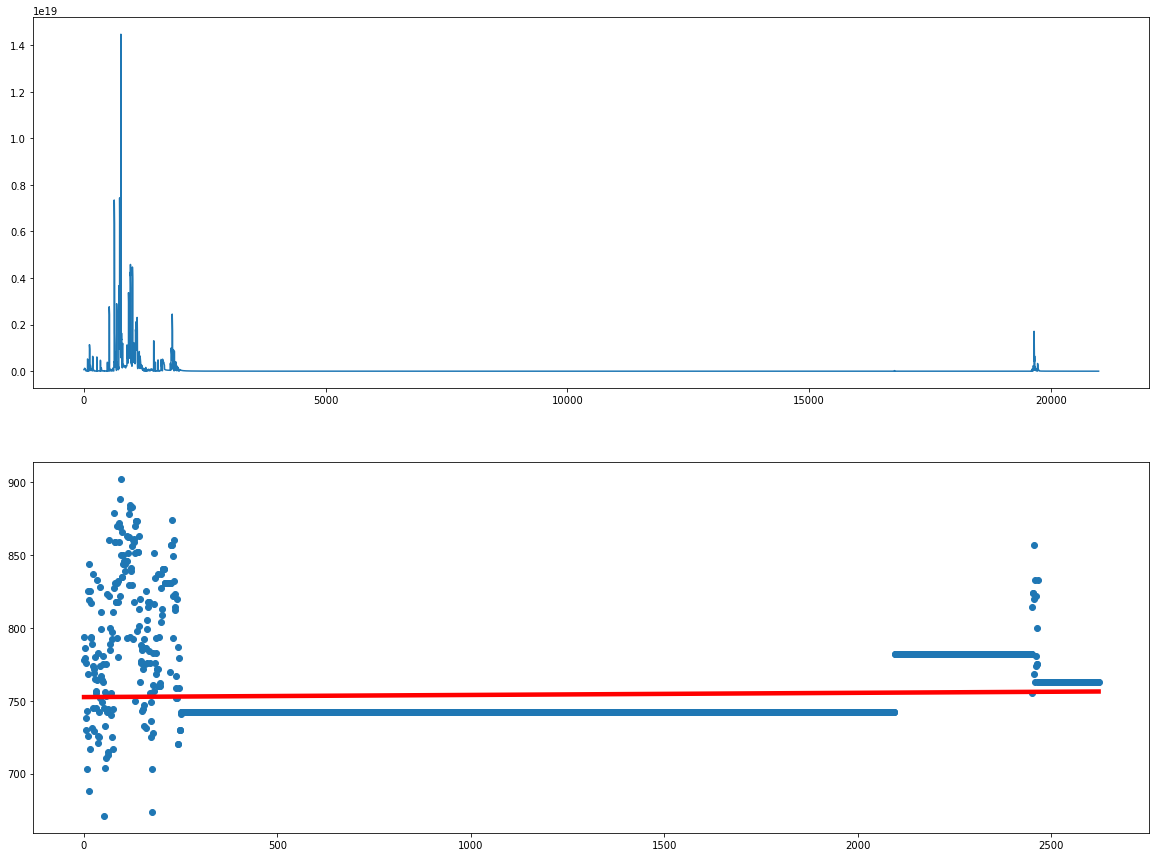

1
Epoch 2625: Current Learning Rate: [0.0004141498430375127, 0.002958213164553669], Current Success Rate: 763


/var/folders/tp/g5d5jn1j0x3d60w7kqpbj6wm0000gn/T/ipykernel_75577/2845807382.py:61: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



episode  2650  is done!


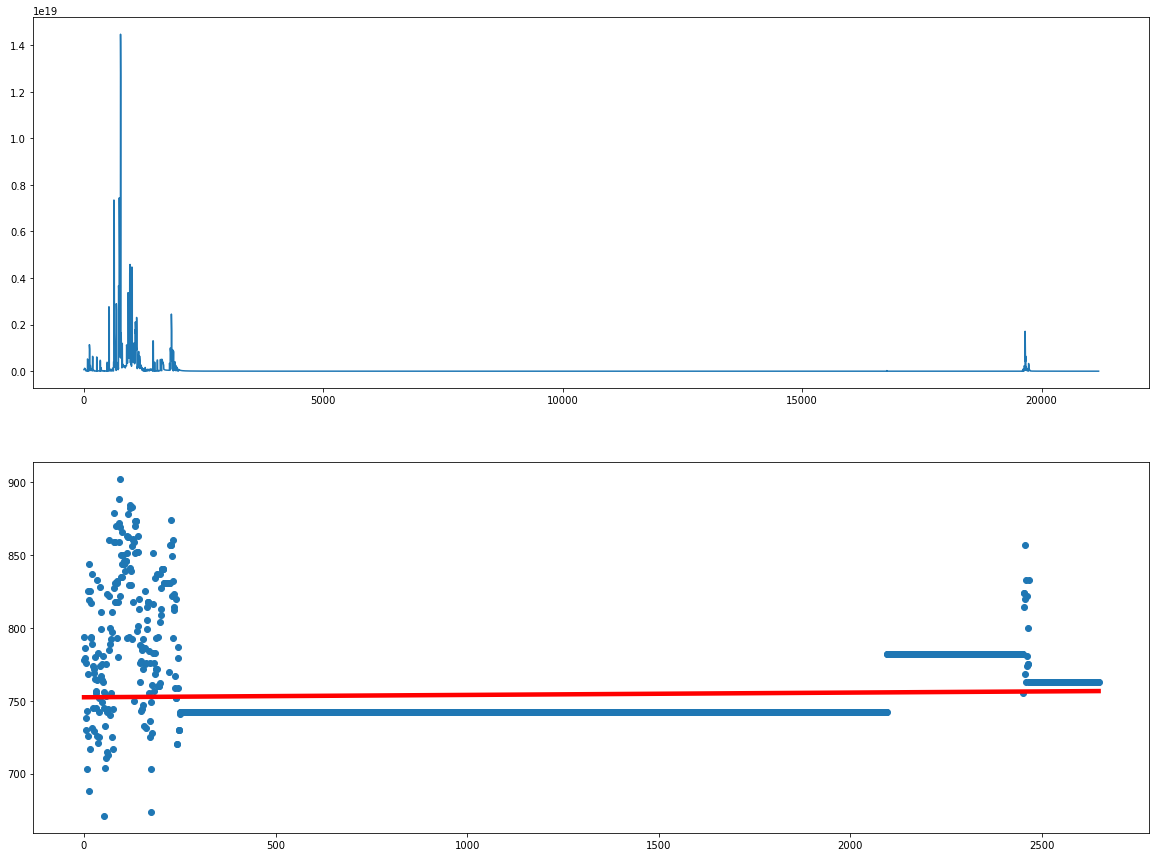

1
Epoch 2650: Current Learning Rate: [0.0004120840560084602, 0.002943457542917577], Current Success Rate: 763


/var/folders/tp/g5d5jn1j0x3d60w7kqpbj6wm0000gn/T/ipykernel_75577/2845807382.py:61: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



episode  2675  is done!


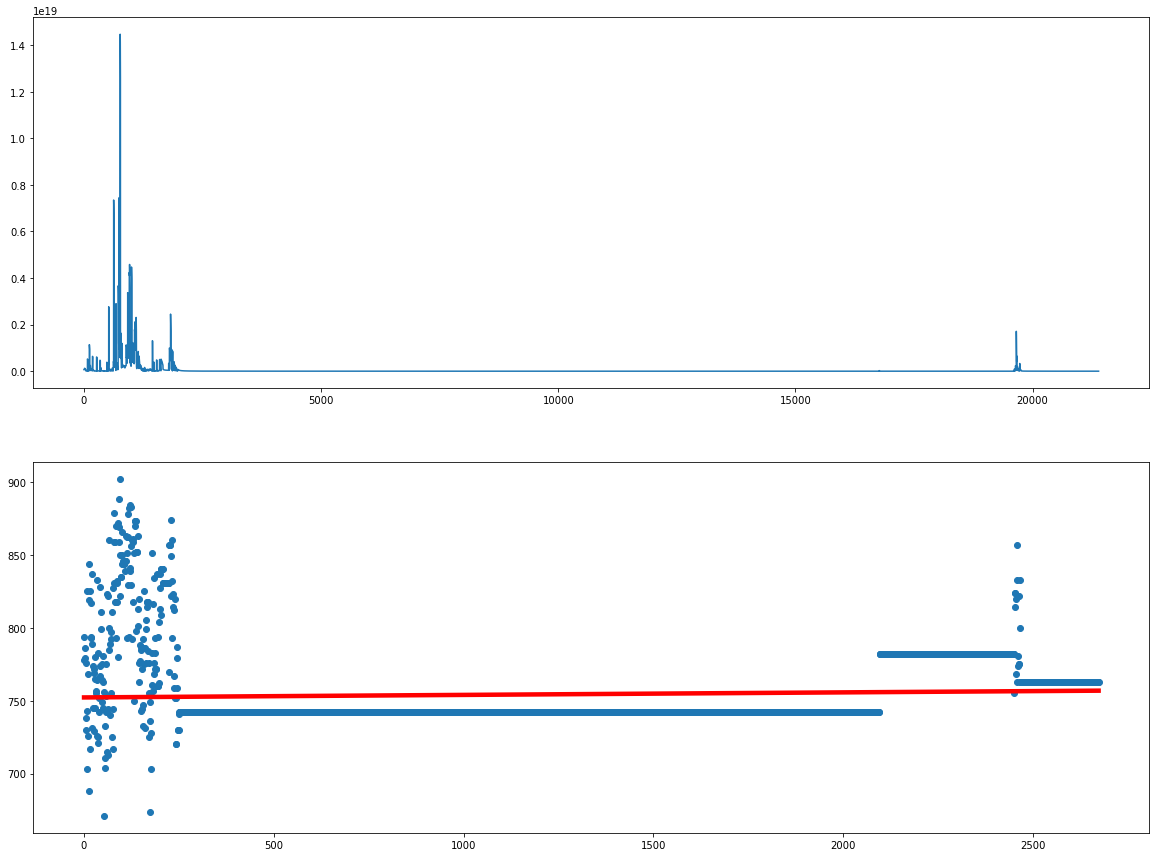

1
Epoch 2675: Current Learning Rate: [0.0004100285731630772, 0.0029287755225934123], Current Success Rate: 763


/var/folders/tp/g5d5jn1j0x3d60w7kqpbj6wm0000gn/T/ipykernel_75577/2845807382.py:61: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



episode  2700  is done!


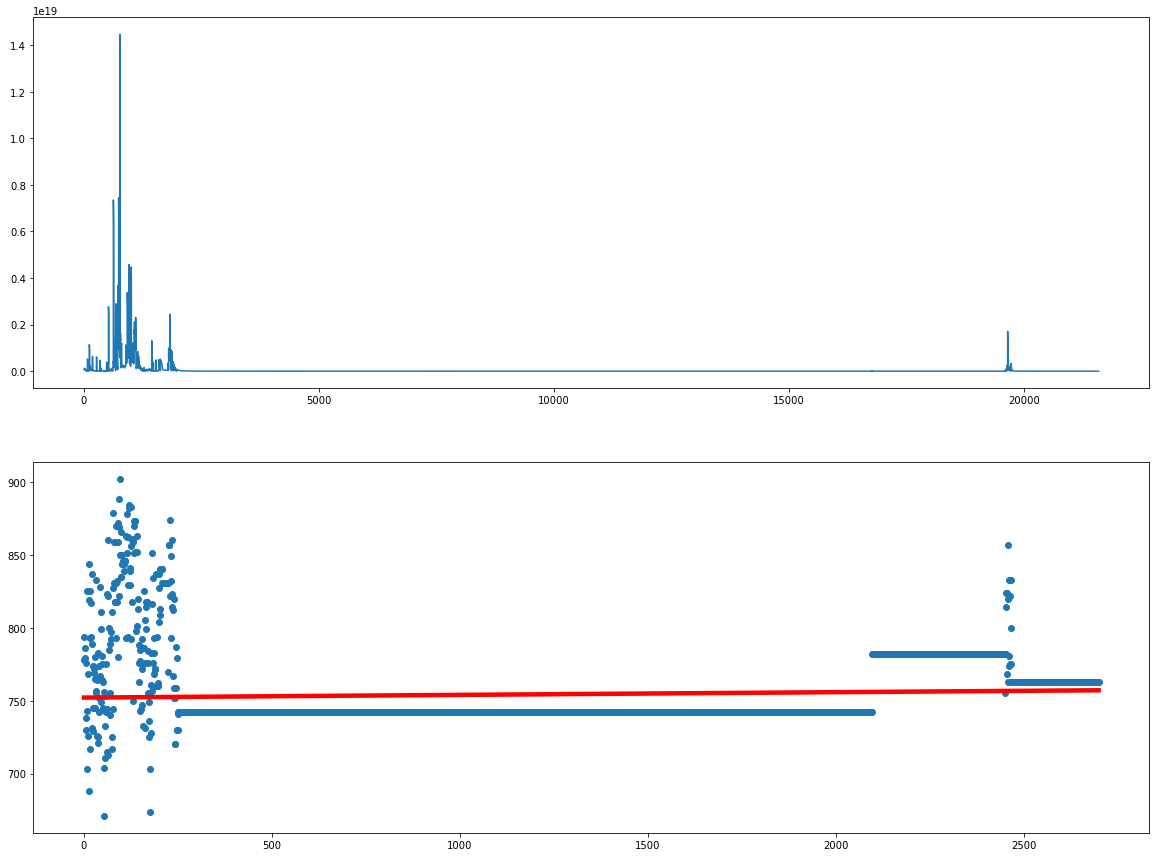

1
Epoch 2700: Current Learning Rate: [0.0004079833431039064, 0.002914166736456477], Current Success Rate: 763


/var/folders/tp/g5d5jn1j0x3d60w7kqpbj6wm0000gn/T/ipykernel_75577/2845807382.py:61: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



episode  2725  is done!


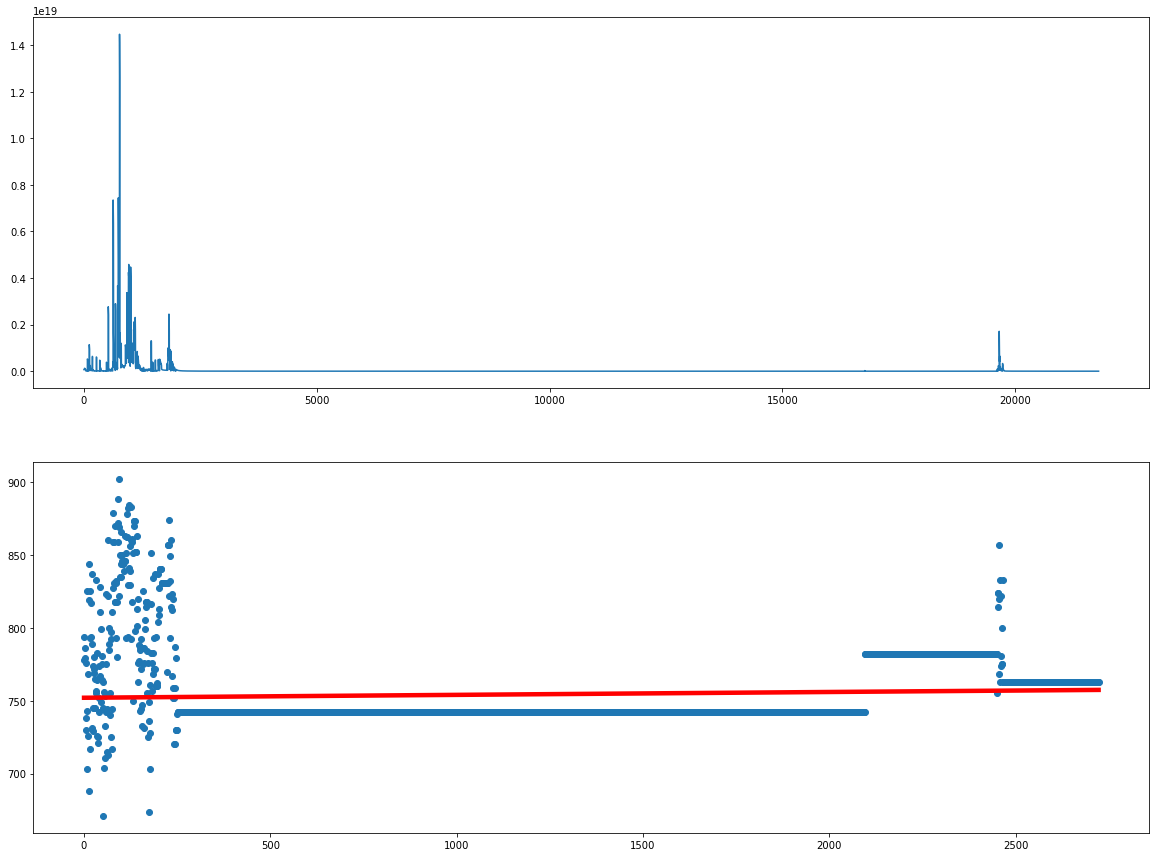

1
Epoch 2725: Current Learning Rate: [0.0004059483146898614, 0.002899630819213299], Current Success Rate: 763


/var/folders/tp/g5d5jn1j0x3d60w7kqpbj6wm0000gn/T/ipykernel_75577/2845807382.py:61: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



episode  2750  is done!


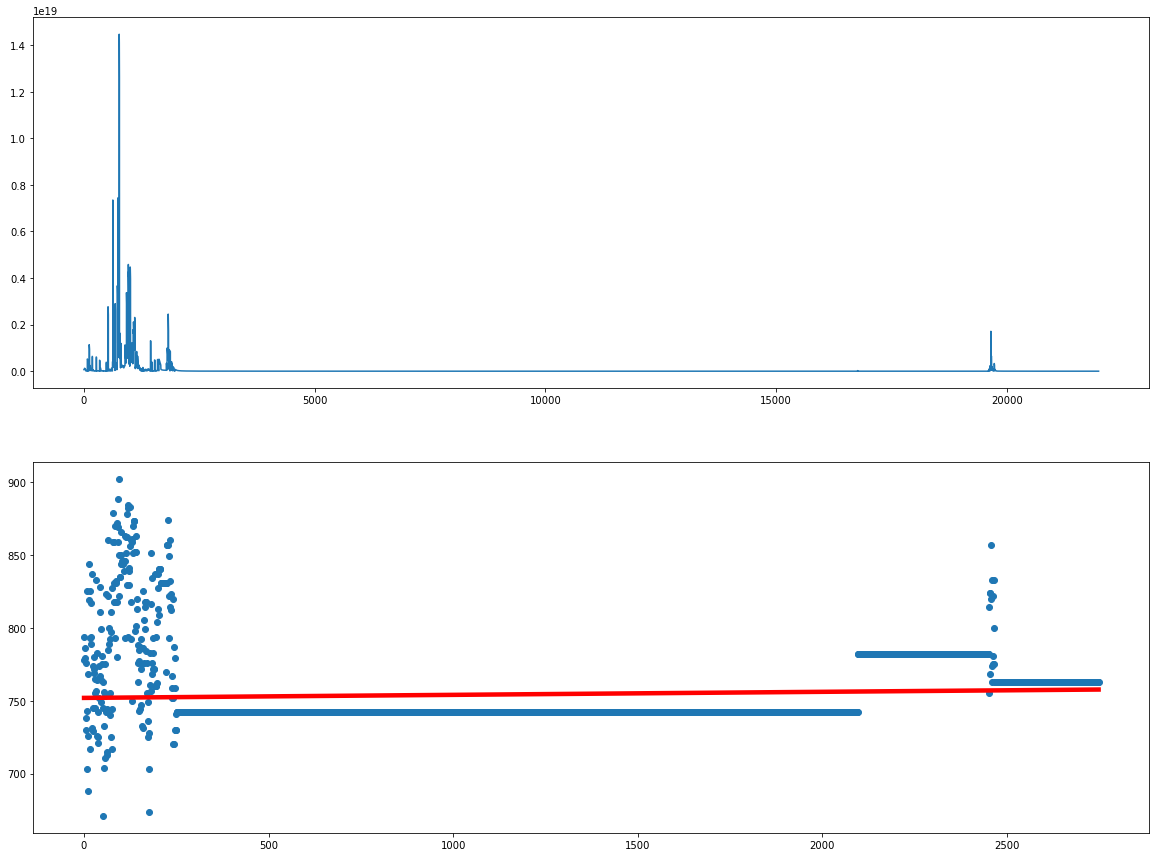

1
Epoch 2750: Current Learning Rate: [0.00040392343703494923, 0.0028851674073924966], Current Success Rate: 763


/var/folders/tp/g5d5jn1j0x3d60w7kqpbj6wm0000gn/T/ipykernel_75577/2845807382.py:61: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



episode  2775  is done!


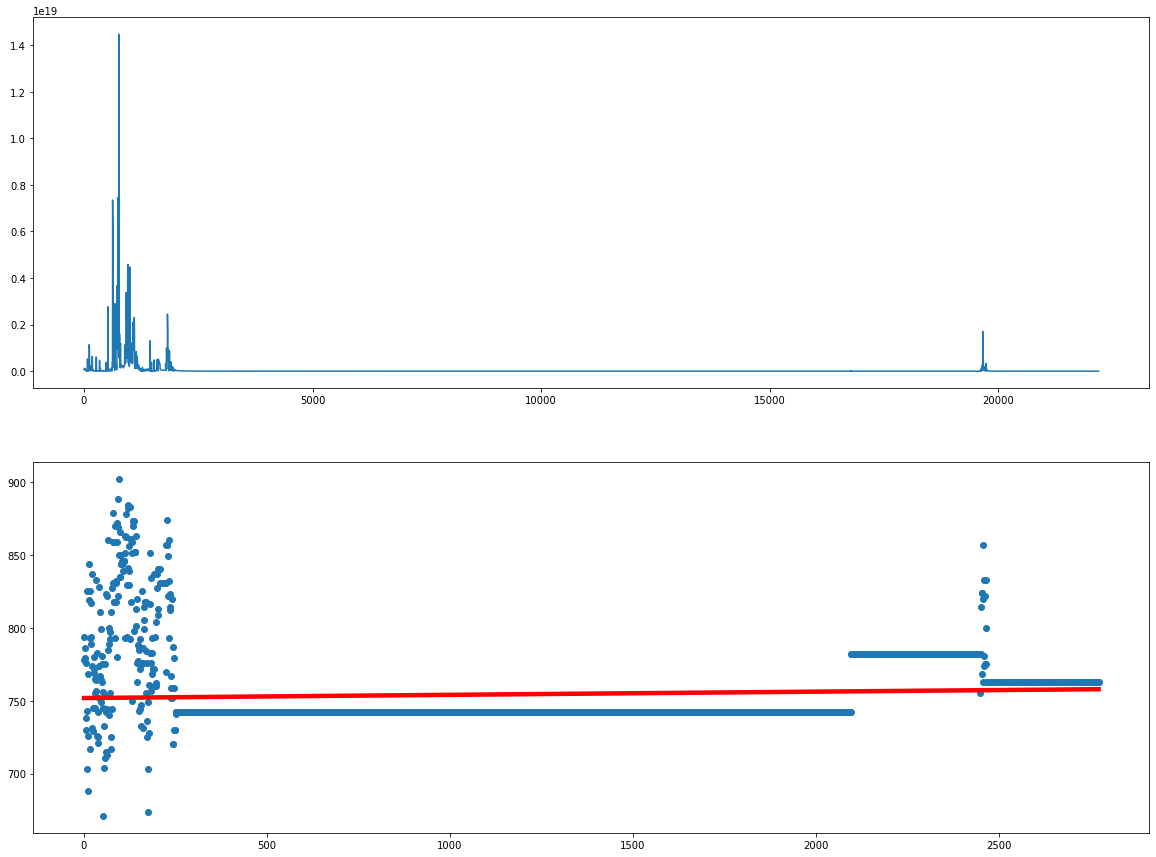

1
Epoch 2775: Current Learning Rate: [0.00040190865950699646, 0.002870776139335691], Current Success Rate: 763


/var/folders/tp/g5d5jn1j0x3d60w7kqpbj6wm0000gn/T/ipykernel_75577/2845807382.py:61: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



episode  2800  is done!


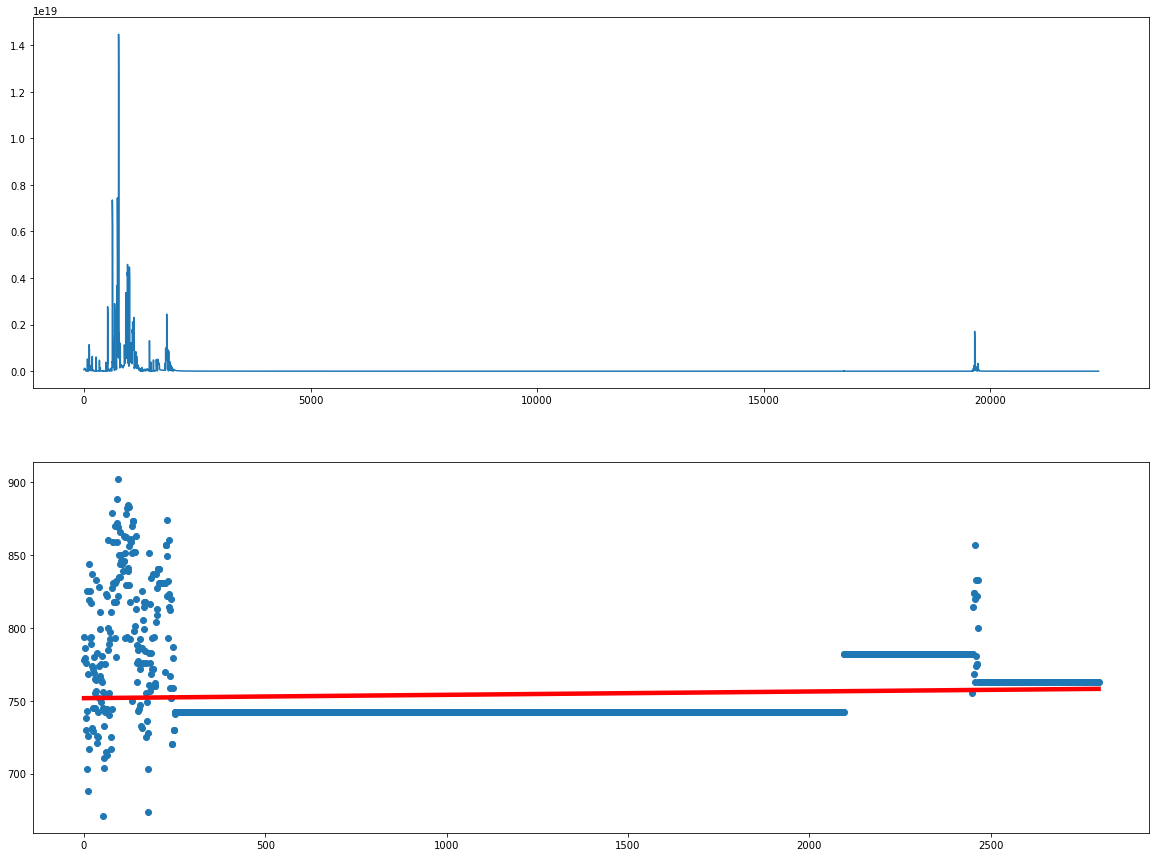

1
Epoch 2800: Current Learning Rate: [0.00039990393172638426, 0.002856456655188461], Current Success Rate: 763


/var/folders/tp/g5d5jn1j0x3d60w7kqpbj6wm0000gn/T/ipykernel_75577/2845807382.py:61: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



episode  2825  is done!


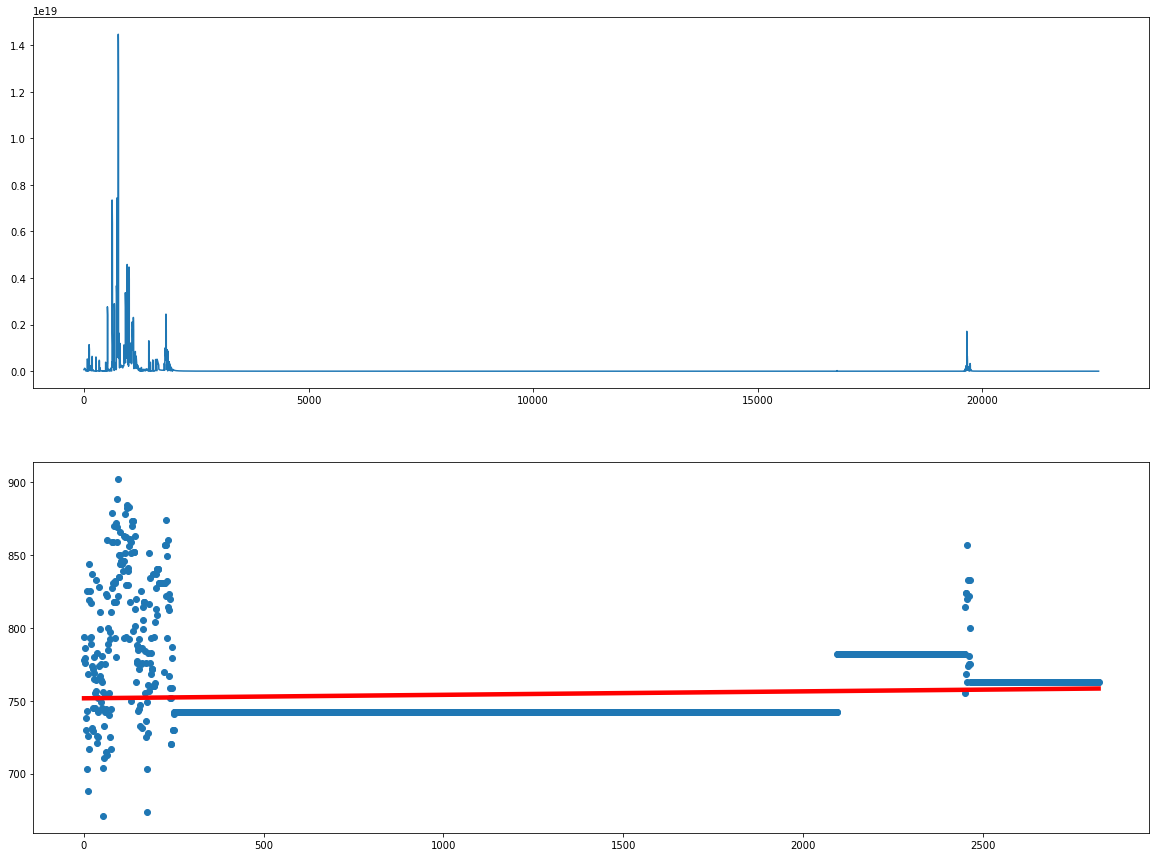

1
Epoch 2825: Current Learning Rate: [0.00039790920356478824, 0.0028422085968913464], Current Success Rate: 763


/var/folders/tp/g5d5jn1j0x3d60w7kqpbj6wm0000gn/T/ipykernel_75577/2845807382.py:61: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



episode  2850  is done!


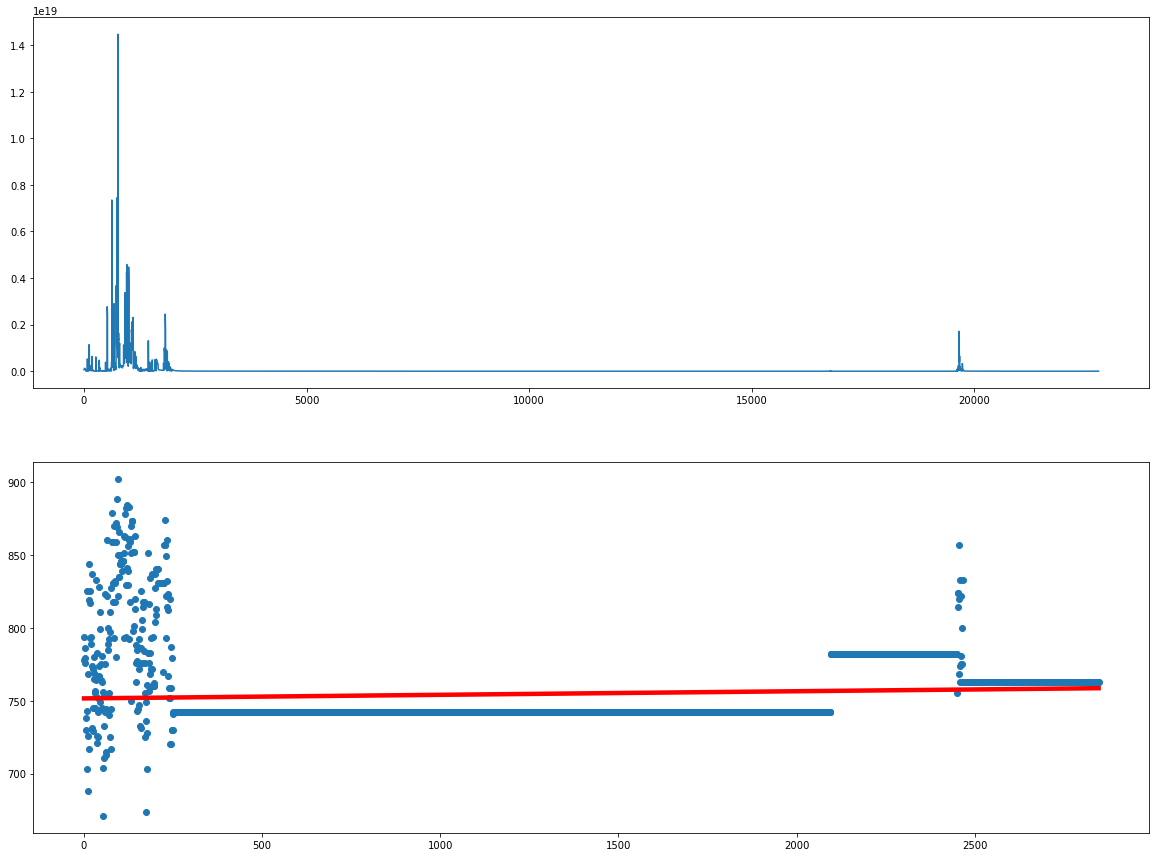

1
Epoch 2850: Current Learning Rate: [0.00039592442514392476, 0.002828031608170894], Current Success Rate: 763


/var/folders/tp/g5d5jn1j0x3d60w7kqpbj6wm0000gn/T/ipykernel_75577/2845807382.py:61: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



episode  2875  is done!


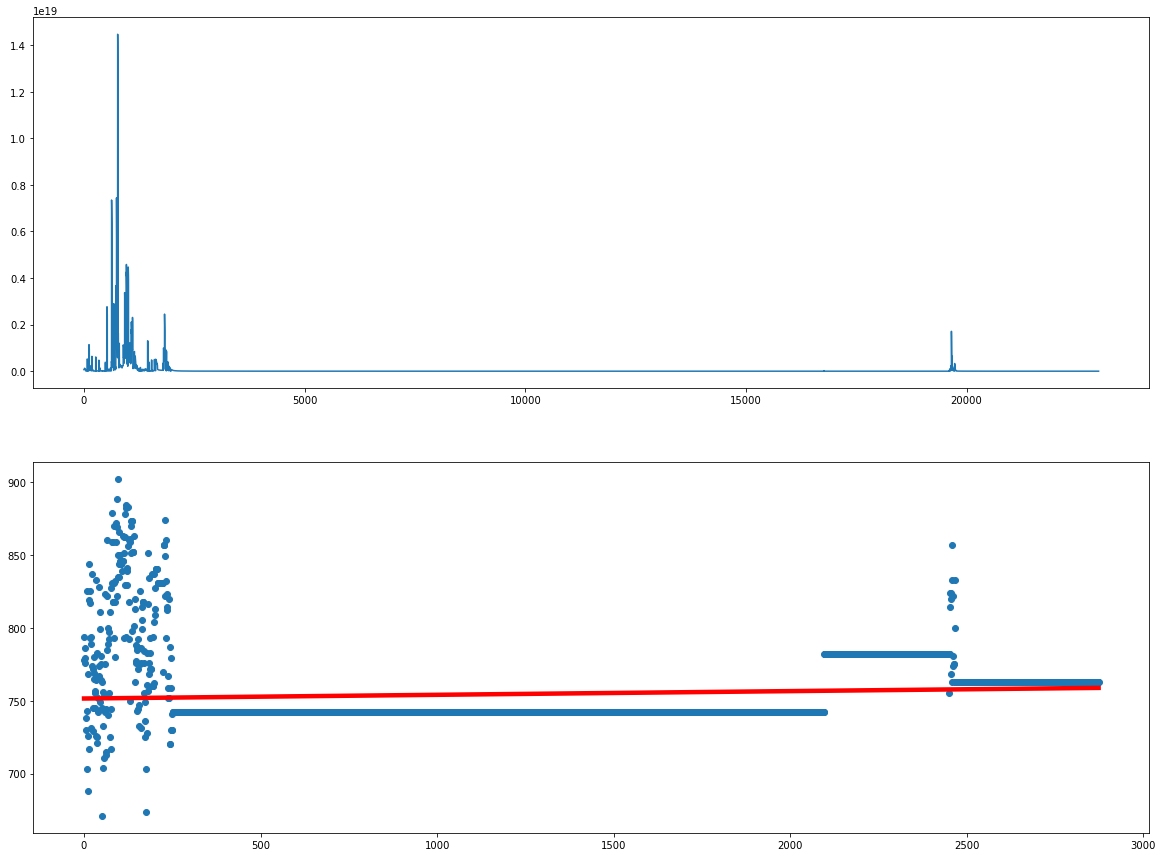

1
Epoch 2875: Current Learning Rate: [0.0003939495468343044, 0.002813925334530748], Current Success Rate: 763


/var/folders/tp/g5d5jn1j0x3d60w7kqpbj6wm0000gn/T/ipykernel_75577/2845807382.py:61: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



episode  2900  is done!


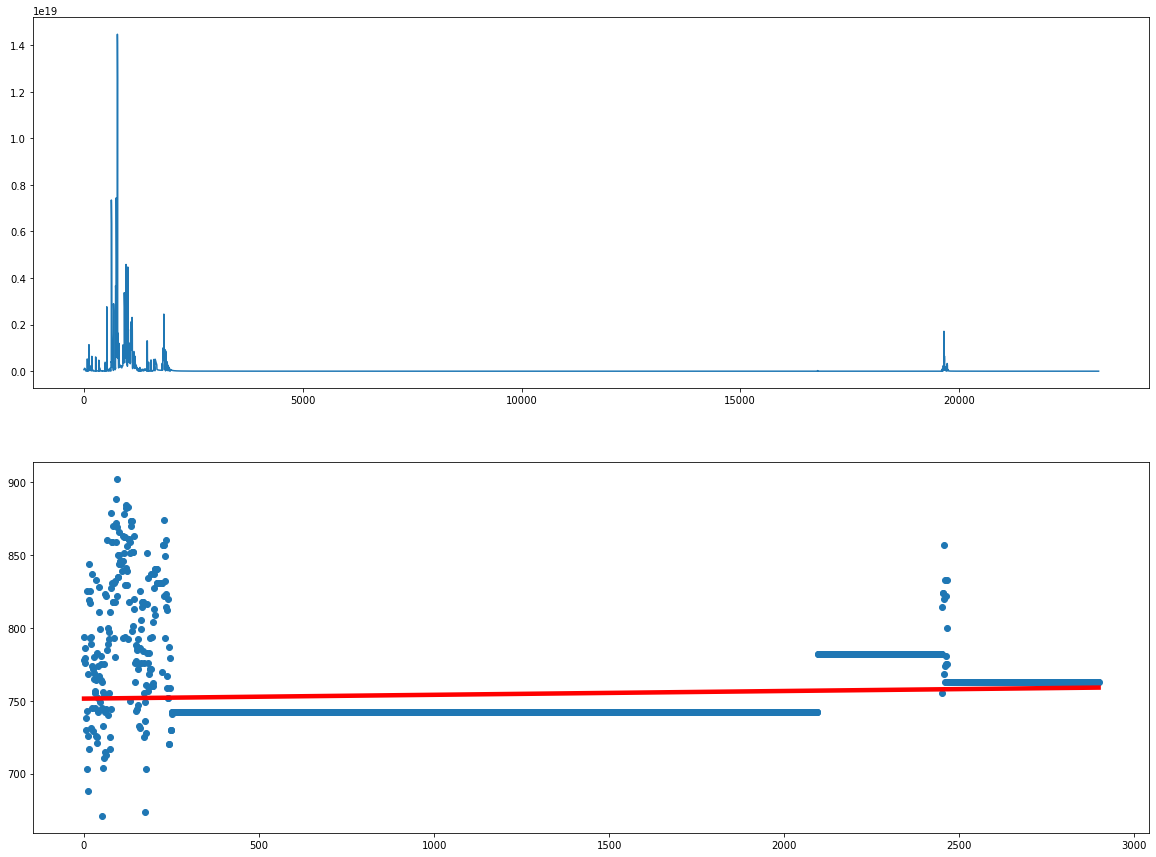

1
Epoch 2900: Current Learning Rate: [0.00039198451925399024, 0.002799889423242789], Current Success Rate: 763


/var/folders/tp/g5d5jn1j0x3d60w7kqpbj6wm0000gn/T/ipykernel_75577/2845807382.py:61: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



episode  2925  is done!


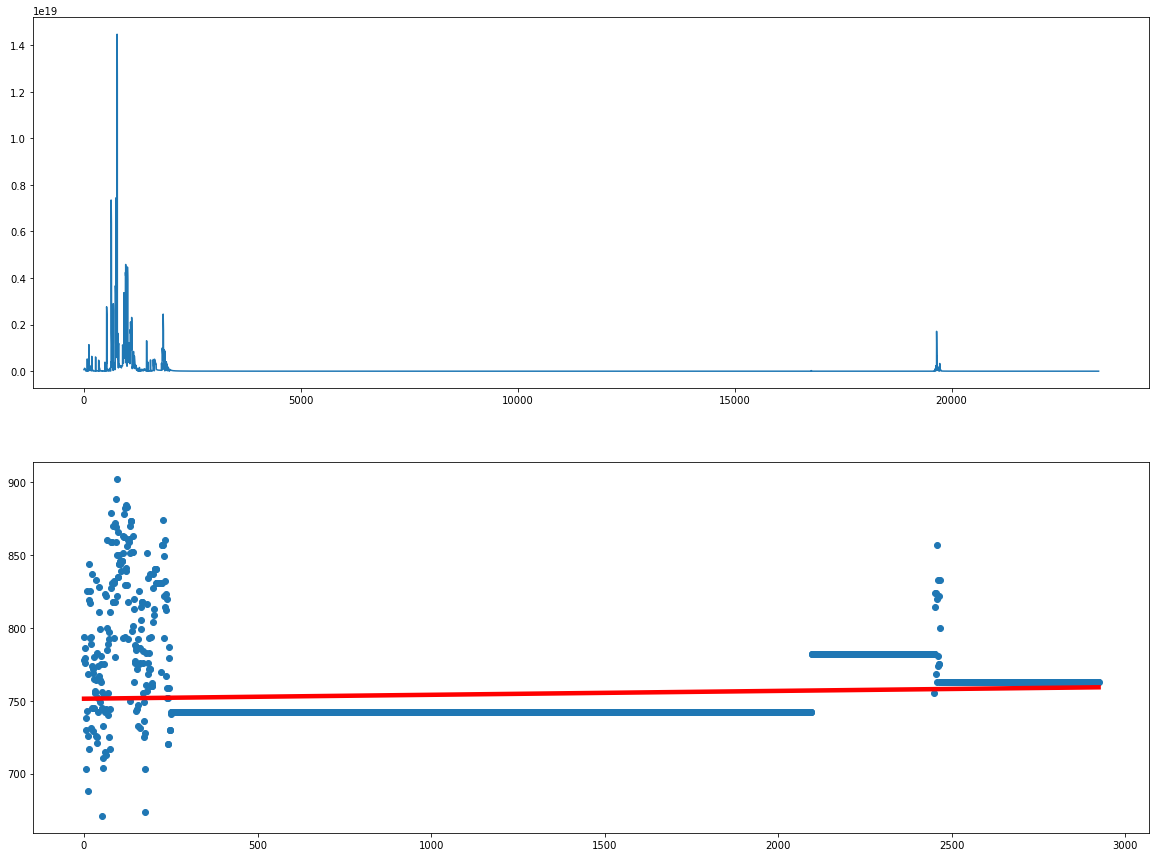

1
Epoch 2925: Current Learning Rate: [0.0003900292932673634, 0.0027859235233383133], Current Success Rate: 763


/var/folders/tp/g5d5jn1j0x3d60w7kqpbj6wm0000gn/T/ipykernel_75577/2845807382.py:61: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



episode  2950  is done!


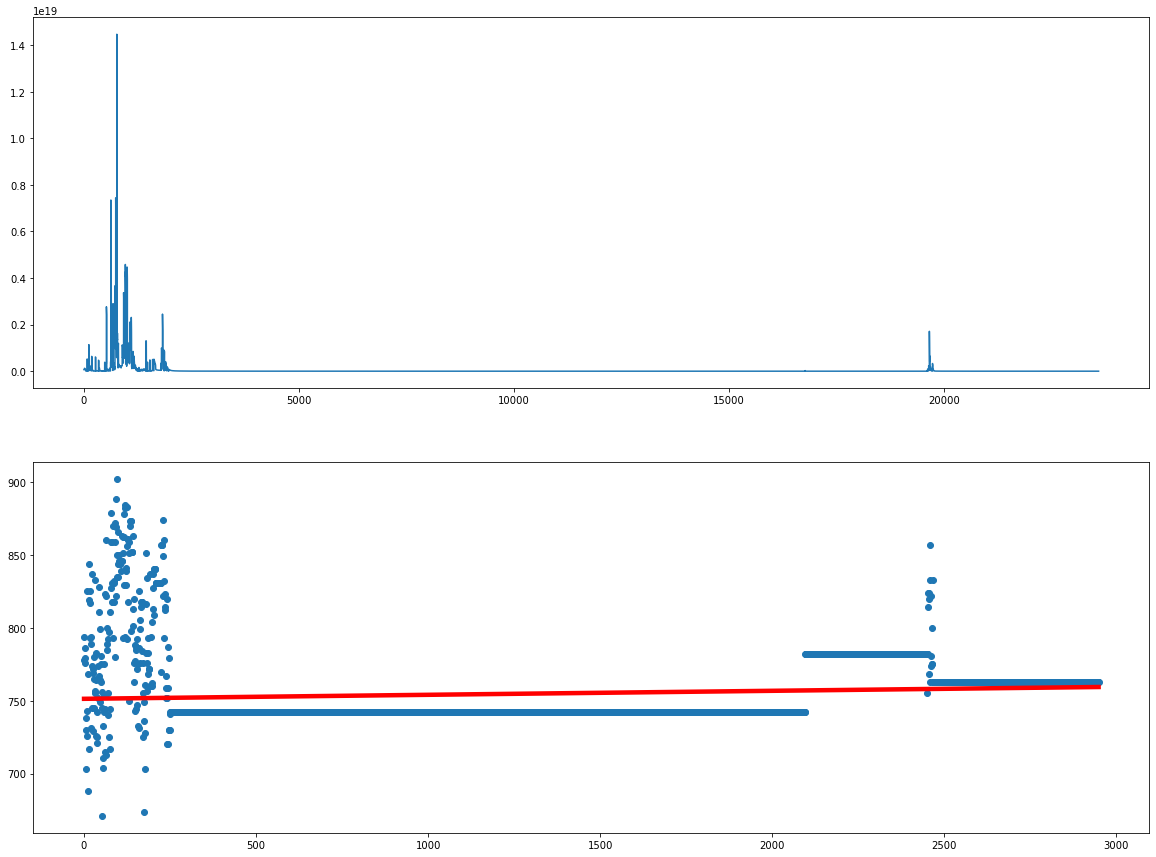

1
Epoch 2950: Current Learning Rate: [0.0003880838199838946, 0.002772027285599251], Current Success Rate: 763


/var/folders/tp/g5d5jn1j0x3d60w7kqpbj6wm0000gn/T/ipykernel_75577/2845807382.py:61: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



episode  2975  is done!


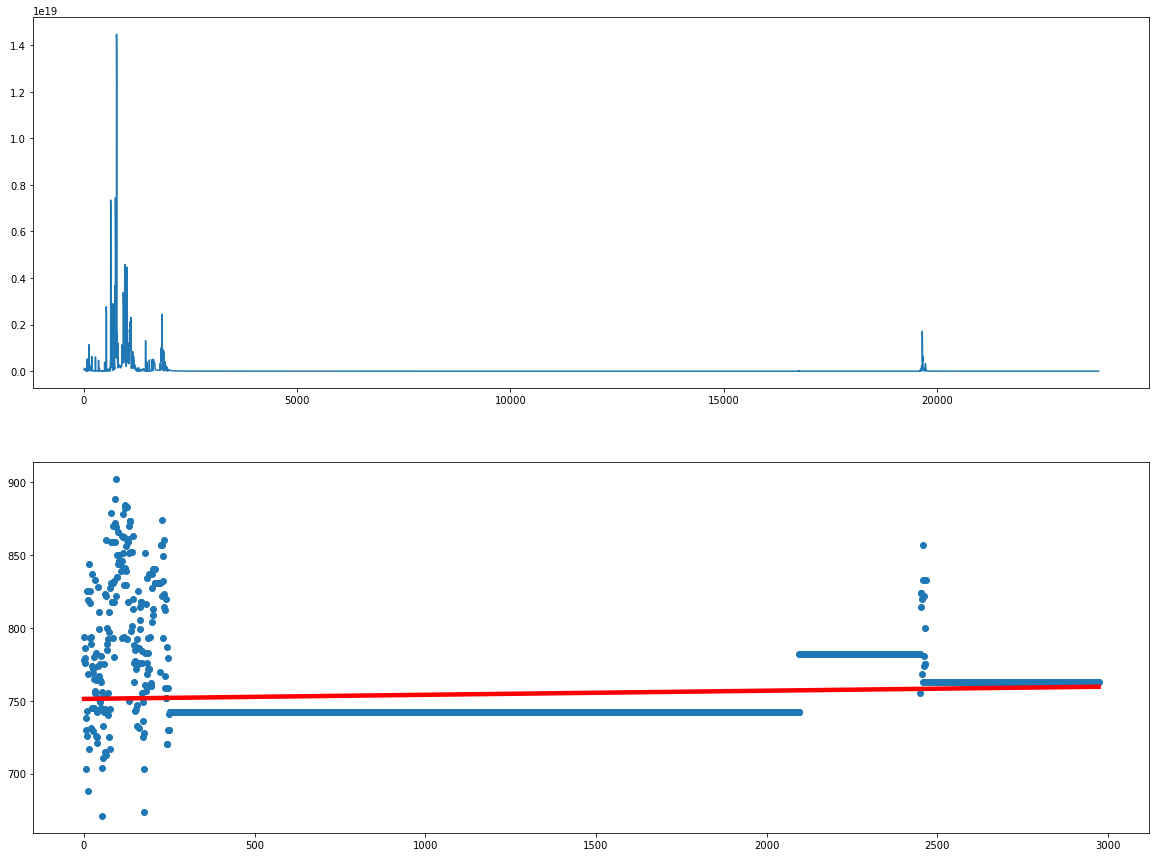

1
Epoch 2975: Current Learning Rate: [0.00038614805075692124, 0.0027582003625494403], Current Success Rate: 763


/var/folders/tp/g5d5jn1j0x3d60w7kqpbj6wm0000gn/T/ipykernel_75577/2845807382.py:61: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



episode  3000  is done!


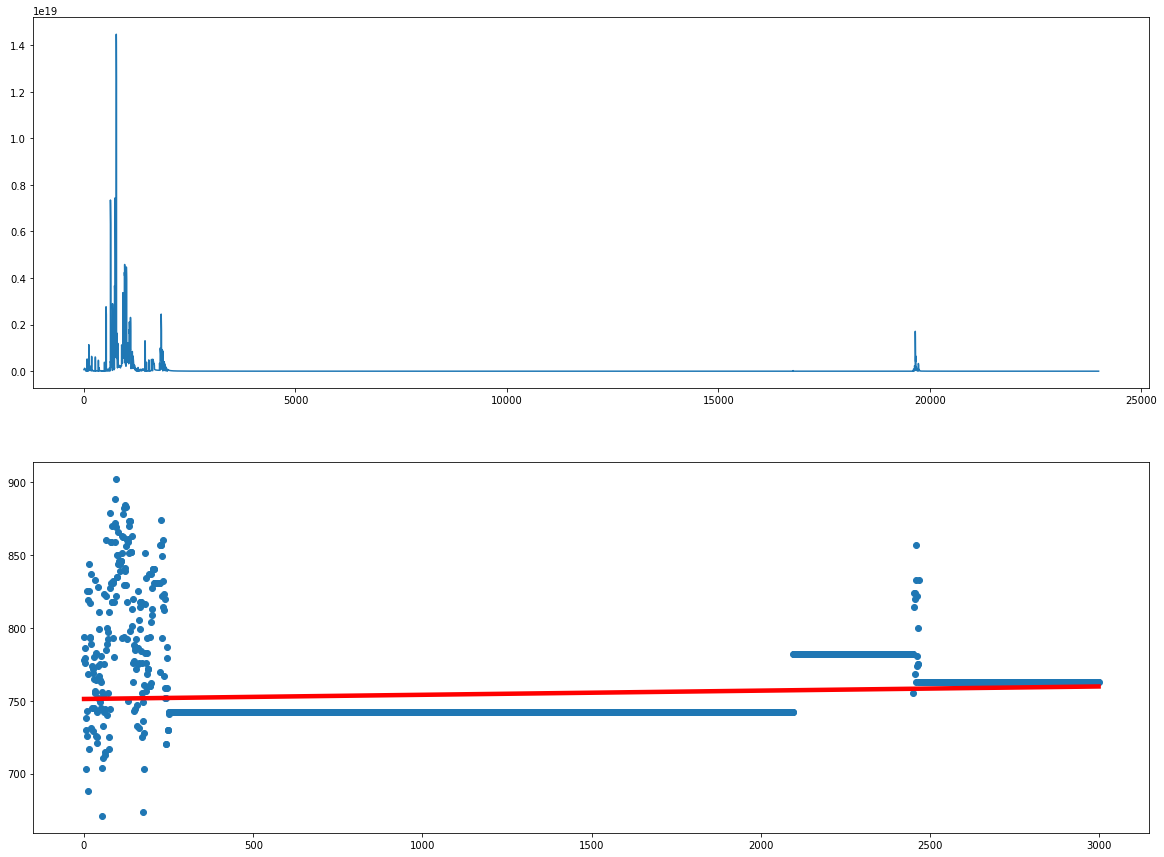

1
Epoch 3000: Current Learning Rate: [0.00038422193718243086, 0.0027444424084459374], Current Success Rate: 763


/var/folders/tp/g5d5jn1j0x3d60w7kqpbj6wm0000gn/T/ipykernel_75577/2845807382.py:61: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



episode  3025  is done!


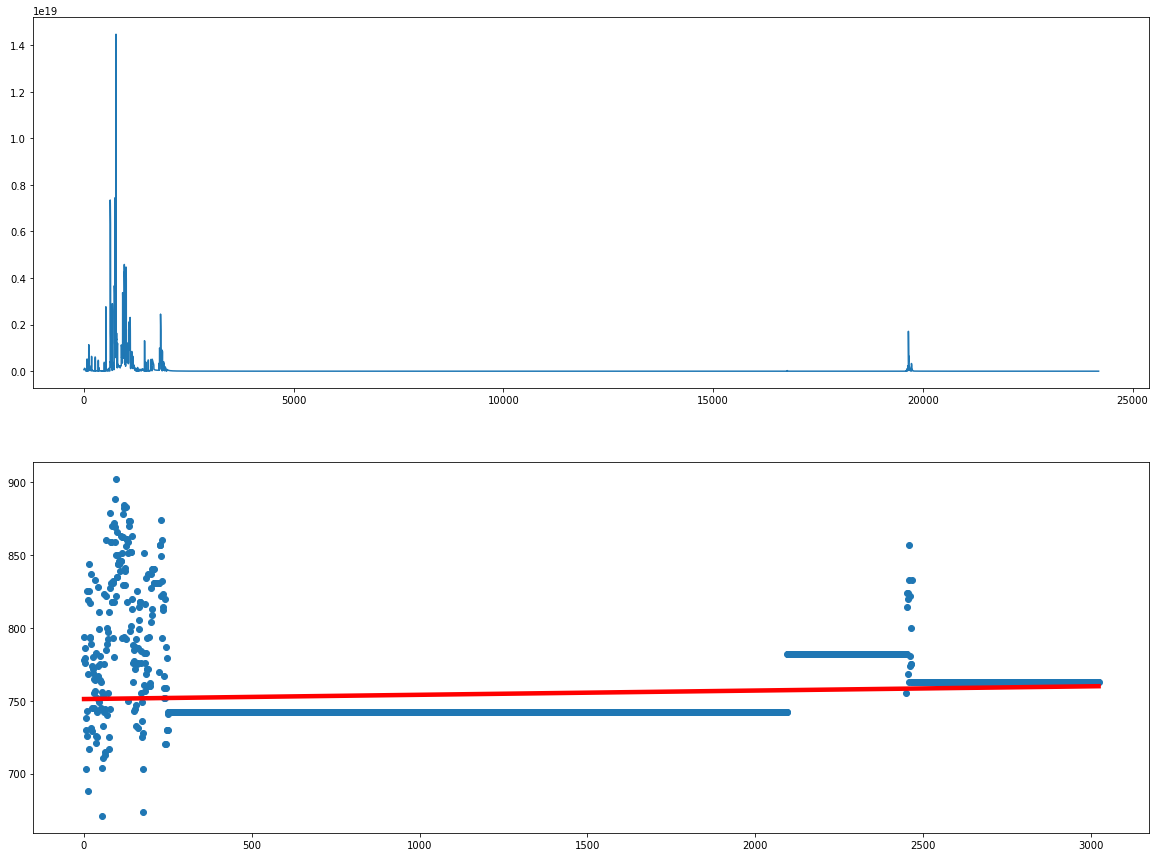

1
Epoch 3025: Current Learning Rate: [0.0003823054310978517, 0.0027307530792703718], Current Success Rate: 763


/var/folders/tp/g5d5jn1j0x3d60w7kqpbj6wm0000gn/T/ipykernel_75577/2845807382.py:61: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



episode  3050  is done!


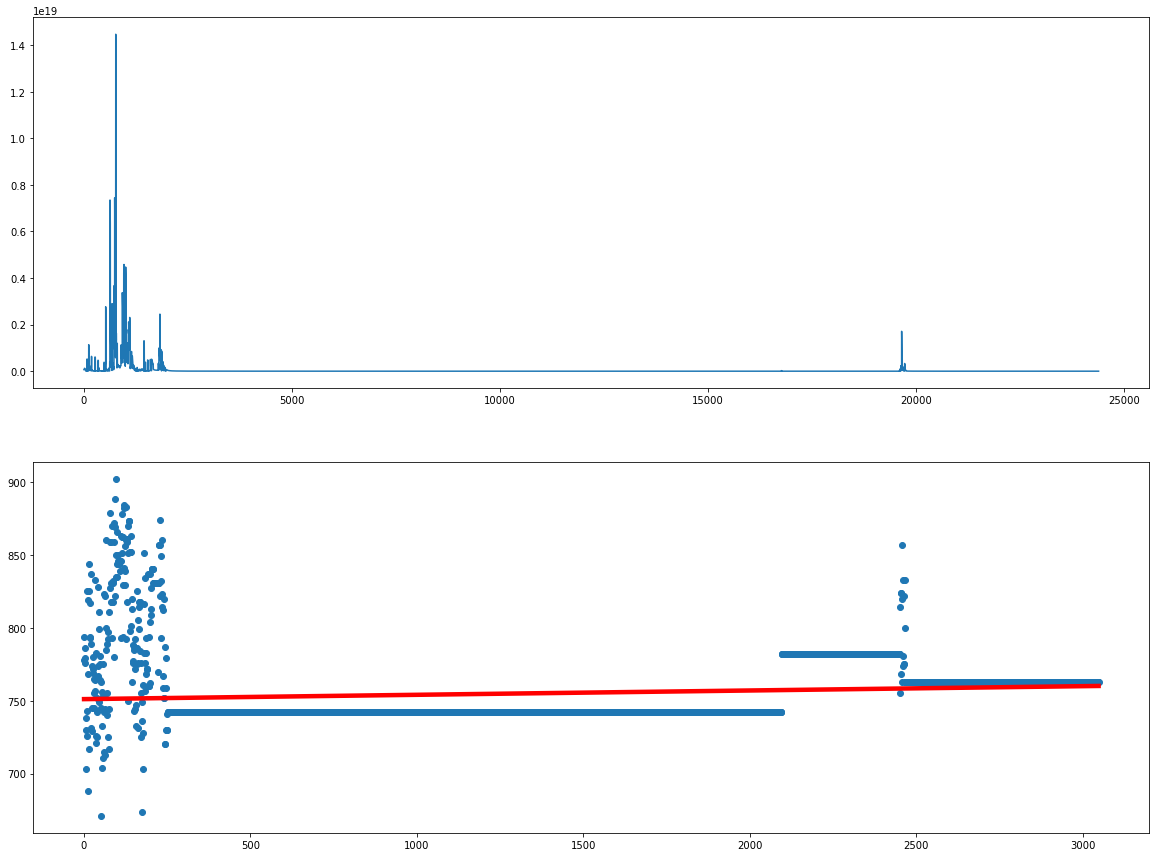

1
Epoch 3050: Current Learning Rate: [0.0003803984845808473, 0.002717132032720339], Current Success Rate: 763


/var/folders/tp/g5d5jn1j0x3d60w7kqpbj6wm0000gn/T/ipykernel_75577/2845807382.py:61: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



episode  3075  is done!


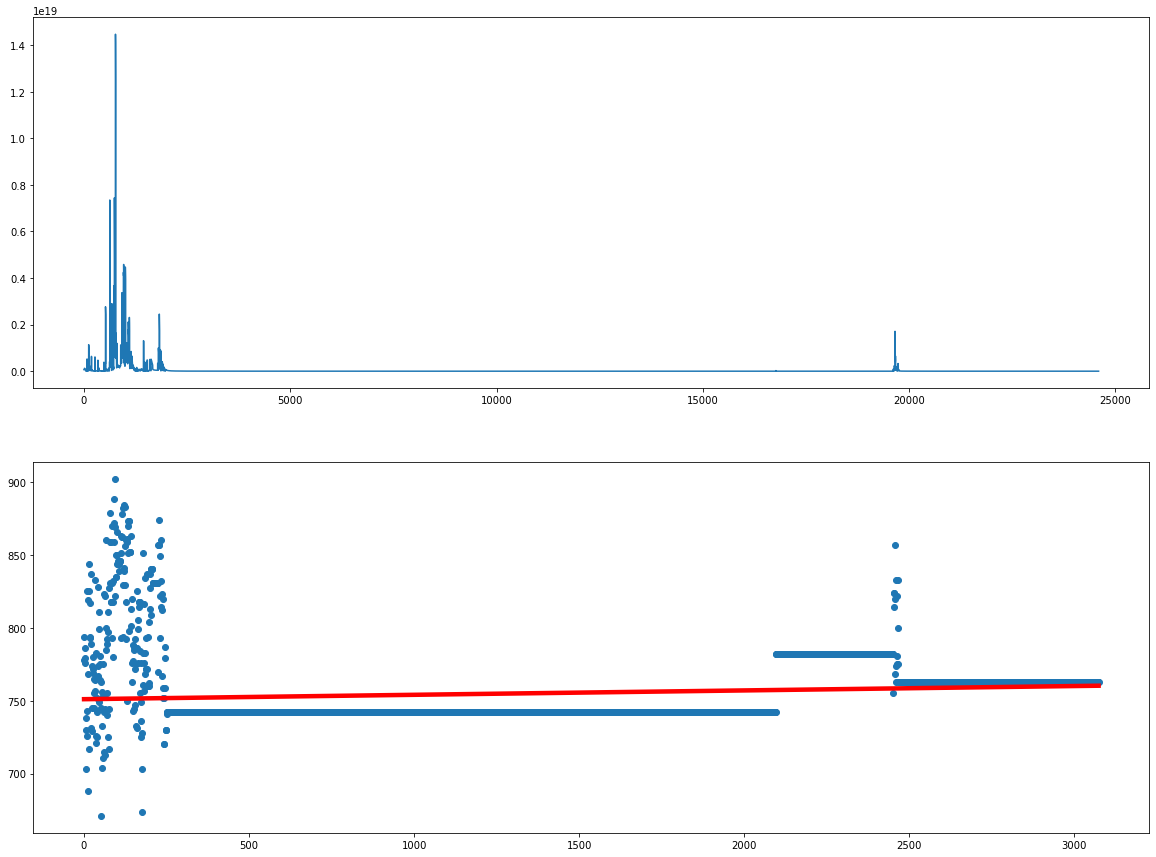

1
Epoch 3075: Current Learning Rate: [0.000378501049948119, 0.0027035789282008503], Current Success Rate: 763


/var/folders/tp/g5d5jn1j0x3d60w7kqpbj6wm0000gn/T/ipykernel_75577/2845807382.py:61: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



episode  3100  is done!


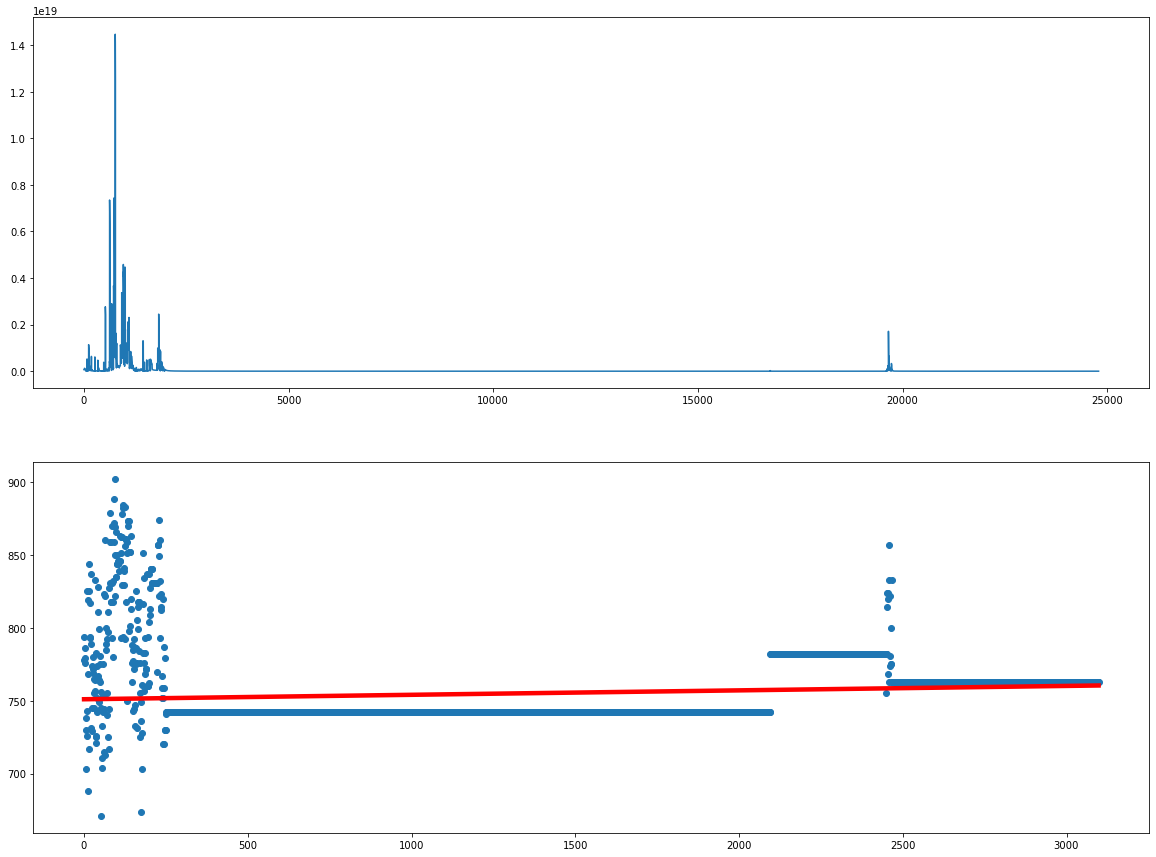

1
Epoch 3100: Current Learning Rate: [0.00037661307975421303, 0.0026900934268158077], Current Success Rate: 763


/var/folders/tp/g5d5jn1j0x3d60w7kqpbj6wm0000gn/T/ipykernel_75577/2845807382.py:61: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



episode  3125  is done!


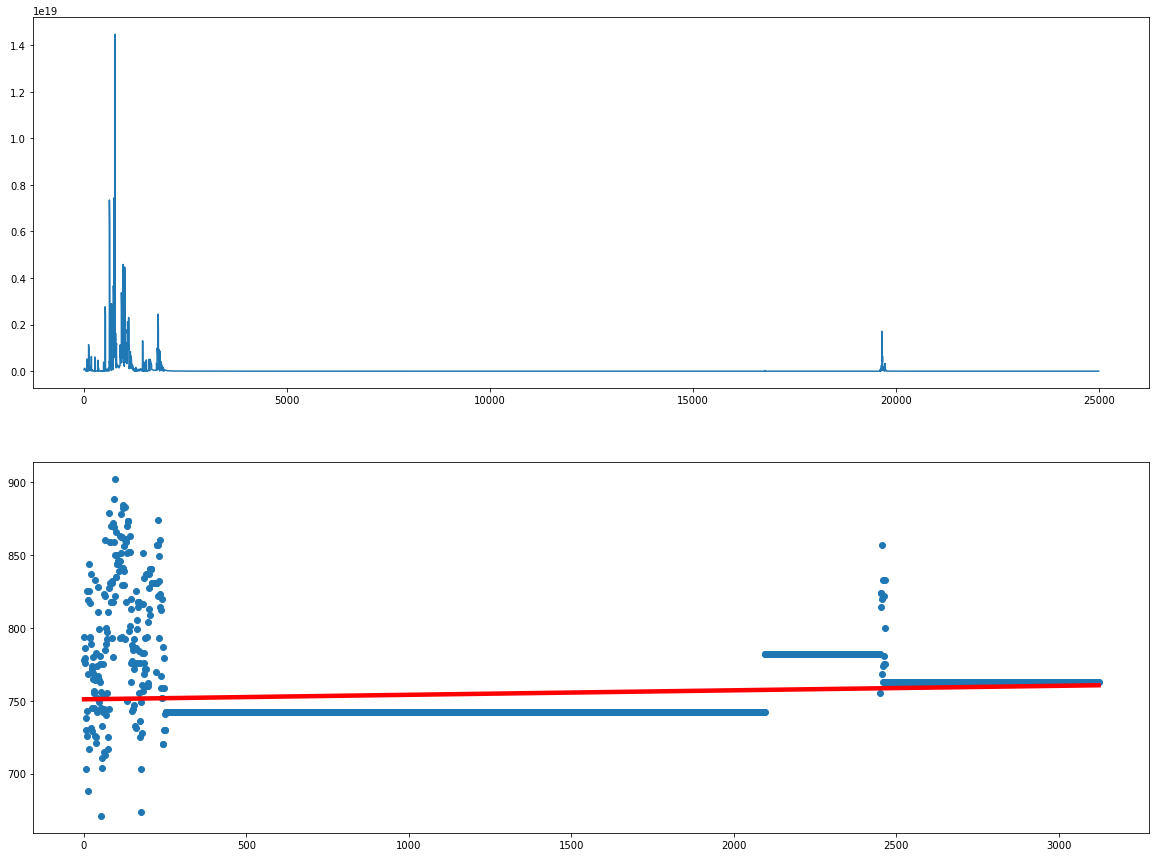

1
Epoch 3125: Current Learning Rate: [0.00037473452679033487, 0.002676675191359535], Current Success Rate: 763


/var/folders/tp/g5d5jn1j0x3d60w7kqpbj6wm0000gn/T/ipykernel_75577/2845807382.py:61: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



episode  3150  is done!


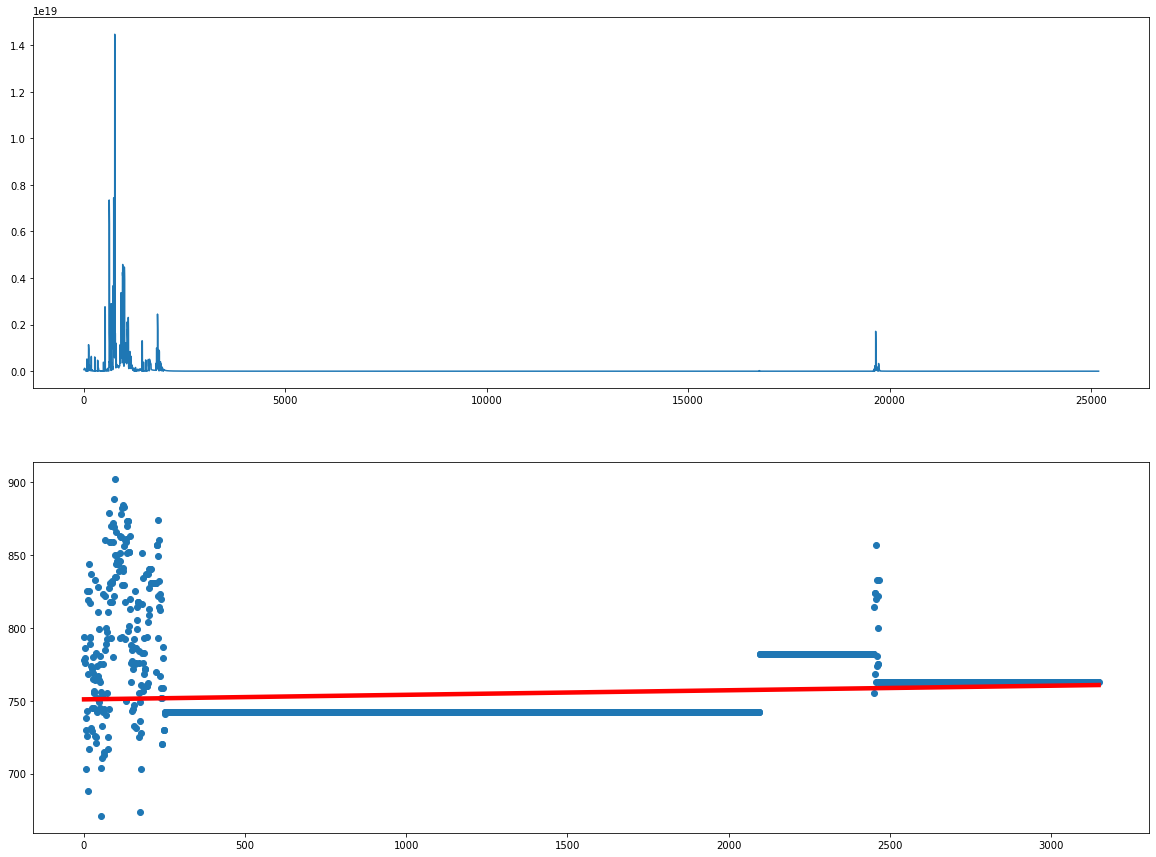

1
Epoch 3150: Current Learning Rate: [0.0003728653440831678, 0.002663323886308342], Current Success Rate: 763


/var/folders/tp/g5d5jn1j0x3d60w7kqpbj6wm0000gn/T/ipykernel_75577/2845807382.py:61: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



episode  3175  is done!


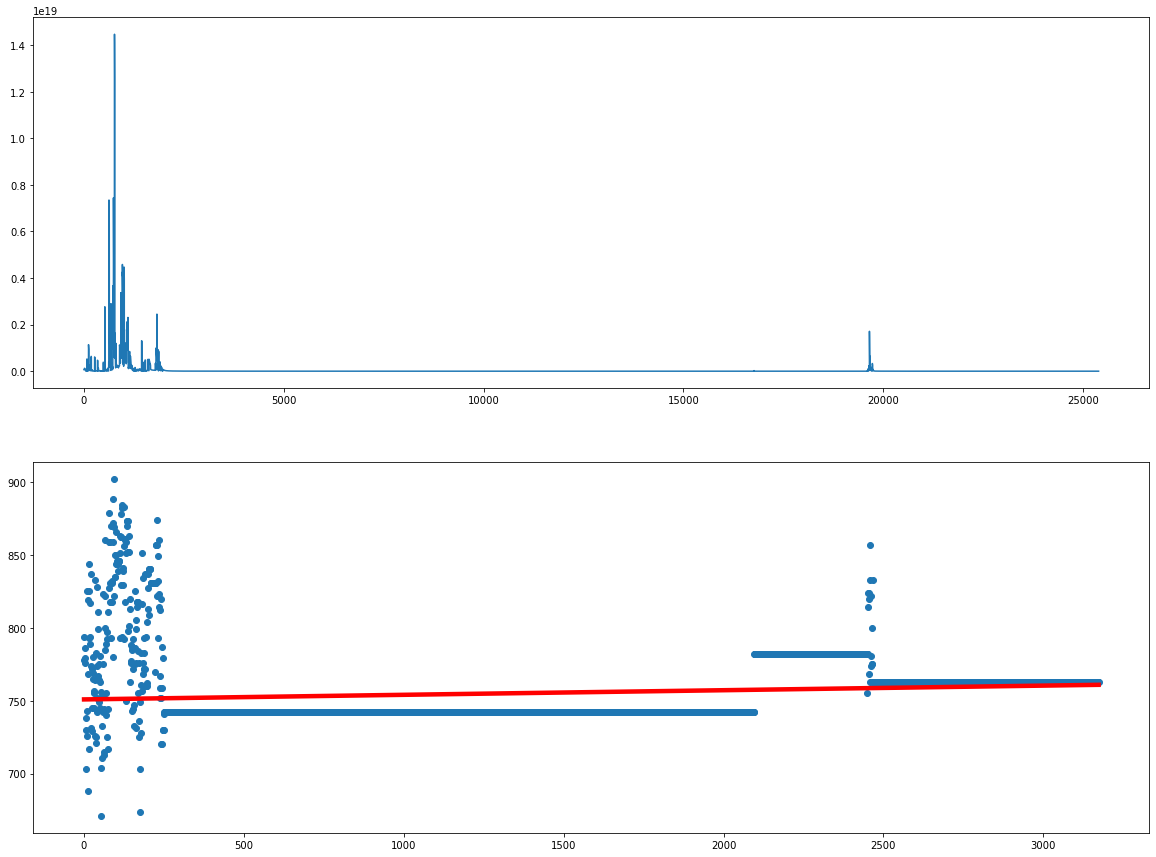

1
Epoch 3175: Current Learning Rate: [0.00037100548489369946, 0.002650039177812138], Current Success Rate: 763


/var/folders/tp/g5d5jn1j0x3d60w7kqpbj6wm0000gn/T/ipykernel_75577/2845807382.py:61: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



episode  3200  is done!


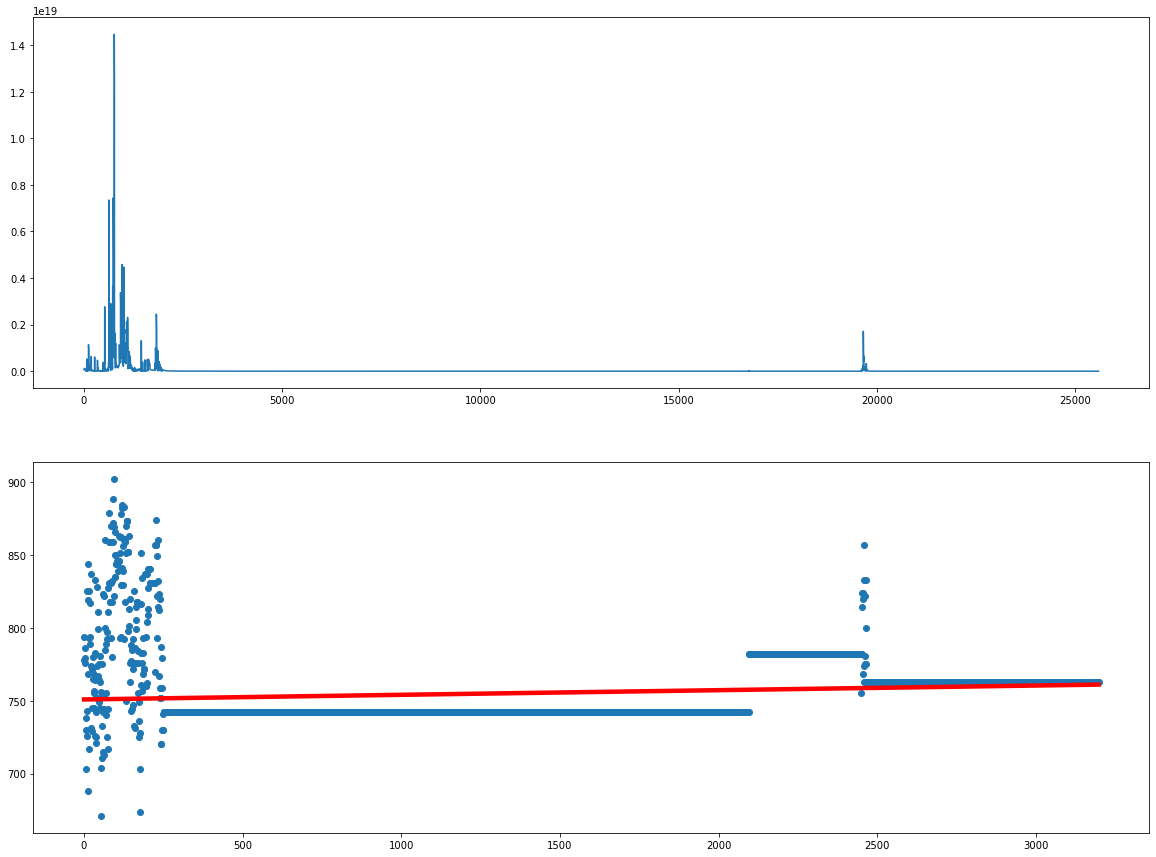

1
Epoch 3200: Current Learning Rate: [0.0003691549027160519, 0.002636820733686084], Current Success Rate: 763


/var/folders/tp/g5d5jn1j0x3d60w7kqpbj6wm0000gn/T/ipykernel_75577/2845807382.py:61: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



episode  3225  is done!


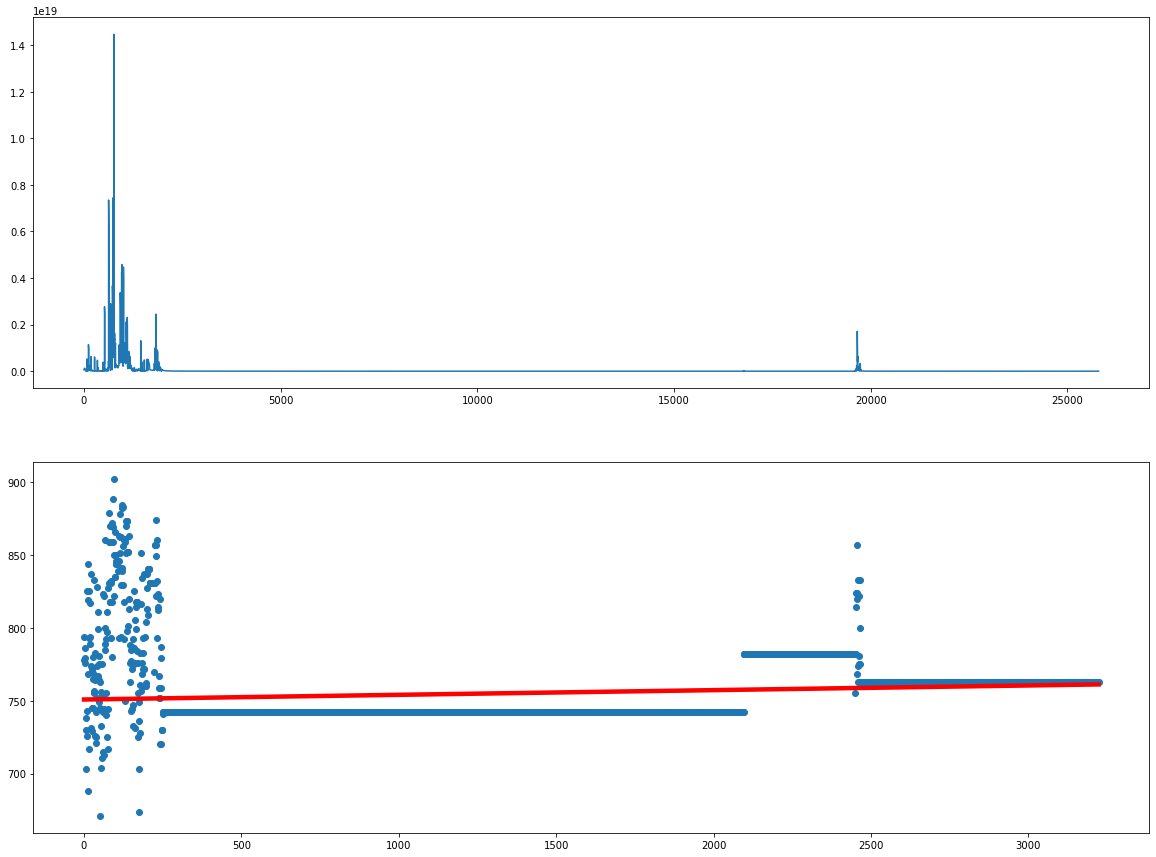

1
Epoch 3225: Current Learning Rate: [0.00036731355127631954, 0.002623668223402281], Current Success Rate: 763


/var/folders/tp/g5d5jn1j0x3d60w7kqpbj6wm0000gn/T/ipykernel_75577/2845807382.py:61: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



episode  3250  is done!


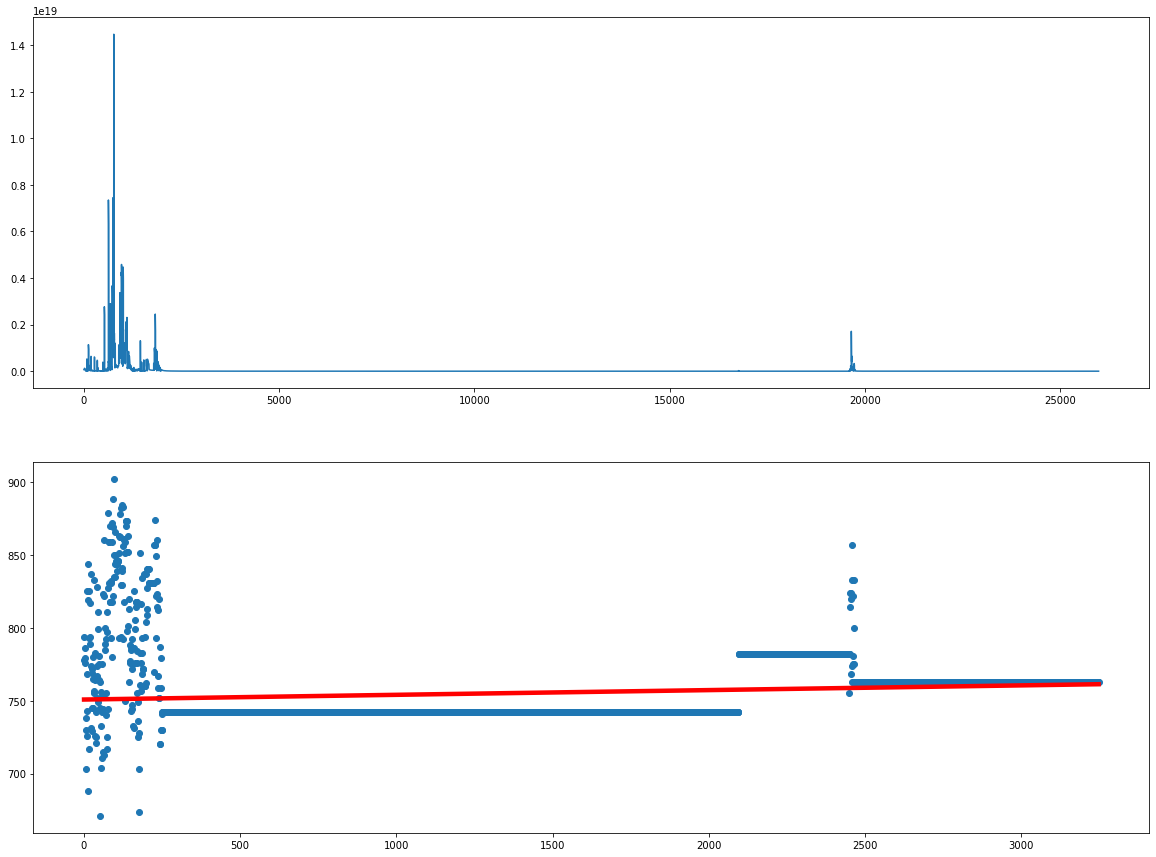

1
Epoch 3250: Current Learning Rate: [0.0003654813845314122, 0.002610581318081515], Current Success Rate: 763


/var/folders/tp/g5d5jn1j0x3d60w7kqpbj6wm0000gn/T/ipykernel_75577/2845807382.py:61: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



episode  3275  is done!


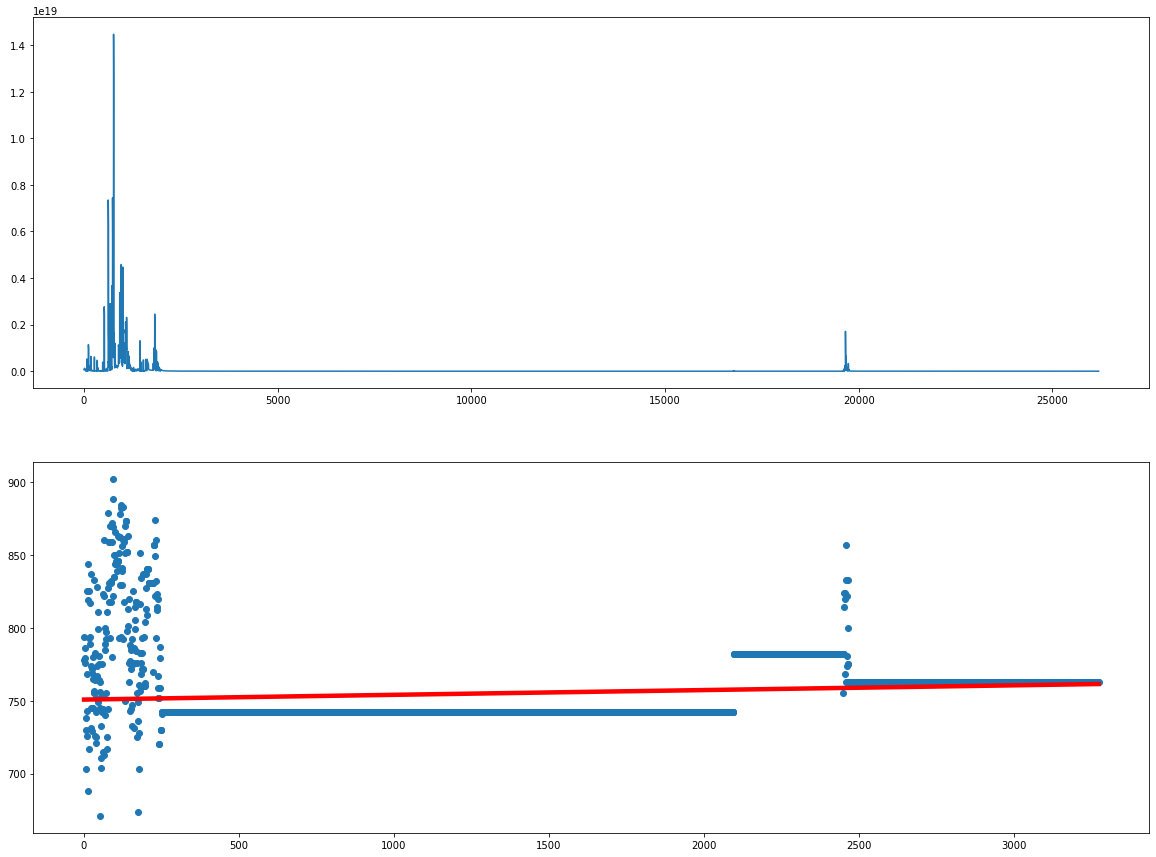

1
Epoch 3275: Current Learning Rate: [0.00036365835666790343, 0.002597559690485024], Current Success Rate: 763


/var/folders/tp/g5d5jn1j0x3d60w7kqpbj6wm0000gn/T/ipykernel_75577/2845807382.py:61: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



episode  3300  is done!


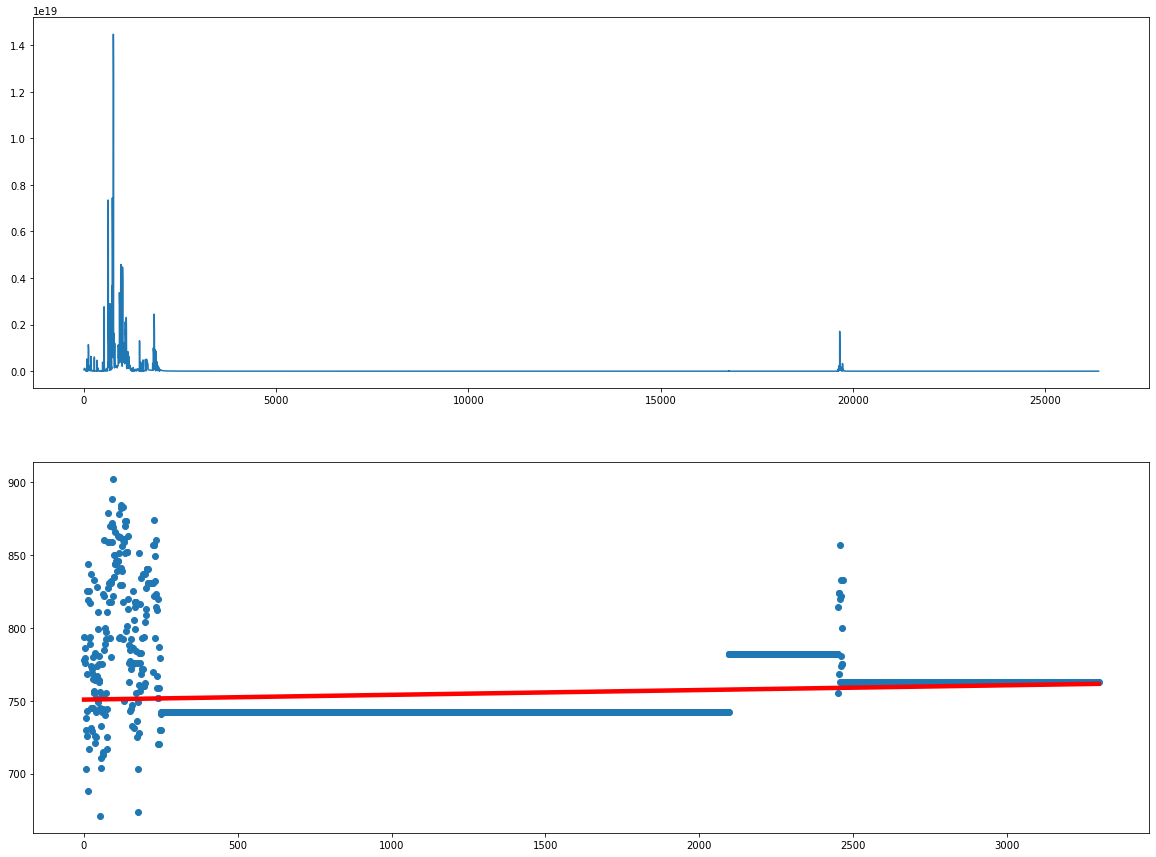

1
Epoch 3300: Current Learning Rate: [0.0003618444221008847, 0.002584603015006318], Current Success Rate: 763


/var/folders/tp/g5d5jn1j0x3d60w7kqpbj6wm0000gn/T/ipykernel_75577/2845807382.py:61: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



episode  3325  is done!


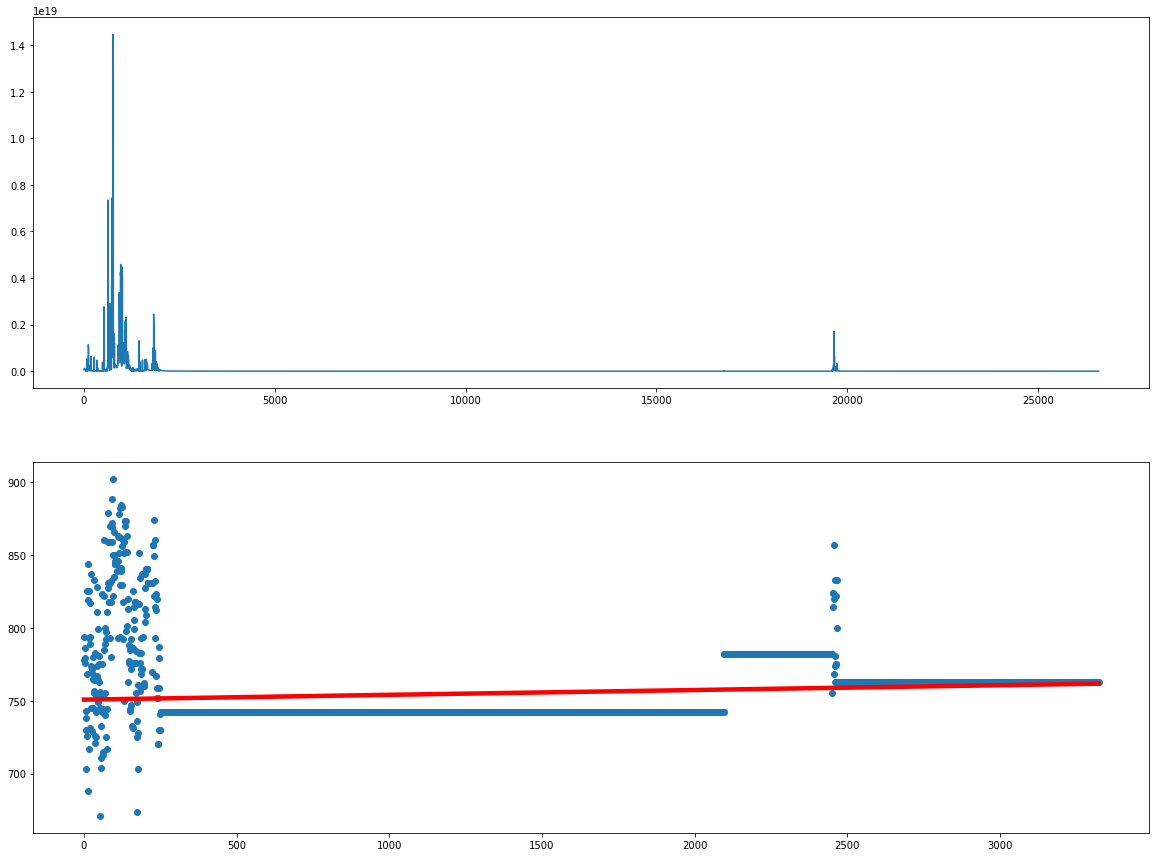

1
Epoch 3325: Current Learning Rate: [0.0003600395354728258, 0.0025717109676630405], Current Success Rate: 763


/var/folders/tp/g5d5jn1j0x3d60w7kqpbj6wm0000gn/T/ipykernel_75577/2845807382.py:61: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



episode  3350  is done!


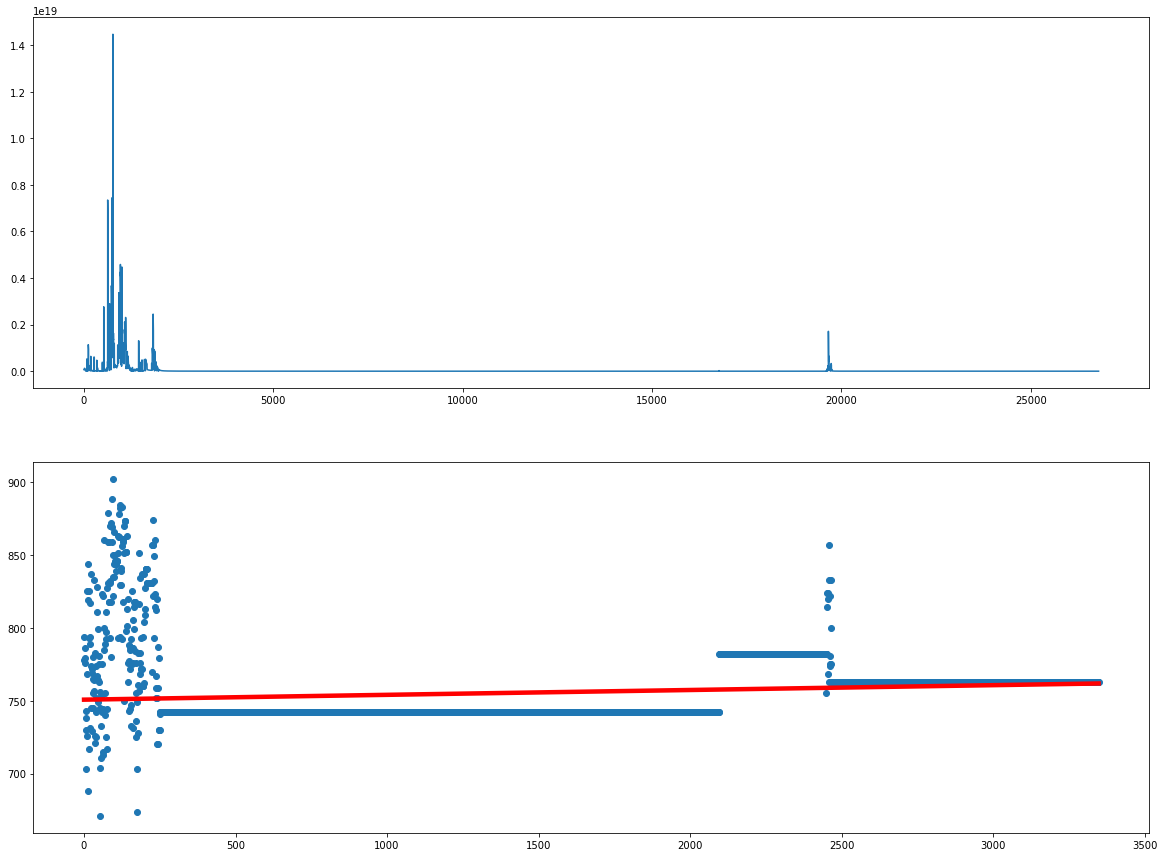

1
Epoch 3350: Current Learning Rate: [0.000358243651652441, 0.002558883226088865], Current Success Rate: 763


/var/folders/tp/g5d5jn1j0x3d60w7kqpbj6wm0000gn/T/ipykernel_75577/2845807382.py:61: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



episode  3375  is done!


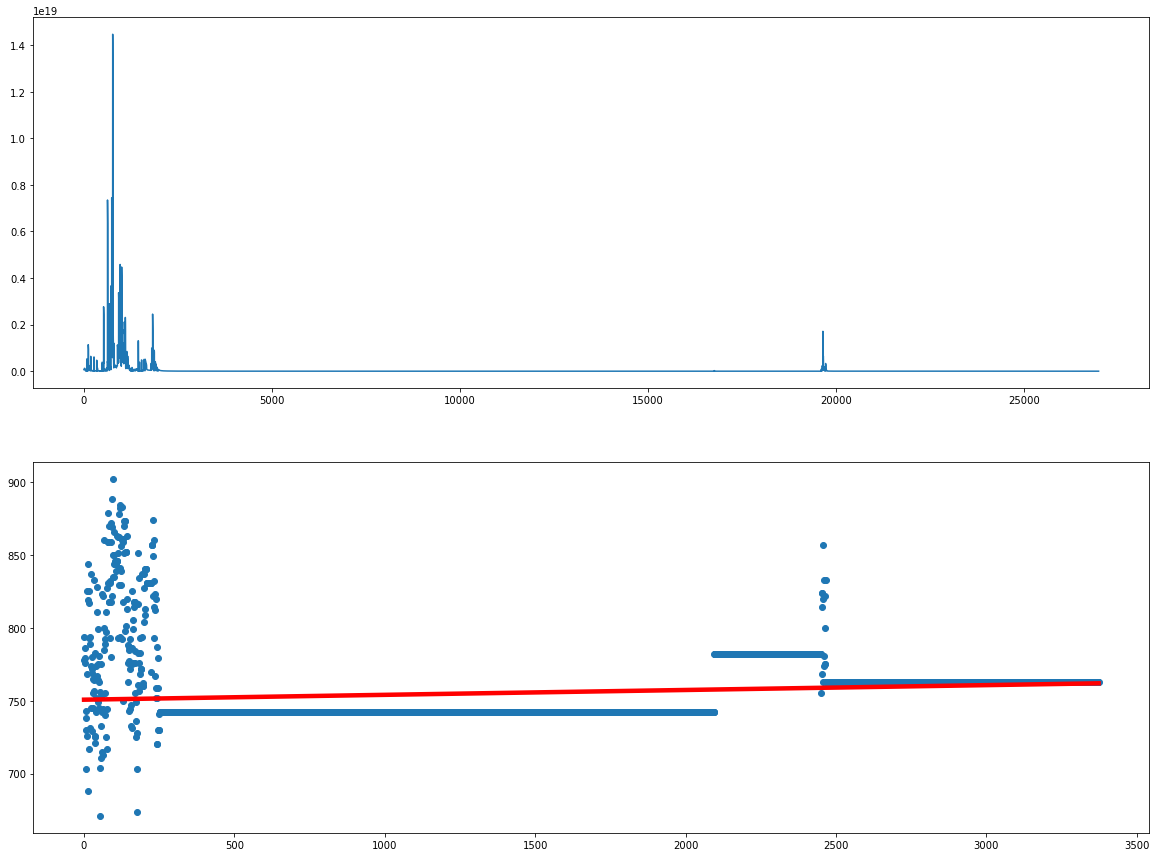

1
Epoch 3375: Current Learning Rate: [0.0003564567257335604, 0.0025461194695254328], Current Success Rate: 763


/var/folders/tp/g5d5jn1j0x3d60w7kqpbj6wm0000gn/T/ipykernel_75577/2845807382.py:61: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



episode  3400  is done!


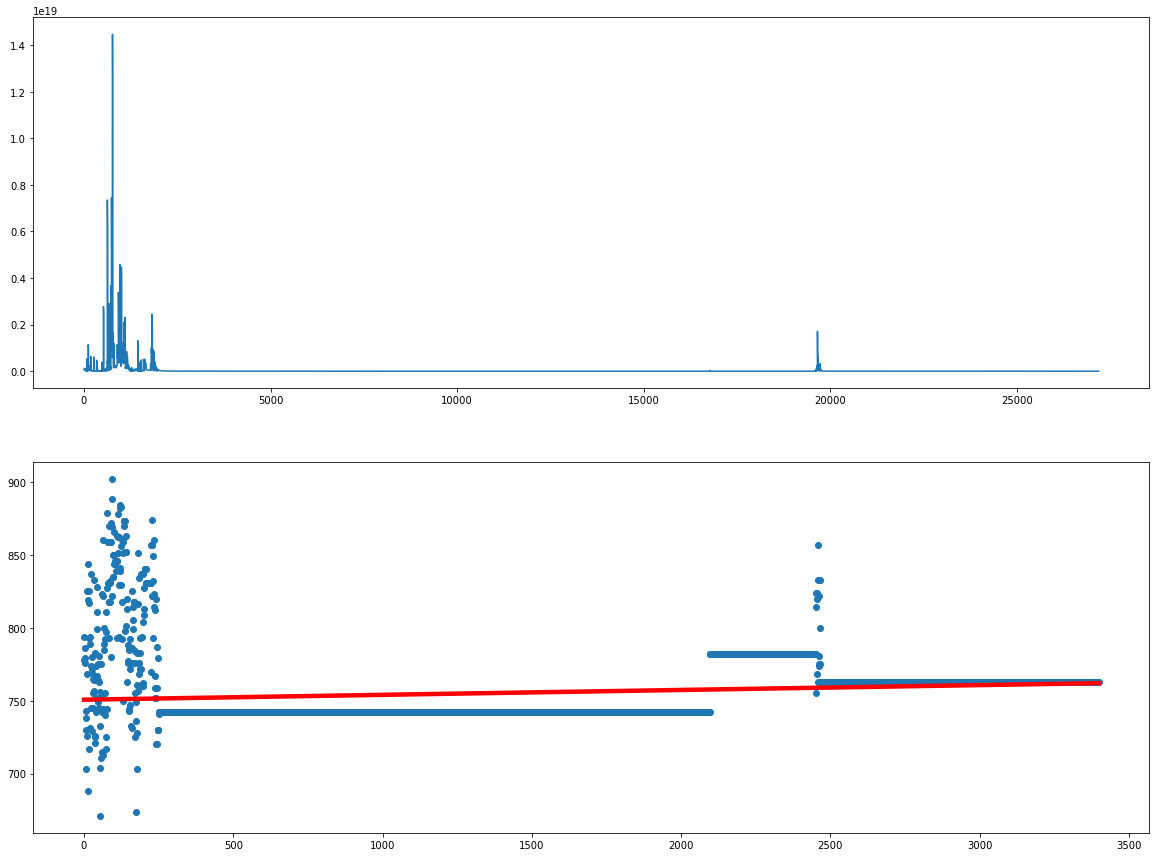

1
Epoch 3400: Current Learning Rate: [0.00035467871303400644, 0.0025334193788143335], Current Success Rate: 763


/var/folders/tp/g5d5jn1j0x3d60w7kqpbj6wm0000gn/T/ipykernel_75577/2845807382.py:61: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



episode  3425  is done!


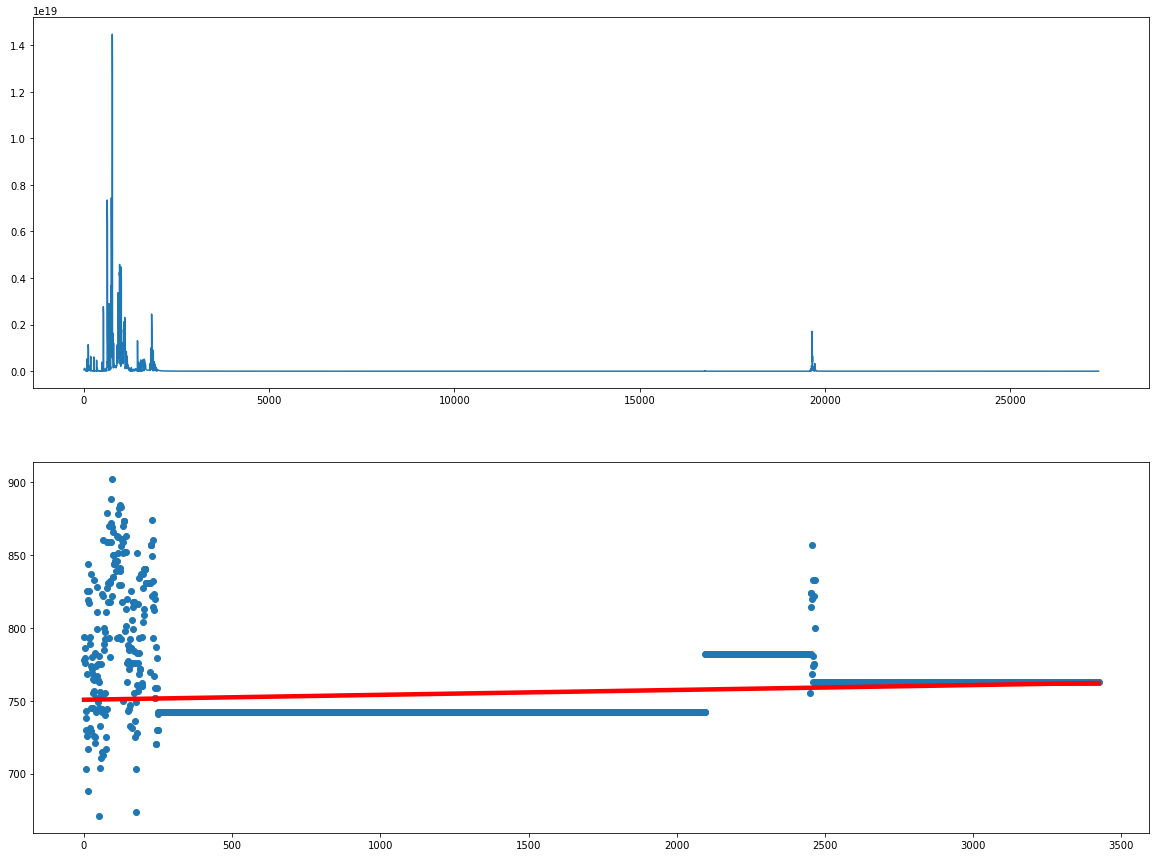

1
Epoch 3425: Current Learning Rate: [0.00035290956909447737, 0.0025207826363891263], Current Success Rate: 763


/var/folders/tp/g5d5jn1j0x3d60w7kqpbj6wm0000gn/T/ipykernel_75577/2845807382.py:61: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



episode  3450  is done!


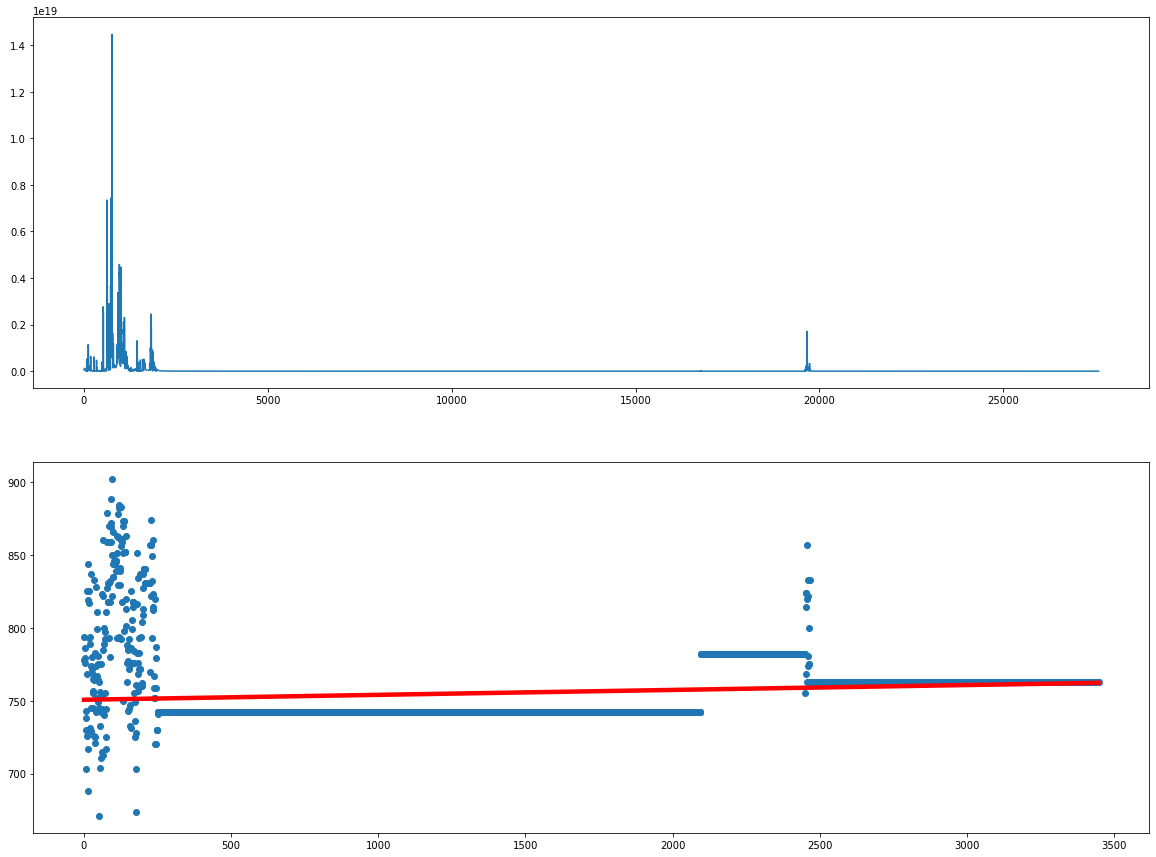

1
Epoch 3450: Current Learning Rate: [0.00035114924967743507, 0.002508208926267396], Current Success Rate: 763


/var/folders/tp/g5d5jn1j0x3d60w7kqpbj6wm0000gn/T/ipykernel_75577/2845807382.py:61: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



episode  3475  is done!


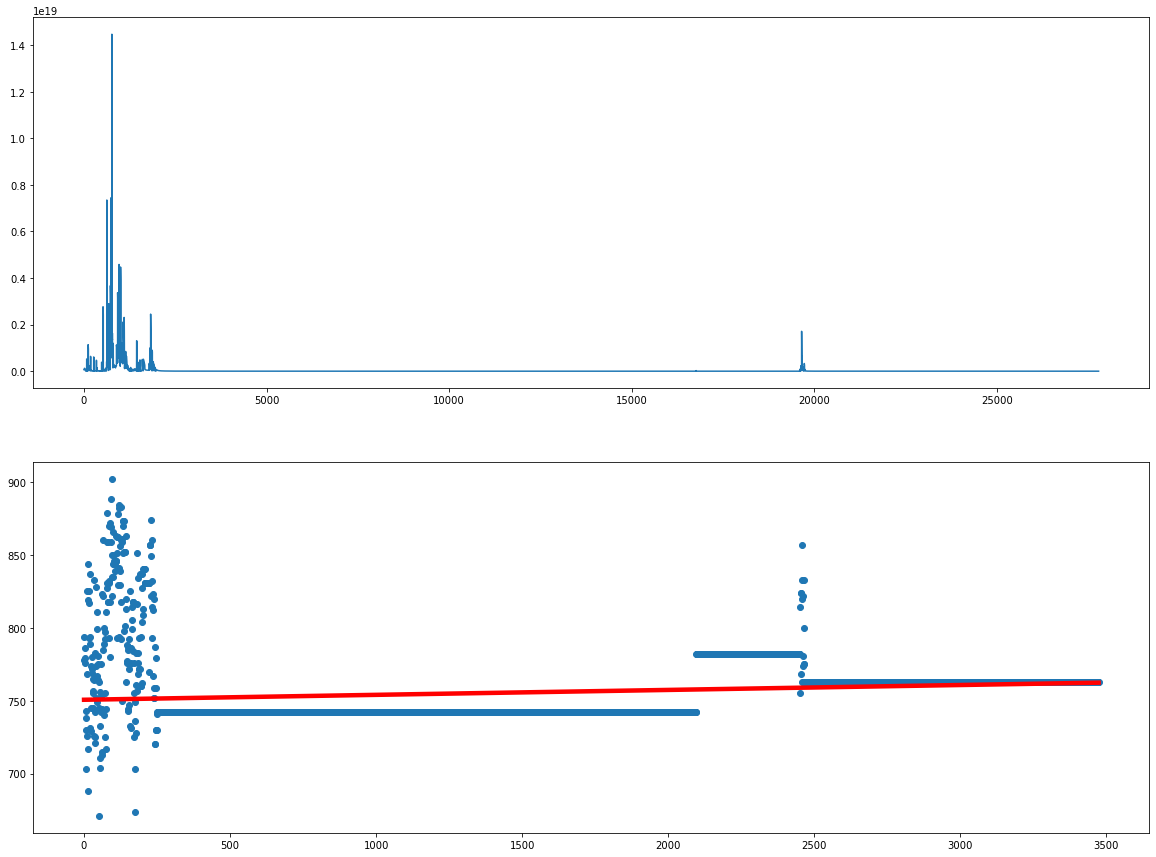

1
Epoch 3475: Current Learning Rate: [0.0003493977107659994, 0.002495697934042855], Current Success Rate: 763


/var/folders/tp/g5d5jn1j0x3d60w7kqpbj6wm0000gn/T/ipykernel_75577/2845807382.py:61: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



episode  3500  is done!


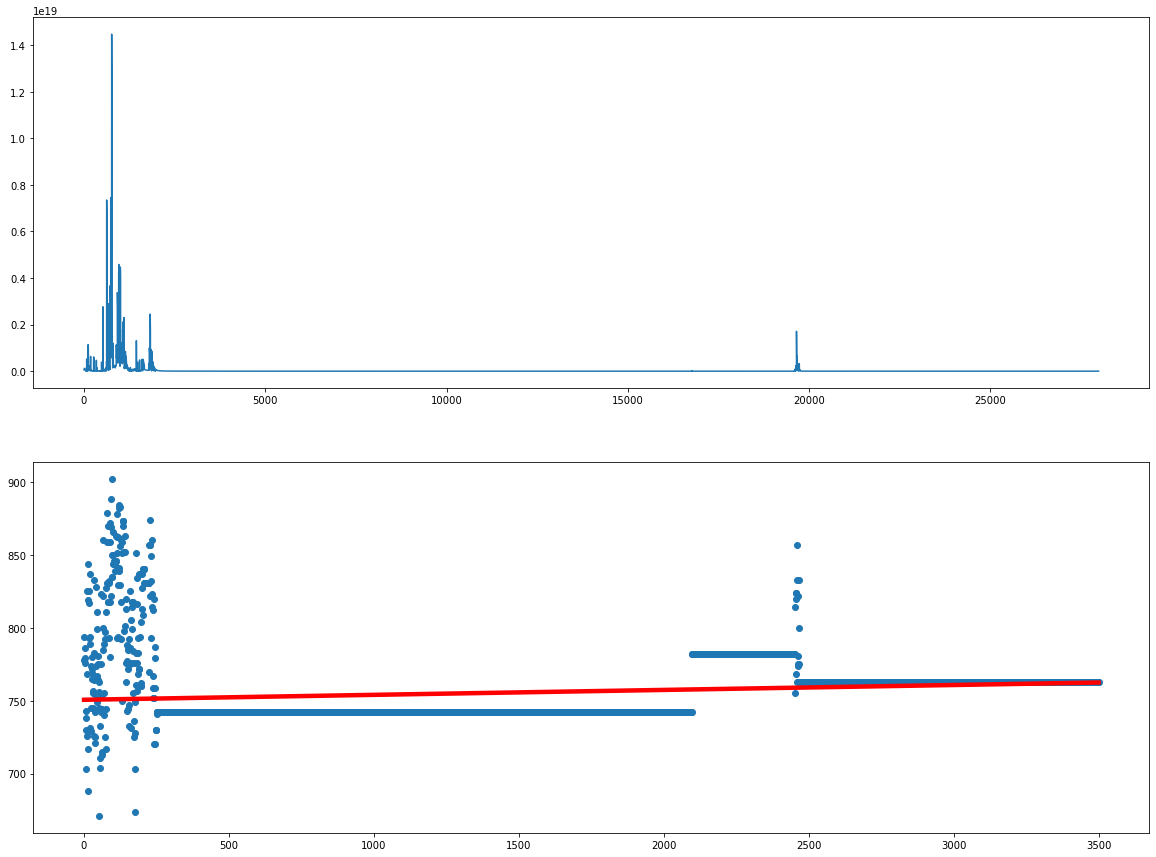

1
Epoch 3500: Current Learning Rate: [0.0003476549085628467, 0.0024832493468774797], Current Success Rate: 763


/var/folders/tp/g5d5jn1j0x3d60w7kqpbj6wm0000gn/T/ipykernel_75577/2845807382.py:61: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



episode  3525  is done!


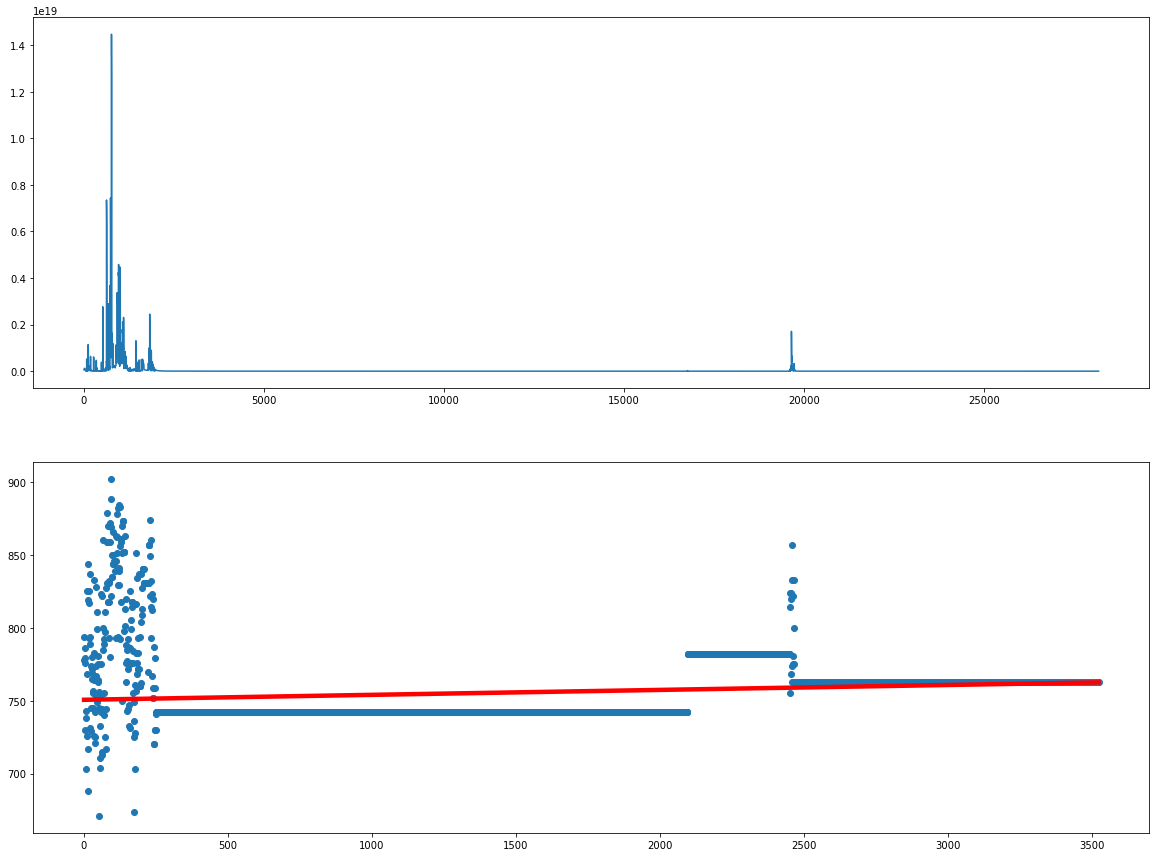

1
Epoch 3525: Current Learning Rate: [0.0003459207994891157, 0.002470862853493687], Current Success Rate: 763


/var/folders/tp/g5d5jn1j0x3d60w7kqpbj6wm0000gn/T/ipykernel_75577/2845807382.py:61: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



episode  3550  is done!


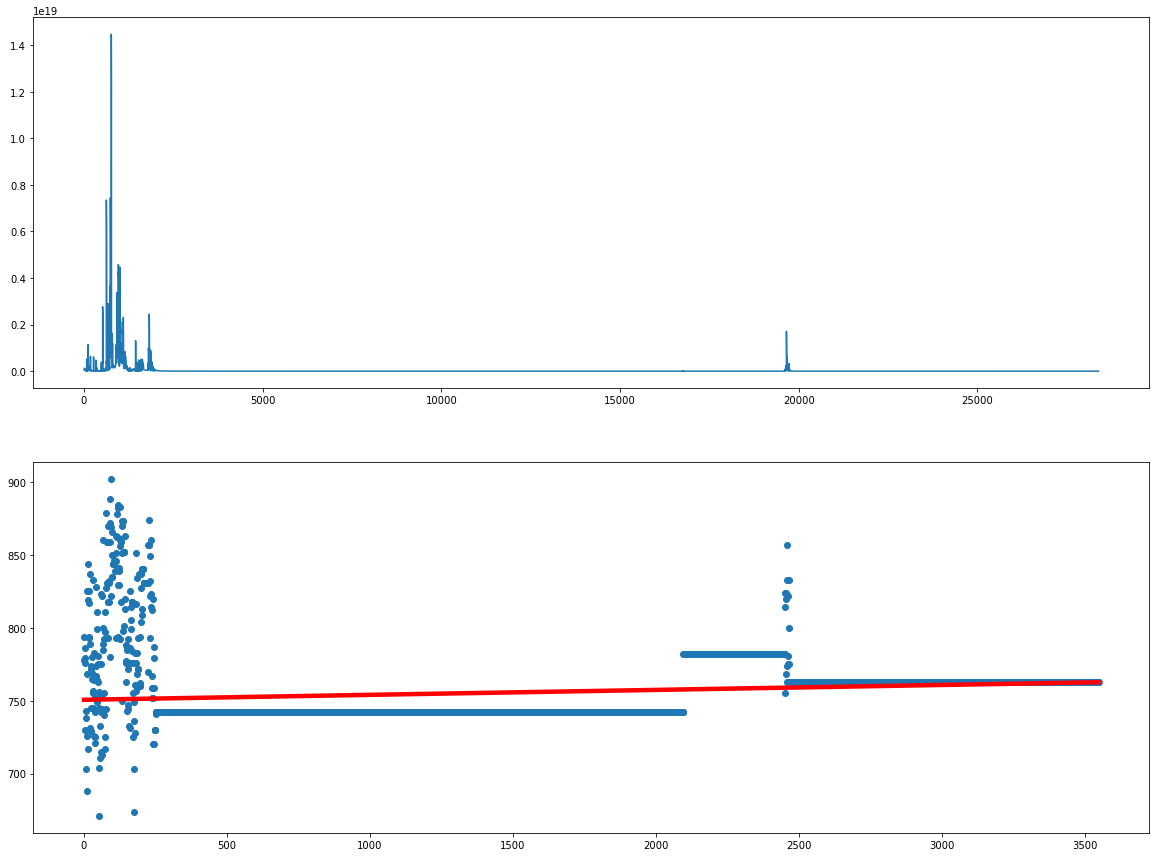

1
Epoch 3550: Current Learning Rate: [0.00034419534018331695, 0.002458538144166554], Current Success Rate: 763


/var/folders/tp/g5d5jn1j0x3d60w7kqpbj6wm0000gn/T/ipykernel_75577/2845807382.py:61: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



episode  3575  is done!


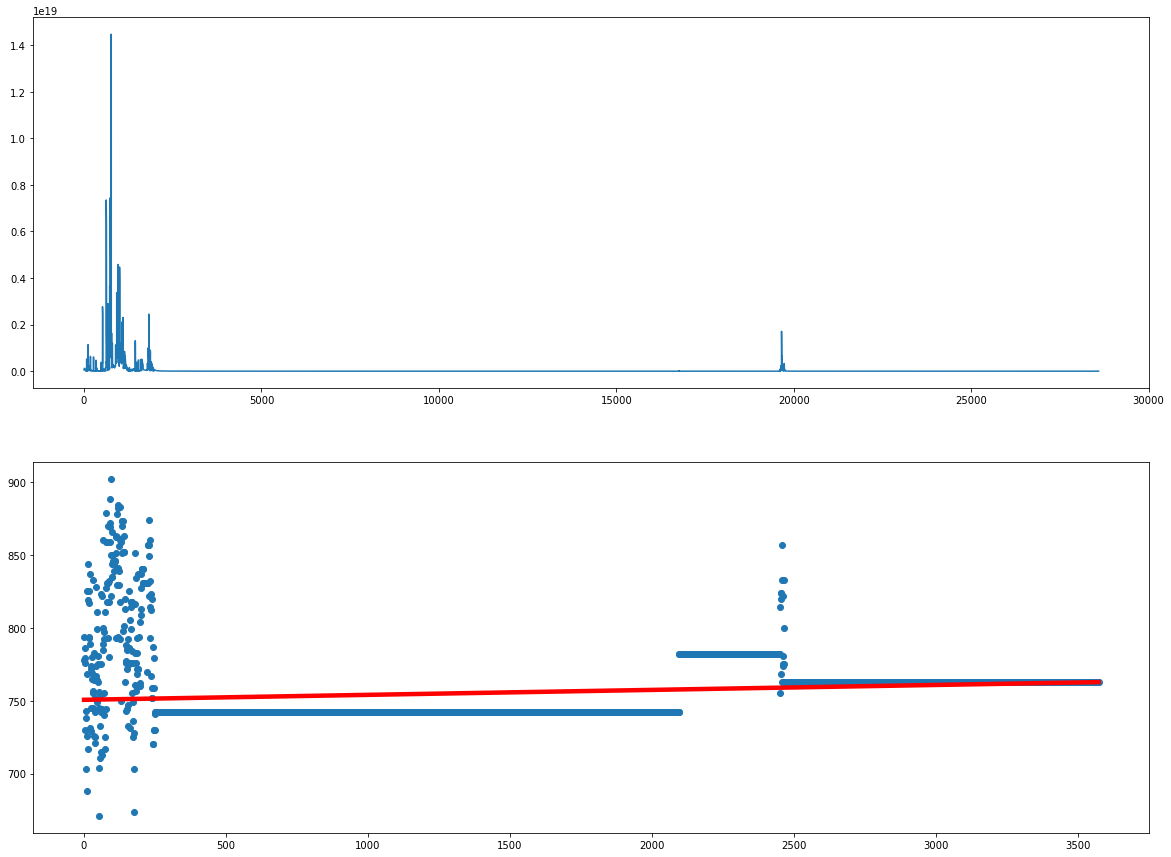

1
Epoch 3575: Current Learning Rate: [0.0003424784875002491, 0.0024462749107160694], Current Success Rate: 763


/var/folders/tp/g5d5jn1j0x3d60w7kqpbj6wm0000gn/T/ipykernel_75577/2845807382.py:61: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



episode  3600  is done!


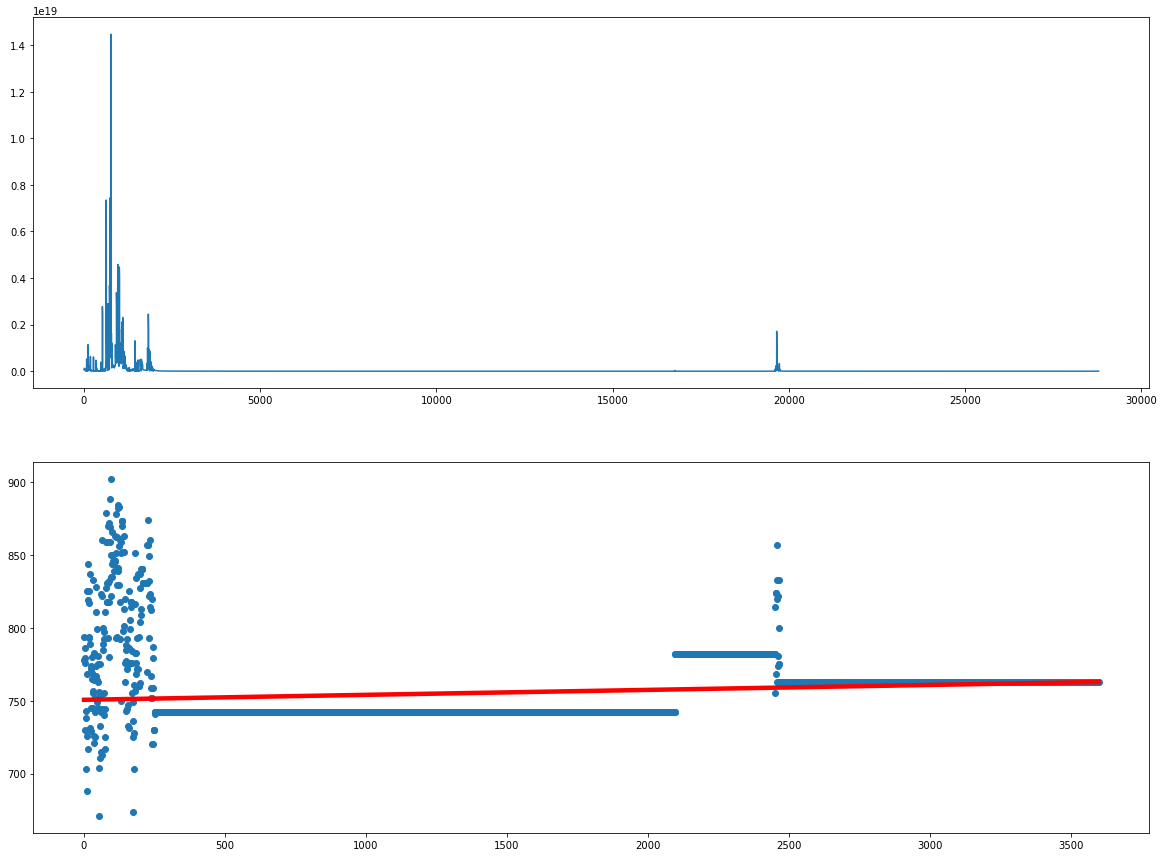

1
Epoch 3600: Current Learning Rate: [0.00034077019850991966, 0.0024340728464994324], Current Success Rate: 763


/var/folders/tp/g5d5jn1j0x3d60w7kqpbj6wm0000gn/T/ipykernel_75577/2845807382.py:61: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



episode  3625  is done!


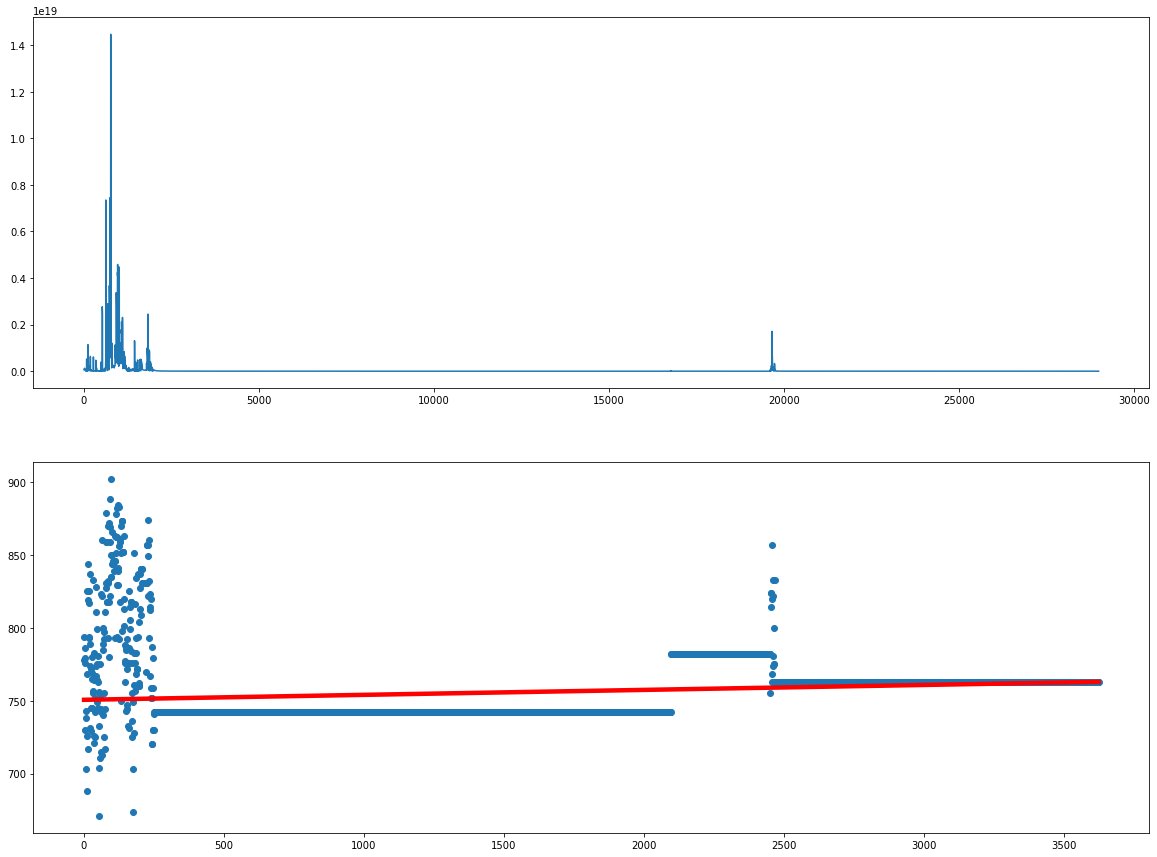

1
Epoch 3625: Current Learning Rate: [0.00033907043049647215, 0.0024219316464033774], Current Success Rate: 763


/var/folders/tp/g5d5jn1j0x3d60w7kqpbj6wm0000gn/T/ipykernel_75577/2845807382.py:61: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



episode  3650  is done!


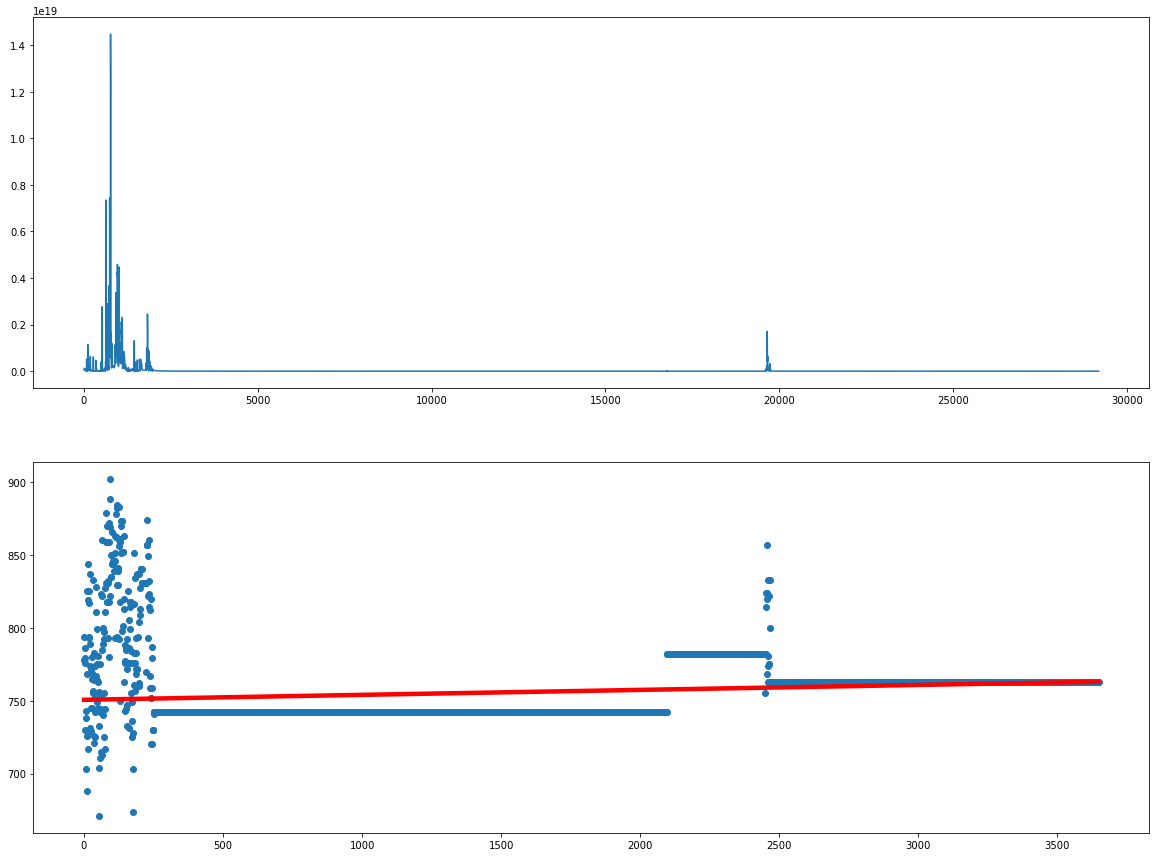

1
Epoch 3650: Current Learning Rate: [0.000337379140957117, 0.0024098510068365554], Current Success Rate: 763


/var/folders/tp/g5d5jn1j0x3d60w7kqpbj6wm0000gn/T/ipykernel_75577/2845807382.py:61: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



episode  3675  is done!


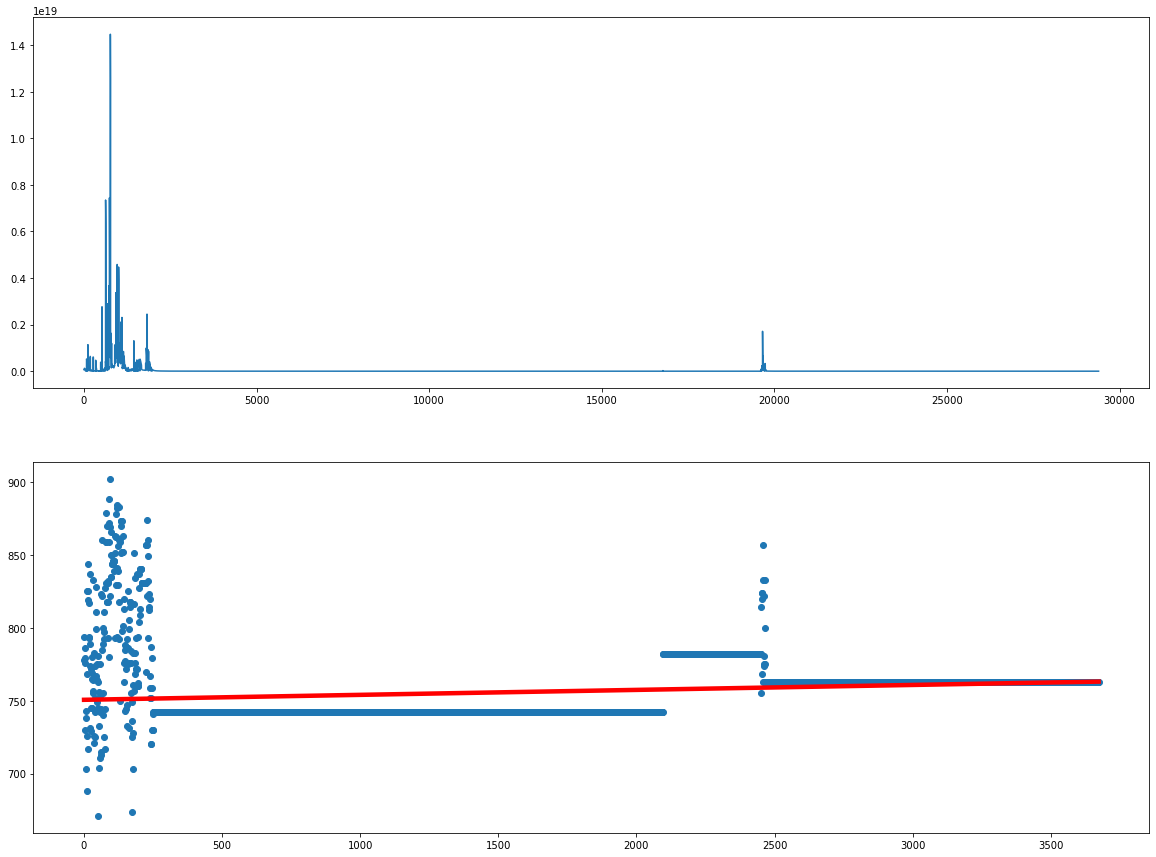

1
Epoch 3675: Current Learning Rate: [0.0003356962876010697, 0.0023978306257219323], Current Success Rate: 763


/var/folders/tp/g5d5jn1j0x3d60w7kqpbj6wm0000gn/T/ipykernel_75577/2845807382.py:61: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



episode  3700  is done!


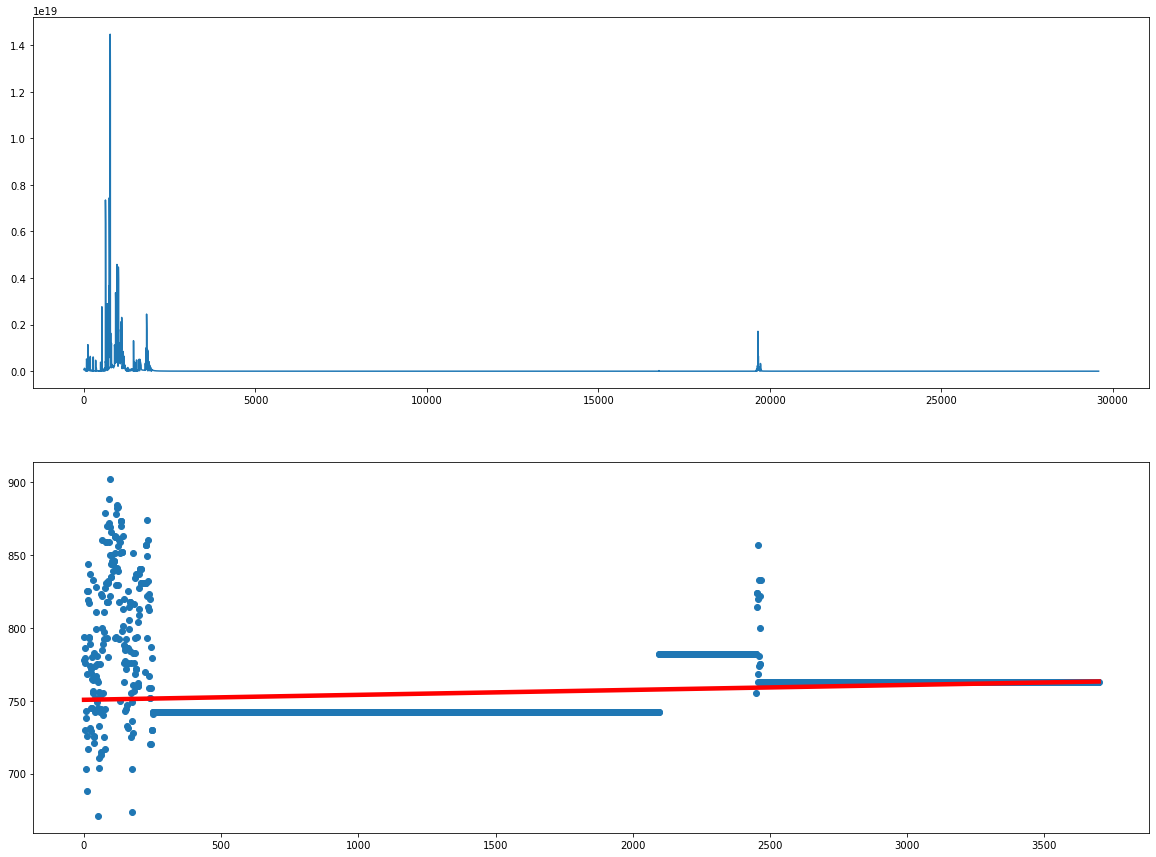

1
Epoch 3700: Current Learning Rate: [0.00033402182834849287, 0.00238587020248924], Current Success Rate: 763


/var/folders/tp/g5d5jn1j0x3d60w7kqpbj6wm0000gn/T/ipykernel_75577/2845807382.py:61: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



episode  3725  is done!


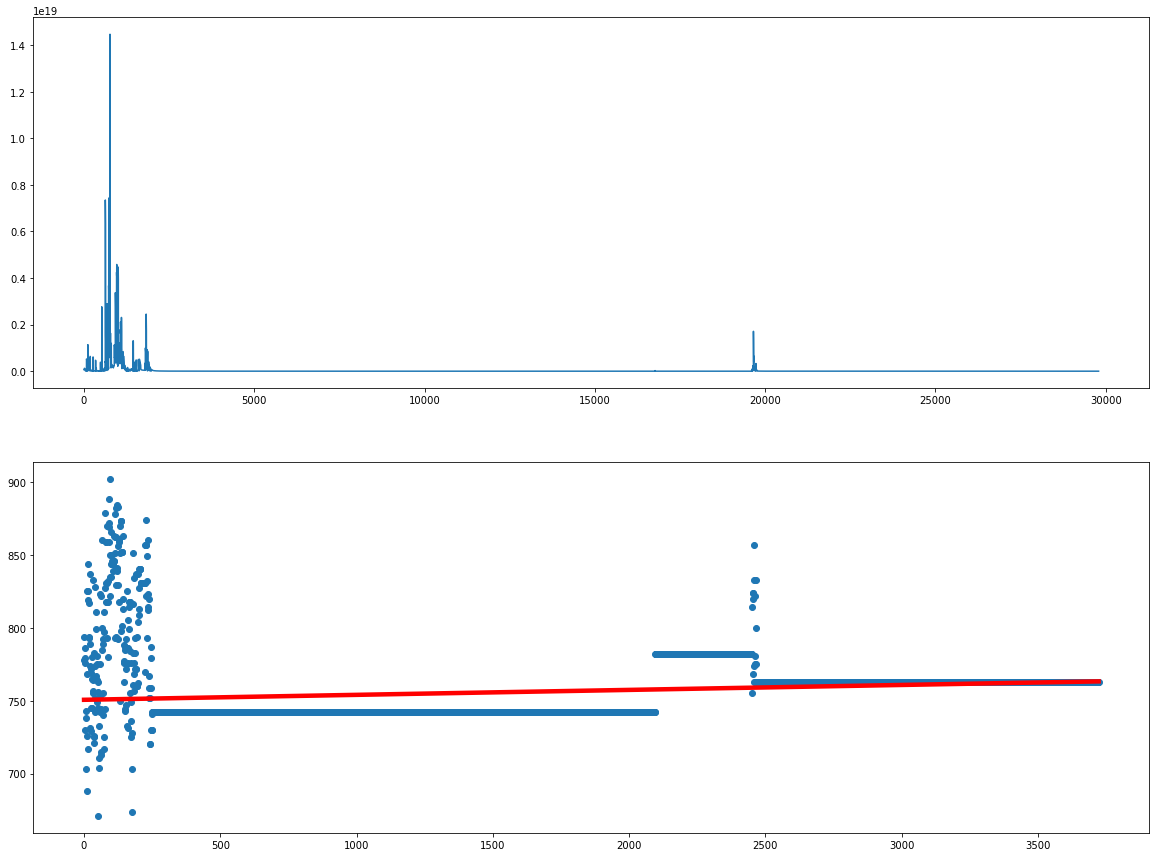

1
Epoch 3725: Current Learning Rate: [0.00033235572132944404, 0.0023739694380674626], Current Success Rate: 763


/var/folders/tp/g5d5jn1j0x3d60w7kqpbj6wm0000gn/T/ipykernel_75577/2845807382.py:61: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



episode  3750  is done!


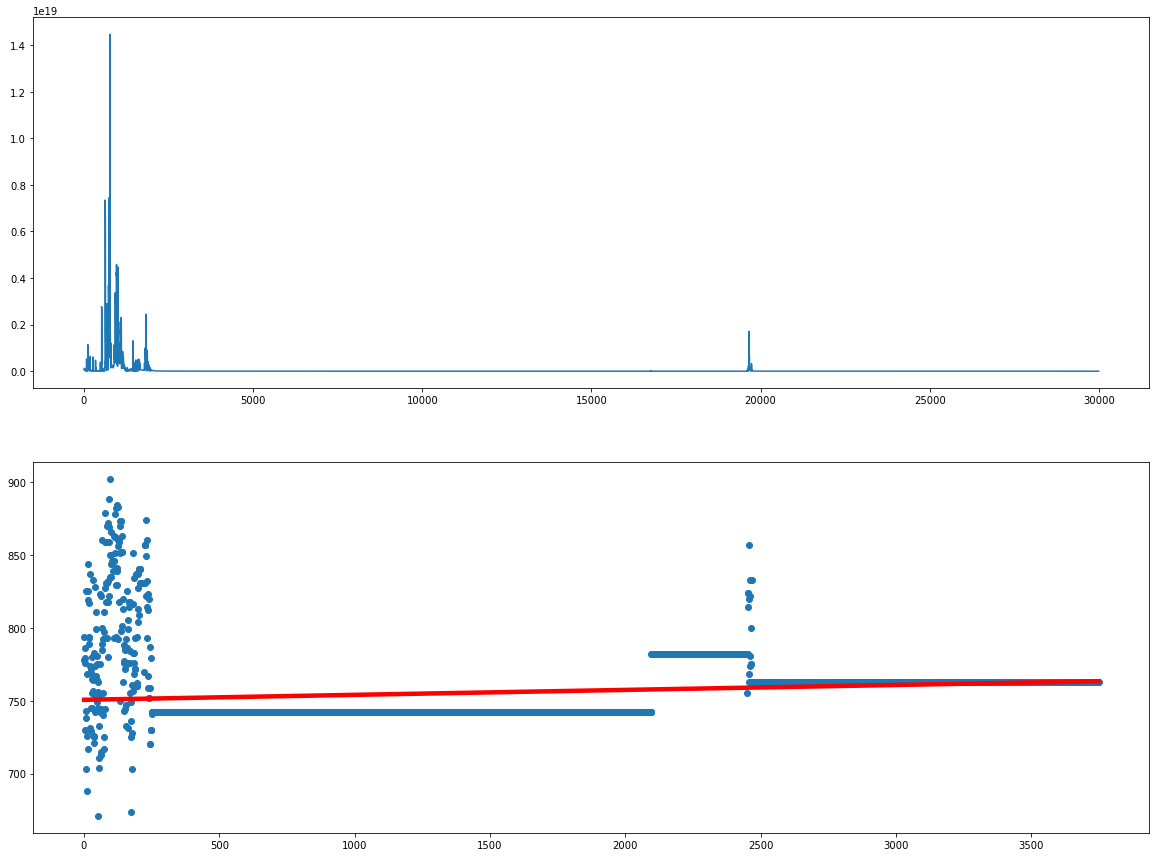

1
Epoch 3750: Current Learning Rate: [0.00033069792488282877, 0.002362128034877354], Current Success Rate: 763


/var/folders/tp/g5d5jn1j0x3d60w7kqpbj6wm0000gn/T/ipykernel_75577/2845807382.py:61: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



episode  3775  is done!


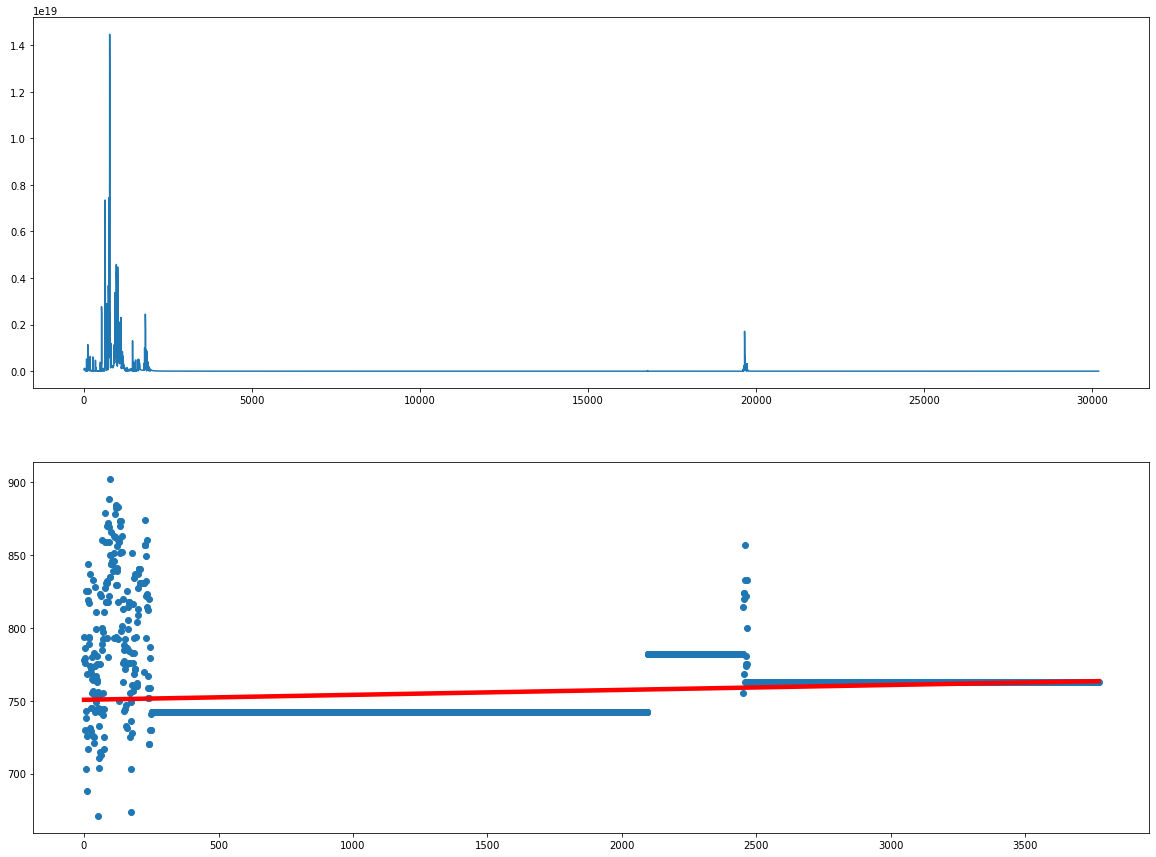

1
Epoch 3775: Current Learning Rate: [0.00032904839755535926, 0.0023503456968240006], Current Success Rate: 763


/var/folders/tp/g5d5jn1j0x3d60w7kqpbj6wm0000gn/T/ipykernel_75577/2845807382.py:61: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



episode  3800  is done!


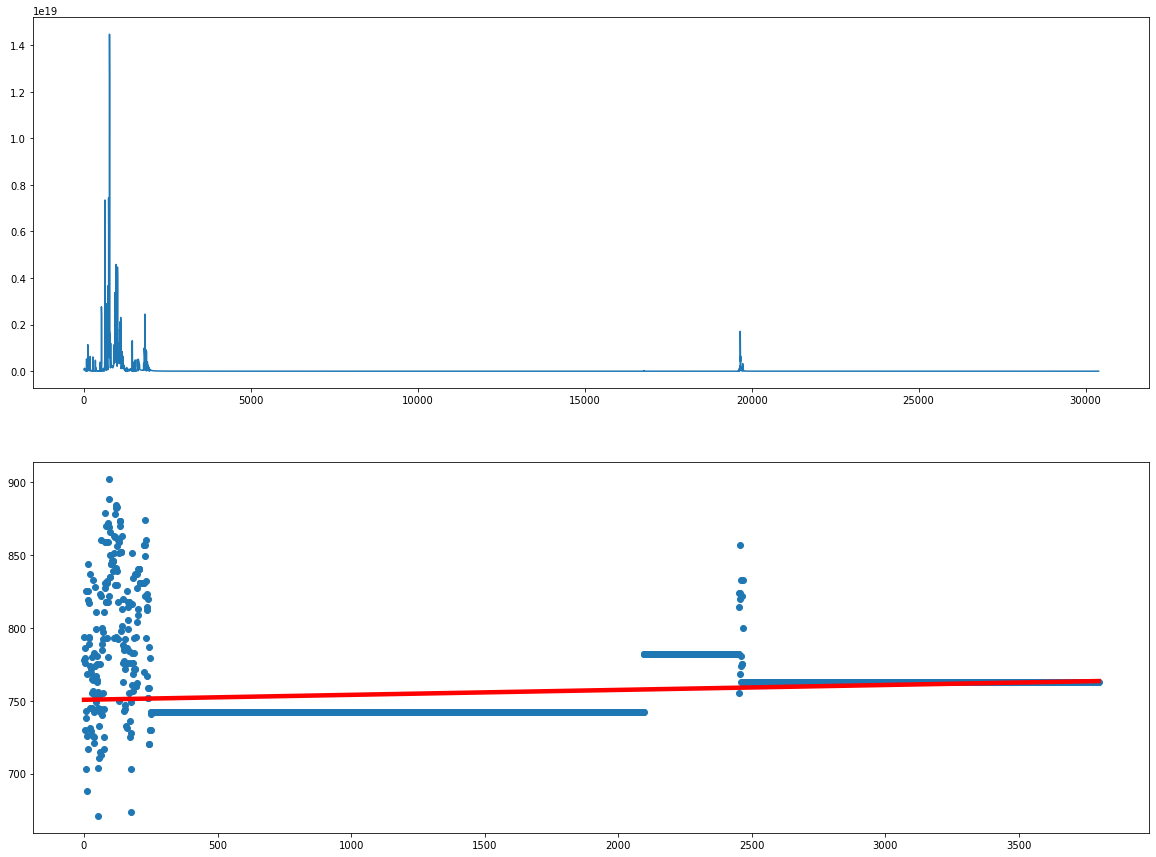

1
Epoch 3800: Current Learning Rate: [0.00032740709810051723, 0.002338622129289414], Current Success Rate: 763


/var/folders/tp/g5d5jn1j0x3d60w7kqpbj6wm0000gn/T/ipykernel_75577/2845807382.py:61: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



episode  3825  is done!


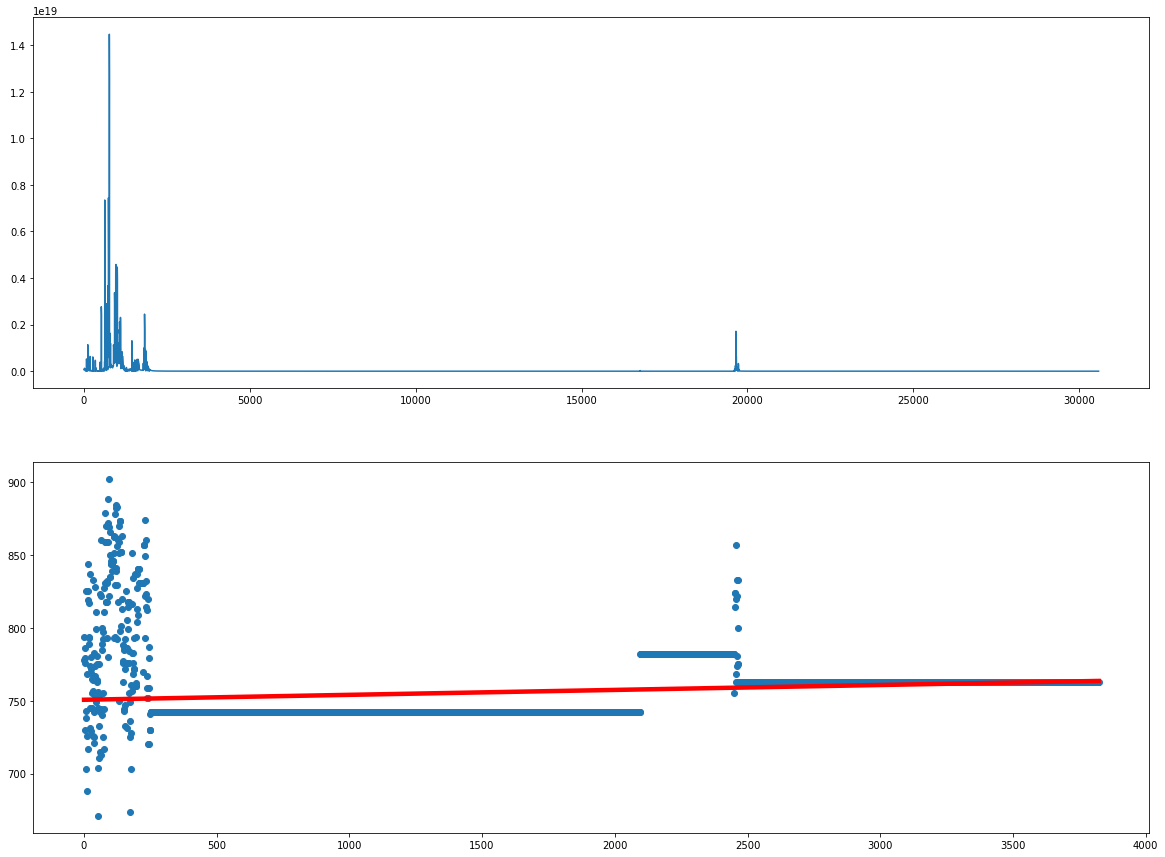

1
Epoch 3825: Current Learning Rate: [0.0003257739854775226, 0.002326957039125166], Current Success Rate: 763


/var/folders/tp/g5d5jn1j0x3d60w7kqpbj6wm0000gn/T/ipykernel_75577/2845807382.py:61: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



episode  3850  is done!


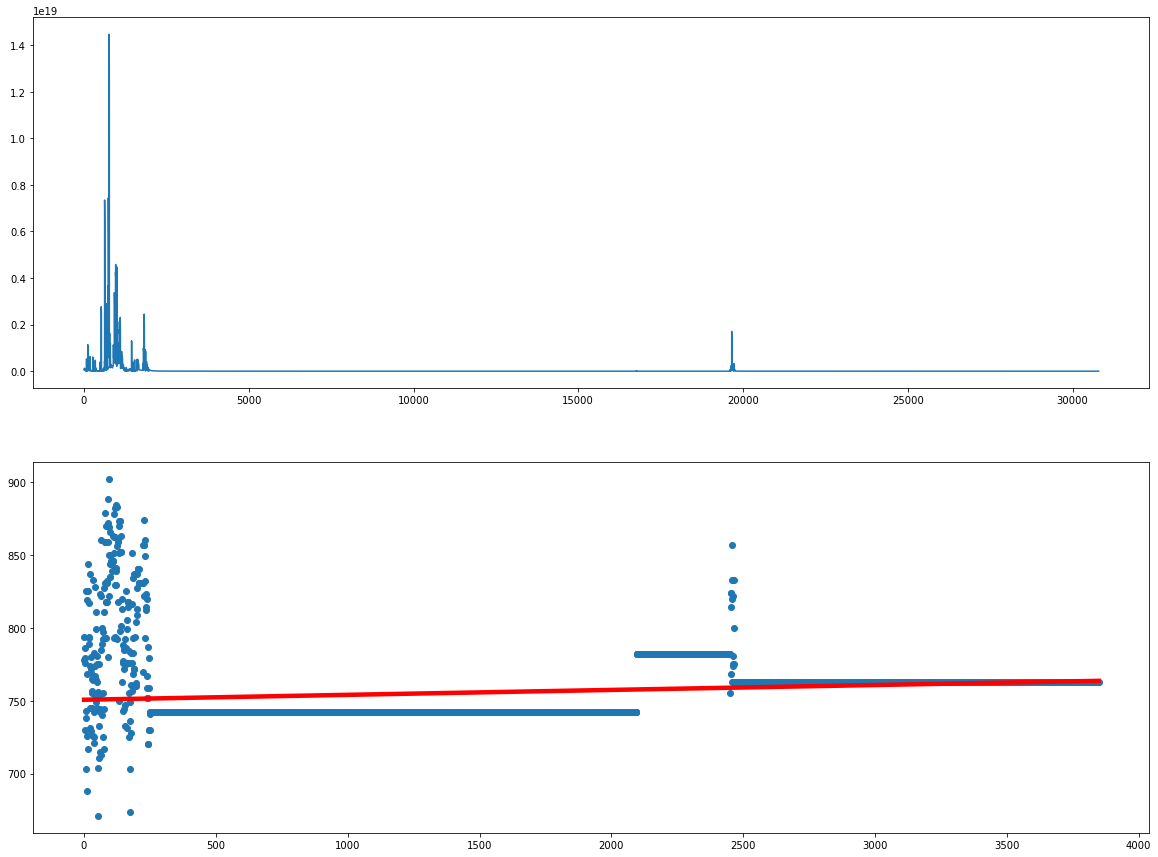

1
Epoch 3850: Current Learning Rate: [0.00032414901885030763, 0.00231535013464506], Current Success Rate: 763


/var/folders/tp/g5d5jn1j0x3d60w7kqpbj6wm0000gn/T/ipykernel_75577/2845807382.py:61: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



episode  3875  is done!


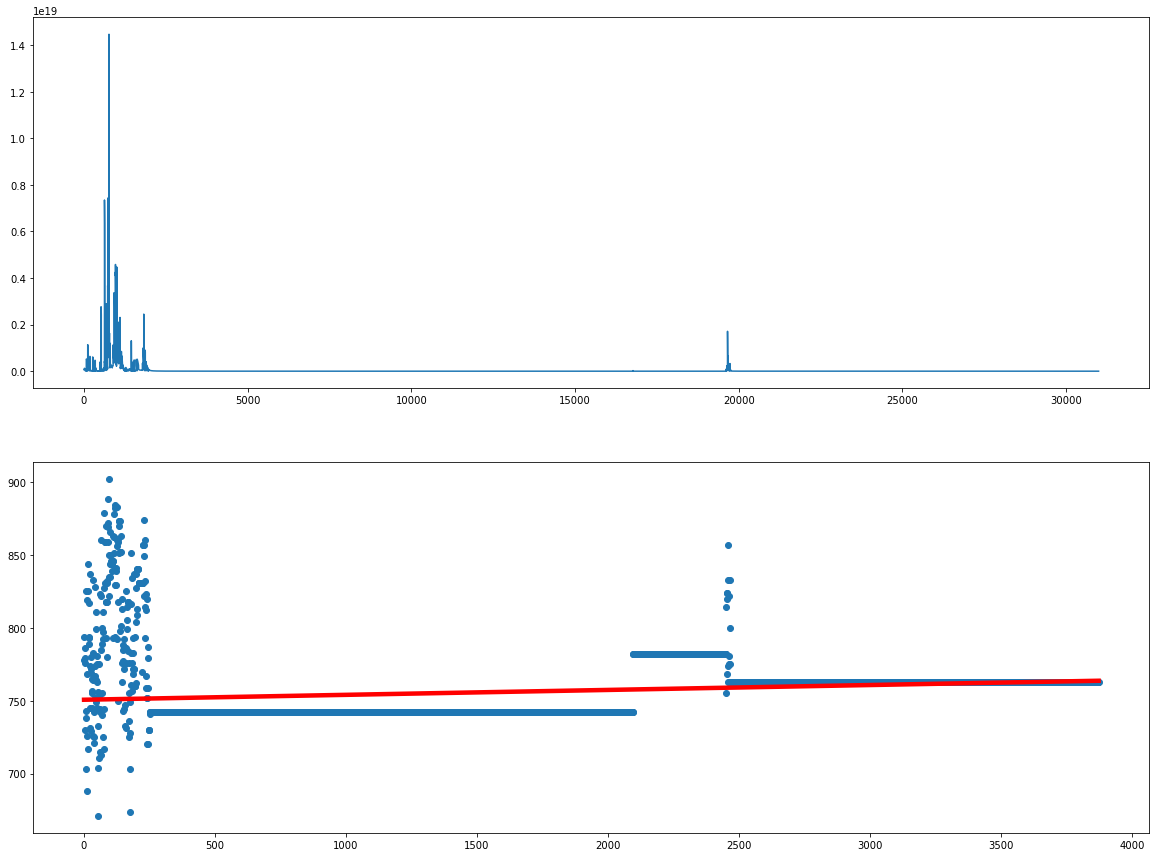

1
Epoch 3875: Current Learning Rate: [0.0003225321575864959, 0.0023038011256178324], Current Success Rate: 763


/var/folders/tp/g5d5jn1j0x3d60w7kqpbj6wm0000gn/T/ipykernel_75577/2845807382.py:61: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



episode  3900  is done!


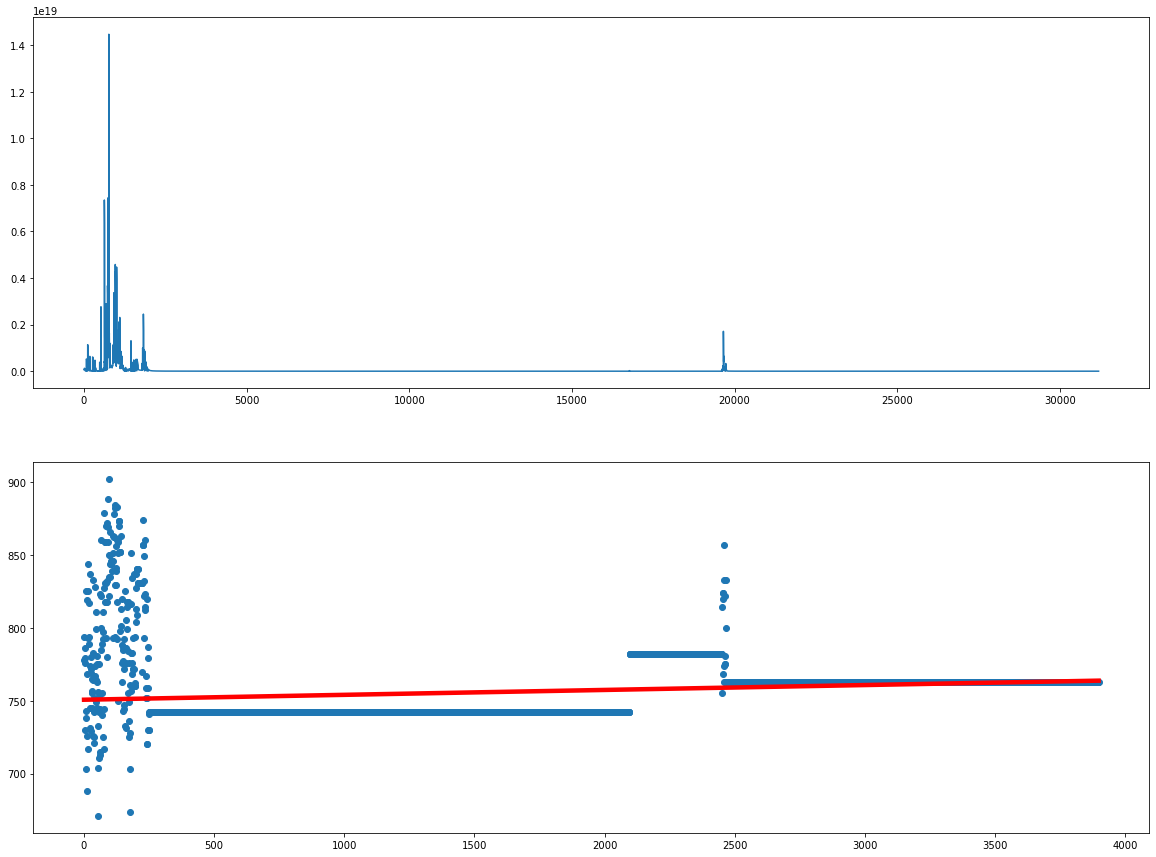

1
Epoch 3900: Current Learning Rate: [0.00032092336125638546, 0.002292309723259901], Current Success Rate: 763


/var/folders/tp/g5d5jn1j0x3d60w7kqpbj6wm0000gn/T/ipykernel_75577/2845807382.py:61: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



episode  3925  is done!


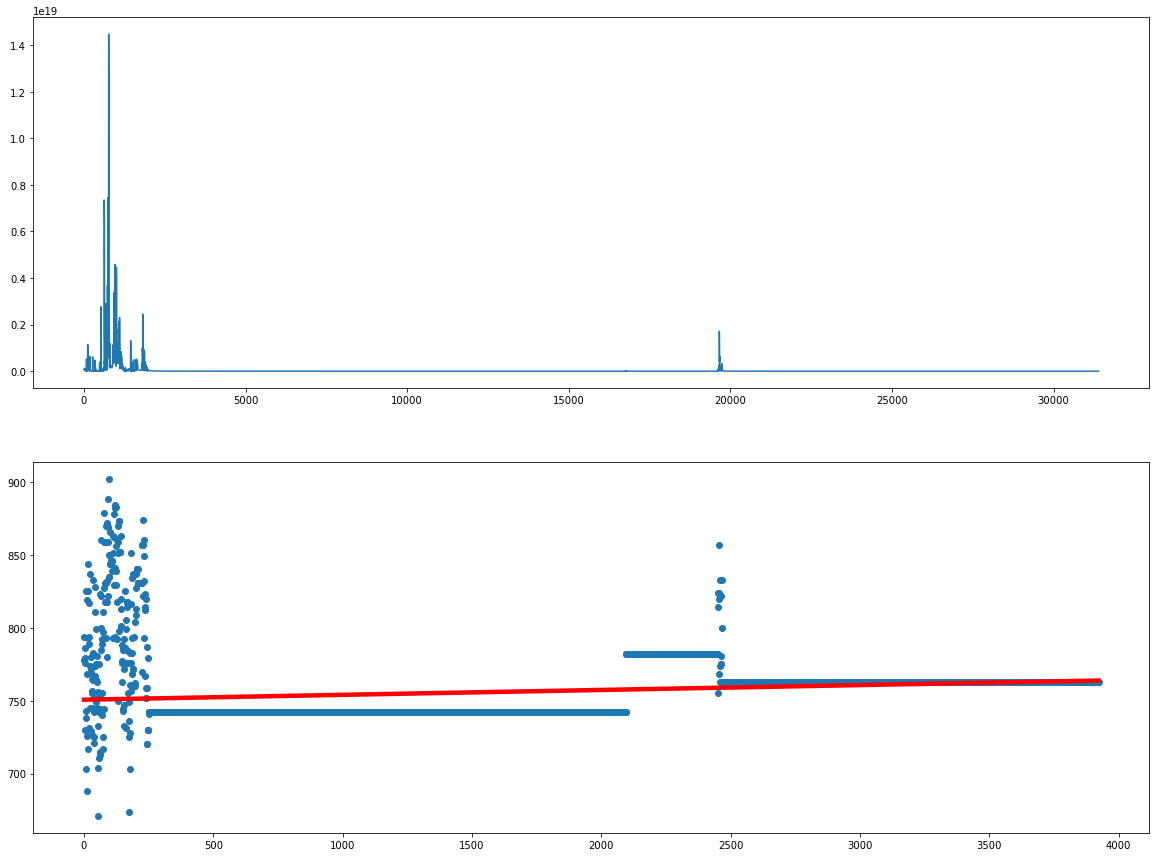

1
Epoch 3925: Current Learning Rate: [0.00031932258963193884, 0.002280875640228139], Current Success Rate: 763


/var/folders/tp/g5d5jn1j0x3d60w7kqpbj6wm0000gn/T/ipykernel_75577/2845807382.py:61: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



episode  3950  is done!


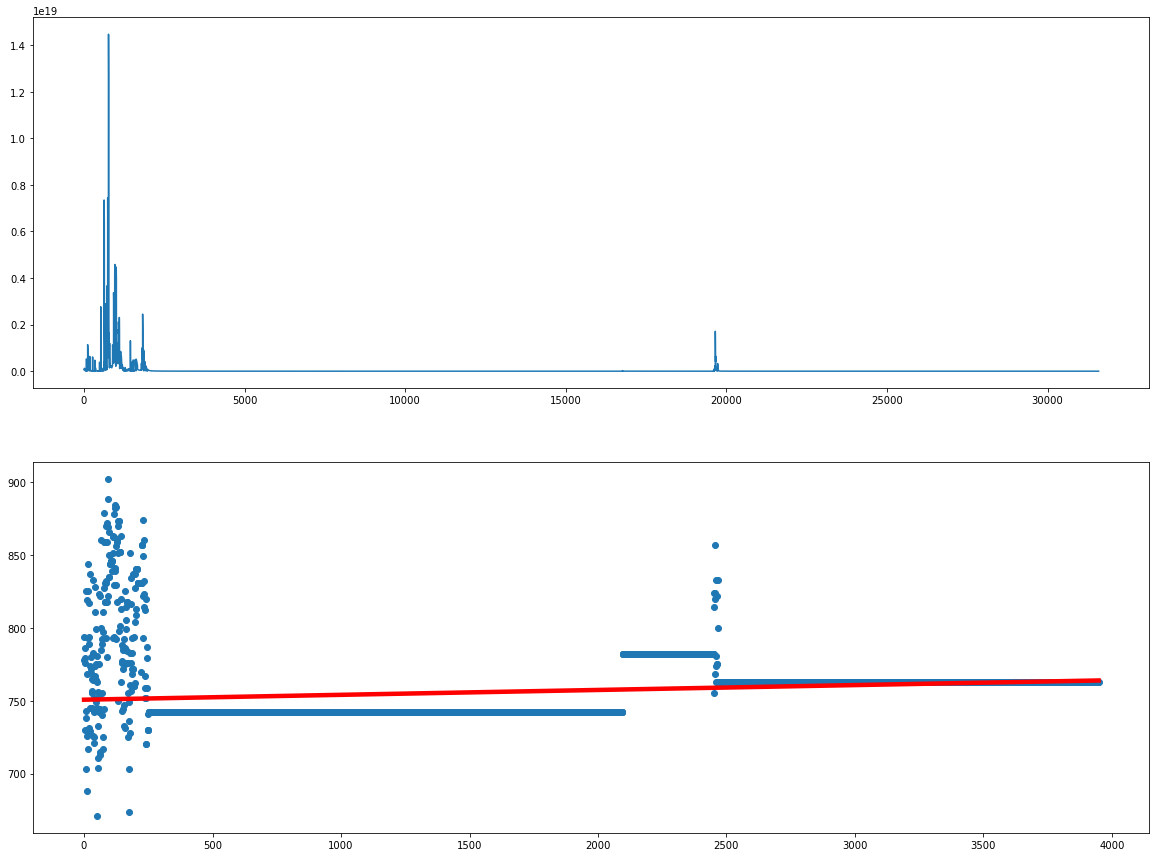

1
Epoch 3950: Current Learning Rate: [0.0003177298026857769, 0.002269498590612697], Current Success Rate: 763


/var/folders/tp/g5d5jn1j0x3d60w7kqpbj6wm0000gn/T/ipykernel_75577/2845807382.py:61: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



episode  3975  is done!


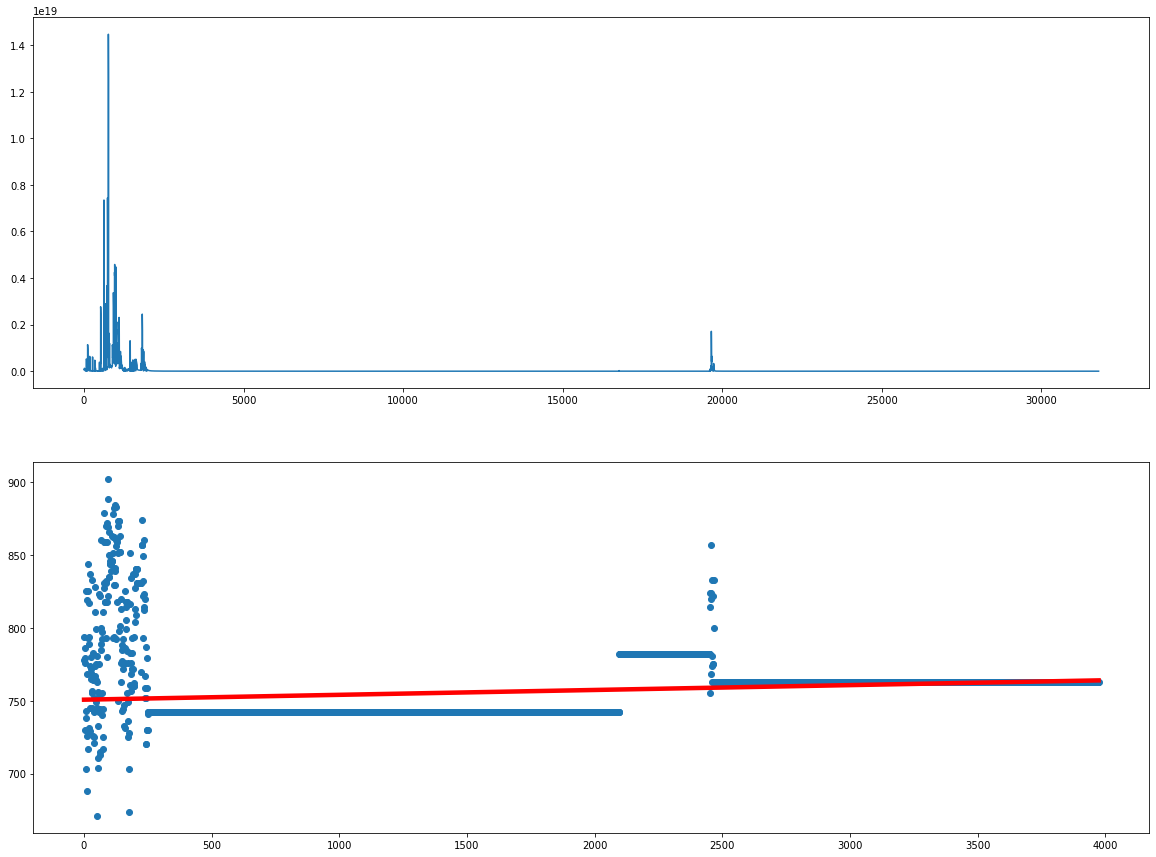

1
Epoch 3975: Current Learning Rate: [0.0003161449605901774, 0.002258178289929844], Current Success Rate: 763


/var/folders/tp/g5d5jn1j0x3d60w7kqpbj6wm0000gn/T/ipykernel_75577/2845807382.py:61: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



episode  4000  is done!


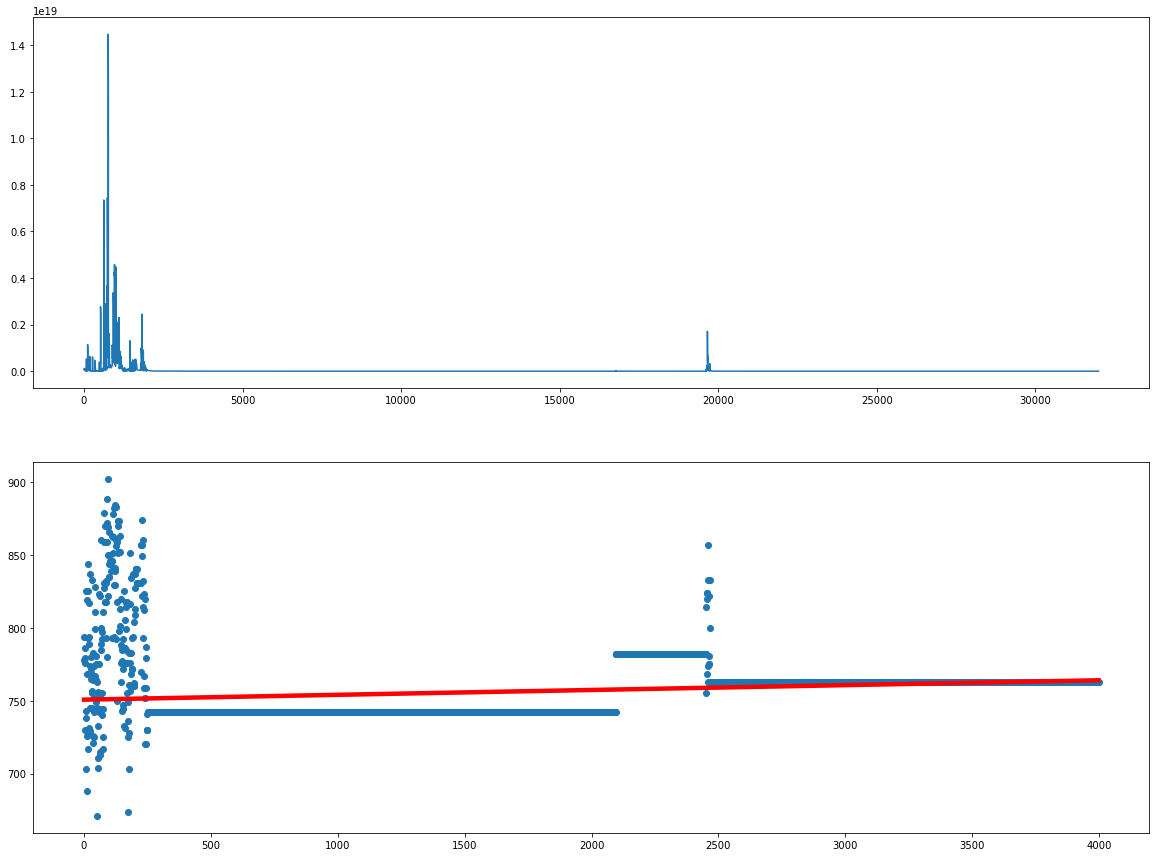

1
Epoch 4000: Current Learning Rate: [0.0003145680237160798, 0.002246914455114861], Current Success Rate: 763


/var/folders/tp/g5d5jn1j0x3d60w7kqpbj6wm0000gn/T/ipykernel_75577/2845807382.py:61: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



In [33]:
# Initialize your environment and the PPO agent
env = sim_constrained.Env(visualise=False, verbose=False, model=True,goal="min_time")

n_states = env.n_states

print(n_states)
n_actions = env.n_actions

ppo_agent = PPO(n_states, n_actions, lr_actor=7e-4, lr_critic=5e-3, gamma=0.97, K_epochs=8, eps_clip=0.18, gae_lambda=0.97)
memory = Memory()

initial_temperature = 2  # Starting temperature
final_temperature = 1    # Minimum temperature
decay_rate = 0.002          # Rate of temperature decay
current_temperature = initial_temperature

# Training loop
num_episodes = 4000
success_rates = []
losses = []
success_rate = 0

for episode in range(num_episodes):
    if not (episode + 1) % 25:
        print("episode ", episode+1, " is done!")
        show(losses, success_rates)
        print(current_temperature)
        # Optional: print the current learning rate
        current_lr = ppo_agent.scheduler.get_last_lr()  # get_last_lr returns a list for each param group
        print(f"Epoch {episode+1}: Current Learning Rate: {current_lr}, Current Success Rate: {success_rate}")
    
    current_temperature = max(final_temperature, initial_temperature * (1 - decay_rate * episode))


    state_data, action_mask , _ = env.reset()


    #print(current_temperature)
        
    done = False

    while not done:
        action = ppo_agent.select_action(state_data, memory, action_mask)
        #print(action)
        state_data, reward, done, action_mask, success_rate = env.step(action)
        
        #print(state_data, reward, done, success_rate )
        
        if done:
            #reward += math.exp(success_rate / 10 )
            reward -= 2 * math.exp(success_rate/40 )

        # Save in memory
        memory.rewards.append(reward)
        memory.is_terminals.append(done)
        with torch.no_grad():
            _, state_value = ppo_agent.policy_old(torch.FloatTensor(state_data).unsqueeze(0), action_mask)
            memory.values.append(state_value)
        
        
        
    
    success_rates.append(success_rate)
    #print(success_rate)
    
    # Update PPO agent
    losses += ppo_agent.update(memory)
    
    ppo_agent.scheduler.step()
    
    memory.clear_memory()

    # Log results, etc.


In [ ]:
test_env = sim_constrained.Env(visualise=True, verbose=False, model=True, test=True, goal="min_time")
state_data, action_mask , _ = env.reset()

done = False

while not done:
    action = ppo_agent.select_action(state_data, memory, action_mask)
    #print(action)
    state_data, reward, done, action_mask, success_rate = test_env.step(action)
    #print(state, reward, done, action_mask, success_rate )


### torch.save(ppo_agent, '/Users/hazarckr/Documents/Semester_3/idp/schedulingGNN/trainedModel2.pth')

Freezed Values:
    
self.actor = nn.Sequential(
            nn.Linear(n_states, 512),
            
            nn.PReLU(),
            
            nn.Linear(512, 256),
            nn.ReLU(),
            
            nn.Linear(256, 128),
            
            nn.LeakyReLU(),
            nn.Linear(128, 64),
            nn.LeakyReLU(),
            
            nn.Linear(64, n_actions),
        )
        self.critic = nn.Sequential(
            nn.Linear(n_states, 128),
            nn.LeakyReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 1)
    
    
ppo_agent = PPO(n_states, n_actions, lr_actor=0.00007, lr_critic=0.003, gamma=0.98, K_epochs=10, eps_clip=0.08, gae_lambda=0.97)
memory = Memory()

initial_temperature = 3  # Starting temperature
final_temperature = 1    # Minimum temperature
decay_rate = 0.001          # Rate of temperature decay
current_temperature = initial_temperature